In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/yono

/content/drive/MyDrive/yono


In [3]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 170 kB/s 


In [4]:
!pip install pytorchcv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 532 kB 9.7 MB/s 


In [5]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from __future__ import absolute_import, division, print_function
import os, sys, json
current_path = os.path.abspath('.')
parent_path = os.path.dirname(current_path)
sys.path.append(parent_path)
import argparse
import collections,math
import time,datetime,pytz
import numpy as np
import pandas as pd
import pickle
import unittest

from scipy.fftpack import dct, idct
from scipy import stats
from scipy import interpolate, io
from scipy.io import loadmat
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from tqdm import tqdm
from torchinfo import summary
import faiss

from src.data_loader import *
from src.utils import *

from src.models.simple_cnn import *
from src.models.resnet_models import *
from src.models.dscnn import *
from src.train_joint import *

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

############################################
########## Plot Style Declaration ##########
# Set the style globally
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
# plt.style.use('ggplot')
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'times new roman'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

##################################
########## End of Setup ##########

In [7]:
class ArgClass():
    def __init__(self):
        super(ArgClass, self).__init__()

args = ArgClass()
args.dataset="mnist"
args.model_arch = "cnn"
args.batch_size=128
args.test_batch_size=1000
args.percent=[0.8, 0.92, 0.991, 0.93]
args.alpha=5e-4
args.rho=1e-2
args.l1=False
args.l2=False
args.num_pre_epochs=3
args.num_epochs=10
args.num_re_epochs=3
args.lr=1e-3
args.adam_epsilon=1e-8
args.no_cuda=False
args.seed=1
args.save_model=False
args.shuffle=True

args.optimizer_name = 'adam'
args.lr_mode = 'multistep'
args.lr_decay = 0.1
args.lr_decay_epoch = '20,40'
args.target_lr = 1e-8
args.warmup_epochs = 0
args.warmup_lr = 1e-8
args.warmup_mode = 'linear'
args.momentum = 0.9
args.wd = 0.0001
args.gamma_wd_mult = 1.0
args.beta_wd_mult = 1.0
args.bias_wd_mult = 1.0
args.grad_clip = None
args.label_smoothing = False


args.test_fold_l = '[10]'
args.use_one_task = 'false'
args.exp_setup = ''
args.subject_idx = None
args.pretrained=False
args.best_acc = 200.0
args.mixup = False
args.mixup_alpha = 1.0
args.mixup_epoch_tail = 10
args.session = 1
args.test_vote = None

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [8]:
device

device(type='cuda')

In [ ]:

mnist = VWNet(args,
            in_channels=1,
            in_size=(28,28),
            channels=[8,16,32],
            fcDims=[128,256],
            kernels=[(3,3)],
            num_classes=10,
            pooling_type='max')
mnist.load_state_dict(torch.load('./data/saved_model/VWNet_mnist_adam_multistep_nomixup.pt', map_location=device))


args.config = DATASET_CONFIGS['cifar10']
cifar10 = PTCVDSCNN(model_name='MicroNet-AD-I-ch168', in_channels=args.config["in_channels"],
                             num_classes=args.config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=False)
cifar10.load_state_dict(torch.load('/content/drive/MyDrive/yono/data/saved_model/MicroNet-AD-I-ch168_cifar10_adam_multistep_nomixup.pt', map_location=device))
print(cifar10)

args.config = DATASET_CONFIGS['svhn']
svhn = PTCVDSCNN(model_name='MicroNet-AD-I-ch168', in_channels=args.config["in_channels"],
                             num_classes=args.config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=False)
svhn.load_state_dict(torch.load('./data/saved_model/MicroNet-AD-I-ch168_svhn_adam_multistep_nomixup.pt', map_location=device))

args.config = DATASET_CONFIGS['gtsrb-vw']
gtsrb = PTCVDSCNN(model_name='MicroNet-AD-I-ch168', in_channels=args.config["in_channels"],
                             num_classes=args.config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=False)
gtsrb.load_state_dict(torch.load('/content/drive/MyDrive/yono/data/saved_model/MicroNet-AD-I-ch168_gtsrb-vw_adam_multistep_nomixup.pt', map_location=device))

args.config = DATASET_CONFIGS['gscv2-mfcc10']
gsc = PTCVDSCNN(model_name='MicroNet-M', in_channels=args.config["in_channels"],
                             num_classes=args.config["classes"],
                             init_block_kernel=(10, 4),
                             pretrained=False)
gsc.load_state_dict(torch.load('./data/saved_model/MicroNet-M_gscv2-mfcc10_adam_multistep_nomixup.pt', map_location=device))

# import joblib


# joblib.dump(cifar10, 'finalized_model.pt')



In [10]:
config = DATASET_CONFIGS['hhar-noaug']
hhar = PTCVDSCNN(model_name='MicroNet-AD-I-ch176-s41', in_channels=1,
                             num_classes=config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=args.pretrained)
hhar.load_state_dict(torch.load('./data/saved_model/MicroNet-hhar-ch176_hhar-noaug_adam_multistep_nomixup.pt', map_location=device))



config = DATASET_CONFIGS['ninapro-db6-c7-seq80']
ninadb6 = PTCVDSCNN(model_name='MicroNet-AD-K', in_channels=1,
                             num_classes=config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=args.pretrained)
ninadb6.load_state_dict(torch.load('./data/saved_model/MicroNet-AD-K_ninapro-db6-c7-seq80_adam_multistep_nomixup.pt', map_location=device))



<All keys matched successfully>

In [11]:
# Unseen Images
config = DATASET_CONFIGS['fashion-mnist']
fmnist = PTCVDSCNN(model_name='DS-CNN-M', in_channels=config["in_channels"],
                             num_classes=config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=args.pretrained)
fmnist.load_state_dict(torch.load('./data/saved_model/DS-CNN-M_fashion-mnist_adam_multistep_nomixup.pt', map_location=device))

config = DATASET_CONFIGS['stl10']
stl10 = PTCVDSCNN(model_name='DS-CNN-M-s33', in_channels=config["in_channels"],
                             num_classes=config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=args.pretrained)
stl10.load_state_dict(torch.load('./data/saved_model/DS-CNN-M-s33_stl10_adam_multistep_nomixup.pt', map_location=device))

# Unseen Audio
config = DATASET_CONFIGS['emotion-5-frames25']
emotion = AudioCNN(channels=[32,32,64,64],
                             in_size=(config["features"],config["seq"] ),
                             num_classes=config['classes'],
                             pooling_type="avg")
emotion.load_state_dict(torch.load('./data/saved_model/AudioCNN_emotion-5-frames25_adam_multistep_nomixup.pt', map_location=device))

config = DATASET_CONFIGS['urbansound8k-LMCST-long-randfold']
urbansound = PTCVDSCNN(model_name='DS-CNN-M-s33', in_channels=1,
                             num_classes=config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=args.pretrained)
urbansound.load_state_dict(torch.load('./data/saved_model/DS-CNN-M-s33_urbansound8k-LMCST-long-randfold_adam_multistep_nomixup.pt', map_location=device))


# Unseen HAR
config = DATASET_CONFIGS['pamap2']
pamap2 = PTCVDSCNN(model_name='MicroNet-AD-I-ch168-s21', in_channels=1,
                             num_classes=config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=args.pretrained)
pamap2.load_state_dict(torch.load('./data/saved_model/MicroNet-AD-I-ch168-s21_pamap2_adam_multistep_nomixup.pt', map_location=device))


config = DATASET_CONFIGS['skoda']
skoda = PTCVDSCNN(model_name='MicroNet-AD-I-ch192-s22', in_channels=1,
                             num_classes=config["classes"],
                             init_block_kernel=(3, 3),
                             pretrained=args.pretrained)
skoda.load_state_dict(torch.load('./data/saved_model/MicroNet-AD-I-ch192-s22_skoda_adam_multistep_nomixup.pt', map_location=device))



# Unseen GR
config = DATASET_CONFIGS['ninapro-db3-c10']
ninadb3 = AudioCNN(channels=[16,16,32,32],
                             in_size=(config["features"],config["seq"] ),
                             num_classes=config['classes'],
                             pooling_type="avg")
ninadb3.load_state_dict(torch.load('./data/saved_model/AudioCNN_ninapro-db3-c10_adam_multistep_nomixup.pt', map_location=device))



config = DATASET_CONFIGS['ninapro-db2-c10']
ninadb2 = AudioCNN(channels=[16,16,32,32],
                             in_size=(config["features"],config["seq"] ),
                             num_classes=config['classes'],
                             pooling_type="avg")
ninadb2.load_state_dict(torch.load('./data/saved_model/AudioCNN_ninapro-db2-c10_adam_multistep_nomixup.pt', map_location=device))


<All keys matched successfully>

In [ ]:
# # Lee's datasets
args.dataset = 'mnist'
train_loader_mnist, test_loader_mnist = get_data_loaders(args, kwargs)
args.dataset='cifar10'
train_loader_cifar10, test_loader_cifar10 = get_data_loaders(args, kwargs)
args.dataset='svhn'
train_loader_svhn, test_loader_svhn = get_data_loaders(args, kwargs)
args.dataset='gtsrb-vw'
train_loader_gtsrb, test_loader_gtsrb = get_data_loaders(args, kwargs)
args.dataset='gscv2-mfcc10'
train_loader_gsc, test_loader_gsc = get_data_loaders(args, kwargs)

# additional datasets to be trained 
args.dataset = 'hhar-noaug'
train_loader_hhar, test_oloader_hhar = get_data_loaders(args, kwargs)
args.dataset = 'ninapro-db2-c10'
args.subject_idx=11
args.exp_setup='per-subject'
train_loader_ninadb2, test_loader_ninadb2 = get_data_loaders(args, kwargs)

# unseen datasets
# args.dataset = 'fashion-mnist'
# train_loader_fmnist, test_loader_fmnist = get_data_loaders(args, kwargs)
# args.dataset = 'stl10'
# train_loader_stl10, test_loader_stl10 = get_data_loaders(args, kwargs)

args.dataset = 'emotion-5-frames25'
train_loader_emotion, test_loader_emotion = get_data_loaders(args, kwargs)
# args.dataset = 'urbansound8k-LMCST-long-randfold'
# train_loader_urbansound, test_loader_urbansound = get_data_loaders(args, kwargs)

# args.dataset = 'pamap2'
# train_loader_pamap2, test_loader_pamap2 = get_data_loaders(args, kwargs)
# args.dataset = 'skoda'
# train_loader_skoda, test_loader_skoda = get_data_loaders(args, kwargs)

args.dataset = 'ninapro-db3-c10'
args.subject_idx=1
train_loader_ninadb3, test_loader_ninadb3 = get_data_loaders(args, kwargs)
args.dataset = 'ninapro-db6-c7-seq80'
train_loader_ninadb6, test_loader_ninadb6 = get_data_loaders(args, kwargs)

In [13]:

# x = [0.1, 0.2, 0.3, 0.1, 0.0, 0.8, 0.9]
# a = dct(x, norm='ortho')
# b = idct(a, norm='ortho')

def denormalize(arr, orig_model_arr=None, denorm=False):
    if denorm == False:
        return arr
    else:
        # arr = (orig - m) / sd
        # arr*sd + m = orig
        m, sd = np.mean(orig_model_arr), np.std(orig_model_arr)
        return arr * sd + m

def normalize(arr):
    m, sd = np.mean(arr), np.std(arr)
    return (arr - m)/sd

def concatModelWeightsNormalize(model, model_arch='LeNet', d = 256):
    if 'LeNet' == model_arch:
        feat = np.reshape( normalize( model.conv1.weight.detach().numpy() ), (1,-1))
        feat = np.concatenate((feat,np.reshape( normalize( model.conv1.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc2.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc2.bias.detach().numpy() ), (1,-1))), axis=1)
    elif 'LeNetWOFc2' == model_arch:
        feat = np.reshape( normalize( model.conv1.weight.detach().numpy() ), (1,-1))
        feat = np.concatenate((feat,np.reshape( normalize( model.conv1.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.bias.detach().numpy() ), (1,-1))), axis=1)
        print(model_arch)
    else:
        feat = None
    
    print("feat.shape: ", feat.shape)
    feat = dct(feat, norm='ortho')
    return feat.astype(np.float32)

def concatModelWeightsNormalizeAndReshape(model, model_arch='LeNet', d = 256):
    if 'LeNet' == model_arch:
        feat = np.reshape( normalize( model.conv1.weight.detach().numpy() ), (1,-1))
        feat = np.concatenate((feat,np.reshape( normalize( model.conv1.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc2.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc2.bias.detach().numpy() ), (1,-1))), axis=1)
    elif 'LeNetWOFc2' == model_arch:
        feat = np.reshape( normalize( model.conv1.weight.detach().numpy() ), (1,-1))
        feat = np.concatenate((feat,np.reshape( normalize( model.conv1.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.conv2.bias.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.weight.detach().numpy() ), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape( normalize( model.fc1.bias.detach().numpy() ), (1,-1))), axis=1)
        print(model_arch)
    else:
        feat = None
    
    print("feat.shape: ", feat.shape)
    feat = dct(feat, norm='ortho')
    if feat.shape[1] % d != 0:
        feat = np.concatenate((feat, np.zeros((1, d - feat.shape[1]%d))), axis=1)
    # reshaped_feat = np.reshape(feat[:,:int(feat.shape[1]/d)*d], (-1, d))
    reshaped_feat = np.reshape(feat, (-1, d))
    print("reshaped_feat.shape: ", reshaped_feat.shape)
    return reshaped_feat.astype(np.float32)



def concatModelWeightsDCT(model, model_arch='LeNet', d = 256):
    if 'LeNet' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'LeNetWOFc2' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
        print(model_arch)
    else:
        feat = None
    
    print("feat.shape: ", feat.shape)
    feat = dct(feat, norm='ortho')
    return feat.astype(np.float32)

def concatModelWeightsDCTAndReshape(model, model_arch='LeNet', d = 256):
    if 'LeNet' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'LeNetWOFc2' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
        print(model_arch)
    else:
        feat = None
    
    print("feat.shape: ", feat.shape)
    feat = dct(feat, norm='ortho')
    if feat.shape[1] % d != 0:
        feat = np.concatenate((feat, np.zeros((1, d - feat.shape[1]%d))), axis=1)
    # reshaped_feat = np.reshape(feat[:,:int(feat.shape[1]/d)*d], (-1, d))
    reshaped_feat = np.reshape(feat, (-1, d))
    print("reshaped_feat.shape: ", reshaped_feat.shape)
    return reshaped_feat.astype(np.float32)


def concatModelWeights(model, model_arch='LeNet', d = 256):
    model.to('cpu')
    if 'LeNet' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'LeNetWOFc2' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'AudioCNN' == model_arch:
        feat = np.reshape(model.conv1[0].weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'AudioCNNWOFc' == model_arch:
        feat = np.reshape(model.conv1[0].weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].bias.detach().numpy(), (1,-1))), axis=1)
    else:
        feat = None
    
    print("feat.shape: ", feat.shape)
    return feat.astype(np.float32)

def concatModelWeightsAndReshape(model, model_arch='LeNet', d = 256):
    model.to('cpu')
    if 'LeNet' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc2.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'LeNetWOFc2' == model_arch:
        feat = np.reshape(model.conv1.weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2.bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc1.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'AudioCNN' == model_arch:
        feat = np.reshape(model.conv1[0].weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc.weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.fc.bias.detach().numpy(), (1,-1))), axis=1)
    elif 'AudioCNNWOFc' == model_arch:
        feat = np.reshape(model.conv1[0].weight.detach().numpy(), (1,-1))
        feat = np.concatenate((feat,np.reshape(model.conv1[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv2[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv3[0].bias.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].weight.detach().numpy(), (1,-1))), axis=1)
        feat = np.concatenate((feat,np.reshape(model.conv4[0].bias.detach().numpy(), (1,-1))), axis=1)
    elif 'ResNet20' in model_arch:
        # 'ResNet20WOInOut'
        if 'In' not in model_arch: # when Init_block is included in PQ codebook.
            # Init_block + stage1:unit1:conv1
            feat = np.reshape(model.model.features.init_block.conv.weight.detach().numpy(), (1,-1))
            feat = np.concatenate((feat,np.reshape(model.model.features.stage1.unit1.body.conv1.conv.weight.detach().numpy(), (1,-1))), axis=1)
        else:
            # stage1:unit1:conv1
            feat = np.reshape(model.model.features.stage1.unit1.body.conv1.conv.weight.detach().numpy(), (1,-1))
        # stage1:unit1:conv2 ~ stage1:unit3:conv2
        feat = np.concatenate((feat,np.reshape(model.model.features.stage1.unit1.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage1.unit2.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage1.unit2.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage1.unit3.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage1.unit3.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)

        # stage2:unit1:conv1 ~ stage2:unit3:conv2 + unit1:identity_conv
        feat = np.concatenate((feat,np.reshape(model.model.features.stage2.unit1.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage2.unit1.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage2.unit1.identity_conv.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage2.unit2.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage2.unit2.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage2.unit3.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage2.unit3.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)

        # stage3:unit1:conv1 ~ stage3:unit3:conv2 + unit1:identity_conv
        feat = np.concatenate((feat,np.reshape(model.model.features.stage3.unit1.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage3.unit1.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage3.unit1.identity_conv.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage3.unit2.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage3.unit2.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage3.unit3.body.conv1.conv.weight.detach().numpy(), (1,-1)) ), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.features.stage3.unit3.body.conv2.conv.weight.detach().numpy(), (1,-1)) ), axis=1)

        if 'Out' not in model_arch: # when output layer is included in PQ codebook
            feat = np.concatenate((feat,np.reshape(model.model.output.weight.detach().numpy()), (1,-1)), axis=1)
            feat = np.concatenate((feat,np.reshape(model.model.output.bias.detach().numpy()), (1,-1)), axis=1)
    elif 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
        feat = np.empty((1,0), np.float32)
        for i, param in enumerate(model.parameters()):
            if len(param.size()) == 4: # consider only conv weights
                if i == 0: # case for init_block
                    if 'In' not in model_arch: # when Init_block is included in PQ codebook.
                        feat = np.concatenate((feat,np.reshape(param.detach().numpy(), (1,-1)) ), axis=1)
                else: # case for middle blocks
                    feat = np.concatenate((feat,np.reshape(param.detach().numpy(), (1,-1)) ), axis=1)

        if 'Out' not in model_arch: # when output layer is included in PQ codebook
            feat = np.concatenate((feat,np.reshape(model.model.output.weight.detach().numpy()), (1,-1)), axis=1)
            feat = np.concatenate((feat,np.reshape(model.model.output.bias.detach().numpy()), (1,-1)), axis=1)
    else:
        feat = None
    
    print("feat.shape: ", feat.shape)
    if feat.shape[1] % d != 0:
        feat = np.concatenate((feat, np.zeros((1, d - feat.shape[1]%d))), axis=1)
    # reshaped_feat = np.reshape(feat[:,:int(feat.shape[1]/d)*d], (-1, d))
    reshaped_feat = np.reshape(feat, (-1, d))
    print("reshaped_feat.shape: ", reshaped_feat.shape)
    return reshaped_feat.astype(np.float32)

def num_flat_features(x):
    size = x.size()
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

def makePQModel(decoded_feat, model_arch = 'LeNet', dataset = 'mnist', device=None, orig_model=None, denorm=False):
    arg = ArgClass()
    arg.dataset = dataset
    arg.model_arch = model_arch
    arg.pretrained = False
    arg.config = DATASET_CONFIGS[dataset]
    pq_model = prepare_model(arg)
    
    offset = 0
    decoded_feat = np.reshape(decoded_feat, (1,-1))
    
    if 'LeNet' == model_arch:
        # conv1
        size_tot = num_flat_features(pq_model.conv1.weight)
        pqconv1weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        size_tot = num_flat_features(pq_model.conv1.bias)
        pqconv1bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        # conv2
        size_tot = num_flat_features(pq_model.conv2.weight)
        pqconv2weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        size_tot = num_flat_features(pq_model.conv2.bias)
        pqconv2bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        # fc1
        size_tot = num_flat_features(pq_model.fc1.weight)
        pqfc1weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        size_tot = num_flat_features(pq_model.fc1.bias)
        pqfc1bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        # fc2
        size_tot = num_flat_features(pq_model.fc2.weight)
        if offset+size_tot > decoded_feat.shape[1]:
            print('offset+size_tot: ', offset+size_tot)
            print('size_tot: ', size_tot)
            print('decoded_feat.shape[1]: ', decoded_feat.shape[1])
            pqfc2weight = decoded_feat[:,offset:]
            pqfc2weight = np.concatenate((pqfc2weight, np.zeros((1,offset+size_tot-decoded_feat.shape[1])) ), axis=1)
            print('pqfc2weight.shape: ', pqfc2weight.shape)
        else:
            pqfc2weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        size_tot = num_flat_features(pq_model.fc2.bias)
        if offset >= decoded_feat.shape[1]:
            pqfc2bias = np.zeros((1,size_tot))
        elif offset+size_tot > decoded_feat.shape[1]:
            print('offset+size_tot: ', offset+size_tot)
            print('size_tot: ', size_tot)
            print('decoded_feat.shape[1]: ', decoded_feat.shape[1])
            pqfc2bias = decoded_feat[:,offset:]
            pqfc2bias = np.concatenate((pqfc2bias, np.zeros((1,offset+size_tot-decoded_feat.shape[1])) ), axis=1)
            print('pqfc2bias.shape: ', pqfc2bias.shape)
        else:
            pqfc2bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
                
        pq_model.conv1.weight = Parameter(torch.Tensor(np.reshape(pqconv1weight, pq_model.conv1.weight.size()) ))
        pq_model.conv1.bias = Parameter(torch.Tensor(np.reshape(pqconv1bias, pq_model.conv1.bias.size())))

        pq_model.conv2.weight = Parameter(torch.Tensor(np.reshape(pqconv2weight, pq_model.conv2.weight.size())))
        pq_model.conv2.bias = Parameter(torch.Tensor(np.reshape(pqconv2bias, pq_model.conv2.bias.size())))

        pq_model.fc1.weight = Parameter(torch.Tensor(np.reshape(pqfc1weight, pq_model.fc1.weight.size())))
        pq_model.fc1.bias = Parameter(torch.Tensor(np.reshape(pqfc1bias, pq_model.fc1.bias.size())))

        # not enough table..
        pq_model.fc2.weight = Parameter(torch.Tensor(np.reshape(pqfc2weight, pq_model.fc2.weight.size())))
        pq_model.fc2.bias = Parameter(torch.Tensor(np.reshape(pqfc2bias, pq_model.fc2.bias.size())))
    elif 'LeNetWOFc2' == model_arch:
        # conv1
        size_tot = num_flat_features(pq_model.conv1.weight)
        pqconv1weight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.conv1.weight.detach().numpy(), denorm)
        offset += size_tot

        size_tot = num_flat_features(pq_model.conv1.bias)
        pqconv1bias = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.conv1.bias.detach().numpy(), denorm)
        offset += size_tot

        # conv2
        size_tot = num_flat_features(pq_model.conv2.weight)
        pqconv2weight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.conv2.weight.detach().numpy(), denorm)
        offset += size_tot

        size_tot = num_flat_features(pq_model.conv2.bias)
        pqconv2bias = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.conv2.bias.detach().numpy(), denorm)
        offset += size_tot

        # fc1
        size_tot = num_flat_features(pq_model.fc1.weight)
        pqfc1weight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.fc1.weight.detach().numpy(), denorm)
        offset += size_tot

        size_tot = num_flat_features(pq_model.fc1.bias)
        pqfc1bias = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.fc1.bias.detach().numpy(), denorm)
        offset += size_tot
                
        pq_model.conv1.weight = Parameter(torch.Tensor(np.reshape(pqconv1weight, pq_model.conv1.weight.size()) ))
        pq_model.conv1.bias = Parameter(torch.Tensor(np.reshape(pqconv1bias, pq_model.conv1.bias.size())))

        pq_model.conv2.weight = Parameter(torch.Tensor(np.reshape(pqconv2weight, pq_model.conv2.weight.size())))
        pq_model.conv2.bias = Parameter(torch.Tensor(np.reshape(pqconv2bias, pq_model.conv2.bias.size())))

        pq_model.fc1.weight = Parameter(torch.Tensor(np.reshape(pqfc1weight, pq_model.fc1.weight.size())))
        pq_model.fc1.bias = Parameter(torch.Tensor(np.reshape(pqfc1bias, pq_model.fc1.bias.size())))
        
        pq_model.fc2.weight = Parameter(torch.clone(orig_model.fc2.weight))
        pq_model.fc2.bias = Parameter(torch.clone(orig_model.fc2.bias))
    elif 'AudioCNN' == model_arch:
        # conv1
        size_tot = num_flat_features(pq_model.conv1[0].weight)
        pqconv1weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv1[0].bias)
        pqconv1bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        # conv2
        size_tot = num_flat_features(pq_model.conv2[0].weight)
        pqconv2weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv2[0].bias)
        pqconv2bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        
        # conv3
        size_tot = num_flat_features(pq_model.conv3[0].weight)
        pqconv3weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv3[0].bias)
        pqconv3bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
    
        # conv2
        size_tot = num_flat_features(pq_model.conv4[0].weight)
        pqconv4weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv4[0].bias)
        pqconv4bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        
        # fc
        size_tot = num_flat_features(pq_model.fc.weight)
        pqfcweight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.fc.bias)
        pqfcbias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        pq_model.conv1[0].weight = Parameter(torch.Tensor(np.reshape(pqconv1weight, pq_model.conv1[0].weight.size()) ))
        pq_model.conv1[0].bias = Parameter(torch.Tensor(np.reshape(pqconv1bias, pq_model.conv1[0].bias.size())))
        pq_model.conv1[1].weight = Parameter(torch.clone(orig_model.conv1[1].weight))
        pq_model.conv1[1].bias = Parameter(torch.clone(orig_model.conv1[1].bias))

        pq_model.conv2[0].weight = Parameter(torch.Tensor(np.reshape(pqconv2weight, pq_model.conv2[0].weight.size())))
        pq_model.conv2[0].bias = Parameter(torch.Tensor(np.reshape(pqconv2bias, pq_model.conv2[0].bias.size())))
        pq_model.conv2[1].weight = Parameter(torch.clone(orig_model.conv2[1].weight))
        pq_model.conv2[1].bias = Parameter(torch.clone(orig_model.conv2[1].bias))
        
        pq_model.conv3[0].weight = Parameter(torch.Tensor(np.reshape(pqconv3weight, pq_model.conv3[0].weight.size())))
        pq_model.conv3[0].bias = Parameter(torch.Tensor(np.reshape(pqconv3bias, pq_model.conv3[0].bias.size())))
        pq_model.conv3[1].weight = Parameter(torch.clone(orig_model.conv3[1].weight))
        pq_model.conv3[1].bias = Parameter(torch.clone(orig_model.conv3[1].bias))
        
        pq_model.conv4[0].weight = Parameter(torch.Tensor(np.reshape(pqconv4weight, pq_model.conv4[0].weight.size())))
        pq_model.conv4[0].bias = Parameter(torch.Tensor(np.reshape(pqconv4bias, pq_model.conv4[0].bias.size())))
        pq_model.conv4[1].weight = Parameter(torch.clone(orig_model.conv4[1].weight))
        pq_model.conv4[1].bias = Parameter(torch.clone(orig_model.conv4[1].bias))
        
        pq_model.fc.weight = Parameter(torch.Tensor(np.reshape(pqfcweight, pq_model.fc.weight.size())))
        pq_model.fc.bias = Parameter(torch.Tensor(np.reshape(pqfcbias, pq_model.fc.bias.size())))
    elif 'AudioCNNWOFc' == model_arch:
        # conv1
        size_tot = num_flat_features(pq_model.conv1[0].weight)
        pqconv1weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv1[0].bias)
        pqconv1bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        # conv2
        size_tot = num_flat_features(pq_model.conv2[0].weight)
        pqconv2weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv2[0].bias)
        pqconv2bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        
        # conv3
        size_tot = num_flat_features(pq_model.conv3[0].weight)
        pqconv3weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv3[0].bias)
        pqconv3bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
    
        # conv2
        size_tot = num_flat_features(pq_model.conv4[0].weight)
        pqconv4weight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.conv4[0].bias)
        pqconv4bias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        
        # fc
        size_tot = num_flat_features(pq_model.fc.weight)
        pqfcweight = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot
        size_tot = num_flat_features(pq_model.fc.bias)
        pqfcbias = decoded_feat[:,offset:offset+size_tot]
        offset += size_tot

        pq_model.conv1[0].weight = Parameter(torch.Tensor(np.reshape(pqconv1weight, pq_model.conv1[0].weight.size()) ))
        pq_model.conv1[0].bias = Parameter(torch.Tensor(np.reshape(pqconv1bias, pq_model.conv1[0].bias.size())))
        pq_model.conv1[1].weight = Parameter(torch.clone(orig_model.conv1[1].weight))
        pq_model.conv1[1].bias = Parameter(torch.clone(orig_model.conv1[1].bias))

        pq_model.conv2[0].weight = Parameter(torch.Tensor(np.reshape(pqconv2weight, pq_model.conv2[0].weight.size())))
        pq_model.conv2[0].bias = Parameter(torch.Tensor(np.reshape(pqconv2bias, pq_model.conv2[0].bias.size())))
        pq_model.conv2[1].weight = Parameter(torch.clone(orig_model.conv2[1].weight))
        pq_model.conv2[1].bias = Parameter(torch.clone(orig_model.conv2[1].bias))
        
        pq_model.conv3[0].weight = Parameter(torch.Tensor(np.reshape(pqconv3weight, pq_model.conv3[0].weight.size())))
        pq_model.conv3[0].bias = Parameter(torch.Tensor(np.reshape(pqconv3bias, pq_model.conv3[0].bias.size())))
        pq_model.conv3[1].weight = Parameter(torch.clone(orig_model.conv3[1].weight))
        pq_model.conv3[1].bias = Parameter(torch.clone(orig_model.conv3[1].bias))
        
        pq_model.conv4[0].weight = Parameter(torch.Tensor(np.reshape(pqconv4weight, pq_model.conv4[0].weight.size())))
        pq_model.conv4[0].bias = Parameter(torch.Tensor(np.reshape(pqconv4bias, pq_model.conv4[0].bias.size())))
        pq_model.conv4[1].weight = Parameter(torch.clone(orig_model.conv4[1].weight))
        pq_model.conv4[1].bias = Parameter(torch.clone(orig_model.conv4[1].bias))
        
        pq_model.fc.weight = Parameter(torch.clone(orig_model.fc.weight))
        pq_model.fc.bias = Parameter(torch.clone(orig_model.fc.bias))
    elif 'ResNet20' in model_arch:
        if 'In' not in model_arch: # when Init_block is included in PQ codebook.
            size_tot = num_flat_features(pq_model.model.features.init_block.conv.weight)
            pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.init_block.conv.weight.detach().numpy(), denorm)
            offset += size_tot
            pq_model.model.features.init_block.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.init_block.conv.weight.size()) ))
            pq_model.model.features.init_block.bn.weight = Parameter(torch.clone(orig_model.model.features.init_block.bn.weight))
            pq_model.model.features.init_block.bn.bias = Parameter(torch.clone(orig_model.model.features.init_block.bn.bias))
        else:
            pq_model.model.features.init_block.conv.weight = Parameter(torch.clone(orig_model.model.features.init_block.conv.weight))
            pq_model.model.features.init_block.bn.weight = Parameter(torch.clone(orig_model.model.features.init_block.bn.weight))
            pq_model.model.features.init_block.bn.bias = Parameter(torch.clone(orig_model.model.features.init_block.bn.bias))


        # stage1:unit1:conv1 ~ stage1:unit3:conv2
        size_tot = num_flat_features(pq_model.model.features.stage1.unit1.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage1.unit1.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage1.unit1.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage1.unit1.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage1.unit1.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage1.unit1.body.conv1.bn.weight))
        pq_model.model.features.stage1.unit1.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage1.unit1.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage1.unit1.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage1.unit1.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage1.unit1.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage1.unit1.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage1.unit1.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage1.unit1.body.conv2.bn.weight))
        pq_model.model.features.stage1.unit1.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage1.unit1.body.conv2.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage1.unit2.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage1.unit2.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage1.unit2.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage1.unit2.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage1.unit2.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage1.unit2.body.conv1.bn.weight))
        pq_model.model.features.stage1.unit2.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage1.unit2.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage1.unit2.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage1.unit2.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage1.unit2.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage1.unit2.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage1.unit2.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage1.unit2.body.conv2.bn.weight))
        pq_model.model.features.stage1.unit2.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage1.unit2.body.conv2.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage1.unit3.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage1.unit3.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage1.unit3.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage1.unit3.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage1.unit3.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage1.unit3.body.conv1.bn.weight))
        pq_model.model.features.stage1.unit3.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage1.unit3.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage1.unit3.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage1.unit3.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage1.unit3.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage1.unit3.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage1.unit3.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage1.unit3.body.conv2.bn.weight))
        pq_model.model.features.stage1.unit3.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage1.unit3.body.conv2.bn.bias))

        # stage2:unit1:conv1 ~ stage2:unit3:conv2 + unit1:identity_conv
        size_tot = num_flat_features(pq_model.model.features.stage2.unit1.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage2.unit1.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage2.unit1.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage2.unit1.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage2.unit1.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage2.unit1.body.conv1.bn.weight))
        pq_model.model.features.stage2.unit1.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage2.unit1.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage2.unit1.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage2.unit1.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage2.unit1.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage2.unit1.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage2.unit1.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage2.unit1.body.conv2.bn.weight))
        pq_model.model.features.stage2.unit1.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage2.unit1.body.conv2.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage2.unit1.identity_conv.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage2.unit1.identity_conv.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage2.unit1.identity_conv.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage2.unit1.identity_conv.conv.weight.size() )))
        pq_model.model.features.stage2.unit1.identity_conv.bn.weight = Parameter(torch.clone(orig_model.model.features.stage2.unit1.identity_conv.bn.weight))
        pq_model.model.features.stage2.unit1.identity_conv.bn.bias = Parameter(torch.clone(orig_model.model.features.stage2.unit1.identity_conv.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage2.unit2.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage2.unit2.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage2.unit2.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage2.unit2.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage2.unit2.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage2.unit2.body.conv1.bn.weight))
        pq_model.model.features.stage2.unit2.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage2.unit2.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage2.unit2.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage2.unit2.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage2.unit2.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage2.unit2.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage2.unit2.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage2.unit2.body.conv2.bn.weight))
        pq_model.model.features.stage2.unit2.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage2.unit2.body.conv2.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage2.unit3.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage2.unit3.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage2.unit3.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage2.unit3.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage2.unit3.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage2.unit3.body.conv1.bn.weight))
        pq_model.model.features.stage2.unit3.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage2.unit3.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage2.unit3.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage2.unit3.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage2.unit3.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage2.unit3.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage2.unit3.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage2.unit3.body.conv2.bn.weight))
        pq_model.model.features.stage2.unit3.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage2.unit3.body.conv2.bn.bias))

        # stage3:unit1:conv1 ~ stage3:unit3:conv2 + unit1:identity_conv
        size_tot = num_flat_features(pq_model.model.features.stage3.unit1.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage3.unit1.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage3.unit1.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage3.unit1.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage3.unit1.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage3.unit1.body.conv1.bn.weight))
        pq_model.model.features.stage3.unit1.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage3.unit1.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage3.unit1.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage3.unit1.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage3.unit1.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage3.unit1.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage3.unit1.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage3.unit1.body.conv2.bn.weight))
        pq_model.model.features.stage3.unit1.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage3.unit1.body.conv2.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage3.unit1.identity_conv.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage3.unit1.identity_conv.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage3.unit1.identity_conv.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage3.unit1.identity_conv.conv.weight.size() )))
        pq_model.model.features.stage3.unit1.identity_conv.bn.weight = Parameter(torch.clone(orig_model.model.features.stage3.unit1.identity_conv.bn.weight))
        pq_model.model.features.stage3.unit1.identity_conv.bn.bias = Parameter(torch.clone(orig_model.model.features.stage3.unit1.identity_conv.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage3.unit2.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage3.unit2.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage3.unit2.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage3.unit2.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage3.unit2.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage3.unit2.body.conv1.bn.weight))
        pq_model.model.features.stage3.unit2.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage3.unit2.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage3.unit2.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage3.unit2.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage3.unit2.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage3.unit2.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage3.unit2.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage3.unit2.body.conv2.bn.weight))
        pq_model.model.features.stage3.unit2.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage3.unit2.body.conv2.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage3.unit3.body.conv1.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage3.unit3.body.conv1.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage3.unit3.body.conv1.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage3.unit3.body.conv1.conv.weight.size() )))
        pq_model.model.features.stage3.unit3.body.conv1.bn.weight = Parameter(torch.clone(orig_model.model.features.stage3.unit3.body.conv1.bn.weight))
        pq_model.model.features.stage3.unit3.body.conv1.bn.bias = Parameter(torch.clone(orig_model.model.features.stage3.unit3.body.conv1.bn.bias))
        size_tot = num_flat_features(pq_model.model.features.stage3.unit3.body.conv2.conv.weight)
        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.features.stage3.unit3.body.conv2.conv.weight.detach().numpy(), denorm)
        offset += size_tot
        pq_model.model.features.stage3.unit3.body.conv2.conv.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.features.stage3.unit3.body.conv2.conv.weight.size() )))
        pq_model.model.features.stage3.unit3.body.conv2.bn.weight = Parameter(torch.clone(orig_model.model.features.stage3.unit3.body.conv2.bn.weight))
        pq_model.model.features.stage3.unit3.body.conv2.bn.bias = Parameter(torch.clone(orig_model.model.features.stage3.unit3.body.conv2.bn.bias))

        if 'Out' not in model_arch: # when output layer is included in PQ codebook
            size_tot = num_flat_features(pq_model.model.output.weight)
            pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.output.weight.detach().numpy(), denorm)
            offset += size_tot
            pq_model.model.output.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.output.weight.size() )))
            size_tot = num_flat_features(pq_model.model.output.bias)
            pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.output.bias.detach().numpy(), denorm)
            offset += size_tot
            pq_model.model.output.bias = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.output.bias.size() )))
        else:
            pq_model.model.output.weight = Parameter(torch.clone(orig_model.model.output.weight))
            pq_model.model.output.bias = Parameter(torch.clone(orig_model.model.output.bias))
    elif 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
        for i, (pq_param,orig_param) in enumerate(zip(pq_model.parameters(),orig_model.parameters())):
            if len(pq_param.size()) == 4: # consider only conv weights
                if i == 0: # case for init_block
                    if 'In' not in model_arch: # when Init_block is included in PQ codebook.
                        size_tot = num_flat_features(pq_param)
                        pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_param.detach().numpy(), denorm)
                        offset += size_tot
                        pq_param = Parameter(torch.Tensor(np.reshape(pqweight, pq_param.size()) ))
                    else:
                        pq_model.model.features.init_block.conv.weight = Parameter(torch.clone(orig_model.model.features.init_block.conv.weight))
                        pq_model.model.features.init_block.bn.weight = Parameter(torch.clone(orig_model.model.features.init_block.bn.weight))
                        pq_model.model.features.init_block.bn.bias = Parameter(torch.clone(orig_model.model.features.init_block.bn.bias))
                else: # case for middle blocks
                    print(f'pq_param size: {pq_param.size()}, orig_param size: {orig_param.size()}')
                    size_tot = num_flat_features(pq_param)
                    pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_param.detach().numpy(), denorm)
                    offset += size_tot
                    #print(pq_param[0])
                    # pq_param = Parameter(torch.Tensor(np.reshape(pqweight, pq_param.size()) ))
                    pq_param.data = torch.Tensor(np.reshape(pqweight, pq_param.size()) )
                    #print(pq_param[0])
                    print(f'diff: { ((pq_param-orig_param)**2).sum() }')
            elif len(pq_param.size()) == 1: # case for batch normalization
                pq_param = Parameter(torch.clone(orig_param))
            elif len(pq_param.size()) == 2: # when it encounters output layer
                break

        if 'Out' not in model_arch: # when output layer is included in PQ codebook
            size_tot = num_flat_features(pq_model.model.output.weight)
            pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.output.weight.detach().numpy(), denorm)
            offset += size_tot
            pq_model.model.output.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.output.weight.size() )))
            size_tot = num_flat_features(pq_model.model.output.bias)
            pqweight = denormalize(decoded_feat[:,offset:offset+size_tot], orig_model.model.output.bias.detach().numpy(), denorm)
            offset += size_tot
            pq_model.model.output.bias = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.output.bias.size() )))
        else:
            pq_model.model.output.weight = Parameter(torch.clone(orig_model.model.output.weight))
            pq_model.model.output.bias = Parameter(torch.clone(orig_model.model.output.bias))
    else:
        pass
    
    return pq_model.to(device)

def pq_retrain(args, model, model_arch='LeNet', num_epochs=20, num_layers_tune=2, device=None, train_loader=None, test_loader=None, reverse_tune=False):
    # freeze all weights in a model
    n_layers = 0
    for param in model.parameters():
        # param.requires_grad = False
        if len(param.size()) >= 2:
            n_layers += 1
            param.requires_grad = False

    # unfreeze 1st & last layer
    if num_layers_tune == 1:
        if 'LeNet' in model_arch:
            model.fc2.requires_grad_(True)
        elif 'AudioCNN' in model_arch:
            model.fc.requires_grad_(True)
        elif 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            model.model.output.requires_grad_(True)
        elif 'VW' in model_arch:
            model.output.requires_grad_(True)
        else:
            pass
    elif num_layers_tune == 2:
        if 'LeNet' in model_arch:
            model.fc2.requires_grad_(True)
            model.conv1.requires_grad_(True)
        elif 'AudioCNN' in model_arch:
            model.fc.requires_grad_(True)
            model.conv1[0].requires_grad_(True)
            model.conv1[1].requires_grad_(True)
        elif 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            model.model.features.init_block.conv.requires_grad_(True)
            model.model.output.requires_grad_(True)
        elif 'VW' in model_arch:
            model.features.init_block[0].requires_grad_(True)
            model.output.requires_grad_(True)
        else:
            pass
    else:
        if 'LeNet' in model_arch:
            model.fc2.requires_grad_(True)
            model.conv1.requires_grad_(True)
        elif 'AudioCNN' in model_arch:
            model.fc.requires_grad_(True)
            model.conv1[0].requires_grad_(True)
            model.conv1[1].requires_grad_(True)
        elif 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            model.model.features.init_block.conv.requires_grad_(True)
            model.model.output.requires_grad_(True)
        elif 'VW' in model_arch:
            model.features.init_block[0].requires_grad_(True)
            model.output.requires_grad_(True)
        else:
            pass

        if 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            num_layers_tune -= 2
            this_layer_tune = n_layers - num_layers_tune
            cur_layer = 0
            for i, param in enumerate(model.parameters()):
                if reverse_tune == False:
                    if len(param.size()) >= 3:
                        cur_layer += 1
                        if cur_layer >= this_layer_tune:
                            param.requires_grad_(True)
                            print(param.size())
                else:
                    if i == 0:
                        continue 
                    if len(param.size()) >= 3:
                        cur_layer += 1
                        if cur_layer <= this_layer_tune:
                            param.requires_grad_(True)
                            print(param.size())

        elif 'AudioCNN' in model_arch:
            if num_layers_tune == 3:
                model.conv4[0].requires_grad_(True)
                model.conv4[1].requires_grad_(True)
            elif num_layers_tune == 4:
                model.conv3[0].requires_grad_(True)
                model.conv3[1].requires_grad_(True)
            elif num_layers_tune == 5:
                model.conv2[0].requires_grad_(True)
                model.conv2[1].requires_grad_(True)
        elif 'VW' in model_arch:
            if num_layers_tune == 3:
                model.decoder.decode_stage1[0].requires_grad_(True)
            elif num_layers_tune == 4:
                model.decoder.init_decoder[0].requires_grad_(True)
            elif num_layers_tune == 5:
                print('too much number of layers needs to be finetuned... Do this again...')
        else:
            print(f'check model_arch again: {model_arch}')

    opt = torch.optim.Adam(model.parameters(),lr=args.lr,betas=(0.9, 0.999),weight_decay=0.0001)
    args.num_epochs = num_epochs
    train(args, model.to(device), device, train_loader, test_loader, opt)


def pq_retrain_pqpart(args, model, model_arch='LeNet', num_epochs=20, num_layers_tune=2, device=None, train_loader=None, test_loader=None, reverse_tune=False):
    # freeze all weights in a model
    n_layers = 0
    for param in model.parameters():
        param.requires_grad = True
        if len(param.size()) >= 2:
            n_layers += 1

    # unfreeze 1st & last layer
    if num_layers_tune == 1:
        if 'LeNet' in model_arch:
            model.fc2.requires_grad_(False)
        elif 'AudioCNN' in model_arch:
            model.fc.requires_grad_(False)
        elif 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            model.model.output.requires_grad_(False)
        elif 'VW' in model_arch:
            model.output.requires_grad_(False)
        else:
            pass
    elif num_layers_tune == 2:
        if 'LeNet' in model_arch:
            model.fc2.requires_grad_(False)
            model.conv1.requires_grad_(False)
        elif 'AudioCNN' in model_arch:
            model.fc.requires_grad_(False)
            model.conv1[0].requires_grad_(False)
            model.conv1[1].requires_grad_(False)
        elif 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            model.model.features.init_block.conv.requires_grad_(False)
            model.model.output.requires_grad_(False)
        elif 'VW' in model_arch:
            model.features.init_block[0].requires_grad_(False)
            model.output.requires_grad_(False)
        else:
            pass
    else:
        if 'LeNet' in model_arch:
            model.fc2.requires_grad_(False)
            model.conv1.requires_grad_(False)
        elif 'AudioCNN' in model_arch:
            model.fc.requires_grad_(False)
            model.conv1[0].requires_grad_(False)
            model.conv1[1].requires_grad_(False)
        elif 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            model.model.features.init_block.conv.requires_grad_(False)
            model.model.output.requires_grad_(False)
        elif 'VW' in model_arch:
            model.features.init_block[0].requires_grad_(False)
            model.output.requires_grad_(False)
        else:
            pass
        
        if 'ResNet20' in model_arch or 'DS-CNN' in model_arch or 'MicroNet' in model_arch:
            num_layers_tune -= 2
            this_layer_tune = n_layers - num_layers_tune
            cur_layer = 0
            for i, param in enumerate(model.parameters()):
                if reverse_tune == False:
                    if len(param.size()) >= 3:
                        cur_layer += 1
                        if cur_layer >= this_layer_tune:
                            param.requires_grad_(False)
                            print(param.size())
                else:
                    if i == 0:
                        continue 
                    if len(param.size()) >= 3:
                        cur_layer += 1
                        if cur_layer <= this_layer_tune:
                            param.requires_grad_(False)
                            print(param.size())
        
        elif 'AudioCNN' in model_arch:
            if num_layers_tune == 3:
                model.conv4[0].requires_grad_(False)
                model.conv4[1].requires_grad_(False)
            elif num_layers_tune == 4:
                model.conv3[0].requires_grad_(False)
                model.conv3[1].requires_grad_(False)
            elif num_layers_tune == 5:
                model.conv2[0].requires_grad_(False)
                model.conv2[1].requires_grad_(False)
        elif 'VW' in model_arch:
            if num_layers_tune == 3:
                model.decoder.decode_stage1[0].requires_grad_(False)
            elif num_layers_tune == 4:
                model.decoder.init_decoder[0].requires_grad_(False)
            elif num_layers_tune == 5:
                print('too much number of layers needs to be finetuned... Do this again...')
        else:
            print(f'check model_arch again: {model_arch}')

    opt = torch.optim.Adam(model.parameters(),lr=args.lr,betas=(0.9, 0.999),weight_decay=0.0001)
    args.num_epochs = num_epochs
    train(args, model.to(device), device, train_loader, test_loader, opt)

def train(args, model, device, train_loader, test_loader, optimizer):
    args.best_acc = -0.1
    args.last_acc = -0.1
    for epoch in range(args.num_epochs):
        print(f'Epoch: {epoch+1:5d}')
        args.epoch = epoch + 1
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            if args.mixup and (epoch < args.num_epochs - args.mixup_epoch_tail) :
                data, target_a, target_b, lam = mixup_data(data, target, device, alpha=args.mixup_alpha)
                output = model(data)
                loss = mixup_loss(args, model, output, target_a, target_b, lam)
            else:
                output = model(data)
                loss = regularized_nll_loss(args, model, output, target)
            loss.backward()
            optimizer.step()
        test(args, model, device, test_loader)
        


In [14]:

def concatCertainWeightsAndReshape(model, model_arch='LeNet', d = 256, kernel_size=(3,3), layer_type='conv'):
    model.to('cpu')
    
    feat = np.empty((1,0), np.float32)
    for i, param in enumerate(model.parameters()):
        if layer_type == 'conv':
            if len(param.size()) == 4: # consider conv weights
                if i == 0: # case for init_block
                    if 'In' not in model_arch: # when Init_block is included in PQ codebook.
                        feat = np.concatenate((feat,np.reshape(param.detach().numpy(), (1,-1)) ), axis=1)
                        print(param.size())
                else: # case for middle blocks
                    if param.size()[2] == kernel_size[0] and param.size()[3] == kernel_size[1]:
                        feat = np.concatenate((feat,np.reshape(param.detach().numpy(), (1,-1)) ), axis=1)
                        print(param.size())
        else:
            if len(param.size()) == 2: # consider FC weights
                if i == 0: # case for init_block
                    if 'In' not in model_arch: # when Init_block is included in PQ codebook.
                        feat = np.concatenate((feat,np.reshape(param.detach().numpy(), (1,-1)) ), axis=1)
                else: # case for middle blocks
                    feat = np.concatenate((feat,np.reshape(param.detach().numpy(), (1,-1)) ), axis=1)
    
    if 'Out' not in model_arch: # when output layer is included in PQ codebook
        feat = np.concatenate((feat,np.reshape(model.model.output.weight.detach().numpy()), (1,-1)), axis=1)
        feat = np.concatenate((feat,np.reshape(model.model.output.bias.detach().numpy()), (1,-1)), axis=1)
    
    print("feat.shape: ", feat.shape)
    if feat.shape[1] % d != 0:
        feat = np.concatenate((feat, np.zeros((1, d - feat.shape[1]%d))), axis=1)
    # reshaped_feat = np.reshape(feat[:,:int(feat.shape[1]/d)*d], (-1, d))
    reshaped_feat = np.reshape(feat, (-1, d))
    print("reshaped_feat.shape: ", reshaped_feat.shape)
    return reshaped_feat.astype(np.float32)


def arg_init(arg, dataset, model_arch):
    arg.dataset = dataset
    arg.model_arch = model_arch
    arg.pretrained = False
    arg.config = DATASET_CONFIGS[dataset]
    if 'VW' in model_arch:
        if 'mnist' in dataset:
            arg.channels = [8,16,32]
            arg.fcDims = [128,256]
            arg.kernels = [(3,3)]
        elif 'cifar10-vw' in dataset:
            arg.channels = [4,8,16]
            arg.fcDims = [128,256]
            arg.kernels = [(3,3)]
        elif 'svhn-vw' in dataset:
            arg.channels = [4,8,16]
            arg.fcDims = [128,256]
            arg.kernels = [(3,3)]
        elif 'gtsrb-vw' in dataset:
            arg.channels = [8,16,32]
            arg.fcDims = [296,64]
            arg.kernels = [(3,3)]
        elif 'gscv2-vw-c35' in dataset:
            arg.channels = [8,16]
            arg.fcDims = [264,64]
            arg.kernels = [(12,6),(6,3)]
    return arg

def makePQModelMultiCodebooks(decoded_feat_conv3x3, decoded_feat_conv1x1, decoded_feat_fc, 
                              model_arch = 'LeNet', dataset = 'mnist', device=None, orig_model=None, denorm=False):
    arg = ArgClass()
    arg = arg_init(arg, dataset, model_arch)
    pq_model = prepare_model(arg)
    
    offset = 0
    offset_conv1x1 = 0
    offset_fc = 0
    decoded_feat_conv3x3 = np.reshape(decoded_feat_conv3x3, (1,-1)) if decoded_feat_conv3x3 is not None else None
    decoded_feat_conv1x1 = np.reshape(decoded_feat_conv1x1, (1,-1)) if decoded_feat_conv1x1 is not None else None
    decoded_feat_fc = np.reshape(decoded_feat_fc, (1,-1)) if decoded_feat_fc is not None else None
    
    for i, (pq_param,orig_param) in enumerate(zip(pq_model.parameters(),orig_model.parameters())):
        size_tot = num_flat_features(pq_param)
        if len(pq_param.size()) == 4: # consider only conv weights
            if i == 0: # case for init_block
                if 'In' not in model_arch: # when Init_block is included in PQ codebook.
                    pqweight = denormalize(decoded_feat_conv3x3[:,offset:offset+size_tot], orig_param.detach().numpy(), denorm)
                    offset += size_tot
                    pq_param = Parameter(torch.Tensor(np.reshape(pqweight, pq_param.size()) ))
                else:
                    if 'VW' in model_arch:
                        pq_model.features.init_block[0].weight = Parameter(torch.clone(orig_model.features.init_block[0].weight))
                        pq_model.features.init_block[0].bias = Parameter(torch.clone(orig_model.features.init_block[0].bias))
                    else:
                        pq_model.model.features.init_block.conv.weight = Parameter(torch.clone(orig_model.model.features.init_block.conv.weight))
                        pq_model.model.features.init_block.bn.weight = Parameter(torch.clone(orig_model.model.features.init_block.bn.weight))
                        pq_model.model.features.init_block.bn.bias = Parameter(torch.clone(orig_model.model.features.init_block.bn.bias))
            else: # case for middle blocks
                print(f'{i}: pq_param size: {pq_param.size()}, orig_param size: {orig_param.size()}')
                if pq_param.size()[2] == 1 and pq_param.size()[3] == 1:
                    if decoded_feat_conv1x1 is not None:
                        pqweight = denormalize(decoded_feat_conv1x1[:,offset_conv1x1:offset_conv1x1+size_tot], orig_param.detach().numpy(), denorm)
                        offset_conv1x1 += size_tot
                else:
                    if decoded_feat_conv3x3 is not None:
                        pqweight = denormalize(decoded_feat_conv3x3[:,offset:offset+size_tot], orig_param.detach().numpy(), denorm)
                        offset += size_tot
                # pq_param = Parameter(torch.Tensor(np.reshape(pqweight, pq_param.size()) ))
                pq_param.data = torch.Tensor(np.reshape(pqweight, pq_param.size()) )
                print(f'diff: { ((pq_param-orig_param)**2).sum() }')
        elif len(pq_param.size()) == 1: # case for batch normalization
            pq_param = Parameter(torch.clone(orig_param))
        elif len(pq_param.size()) == 2: # when it encounters output layer
            if decoded_feat_fc is not None:
                print(f'{i}: pq_param size: {pq_param.size()}, orig_param size: {orig_param.size()}')
                pqweight = denormalize(decoded_feat_fc[:,offset_fc:offset_fc+size_tot], orig_param.detach().numpy(), denorm)
                offset_fc += size_tot
                pq_param.data = torch.Tensor(np.reshape(pqweight, pq_param.size()) )
                print(f'diff: { ((pq_param-orig_param)**2).sum() }')

    if 'Out' not in model_arch: # when output layer is included in PQ codebook
        if 'VW' in model_arch:
            size_tot = num_flat_features(pq_model.output.weight)
            pqweight = denormalize(decoded_feat_fc[:,offset_fc:offset_fc+size_tot], orig_model.output.weight.detach().numpy(), denorm)
            offset_fc += size_tot
            pq_model.output.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.output.weight.size() )))
            size_tot = num_flat_features(pq_model.output.bias)
            pqweight = denormalize(decoded_feat_fc[:,offset_fc:offset_fc+size_tot], orig_model.output.bias.detach().numpy(), denorm)
            offset_fc += size_tot
            pq_model.output.bias = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.output.bias.size() )))
        else:
            size_tot = num_flat_features(pq_model.model.output.weight)
            pqweight = denormalize(decoded_feat_conv3x3[:,offset:offset+size_tot], orig_model.model.output.weight.detach().numpy(), denorm)
            offset += size_tot
            pq_model.model.output.weight = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.output.weight.size() )))
            size_tot = num_flat_features(pq_model.model.output.bias)
            pqweight = denormalize(decoded_feat_conv3x3[:,offset:offset+size_tot], orig_model.model.output.bias.detach().numpy(), denorm)
            offset += size_tot
            pq_model.model.output.bias = Parameter(torch.Tensor(np.reshape(pqweight, pq_model.model.output.bias.size() )))
    else:
        if 'VW' in model_arch:
            pq_model.output.weight = Parameter(torch.clone(orig_model.output.weight))
            pq_model.output.bias = Parameter(torch.clone(orig_model.output.bias))
        else:
            pq_model.model.output.weight = Parameter(torch.clone(orig_model.model.output.weight))
            pq_model.model.output.bias = Parameter(torch.clone(orig_model.model.output.bias))
    
    return pq_model.to(device)

In [ ]:
wconv3x3_1 = concatCertainWeightsAndReshape(model=mnist,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
wconv3x3_2 = concatCertainWeightsAndReshape(model=cifar10,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
wconv3x3_3 = concatCertainWeightsAndReshape(model=svhn,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
wconv3x3_4 = concatCertainWeightsAndReshape(model=gtsrb,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
wconv3x3_5 = concatCertainWeightsAndReshape(model=gsc,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
# wconv3x3_6 = concatCertainWeightsAndReshape(model=hhar,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
# wconv3x3_7 = concatCertainWeightsAndReshape(model=ninadb2,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
# wconv3x3_8 = concatCertainWeightsAndReshape(model=fmnist,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
# wconv3x3_9 = concatCertainWeightsAndReshape(model=stl10,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
# wconv3x3_10 = concatCertainWeightsAndReshape(model=emotion,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
# wconv3x3_11 = concatCertainWeightsAndReshape(model=ninadb3,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
# wconv3x3_12 = concatCertainWeightsAndReshape(model=ninadb6,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
wconv3x3 = np.concatenate((wconv3x3_2,wconv3x3_3,wconv3x3_4,wconv3x3_5), axis=0)
# wconv3x3_2_2 = numpy.array(wconv3x3_2[:470])
# print(wconv3x3_2_2.shape)

wfc_1 = concatCertainWeightsAndReshape(model=mnist,model_arch='NOInOut',d=16,kernel_size=None,layer_type='fc')
# wfc = concatCertainWeightsAndReshape(model=cifar10,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='conv')
wfc_2 = concatCertainWeightsAndReshape(model=cifar10,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
wfc_3 = concatCertainWeightsAndReshape(model=svhn,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
wfc_4 = concatCertainWeightsAndReshape(model=gtsrb,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
wfc_5 = concatCertainWeightsAndReshape(model=gsc,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
# wfc_6 = concatCertainWeightsAndReshape(model=hhar,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='conv')
# wfc_7 = concatCertainWeightsAndReshape(model=fmnist,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
# wfc_8 = concatCertainWeightsAndReshape(model=stl10,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
# wfc_9 = concatCertainWeightsAndReshape(model=emotion,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
# wfc_10 = concatCertainWeightsAndReshape(model=ninadb3,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
# wfc_11= concatCertainWeightsAndReshape(model=ninadb6,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
# wfc_12= concatCertainWeightsAndReshape(model=ninadb2,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
# wfc = np.concatenate((wfc_2), axis=0)
wfc = np.concatenate((wfc_2,wfc_3,wfc_4,wfc_5,wfc_1), axis=0)
# wfc_2 = numpy.array(wfc[:600])
# print(wfc_2)
# wconvpluswfc = np.row_stack((wconv3x3,wfc))

In [ ]:
print(wconv3x3_2.shape)
# print(wconv3x3.shape)
print(wfc.shape)

(468, 18)
(11232, 16)


In [ ]:
#Deflate
import zlib
import sys

zlib_compress = zlib.compressobj(9, zlib.DEFLATED, zlib.MAX_WBITS)
pqconv3x3 = faiss.ProductQuantizer(16, 2, 6)

pqconv3x3.train(wfc_2)
cconv3x3 = pqconv3x3.compute_codes(wfc_2)
print(sys.getsizeof(cconv3x3))
deflate_compress = zlib.compressobj(9, zlib.DEFLATED, -zlib.MAX_WBITS)
compressed = deflate_compress.compress(cconv3x3) + deflate_compress.flush()
print(sys.getsizeof(compressed))
decompressed = zlib.decompress(compressed, -zlib.MAX_WBITS)
# print(type(decompressed))
arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
decomp_reshape= np.reshape(arr, (-1, 2))
decconv3x3 = pqconv3x3.decode(decomp_reshape)
print(decconv3x3)
print("diff_D18M2_conv3x3 = ", ((wfc_2-decconv3x3)**2).sum())

In [ ]:
# import matplotlib.pyplot as plt

# # print(wconv3x3_2)
# pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
# # print(pqconv3x3)
# pqconv3x3.train(wconv3x3)
# cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
# # print(arr.shape)
# arr = faiss.vector_to_array(pqconv3x3.centroids).reshape(pqconv3x3.M, pqconv3x3.ksub, pqconv3x3.dsub)
# # arr = np.random.randint(10,90,(2, 256, 9))
# # print(arr)
# My_dict = {}
# cordinate_pairs = []
# for i in range(9):
#     for j  in range (256):
#         elements = [arr[0,j,i], arr[1,j,i]]
#         cordinate_pairs.append(elements)

# print(len(cordinate_pairs))

# frequencyDict = {}
# visited = []

# listLength = len(cordinate_pairs)
# for i in range(listLength):
#     if str(cordinate_pairs[i]) in visited:
#         frequencyDict[str(cordinate_pairs[i])] += 1
#     else:
#         pair = str(cordinate_pairs[i])
#         # print(str(pair))
#         visited.append(pair)
#         frequencyDict[pair] = 1

# print(frequencyDict)


2304
{'[0.29309115, -0.1380321]': 1, '[-0.09582845, -0.25234333]': 1, '[0.19872046, -0.13641253]': 1, '[-0.43799555, 0.008629343]': 1, '[0.14350322, -0.069140166]': 1, '[0.12718333, 0.13065638]': 1, '[0.047578555, -0.04833265]': 1, '[0.109151445, 0.079879664]': 1, '[0.39610153, -0.078103095]': 1, '[0.15643734, -0.02182849]': 1, '[0.32259655, 0.08788975]': 1, '[0.12445247, 0.021806365]': 1, '[-0.007986157, -0.19101174]': 1, '[0.3440833, -0.10899173]': 1, '[-0.1498566, -0.004922714]': 1, '[0.26785833, 0.19106288]': 1, '[0.10378989, 0.008360515]': 1, '[-0.084401354, -0.041619495]': 1, '[0.05321373, -0.11124557]': 1, '[-0.21423094, 0.0526199]': 1, '[0.07360919, -0.21426474]': 1, '[0.31189257, -0.036758248]': 1, '[-0.013760356, -0.11725304]': 1, '[0.31817502, 0.053014357]': 1, '[-0.5418096, 0.13331461]': 1, '[-0.14127806, 0.26124412]': 1, '[-0.03319697, 0.44893903]': 1, '[0.10316081, -0.016535241]': 1, '[0.0719489, -0.025706787]': 1, '[-0.09280586, 0.011801191]': 1, '[0.2203881, -0.10947718

In [ ]:
import matplotlib.pyplot as plt

# print(wconv3x3_2)
pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
# print(pqconv3x3)
pqconv3x3.train(wconv3x3_2)
print(pqconv3x3.centroids)
centroids = faiss.vector_to_array(pqconv3x3.centroids).reshape(pqconv3x3.M, pqconv3x3.ksub, pqconv3x3.dsub)
print(centroids.shape)
c= centroids[0:,0:,1]
c_x= c[0,:]
c_y= c[1,:]
d=np.array([])
f=np.array([])
my_dict={}
print(type(c))
# for i in range(255):
#   e=np.array((c[0,i]))
#   g=np.array((c[1,i]))
#   new=np.array([e,g])
#   print(new)
#   if (f == new).all(1):
#     # print(f.index(e))
#     my_dict[f.index(e)]=my_dict[f.index(e)]+1
#   else:
#     f=np.array([f,e])
#     # print(f)


print(f.shape)
print(dict)

# pq2 = faiss.ProductQuantizer(pqconv3x3.d, pqconv3x3.M, pqconv3x3.nbits)
# faiss.copy_array_to_vector(centroids.ravel(), pq2.centroids)
# print(c)
plt.scatter(c_x,c_y,marker = "x", s=150,linewidths = 10, zorder = 20)
plt.colorbar(ticks=range(250))
plt.clim(-0.5, 9.5)
plt.show()
# cen = pqconv3x3.get_centroids
# cen = faiss.vector_to_array(pqconv3x3.centroids)
# print(cen.reshape(pqconv3x3.M, pqconv3x3.ksub, pqconv3x3.dsub))
cconv3x3 = pqconv3x3.compute_codes(wconv3x3_2)
print(cconv3x3.shape)
decconv3x3 = pqconv3x3.decode(cconv3x3)
# print(decconv3x3)
print("diff_D18M2_conv3x3 = ", ((wconv3x3_2-decconv3x3)**2).sum())

pqfc = faiss.ProductQuantizer(16, 2, 8)
pqfc.train(wfc)
cfc = pqfc.compute_codes(wfc)
decfc = pqfc.decode(cfc)

print("diff_D16M2_fc = ", ((wfc-decfc)**2).sum())

<faiss.swigfaiss.ProductQuantizer; proxy of <Swig Object of type 'faiss::ProductQuantizer *' at 0x7f39ceb3e810> >


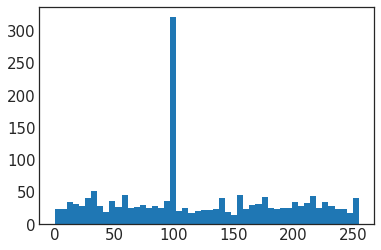

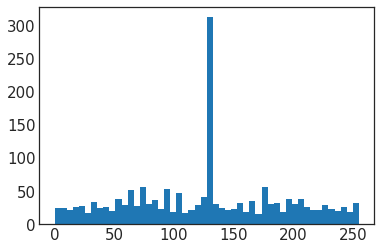

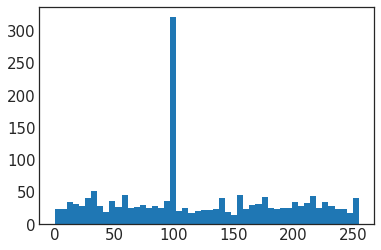

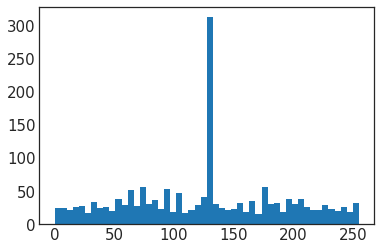

[[ 60 100]
 [ 89 159]
 [ 86 176]
 ...
 [227  35]
 [ 87  21]
 [217  69]]
{'60': 3, '89': 3, '86': 5, '56': 6, '195': 4, '123': 4, '176': 9, '13': 10, '101': 294, '192': 7, '255': 17, '163': 10, '12': 13, '75': 4, '175': 7, '129': 3, '104': 6, '162': 3, '164': 5, '229': 3, '11': 6, '210': 3, '198': 5, '204': 7, '22': 4, '23': 3, '83': 7, '214': 5, '187': 5, '185': 7, '21': 15, '95': 5, '74': 6, '41': 5, '28': 5, '145': 5, '107': 2, '178': 5, '70': 3, '20': 10, '119': 6, '54': 2, '152': 7, '125': 3, '124': 6, '51': 6, '5': 3, '184': 3, '212': 9, '39': 4, '8': 4, '114': 7, '133': 5, '76': 3, '81': 4, '112': 2, '244': 3, '243': 11, '153': 2, '38': 10, '139': 6, '201': 4, '117': 1, '59': 7, '254': 6, '177': 11, '132': 5, '27': 4, '151': 3, '30': 10, '170': 5, '121': 3, '52': 3, '98': 3, '106': 6, '218': 12, '130': 6, '169': 7, '71': 5, '2': 6, '80': 5, '142': 11, '135': 3, '238': 5, '147': 3, '161': 6, '62': 6, '179': 5, '46': 3, '3': 7, '25': 2, '63': 8, '197': 8, '9': 9, '94': 10, '167': 7

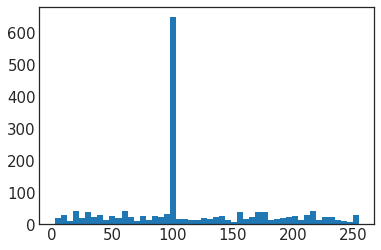

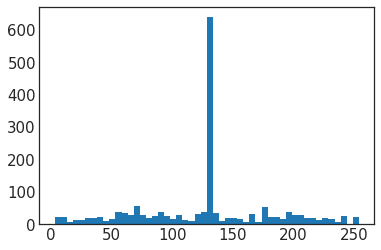

In [29]:
pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
pqconv3x3.train(wconv3x3)
print(pqconv3x3)
cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
for i in range(cconv3x3.shape[1]):
      _ = plt.hist(cconv3x3[:,i], bins=50)
      plt.show()
ccomnv3x3 = prune(cconv3x3)
for i in range(cconv3x3.shape[1]):
      _ = plt.hist(cconv3x3[:,i], bins=50)
      plt.show()

In [ ]:
# import sys
# from sys import argv
# from struct import *
# from numpy import savetxt, loadtxt

# pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
# pqconv3x3.train(wconv3x3_2)
# print(pqconv3x3)
# cconv3x3 = pqconv3x3.compute_codes(wconv3x3_2)
# print(sys.getsizeof(cconv3x3))
# savetxt('data.npy', cconv3x3)

# input_file="/content/drive/MyDrive/yono/data.npy"
# n = 8            
# maximum_table_size = pow(2,int(n))      
# file = open(input_file)                 
# data = file.read()                      

# # Building and initializing the dictionary.
# dictionary_size = 256                   
# dictionary = {chr(i): i for i in range(dictionary_size)}    
# string = ""             # String is null.
# compressed_data = []    # variable to store the compressed data.

# # iterating through the input symbols.
# # LZW Compression algorithm
# for symbol in data:                     
#     string_plus_symbol = string + symbol # get input symbol.
#     if string_plus_symbol in dictionary: 
#         string = string_plus_symbol
#     else:
#         compressed_data.append(dictionary[string])
#         if(len(dictionary) <= maximum_table_size):
#             dictionary[string_plus_symbol] = dictionary_size
#             dictionary_size += 1
#         string = symbol

# if string in dictionary:
#     compressed_data.append(dictionary[string])

# # storing the compressed string into a file (byte-wise).
# out = input_file.split(".")[0]
# output_file = open(out + ".lzw", "wb")
# for data in compressed_data:
#     output_file.write(pack('>H',int(data)))
    
# output_file.close()
# file.close()

<faiss.swigfaiss.ProductQuantizer; proxy of <Swig Object of type 'faiss::ProductQuantizer *' at 0x7f07bbd46f60> >
1056


In [ ]:
# import sys
# from sys import argv
# import struct
# from struct import *
# import numpy as np

# # taking the compressed file input and the number of bits from command line
# # defining the maximum table size
# # opening the compressed file
# # defining variables
# input_file="/content/drive/MyDrive/yono/data.lzw"
# n = 8            
# maximum_table_size = pow(2,int(n))
# file = open(input_file, "rb")
# compressed_data = []
# next_code = 256
# decompressed_data = ""
# string = ""

# # Reading the compressed file.
# while True:
#     rec = file.read(2)
#     if len(rec) != 2:
#         break
#     (data, ) = unpack('>H', rec)
#     compressed_data.append(data)

# print(sys.getsizeof(compressed_data))
# # Building and initializing the dictionary.
# dictionary_size = 256
# dictionary = dict([(x, chr(x)) for x in range(dictionary_size)])

# # iterating through the codes.
# # LZW Decompression algorithm
# for code in compressed_data:
#     if not (code in dictionary):
#         dictionary[code] = string + (string[0])
#     decompressed_data += dictionary[code]
#     if not(len(string) == 0):
#         dictionary[next_code] = string + (dictionary[code][0])
#         next_code += 1
#     string = dictionary[code]

# # storing the decompressed string into a file.
# out = input_file.split(".")[0]
# output_file = open(out + "_decoded.txt", "w")
# for data in decompressed_data:
#     output_file.write(data)

# # data = loadtxt('/content/drive/MyDrive/yono/data_decoded.txt')
# output_file.close()
# file.close()
# # file = open('/content/drive/MyDrive/yono/data_decoded.txt')
# # data = file.read()
# # with open('/content/drive/MyDrive/yono/data_decoded.txt', 'r') as file:
# #     data = file.read()
# file_data= np.loadtxt("/content/drive/MyDrive/yono/data_decoded.txt").astype(float32)
# # print(file_data)
# decconv3x3int = file_data.astype(np.uint8)
# print("decconv3x3int changed data type is : " , decconv3x3int.dtype)
# decconv3x3 = pqconv3x3.decode(decconv3x3int)
# print(decconv3x3)
# print("diff_D18M2_conv3x3 = ", ((wconv3x3_2-decconv3x3)**2).sum())




In [ ]:
# pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
# print(pqconv3x3)
# pqconv3x3.train(wconv3x3_2)
# savetxt('data.npy', cconv3x3)

# input_file="/content/drive/MyDrive/yono/data.npy"
# n = 8            
# maximum_table_size = pow(2,int(n))      
# file = open(input_file)                 
# data = file.read()                      

# # Building and initializing the dictionary.
# dictionary_size = 256                   
# dictionary = {chr(i): i for i in range(dictionary_size)}    
# string = ""             # String is null.
# compressed_data = []    # variable to store the compressed data.

# # iterating through the input symbols.
# # LZW Compression algorithm
# for symbol in data:                     
#     string_plus_symbol = string + symbol # get input symbol.
#     if string_plus_symbol in dictionary: 
#         string = string_plus_symbol
#     else:
#         compressed_data.append(dictionary[string])
#         if(len(dictionary) <= maximum_table_size):
#             dictionary[string_plus_symbol] = dictionary_size
#             dictionary_size += 1
#         string = symbol

# if string in dictionary:
#     compressed_data.append(dictionary[string])

# # storing the compressed string into a file (byte-wise).
# out = input_file.split(".")[0]
# output_file = open(out + ".lzw", "wb")
# for data in compressed_data:
#     output_file.write(pack('>H',int(data)))
    
# output_file.close()
# file.close()
# #
# input_file="/content/drive/MyDrive/yono/data.lzw"
# n = 8            
# maximum_table_size = pow(2,int(n))
# file = open(input_file, "rb")
# compressed_data = []
# next_code = 256
# decompressed_data = ""
# string = ""

# # Reading the compressed file.
# while True:
#     rec = file.read(2)
#     if len(rec) != 2:
#         break
#     (data, ) = unpack('>H', rec)
#     compressed_data.append(data)

# # Building and initializing the dictionary.
# dictionary_size = 256
# dictionary = dict([(x, chr(x)) for x in range(dictionary_size)])

# # iterating through the codes.
# # LZW Decompression algorithm
# for code in compressed_data:
#     if not (code in dictionary):
#         dictionary[code] = string + (string[0])
#     decompressed_data += dictionary[code]
#     if not(len(string) == 0):
#         dictionary[next_code] = string + (dictionary[code][0])
#         next_code += 1
#     string = dictionary[code]

# # storing the decompressed string into a file.
# out = input_file.split(".")[0]
# output_file = open(out + "_decoded.txt", "w")
# for data in decompressed_data:
#     output_file.write(data)

# # data = loadtxt('/content/drive/MyDrive/yono/data_decoded.txt')
# output_file.close()
# file.close()
# # file = open('/content/drive/MyDrive/yono/data_decoded.txt')
# # data = file.read()
# # with open('/content/drive/MyDrive/yono/data_decoded.txt', 'r') as file:
# #     data = file.read()
# file_data= np.loadtxt("/content/drive/MyDrive/yono/data_decoded.txt").astype(np.float32)
# # print(file_data)
# decconv3x3int = file_data.astype(np.uint8)
# decconv3x3 = pqconv3x3.decode(decconv3x3int)

In [ ]:
# def testModelAndCodebooks(args, model, lr, epoch, pqconv3x3, pqconv1x1, model_arch, dataset, device, train_loader, test_loader):
#     args.lr = lr
#     wconv3x3 = concatCertainWeightsAndReshape(model, model_arch+'WOInOut', 18, (3,3))
#     cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
#     decconv3x3 = pqconv3x3.decode(cconv3x3)

#     print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())

#     wconv1x1 = concatCertainWeightsAndReshape(model, model_arch+'WOInOut', 8, (1,1))
#     cconv1x1 = pqconv1x1.compute_codes(wconv1x1)
#     decconv1x1 = pqconv1x1.decode(cconv1x1)

#     print(f"diff_D8M2_{dataset}_conv1x1 = ", ((wconv1x1-decconv1x1)**2).sum())
    
#     pq_model = makePQModelMultiCodebooks(decconv3x3, decconv1x1, model_arch+'WOInOut', dataset, device, model)
#     print('\n===retrain classifier part')
#     pq_retrain(args, pq_model.to(device), model_arch, epoch, 2, device, train_loader, test_loader)
    
#     print('\n===retrain PQ part\n')
#     pq_retrain_pqpart(args, pq_model.to(device), model_arch, 1, 2, device, train_loader, test_loader)

#     wconv3x3_2 = concatCertainWeightsAndReshape(pq_model, model_arch+'WOInOut', 18, (3,3))
#     cconv3x3_2 = pqconv3x3.compute_codes(wconv3x3_2)
#     decconv3x3_2 = pqconv3x3.decode(cconv3x3_2)

#     print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3_2-decconv3x3_2)**2).sum())

#     wconv1x1_2 = concatCertainWeightsAndReshape(pq_model, model_arch+'WOInOut', 8, (1,1))
#     cconv1x1_2 = pqconv1x1.compute_codes(wconv1x1_2)
#     decconv1x1_2 = pqconv1x1.decode(cconv1x1_2)

#     print(f"diff_D8M2_{dataset}_conv1x1 = ", ((wconv1x1_2-decconv1x1_2)**2).sum())

#     pq_model_2 = makePQModelMultiCodebooks(decconv3x3_2, decconv1x1_2, model_arch+'WOInOut', dataset, device, pq_model)
#     print('\n===retrain classifier part')
#     pq_retrain(args, pq_model_2.to(device), model_arch, epoch, 2, device, train_loader, test_loader)   


# def getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device):
#     if 'AudioCNN' in model_arch:
#         wconv3x3 = concatModelWeightsAndReshape(model, model_arch+'WOFc', 18)
#         cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
        
#         decconv3x3 = pqconv3x3.decode(cconv3x3)
#         print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
#         pq_model = makePQModel(decconv3x3, model_arch+'WOFc', dataset, device, model)
#     else:
#         decconv3x3 = None
#         decconv1x1 = None
#         decfc = None
#         if pqconv3x3 is not None:
#             wconv3x3 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
#             cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
#             decconv3x3 = pqconv3x3.decode(cconv3x3)
#             print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
            
#         if pqconv1x1 is not None:
#             wconv1x1 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='conv')
#             cconv1x1 = pqconv1x1.compute_codes(wconv1x1)
#             decconv1x1 = pqconv1x1.decode(cconv1x1)
#             print(f"diff_D8M2_{dataset}_conv1x1 = ", ((wconv1x1-decconv1x1)**2).sum())
        
#         if pqfc is not None:
#             wfc = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=None,layer_type='fc')
#             cfc = pqfc.compute_codes(wfc)
#             decfc = pqfc.decode(cfc)
#             print(f"diff_D16M2_{dataset}_fc = ", ((wfc-decfc)**2).sum())

#         print("Shapes:")
#         print(decconv3x3.shape)
#         print(decconv1x1.shape)
#         pq_model = makePQModelMultiCodebooks(decconv3x3, decconv1x1, decfc, model_arch+'WOInOut', dataset, device, model)
#     return pq_model

# # 1. retrain 1 
# # 2. assignment update
# # 3. retrain 2 
# # 4. check if target accuracy is achieved.
# import copy
# def testModelAndCodebooksWTargetAcc(args,target_acc,model,lr,epoch,pqconv3x3,pqconv1x1,pqfc,model_arch,dataset,device,train_loader,test_loader,start_from_pretrained,reverse_tune):
#     n_layers_tune = 2
#     pq_model = copy.deepcopy(model)
#     for i in range(2):
#         print(f'\n\n===== Iteration Loop: {i+1}th =====\n')
#         args.lr = lr
#         # 1. 1st retrain
#         if start_from_pretrained == True:
#             pq_model = getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
#         else:
#             pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
            
#         print('\n===retrain classifier part')
#         pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
#         # 2. assignment update
#         print('\n===retrain PQ part\n')
#         pq_retrain_pqpart(args,pq_model.to(device),model_arch,1,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
#         # 3. 2nd retrain
#         pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
#         print('\n===retrain classifier part')
#         pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
#         # 4. check if target accuracy is achieved
#         print(f'Iteration Loop: {i+1}, n_layers_tune: {n_layers_tune}, Best Accuracy / Last Accuracy (Target Accuracy): {args.best_acc:.2f}% / {args.last_acc:.2f}% ({target_acc:.2f}%) at Epoch: {args.best_acc_epoch}')
#         # if args.best_acc > target_acc:
#         if args.last_acc > target_acc:
#             print('\n\n===== target accuracy is achieved =====')
#             break
#         else:
#             n_layers_tune += 1
#             print('\n\n===== target accuracy is NOT achieved =====')
#     return pq_model

In [ ]:
#DEFLATE
import zlib


def getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device):
    if 'AudioCNN' in model_arch:
        wconv3x3 = concatModelWeightsAndReshape(model, model_arch+'WOFc', 18)
        cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
        deflate_compress = zlib.compressobj(9, zlib.DEFLATED, -zlib.MAX_WBITS)
        compressed = deflate_compress.compress(cconv3x3) + deflate_compress.flush()
        # print(sys.getsizeof(compressed))
        decompressed = zlib.decompress(compressed, -zlib.MAX_WBITS)
        # print(type(decompressed))
        arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
        decomp_reshape= np.reshape(arr, (-1, 2))
        decconv3x3 = pqconv3x3.decode(decomp_reshape)
        print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
        pq_model = makePQModel(decconv3x3, model_arch+'WOFc', dataset, device, model)
    else:
        decconv3x3 = None
        decconv1x1 = None
        decfc = None
        if pqconv3x3 is not None:
            wconv3x3 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
            cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
            deflate_compress = zlib.compressobj(9, zlib.DEFLATED, -zlib.MAX_WBITS)
            compressed = deflate_compress.compress(cconv3x3) + deflate_compress.flush()
            # print(sys.getsizeof(compressed))
            decompressed = zlib.decompress(compressed, -zlib.MAX_WBITS)
            # print(type(decompressed))
            arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
            decomp_reshape= np.reshape(arr, (-1, 2))
            decconv3x3 = pqconv3x3.decode(decomp_reshape)
            print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
            
        if pqconv1x1 is not None:
            wconv1x1 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='conv')
            cconv1x1 = pqconv1x1.compute_codes(wconv1x1)
            deflate_compress = zlib.compressobj(9, zlib.DEFLATED, -zlib.MAX_WBITS)
            compressed = deflate_compress.compress(cconv1x1) + deflate_compress.flush()
            # print(sys.getsizeof(compressed))
            decompressed = zlib.decompress(compressed, -zlib.MAX_WBITS)
            # print(type(decompressed))
            arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
            decomp_reshape= np.reshape(arr, (-1, 2))
            decconv1x1 = pqconv1x1.decode(decomp_reshape)
            print(f"diff_D8M2_{dataset}_conv1x1 = ", ((wconv1x1-decconv1x1)**2).sum())
        
        if pqfc is not None:
            wfc = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=None,layer_type='fc')
            cfc = pqfc.compute_codes(wfc)
            deflate_compress = zlib.compressobj(9, zlib.DEFLATED, -zlib.MAX_WBITS)
            compressed = deflate_compress.compress(cfc) + deflate_compress.flush()
            # print(sys.getsizeof(compressed))
            decompressed = zlib.decompress(compressed, -zlib.MAX_WBITS)
            # print(type(decompressed))
            arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
            decomp_reshape= np.reshape(arr, (-1, 2))
            decfc = pqfc.decode(decomp_reshape)
            print(f"diff_D16M2_{dataset}_fc = ", ((wfc-decfc)**2).sum())

        # print(decfc.shape)
        print(decconv3x3.shape)
        pq_model = makePQModelMultiCodebooks(decconv3x3, decconv1x1, decfc, model_arch+'WOInOut', dataset, device, model)
    return pq_model

# 1. retrain 1 
# 2. assignment update
# 3. retrain 2 
# 4. check if target accuracy is achieved.
import copy
def testModelAndCodebooksWTargetAcc(args,target_acc,model,lr,epoch,pqconv3x3,pqconv1x1,pqfc,model_arch,dataset,device,train_loader,test_loader,start_from_pretrained,reverse_tune):
    n_layers_tune = 2
    pq_model = copy.deepcopy(model)
    for i in range(2):
        print(f'\n\n===== Iteration Loop: {i+1}th =====\n')
        args.lr = lr
        # 1. 1st retrain
        if start_from_pretrained == True:
            pq_model = getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        else:
            pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
            
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 2. assignment update
        print('\n===retrain PQ part\n')
        pq_retrain_pqpart(args,pq_model.to(device),model_arch,1,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 3. 2nd retrain
        pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 4. check if target accuracy is achieved
        print(f'Iteration Loop: {i+1}, n_layers_tune: {n_layers_tune}, Best Accuracy / Last Accuracy (Target Accuracy): {args.best_acc:.2f}% / {args.last_acc:.2f}% ({target_acc:.2f}%) at Epoch: {args.best_acc_epoch}')
        # if args.best_acc > target_acc:
        if args.last_acc > target_acc:
            print('\n\n===== target accuracy is achieved =====')
            break
        else:
            n_layers_tune += 1
            print('\n\n===== target accuracy is NOT achieved =====')
    return pq_model

In [ ]:
print('\ntest accuracy of Lee datasets')
# test(args, mnist.to(device), device, test_loader_mnist)
test(args, cifar10.to(device), device, test_loader_cifar10)
# test(args, svhn.to(device), device, test_loader_svhn)
test(args, gtsrb.to(device), device, test_loader_gtsrb)
test(args, gsc.to(device), device, test_loader_gsc)

# print('\ntest accuracy of additional trained datasets')
# test(args, hhar.to(device), device, test_loader_hhar)
# test(args, ninadb2.to(device), device, test_loader_ninadb2)

# print('\ntest accuracy of unseen datasets')
# test(args, fmnist.to(device), device, test_loader_fmnist)
# test(args, stl10.to(device), device, test_loader_stl10)

# test(args, emotion.to(device), device, test_loader_emotion)
# test(args, urbansound.to(device), device, test_loader_urbansound)
# test(args, pamap2.to(device), device, test_loader_pamap2)
# test(args, skoda.to(device), device, test_loader_skoda)
# test(args, ninadb3.to(device), device, test_loader_ninadb3)
# test(args, ninadb6.to(device), device, test_loader_ninadb6)


test accuracy of Lee datasets

Test set: Average loss: 0.3494, Accuracy: 9005/10000 (90.05%)
New Best Accuracy: (90.05%) at Epoch: (4)


Test set: Average loss: 0.0882, Accuracy: 12314/12630 (97.50%)
New Best Accuracy: (97.50%) at Epoch: (4)


Test set: Average loss: 0.4300, Accuracy: 4437/4890 (90.74%)


In [16]:
# import matplotlib.pyplot as plt
# import numpy as np
# # from numpy import savetxt

# # print(wconv3x3_2)
# def prune(cconv3x3):  
#   # pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
#   # # print(pqconv3x3)
#   # pqconv3x3.train(concat_data)
#   # arr = pqconv3x3.compute_codes(concat_data)
#   print("Array is:",cconv3x3.shape)
#   for i in range(cconv3x3.shape[1]):
#       _ = plt.hist(cconv3x3[:,i], bins=50)
#       plt.show()
#   # print(arr.dtype)
#   # pqconv3x3 = faiss.ProductQuantizer(16, 2, 8)
#   # # print(pqconv3x3)
#   # pqconv3x3.train(wfc)
#   # arr2 = pqconv3x3.compute_codes(wfc)
#   # print(arr2.shape)
#   # arr= np.concatenate((arr1,arr2),axis=0)
#   # for i in range(arr.shape[1]):
#   #     _ = plt.hist(arr[:,i], bins=50)
#   #     plt.show()
#   # print(arr)
#   # savetxt('arr.npy',arr)
#   # print(arr)
#   # arr = faiss.vector_to_array(pqconv3x3.centroids).reshape(pqconv3x3.M, pqconv3x3.ksub, pqconv3x3.dsub)
#   # arr = np.random.randint(10,90,(2, 256, 9))
#   My_dict = {}
#   cordinate_pairs = []
#   for j  in range (cconv3x3.shape[0]):
#     # print(j)
#     elements = [cconv3x3[j,0], cconv3x3[j,1]]
#     # print(elements)
#     cordinate_pairs.append(elements)

#   # print(len(cordinate_pairs))

#   frequencyDict = {}
#   newfreqDict= {}
#   visited = []
#   newVisited =[]

#   # listLength = len(cordinate_pairs)
#   # for i in range(listLength):
#   #     if str(cordinate_pairs[i]) in visited:
#   #         frequencyDict[str(cordinate_pairs[i])] += 1
#   #     else:
#   #         pair = str(cordinate_pairs[i])
#   #         # print(str(pair))
#   #         visited.append(pair)
#   #         frequencyDict[pair] = 1

#   listLength = len(cconv3x3)
#   for i in range(listLength):
#       if str(cconv3x3[i,0]) in visited:
#           frequencyDict[str(cconv3x3[i,0])] += 1
#       else:
#           pair = str(cconv3x3[i,0])
#           # print(str(pair))
#           visited.append(pair)
#           frequencyDict[pair] = 1
#   print(frequencyDict) 

#   new_value = max(frequencyDict, key=frequencyDict.get)
#   print("Highest value from dictionary:",new_value)

#   for i in range(listLength):
#       if str(cconv3x3[i,1]) in newVisited:
#           newfreqDict[str(cconv3x3[i,1])] += 1
#       else:
#           pair = str(cconv3x3[i,1])
#           # print(str(pair))
#           newVisited.append(pair)
#           newfreqDict[pair] = 1
#   print(newfreqDict) 

#   new_value2 = max(newfreqDict, key=newfreqDict.get)
#   print("Highest value from dictionary:",new_value2)

#   # for i in range(listLength):
#   #   if str(arr[i,0])==int(new_value) or str(arr[i,1])==int(new_value2):
#   #     break
#   #   else:
#   #     np.delete(arr,i)
#   array=np.empty(0)
#   for i in cconv3x3:
#     if i[0]==int(new_value) or i[1]==int(new_value2):
#       array = np.append(array,i)
#     else:
#       continue


#   array = array.astype(np.uint8)
#   size= (array.shape[0])/2
#   # array = np.reshape(array,(size, 2))
#   arrayer = array.reshape(int(size),2)
#   # print(arrayer)
#   # decconv3x3 = pqconv3x3.decode(arrayer)
#   # print(arrayer.shape)
#   return arrayer

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# from numpy import savetxt

# print(wconv3x3_2)
def prune(arr):  
  for i in range(arr.shape[1]):
      _ = plt.hist(arr[:,i], bins=50)
      plt.show()
  print(arr)
  
  My_dict = {}
  cordinate_pairs = []
  for j  in range (arr.shape[0]):
    elements = [arr[j,0], arr[j,1]]
    cordinate_pairs.append(elements)


  frequencyDict = {}
  newfreqDict= {}
  visited = []
  newVisited =[]



  listLength = len(arr)
  for i in range(listLength):
      if str(arr[i,0]) in visited:
          frequencyDict[str(arr[i,0])] += 1
      else:
          pair = str(arr[i,0])
          # print(str(pair))
          visited.append(pair)
          frequencyDict[pair] = 1
  print(frequencyDict) 

  new_value = max(frequencyDict, key=frequencyDict.get)
  print("Highest value from dictionary:",new_value)

  for i in range(listLength):
      if str(arr[i,1]) in newVisited:
          newfreqDict[str(arr[i,1])] += 1
      else:
          pair = str(arr[i,1])
          # print(str(pair))
          newVisited.append(pair)
          newfreqDict[pair] = 1
  print(newfreqDict) 

  new_value2 = max(newfreqDict, key=newfreqDict.get)
  print("Highest value from dictionary:",new_value2)


  for i in arr:
    if frequencyDict[str(i[0])]<5:
      i[0]=new_value
    else:
      continue

  for i in arr:
    if newfreqDict[str(i[1])]<5:
      i[1]=new_value2
    else:
      continue

  return arr

In [17]:
def encodebin(bin_string):
    # Split the string of 1s and 0s into lengths of 6.
    chunks = [bin_string[i:i+6] for i in range(0, len(bin_string), 6)]
    # Store the length of the last chunk so that we can add that as the last bit
    # of data so that we know how much to pad the last chunk when decoding.
    last_chunk_length = len(chunks[-1])
    # Convert each chunk from binary into a decimal
    decimals = [int(chunk, 2) for chunk in chunks]
    # Add the length of our last chunk to our list of decimals.
    decimals.append(last_chunk_length)
    # Produce an ascii string by using each decimal as an index of our charset.
    ascii_string = ''.join([charset[i] for i in decimals])

    return ascii_string

def decodebin(ascii_string):
    # Convert each character to a decimal using its index in the charset.
    decimals = [charset.index(char) for char in ascii_string]
    # Take last decimal which is the final chunk length, and the second to last
    # decimal which is the final chunk, and keep them for later to be padded
    # appropriately and appended.
    last_chunk_length, last_decimal = decimals.pop(-1), decimals.pop(-1)
    # Take each decimal, convert it to a binary string (removing the 0b from the
    # beginning, and pad it to 6 digits long.
    bin_string = ''.join([bin(decimal)[2:].zfill(6) for decimal in decimals])
    # Add the last decimal converted to binary padded to the appropriate length
    bin_string += bin(last_decimal)[2:].zfill(last_chunk_length)

    return bin_string

In [37]:
class HuffmanNode :
    #constructor, Time O(1) Space O(1)
    def __init__(self, ch, frequency,  left,   right) :
        self.ch = ch
        self.frequency = frequency
        self.left = left
        self.right = right
 
    # Time O(1) Space O(1)
    def __str__(self):
    	return "(" + str(self.ch) + ", " + str(self.frequency) + ")"  
 
class HuffmanCoding :
 
    # All steps to create huffman code
    def getCode(self, input) :
        freqMap = self.buildFrequencyMap(input) 
        nodeQueue = self.sortByFrequence(freqMap)
        self.root = self.buildTree(nodeQueue)
        codeMap = self.createHuffmanCode(self.root)
        return codeMap
 
    #Step 1: Create char frequency map from input string, Time O(s) Space O(m), 
	#s is number of chars in input string, m is number of unique chars
    def buildFrequencyMap(self, input) :
        map = {}
        for c in input:
            map[c] = map.get(c,0) + 1
        return map
 
    #Step 2: Create queue of nodes from map and sort by frequency, Time O(mlogm) Space O(m)
    def sortByFrequence(self, map) :
        queue = []
        for k, v in map.items():
            queue.append(HuffmanNode(k, v, None, None))       
        queue.sort(key = lambda x: x.frequency)
        return queue  
 
    #Step 3: Build frequency-sorted binary tree from sorted queue, return root
    #Time O(m) Space O(n), m is unique chars in string, n is nodes in tree n=2m-1    
    def buildTree(self, nodeQueue) :             
        while len(nodeQueue) > 1:
            node1 = nodeQueue.pop(0)
            node2 = nodeQueue.pop(0)
            node = HuffmanNode('', node1.frequency + node2.frequency, node1, node2)
            nodeQueue.append(node)
        return nodeQueue.pop(0)
 
	#Step 4: Create Huffman code map by preorder of the tree, Time O(n) Space O(m+n)
    def createHuffmanCode(self, node) :
        map = {}
        self.createCodeRec(node, map, "")
        return map
    
    #Preorder of the tree using recursion, Time O(n) Space O(n)
    def createCodeRec(self, node, map, s) :
        if node.left == None and node.right == None :
            map[node.ch] = s
            return
        self.createCodeRec(node.left, map, s + '0')
        self.createCodeRec(node.right, map, s + '1')
 
    # Use huffman code to encode the input string, Time O(s) Space O(o), 
    # s is input string length, o is output string length
    def encode(self, codeMap, input) :
        s = ""
        print(input)
        for  i in range(0, len(input)):
            s += codeMap.get(input[i])
        return s
    

    #Time O(o), Space O(s), o is coded message length, s is original message input
    def decode(self,codeMap, coded) :
        # s = []
        # curr = self.root
        # for  i in range (0, len(coded)) :
        #     # print(coded[i])
        #     curr = curr.right if coded[i] == '1' else curr.left
        #     if curr.left == None and curr.right == None:
        #         s += str(curr.ch)
        #         curr = self.root 
        for i in encoded[::8]:
          print(self.getKeysByValue(codeMap,i))
        return res
def getKeysByValue(dictOfElements, valueToFind):
      # listOfKeys = list()
      s=0
      # print(dictOfElements.items())
      listOfItems = dictOfElements.items()
      for item in listOfItems:
          if item[1] == valueToFind:
              s=item[0]
      return s


# pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
# pqconv3x3.train(wconv3x3)
def huffman_number(cconv3x3):
  # cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
  # cconv3x3 = prune(cconv3x3)
  print("input",cconv3x3.shape)
  my_string = cconv3x3.reshape(-1)
  huffman = HuffmanCoding()       
  codeMap = huffman.getCode(my_string)
  # print(codeMap[51])
  value_at_index = list(codeMap.values())[0]
  print(value_at_index)
  print("code: " + str(codeMap))
  encoded = huffman.encode(codeMap, my_string)
  print("encode message: " + encoded)
  charset = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-_'
  encoded = encodebin(encoded)
  uncompressed_file_size = sys.getsizeof(cconv3x3)
  compressed_file_size = sys.getsizeof(encoded)
  print("Your original file size was", uncompressed_file_size,"bits. The compressed size is:",compressed_file_size)
  print("This is a saving of ",uncompressed_file_size-compressed_file_size,"bits")
  # decode = huffman.decode(str(codeMap),encoded)
  encoded = decodebin(encoded)
  n=""
  s=[]
  p=0
  for i in encoded:
      n+=i
      if len(n)==8:
        x=getKeysByValue(codeMap,n)
        s.append(x)
        n=""
        p+=1
      else:
        continue
  d=np.array(s)
  print(d)
  d=d.reshape(cconv3x3.shape[0],cconv3x3.shape[1])
  print(d)
  print((cconv3x3==d).all())
  return d

In [16]:
#GZIP
import zlib

def getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device):
    if 'AudioCNN' in model_arch:
        wconv3x3 = concatModelWeightsAndReshape(model, model_arch+'WOFc', 18)
        
        cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
        # cconv3x3P = prune(cconv3x3)
        gzip_compress = zlib.compressobj(9, zlib.DEFLATED, zlib.MAX_WBITS | 16)
        compressed = gzip_compress.compress(cconv3x3) + gzip_compress.flush()
        decompressed = None
        decompressed = zlib.decompress(compressed, zlib.MAX_WBITS|16)
        arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
        decomp_reshape= np.reshape(arr, (-1, 2))
        decconv3x3 = pqconv3x3.decode(decomp_reshape)
        # decconv3x3 = pqconv3x3.decode(cconv3x3h)
        # print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
        pq_model = makePQModel(decconv3x3, model_arch+'WOFc', dataset, device, model)
    else:
        decconv3x3 = None
        decconv1x1 = None
        decfc = None
        if pqconv3x3 is not None:
            wconv3x3 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
            # cconv3x3 = prune(wconv3x3)
            # print(cconv3x3.shape)
            cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
            print("shape:",cconv3x3.shape)
            # cconv3x3P = prune(cconv3x3)
            # print(cconv3x3P.shape)
            gzip_compress = zlib.compressobj(9, zlib.DEFLATED, zlib.MAX_WBITS | 16)
            compressed = gzip_compress.compress(cconv3x3) + gzip_compress.flush()
            decompressed = None
            decompressed = zlib.decompress(compressed, zlib.MAX_WBITS|16)
            arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
            decomp_reshape= np.reshape(arr, (-1, 2))
            decconv3x3 = pqconv3x3.decode(decomp_reshape)
            # decconv3x3 = pqconv3x3.decode(cconv3x3h)
            # print(cconv3x3.shape)
            # print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
            
        if pqconv1x1 is not None:
            wconv1x1 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='conv')
            cconv1x1 = pqconv1x1.compute_codes(wconv1x1)
            # print(cconv1x1.shape)
            # cconv1x1P = prune(cconv1x1)
            gzip_compress = zlib.compressobj(9, zlib.DEFLATED, zlib.MAX_WBITS | 16)
            compressed = gzip_compress.compress(cconv1x1) + gzip_compress.flush()
            decompressed = None
            decompressed = zlib.decompress(compressed, zlib.MAX_WBITS|16)
            arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
            decomp_reshape= np.reshape(arr, (-1, 2))
            decconv1x1 = pqconv3x3.decode(decomp_reshape)
            # decconv1x1 = pqconv1x1.decode(cconv1x1h)
            # print(f"diff_D8M2_{dataset}_conv1x1 = ", ((wconv1x1-decconv1x1)**2).sum())
        
        if pqfc is not None:
            wfc = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
            # cfc = prune(wfc)
            cfc = pqfc.compute_codes(wfc)
            # cfcP = prune(cfc)
            gzip_compress = zlib.compressobj(9, zlib.DEFLATED, zlib.MAX_WBITS | 16)
            compressed = gzip_compress.compress(cfc) + gzip_compress.flush()
            decompressed = None
            decompressed = zlib.decompress(compressed, zlib.MAX_WBITS|16)
            arr=np.frombuffer(decompressed, dtype=cconv3x3.dtype)
            decomp_reshape= np.reshape(arr, (-1, 2))
            decfc = pqconv3x3.decode(decomp_reshape)
            # decfc = pqfc.decode(cfch)
            # print(f"diff_D16M2_{dataset}_fc = ", ((wfc-decfc)**2).sum())

        # print(decfc.shape)
        # print(decconv3x3.shape)
        pq_model = makePQModelMultiCodebooks(decconv3x3, decconv1x1, decfc, model_arch+'WOInOut', dataset, device, model)
    return pq_model

# 1. retrain 1 
# 2. assignment update
# 3. retrain 2 
# 4. check if target accuracy is achieved.
import copy
def testModelAndCodebooksWTargetAccG(args,target_acc,model,lr,epoch,pqconv3x3,pqconv1x1,pqfc,model_arch,dataset,device,train_loader,test_loader,start_from_pretrained,reverse_tune):
    n_layers_tune = 2
    pq_model = copy.deepcopy(model)
    for i in range(2):
        print(f'\n\n===== Iteration Loop: {i+1}th =====\n')
        args.lr = lr
        # 1. 1st retrain
        if start_from_pretrained == True:
            pq_model = getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        else:
            pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
            
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 2. assignment update
        print('\n===retrain PQ part\n')
        pq_retrain_pqpart(args,pq_model.to(device),model_arch,1,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 3. 2nd retrain
        pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 4. check if target accuracy is achieved
        print(f'Iteration Loop: {i+1}, n_layers_tune: {n_layers_tune}, Best Accuracy / Last Accuracy (Target Accuracy): {args.best_acc:.2f}% / {args.last_acc:.2f}% ({target_acc:.2f}%) at Epoch: {args.best_acc_epoch}')
        # if args.best_acc > target_acc:
        if args.last_acc > target_acc:
            print('\n\n===== target accuracy is achieved =====')
            break
        else:
            n_layers_tune += 1
            print('\n\n===== target accuracy is NOT achieved =====')
    return pq_model

In [18]:
#Huffman
import zlib

def getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device):
    if 'AudioCNN' in model_arch:
        wconv3x3 = concatModelWeightsAndReshape(model, model_arch+'WOFc', 18)
        
        cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
        cconv3x3 = prune(cconv3x3)
        decomp_reshape=comp_decomp(cconv3x3)
        decconv3x3 = pqconv3x3.decode(decomp_reshape)
        # decconv3x3 = pqconv3x3.decode(cconv3x3h)
        # print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
        pq_model = makePQModel(decconv3x3, model_arch+'WOFc', dataset, device, model)
    else:
        decconv3x3 = None
        decconv1x1 = None
        decfc = None
        if pqconv3x3 is not None:
            wconv3x3 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
            # cconv3x3 = prune(wconv3x3)
            # print(cconv3x3.shape)
            cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
            cconv3x3 = prune(cconv3x3)
            decomp_reshape=comp_decomp(cconv3x3)
            decconv3x3 = pqconv3x3.decode(decomp_reshape)
            # decconv3x3 = pqconv3x3.decode(cconv3x3h)
            # print(cconv3x3.shape)
            # print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
            
        if pqconv1x1 is not None:
            wconv1x1 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='conv')
            cconv1x1 = pqconv1x1.compute_codes(wconv1x1)
            cconv3x3 = prune(cconv1x1)
            decomp_reshape=comp_decomp(cconv3x3)
            decconv1x1 = pqconv3x3.decode(decomp_reshape)
            # decconv1x1 = pqconv1x1.decode(cconv1x1h)
            # print(f"diff_D8M2_{dataset}_conv1x1 = ", ((wconv1x1-decconv1x1)**2).sum())
        
        if pqfc is not None:
            wfc = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
            # cfc = prune(wfc)
            cfc = pqfc.compute_codes(wfc)
            cconv3x3 = prune(cfc)
            decomp_reshape=comp_decomp(cconv3x3)
            decfc = pqconv3x3.decode(decomp_reshape)
            # decfc = pqfc.decode(cfch)
            # print(f"diff_D16M2_{dataset}_fc = ", ((wfc-decfc)**2).sum())

        # print(decfc.shape)
        # print(decconv3x3.shape)
        pq_model = makePQModelMultiCodebooks(decconv3x3, decconv1x1, decfc, model_arch+'WOInOut', dataset, device, model)
    return pq_model

# 1. retrain 1 
# 2. assignment update
# 3. retrain 2 
# 4. check if target accuracy is achieved.
import copy
def testModelAndCodebooksWTargetAcc(args,target_acc,model,lr,epoch,pqconv3x3,pqconv1x1,pqfc,model_arch,dataset,device,train_loader,test_loader,start_from_pretrained,reverse_tune):
    n_layers_tune = 2
    pq_model = copy.deepcopy(model)
    for i in range(2):
        print(f'\n\n===== Iteration Loop: {i+1}th =====\n')
        args.lr = lr
        # 1. 1st retrain
        if start_from_pretrained == True:
            pq_model = getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        else:
            pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
            
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 2. assignment update
        print('\n===retrain PQ part\n')
        pq_retrain_pqpart(args,pq_model.to(device),model_arch,1,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 3. 2nd retrain
        pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 4. check if target accuracy is achieved
        print(f'Iteration Loop: {i+1}, n_layers_tune: {n_layers_tune}, Best Accuracy / Last Accuracy (Target Accuracy): {args.best_acc:.2f}% / {args.last_acc:.2f}% ({target_acc:.2f}%) at Epoch: {args.best_acc_epoch}')
        # if args.best_acc > target_acc:
        if args.last_acc > target_acc:
            print('\n\n===== target accuracy is achieved =====')
            break
        else:
            n_layers_tune += 1
            print('\n\n===== target accuracy is NOT achieved =====')
    return pq_model

In [ ]:
import re

pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
pqconv3x3.train(wconv3x3)
cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
# cconv3x3 = prune(cconv3x3)
my_string = cconv3x3.reshape(-1)
print(len(my_string))
letters = []
only_letters = []
for letter in my_string:
    if letter not in letters:
        frequency = np.count_nonzero(my_string == letter)            #frequency of each letter repetition
        letters.append(frequency)
        letters.append(letter)
        only_letters.append(letter)
print(letters)
c=0

nodes = []
while len(letters) > 0:
    c=c+letters[0:2][0]
    nodes.append(letters[0:2])
    letters = letters[2:]                               # sorting according to frequency
nodes.sort()
huffman_tree = []
huffman_tree.append(nodes)                             #Make each unique character as a leaf node
print(c)



def combine_nodes(nodes):
    pos = 0
    newnode = []
    if len(nodes) > 1:
        nodes.sort()
        nodes[pos].append("1")                       # assigning values 1 and 0
        nodes[pos+1].append("0")
        combined_node1 = (nodes[pos] [0] + nodes[pos+1] [0])
        combined_node2 = (nodes[pos] [1] + nodes[pos+1] [1])  # combining the nodes to generate pathways
        newnode.append(combined_node1)
        newnode.append(combined_node2)
        newnodes=[]
        newnodes.append(newnode)
        newnodes = newnodes + nodes[2:]
        nodes = newnodes
        huffman_tree.append(nodes)
        combine_nodes(nodes)
    return huffman_tree                                     # huffman tree generation

newnodes = combine_nodes(nodes)
print(newnodes)
huffman_tree.sort(reverse = True)
print("Huffman tree with merged pathways:")
count=0
checklist = []
for level in huffman_tree:
    for node in level:
        count +=node[0]
        if node not in checklist:
            checklist.append(node)
        else:
            level.remove(node)
print(count)
count = 0
for level in huffman_tree:
    print("Level", count,":",level)             #print huffman tree
    count+=1

# node =[str(item) for item in node]
# print(type(node[1]))
# only_letters = [str(item) for item in only_letters]

letter_binary = []
if len(only_letters) == 1:
    lettercode = [only_letters[0], "0"]
    letter_binary.append(lettercode*len(my_string))
else:
    for letter in only_letters:
        print(letter)
        code =""
        for node in checklist:
            # print(node)
            if len (node)>2 and letter in node:         #genrating binary code
                code = code + str(node[2])
        lettercode =[letter,code]
        letter_binary.append(lettercode)
print(letter_binary)
# print("Binary code generated:")
# for letter in letter_binary:
#     print(letter[0], letter[1])

bitstring =""
for character in my_string:
    for item in letter_binary:
        if character == item[0]:
            bitstring = bitstring + item[1]
binary ="0b"+bitstring
print(binary)
print("Your message as binary is:")
uncompressed_file_size = len(my_string)*7
compressed_file_size = len(binary)-2
print("Your original file size was", uncompressed_file_size,"bits. The compressed size is:",compressed_file_size)
print("This is a saving of ",uncompressed_file_size-compressed_file_size,"bits")

bitstring = binary[2:]
# print(letter_binary)
# uncompressed_string =""
code =""
uncomp_list=np.empty(0)
for digit in bitstring:
    code = code+digit
    pos=0                   
                                           #iterating and decoding
    for letter in letter_binary:
        # print(code == letter[1])  
        if code == letter[1]:
            # print(letter_binary[pos] [0])
            np.append(uncomp_list,letter_binary[pos][0])
            code=""
        pos+=1
# new_array=np.array(list(uncompressed_string))
print(uncomp_list.shape)
# temp = re.findall(r'\d+', uncompressed_string)
# res = list(map(int, temp))
# res = np.array(res)
# res = res.astype(np.uint8)
# res = res.reshape(cconv3x3.shape[0],cconv3x3.shape[1])
# print((cconv3x3==res).all())

## Lee's data results



===== Iteration Loop: 1th =====

torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
feat.shape:  (1, 5760)
reshaped_feat.shape:  (320, 18)


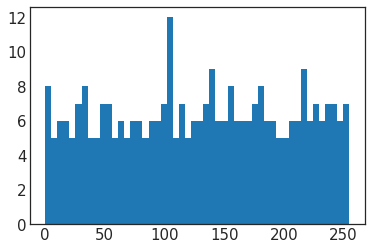

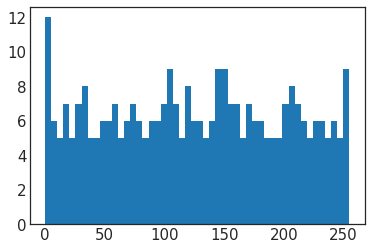

[[164 164]
 [250 250]
 [175 175]
 [246 246]
 [  5   5]
 [170 170]
 [142 142]
 [189 189]
 [ 90  90]
 [158 158]
 [128 128]
 [ 75  75]
 [ 68  68]
 [ 27 146]
 [  2   2]
 [ 67  67]
 [ 69  69]
 [ 15  15]
 [124 124]
 [210 210]
 [202 202]
 [ 74  74]
 [159 159]
 [ 57  57]
 [ 63  63]
 [ 21  21]
 [191 191]
 [193 193]
 [182 242]
 [146 146]
 [ 88  88]
 [235 158]
 [127 127]
 [224 224]
 [ 20  20]
 [ 41  41]
 [238 238]
 [154 154]
 [251 251]
 [219  31]
 [ 99   0]
 [ 76 200]
 [ 27  27]
 [ 76  76]
 [203 203]
 [ 79  79]
 [ 10  10]
 [174 174]
 [217 217]
 [230 230]
 [211 211]
 [ 38  38]
 [152 214]
 [ 34  34]
 [153 153]
 [130 130]
 [122 122]
 [226 226]
 [ 46 144]
 [166 166]
 [228 228]
 [213 213]
 [157 157]
 [ 93  93]
 [ 97  97]
 [217 159]
 [223 223]
 [ 92  92]
 [ 39  39]
 [105  92]
 [105 253]
 [ 32  32]
 [ 78  78]
 [ 77  77]
 [248 248]
 [ 22  22]
 [ 99  99]
 [ 82  82]
 [163 163]
 [  6   6]
 [184 183]
 [ 30  30]
 [103 103]
 [208 208]
 [118 118]
 [240 240]
 [116 177]
 [ 83  83]
 [227 227]
 [220 220]
 [ 23  23]

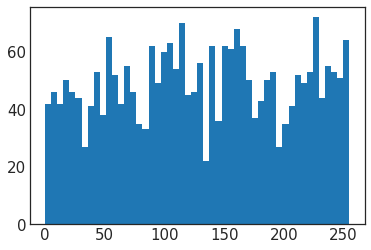

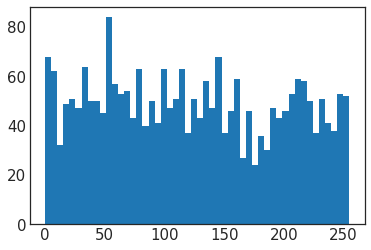

[[247 205]
 [ 29 176]
 [193 154]
 ...
 [166  46]
 [  3  88]
 [ 29 124]]
{'247': 4, '29': 4, '193': 9, '220': 7, '213': 11, '112': 7, '154': 7, '27': 7, '20': 6, '207': 6, '122': 10, '54': 14, '156': 4, '187': 7, '238': 3, '90': 17, '242': 10, '182': 3, '73': 4, '94': 5, '180': 8, '248': 9, '151': 7, '129': 3, '217': 4, '74': 5, '47': 4, '244': 8, '41': 12, '245': 10, '212': 5, '254': 4, '240': 12, '34': 9, '62': 5, '185': 7, '131': 16, '148': 8, '123': 5, '89': 17, '176': 11, '51': 8, '104': 4, '150': 14, '102': 9, '28': 6, '88': 10, '186': 10, '82': 3, '204': 11, '202': 2, '199': 4, '172': 12, '80': 4, '14': 4, '250': 12, '177': 8, '190': 9, '224': 21, '223': 12, '120': 6, '231': 14, '79': 1, '40': 14, '222': 12, '236': 8, '135': 1, '61': 16, '147': 4, '118': 8, '121': 7, '21': 11, '183': 13, '233': 7, '241': 8, '232': 5, '195': 1, '209': 4, '215': 4, '25': 1, '66': 2, '221': 1, '85': 4, '103': 11, '174': 13, '60': 4, '125': 4, '229': 21, '1': 8, '237': 12, '35': 3, '251': 13, '191': 

100%|██████████| 469/469 [00:11<00:00, 42.19it/s]



Test set: Average loss: 2.1828, Accuracy: 1773/10000 (17.73%)
New Best Accuracy: (17.73%) at Epoch: (1)

Epoch:     2


100%|██████████| 469/469 [00:11<00:00, 42.21it/s]



Test set: Average loss: 1.9922, Accuracy: 3736/10000 (37.36%)
New Best Accuracy: (37.36%) at Epoch: (2)

Epoch:     3


100%|██████████| 469/469 [00:11<00:00, 41.98it/s]



Test set: Average loss: 1.8642, Accuracy: 3349/10000 (33.49%)
Epoch:     4


100%|██████████| 469/469 [00:11<00:00, 42.60it/s]



Test set: Average loss: 1.7635, Accuracy: 3647/10000 (36.47%)
Epoch:     5


100%|██████████| 469/469 [00:11<00:00, 42.02it/s]



Test set: Average loss: 1.6829, Accuracy: 3906/10000 (39.06%)
New Best Accuracy: (39.06%) at Epoch: (5)

Epoch:     6


100%|██████████| 469/469 [00:11<00:00, 41.72it/s]



Test set: Average loss: 1.6377, Accuracy: 4177/10000 (41.77%)
New Best Accuracy: (41.77%) at Epoch: (6)

Epoch:     7


100%|██████████| 469/469 [00:11<00:00, 42.46it/s]



Test set: Average loss: 1.6008, Accuracy: 4109/10000 (41.09%)
Epoch:     8


100%|██████████| 469/469 [00:11<00:00, 41.94it/s]



Test set: Average loss: 1.5264, Accuracy: 4304/10000 (43.04%)
New Best Accuracy: (43.04%) at Epoch: (8)

Epoch:     9


100%|██████████| 469/469 [00:11<00:00, 42.09it/s]



Test set: Average loss: 1.5167, Accuracy: 4410/10000 (44.10%)
New Best Accuracy: (44.10%) at Epoch: (9)

Epoch:    10


100%|██████████| 469/469 [00:11<00:00, 41.57it/s]



Test set: Average loss: 1.4900, Accuracy: 4293/10000 (42.93%)

===retrain PQ part

Epoch:     1


100%|██████████| 469/469 [00:11<00:00, 42.37it/s]



Test set: Average loss: 1.4980, Accuracy: 5104/10000 (51.04%)
New Best Accuracy: (51.04%) at Epoch: (1)

torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
feat.shape:  (1, 5760)
reshaped_feat.shape:  (320, 18)


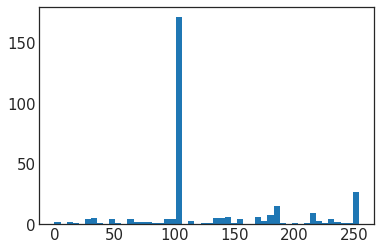

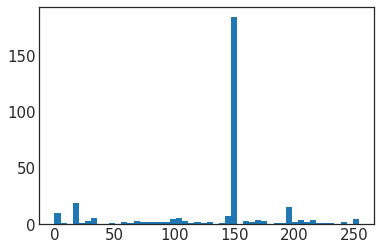

[[146 172]
 [182 148]
 [ 65  20]
 [185 148]
 [225 148]
 [170 148]
 [105  20]
 [105 148]
 [185 144]
 [105 158]
 [154  20]
 [105 148]
 [185 172]
 [ 27 146]
 [124  84]
 [105 148]
 [185 148]
 [105 148]
 [105  20]
 [105 148]
 [105 148]
 [185 148]
 [146 196]
 [105 148]
 [146 148]
 [214 148]
 [105  20]
 [105 148]
 [142 242]
 [185 146]
 [114  20]
 [235 158]
 [185 148]
 [214 148]
 [105  20]
 [105 148]
 [105 148]
 [154 148]
 [217  20]
 [219  31]
 [ 99   0]
 [ 76 190]
 [ 27 196]
 [ 76 196]
 [105 148]
 [185 148]
 [146  20]
 [174 148]
 [217 148]
 [230 230]
 [105 196]
 [105  20]
 [152 214]
 [105 148]
 [105 196]
 [105 148]
 [105 148]
 [105 148]
 [ 46 196]
 [105 148]
 [102 206]
 [250 213]
 [ 65  20]
 [105 148]
 [105  97]
 [217 159]
 [223 148]
 [ 92  92]
 [105 148]
 [105  92]
 [105 253]
 [105  32]
 [ 78  78]
 [105 148]
 [105 148]
 [105 148]
 [ 99 148]
 [105 148]
 [168 163]
 [105   6]
 [184 183]
 [105 148]
 [103 148]
 [105 148]
 [105 148]
 [105 148]
 [201 177]
 [105 148]
 [105 148]
 [105 148]
 [105 148]

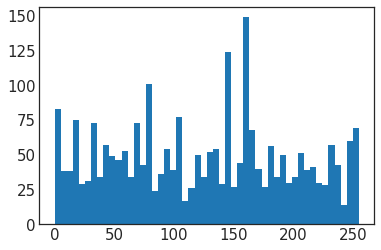

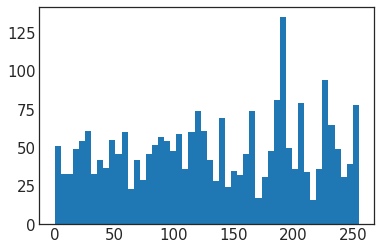

[[219  47]
 [ 21 143]
 [ 77 183]
 ...
 [159 190]
 [159 159]
 [159 190]]
{'219': 12, '21': 7, '77': 6, '14': 20, '234': 15, '60': 18, '208': 18, '20': 6, '145': 5, '95': 19, '146': 82, '73': 8, '102': 24, '252': 25, '78': 66, '54': 3, '24': 8, '89': 6, '162': 20, '99': 14, '5': 2, '207': 5, '184': 5, '168': 36, '180': 16, '19': 3, '4': 54, '119': 8, '131': 4, '222': 11, '32': 9, '202': 2, '108': 3, '31': 24, '85': 5, '192': 20, '245': 32, '250': 11, '164': 7, '175': 3, '35': 24, '6': 3, '237': 4, '41': 21, '166': 10, '8': 22, '212': 16, '144': 27, '48': 7, '187': 9, '217': 9, '204': 7, '53': 12, '124': 11, '74': 9, '87': 6, '214': 6, '122': 8, '177': 9, '118': 8, '200': 3, '38': 4, '249': 5, '139': 9, '55': 7, '238': 11, '178': 4, '156': 19, '230': 5, '173': 12, '40': 6, '121': 17, '255': 12, '68': 48, '196': 11, '103': 11, '182': 1, '152': 4, '93': 9, '29': 7, '176': 9, '254': 7, '134': 11, '51': 13, '172': 5, '96': 13, '117': 6, '227': 6, '191': 11, '169': 10, '133': 8, '61': 12, '94'

100%|██████████| 469/469 [00:11<00:00, 41.96it/s]



Test set: Average loss: 1.6524, Accuracy: 3840/10000 (38.40%)
New Best Accuracy: (38.40%) at Epoch: (1)

Epoch:     2


100%|██████████| 469/469 [00:11<00:00, 41.11it/s]



Test set: Average loss: 1.4531, Accuracy: 4641/10000 (46.41%)
New Best Accuracy: (46.41%) at Epoch: (2)

Epoch:     3


100%|██████████| 469/469 [00:11<00:00, 42.38it/s]



Test set: Average loss: 1.4401, Accuracy: 4503/10000 (45.03%)
Epoch:     4


100%|██████████| 469/469 [00:10<00:00, 42.71it/s]



Test set: Average loss: 1.3861, Accuracy: 4750/10000 (47.50%)
New Best Accuracy: (47.50%) at Epoch: (4)

Epoch:     5


100%|██████████| 469/469 [00:11<00:00, 41.76it/s]



Test set: Average loss: 1.3700, Accuracy: 5047/10000 (50.47%)
New Best Accuracy: (50.47%) at Epoch: (5)

Epoch:     6


100%|██████████| 469/469 [00:11<00:00, 42.48it/s]



Test set: Average loss: 1.3620, Accuracy: 5024/10000 (50.24%)
Epoch:     7


100%|██████████| 469/469 [00:11<00:00, 42.38it/s]



Test set: Average loss: 1.4127, Accuracy: 4521/10000 (45.21%)
Epoch:     8


100%|██████████| 469/469 [00:11<00:00, 41.72it/s]



Test set: Average loss: 1.4056, Accuracy: 4658/10000 (46.58%)
Epoch:     9


100%|██████████| 469/469 [00:11<00:00, 41.80it/s]



Test set: Average loss: 1.4032, Accuracy: 4651/10000 (46.51%)
Epoch:    10


100%|██████████| 469/469 [00:10<00:00, 42.91it/s]



Test set: Average loss: 1.4052, Accuracy: 4472/10000 (44.72%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 50.47% / 44.72% (94.64%) at Epoch: 5


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
feat.shape:  (1, 5760)
reshaped_feat.shape:  (320, 18)


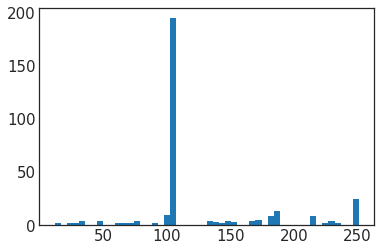

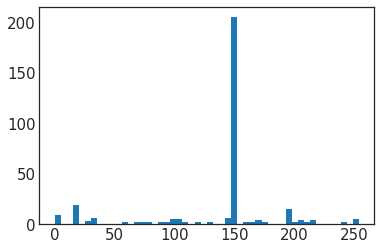

[[146 172]
 [182 148]
 [ 65  20]
 [185 148]
 [105 148]
 [170 148]
 [105  20]
 [105 148]
 [185 144]
 [105 158]
 [154  20]
 [105 148]
 [185 172]
 [ 27 146]
 [105 148]
 [105 148]
 [185 148]
 [105 148]
 [105  20]
 [105 148]
 [105 148]
 [185 148]
 [146 196]
 [105 148]
 [146 148]
 [214 148]
 [105  20]
 [105 148]
 [105 242]
 [185 146]
 [105  20]
 [235 158]
 [185 148]
 [214 148]
 [105  20]
 [105 148]
 [105 148]
 [154 148]
 [217  20]
 [105  31]
 [ 99   0]
 [ 76 148]
 [ 27 196]
 [ 76 196]
 [105 148]
 [185 148]
 [146  20]
 [174 148]
 [217 148]
 [230 148]
 [105 196]
 [105  20]
 [105 214]
 [105 148]
 [105 196]
 [105 148]
 [105 148]
 [105 148]
 [ 46 196]
 [105 148]
 [102 206]
 [105 213]
 [ 65  20]
 [105 148]
 [105  97]
 [217 148]
 [223 148]
 [ 92  92]
 [105 148]
 [105  92]
 [105 253]
 [105  32]
 [ 78  78]
 [105 148]
 [105 148]
 [105 148]
 [ 99 148]
 [105 148]
 [168 163]
 [105 148]
 [184 148]
 [105 148]
 [105 148]
 [105 148]
 [105 148]
 [105 148]
 [105 177]
 [105 148]
 [105 148]
 [105 148]
 [105 148]

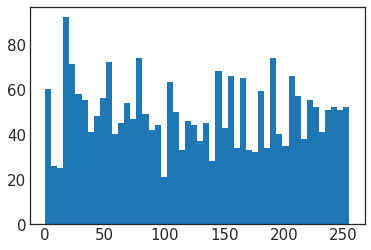

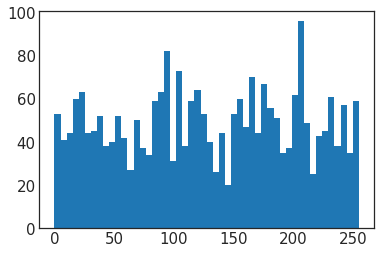

[[183 254]
 [255 238]
 [123  24]
 ...
 [ 74 135]
 [175 209]
 [ 96 129]]
{'183': 13, '255': 10, '123': 9, '62': 6, '17': 66, '78': 30, '175': 9, '88': 20, '35': 15, '144': 19, '33': 6, '12': 5, '99': 9, '190': 17, '53': 21, '252': 19, '131': 12, '165': 9, '245': 28, '219': 11, '164': 13, '118': 16, '81': 8, '29': 23, '25': 20, '2': 12, '218': 3, '196': 9, '110': 19, '109': 7, '57': 8, '19': 13, '191': 15, '74': 18, '91': 6, '23': 8, '117': 10, '50': 21, '41': 5, '4': 31, '37': 12, '155': 9, '208': 24, '121': 7, '9': 3, '166': 5, '60': 15, '242': 9, '254': 5, '14': 13, '167': 4, '141': 10, '238': 18, '79': 27, '198': 9, '192': 17, '158': 11, '52': 5, '124': 16, '237': 8, '22': 5, '232': 24, '102': 23, '147': 8, '156': 18, '236': 19, '143': 5, '154': 19, '222': 20, '45': 15, '248': 8, '49': 18, '140': 5, '160': 5, '68': 35, '181': 14, '246': 6, '111': 5, '24': 32, '151': 13, '82': 7, '83': 12, '101': 6, '76': 10, '201': 8, '106': 10, '64': 4, '234': 12, '112': 15, '120': 8, '20': 5, '54':

100%|██████████| 469/469 [00:11<00:00, 42.14it/s]



Test set: Average loss: 1.5449, Accuracy: 3931/10000 (39.31%)
New Best Accuracy: (39.31%) at Epoch: (1)

Epoch:     2


100%|██████████| 469/469 [00:11<00:00, 41.78it/s]



Test set: Average loss: 1.5018, Accuracy: 4064/10000 (40.64%)
New Best Accuracy: (40.64%) at Epoch: (2)

Epoch:     3


100%|██████████| 469/469 [00:11<00:00, 41.32it/s]



Test set: Average loss: 1.4828, Accuracy: 4158/10000 (41.58%)
New Best Accuracy: (41.58%) at Epoch: (3)

Epoch:     4


100%|██████████| 469/469 [00:11<00:00, 41.11it/s]



Test set: Average loss: 1.4271, Accuracy: 4412/10000 (44.12%)
New Best Accuracy: (44.12%) at Epoch: (4)

Epoch:     5


100%|██████████| 469/469 [00:11<00:00, 41.89it/s]



Test set: Average loss: 1.4251, Accuracy: 4487/10000 (44.87%)
New Best Accuracy: (44.87%) at Epoch: (5)

Epoch:     6


100%|██████████| 469/469 [00:11<00:00, 41.33it/s]



Test set: Average loss: 1.3923, Accuracy: 4587/10000 (45.87%)
New Best Accuracy: (45.87%) at Epoch: (6)

Epoch:     7


100%|██████████| 469/469 [00:11<00:00, 41.76it/s]



Test set: Average loss: 1.3976, Accuracy: 4606/10000 (46.06%)
New Best Accuracy: (46.06%) at Epoch: (7)

Epoch:     8


100%|██████████| 469/469 [00:11<00:00, 41.96it/s]



Test set: Average loss: 1.3658, Accuracy: 4752/10000 (47.52%)
New Best Accuracy: (47.52%) at Epoch: (8)

Epoch:     9


100%|██████████| 469/469 [00:11<00:00, 41.57it/s]



Test set: Average loss: 1.4243, Accuracy: 4504/10000 (45.04%)
Epoch:    10


100%|██████████| 469/469 [00:11<00:00, 41.73it/s]



Test set: Average loss: 1.3723, Accuracy: 4798/10000 (47.98%)
New Best Accuracy: (47.98%) at Epoch: (10)


===retrain PQ part

Epoch:     1


100%|██████████| 469/469 [00:11<00:00, 41.23it/s]



Test set: Average loss: 2.4489, Accuracy: 1009/10000 (10.09%)
New Best Accuracy: (10.09%) at Epoch: (1)

torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
feat.shape:  (1, 5760)
reshaped_feat.shape:  (320, 18)


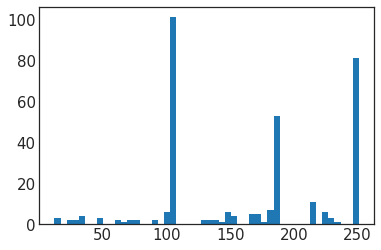

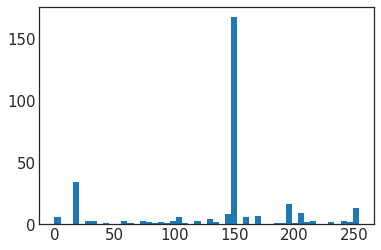

[[146 172]
 [182 148]
 [ 65 158]
 [185  91]
 [105 148]
 [170 148]
 [185  20]
 [105 148]
 [185 144]
 [105 158]
 [154 158]
 [105 172]
 [185 172]
 [ 27 146]
 [185 148]
 [105  32]
 [185 148]
 [105 148]
 [185 195]
 [105 148]
 [105 148]
 [185 148]
 [146 196]
 [105  16]
 [146 148]
 [214 148]
 [214 158]
 [105 172]
 [105 242]
 [185 146]
 [185  76]
 [235 133]
 [185 148]
 [214 148]
 [185 195]
 [105 148]
 [105 148]
 [154 148]
 [217  20]
 [105  31]
 [ 99   0]
 [251 148]
 [ 27 196]
 [251 196]
 [105 148]
 [185 148]
 [146  20]
 [174 148]
 [217 148]
 [230 148]
 [105 204]
 [105 249]
 [105 214]
 [105 148]
 [105 196]
 [251 148]
 [105 148]
 [105 148]
 [ 70 196]
 [251 148]
 [102 206]
 [105 213]
 [214 158]
 [105 172]
 [105 147]
 [217 148]
 [223 148]
 [ 92 148]
 [105 148]
 [251  92]
 [105 196]
 [251  32]
 [ 78  78]
 [105 148]
 [105 148]
 [105 148]
 [ 99 148]
 [251 148]
 [168 254]
 [105 148]
 [184 148]
 [105 148]
 [105 148]
 [105  16]
 [223 148]
 [251 148]
 [105 196]
 [251 148]
 [185  16]
 [185 148]
 [185 148]

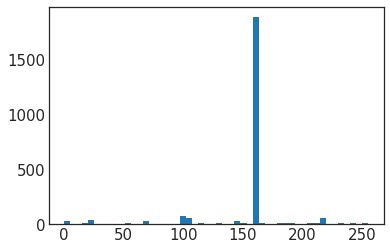

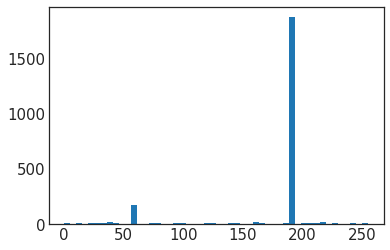

[[ 25 103]
 [210 191]
 [  4 194]
 ...
 [159 190]
 [184 190]
 [107 190]]
{'25': 4, '210': 2, '4': 24, '168': 6, '155': 1, '134': 2, '51': 4, '163': 2, '8': 3, '122': 4, '76': 1, '43': 2, '220': 2, '93': 1, '192': 4, '179': 7, '68': 8, '195': 1, '74': 1, '196': 2, '170': 3, '17': 4, '228': 1, '218': 47, '164': 3, '172': 1, '144': 8, '208': 3, '148': 3, '128': 6, '217': 3, '154': 2, '245': 2, '37': 3, '146': 17, '212': 4, '12': 4, '28': 1, '94': 1, '39': 1, '131': 2, '101': 2, '214': 2, '46': 2, '116': 2, '127': 4, '204': 3, '32': 1, '194': 2, '24': 3, '242': 1, '55': 1, '249': 1, '234': 4, '175': 2, '145': 1, '124': 2, '63': 2, '169': 2, '113': 2, '191': 3, '61': 3, '118': 1, '36': 1, '117': 2, '66': 2, '80': 1, '157': 1, '255': 3, '177': 1, '86': 5, '31': 2, '180': 2, '207': 2, '95': 3, '151': 2, '7': 1, '162': 2, '227': 2, '83': 1, '140': 2, '123': 1, '238': 1, '187': 2, '78': 3, '246': 2, '240': 9, '219': 5, '54': 1, '215': 1, '14': 1, '99': 1, '71': 1, '181': 1, '174': 1, '198': 1, '

100%|██████████| 469/469 [00:11<00:00, 41.61it/s]



Test set: Average loss: 1.6001, Accuracy: 4186/10000 (41.86%)
New Best Accuracy: (41.86%) at Epoch: (1)

Epoch:     2


100%|██████████| 469/469 [00:11<00:00, 41.40it/s]



Test set: Average loss: 1.4233, Accuracy: 4876/10000 (48.76%)
New Best Accuracy: (48.76%) at Epoch: (2)

Epoch:     3


100%|██████████| 469/469 [00:11<00:00, 42.11it/s]



Test set: Average loss: 1.4383, Accuracy: 4633/10000 (46.33%)
Epoch:     4


100%|██████████| 469/469 [00:11<00:00, 41.67it/s]



Test set: Average loss: 1.3971, Accuracy: 4662/10000 (46.62%)
Epoch:     5


100%|██████████| 469/469 [00:11<00:00, 41.78it/s]



Test set: Average loss: 1.3394, Accuracy: 4819/10000 (48.19%)
Epoch:     6


100%|██████████| 469/469 [00:11<00:00, 41.95it/s]



Test set: Average loss: 1.3073, Accuracy: 4894/10000 (48.94%)
New Best Accuracy: (48.94%) at Epoch: (6)

Epoch:     7


100%|██████████| 469/469 [00:11<00:00, 41.39it/s]



Test set: Average loss: 1.3135, Accuracy: 4874/10000 (48.74%)
Epoch:     8


100%|██████████| 469/469 [00:11<00:00, 41.71it/s]



Test set: Average loss: 1.3094, Accuracy: 4740/10000 (47.40%)
Epoch:     9


100%|██████████| 469/469 [00:11<00:00, 41.54it/s]



Test set: Average loss: 1.2904, Accuracy: 4697/10000 (46.97%)
Epoch:    10


100%|██████████| 469/469 [00:11<00:00, 41.76it/s]



Test set: Average loss: 1.2697, Accuracy: 4874/10000 (48.74%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 48.94% / 48.74% (94.64%) at Epoch: 6


===== target accuracy is NOT achieved =====


In [46]:
# Test set: Average loss: 0.0869, Accuracy: 9764/10000 (97.64%)
pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
pqconv3x3.train(wconv3x3_1)
pqfc = faiss.ProductQuantizer(16, 2, 8)
pqfc.train(wfc_1)
recon_mnist = testModelAndCodebooksWTargetAccG(args,
                target_acc=97.64-3,
                model=mnist,
                lr=0.001,
                epoch=10,
                pqconv3x3=pqconv3x3,
                pqconv1x1=None,
                pqfc=pqfc,
                model_arch='VWNet',
                dataset='mnist',
                device=device,
                train_loader=train_loader_mnist,
                test_loader=test_loader_mnist,
                start_from_pretrained=False,
                reverse_tune=True)



===== Iteration Loop: 1th =====

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
shape: (468, 2)


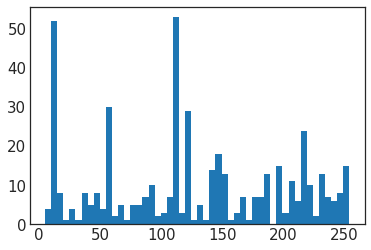

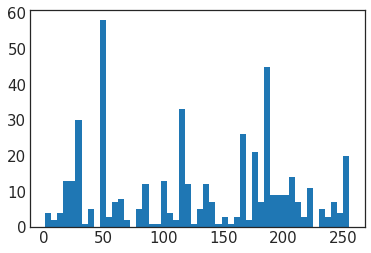

[[197 213]
 [ 12 117]
 [230 166]
 [222  29]
 [252 191]
 [222 122]
 [219 166]
 [ 10 205]
 [122 178]
 [ 47 253]
 [152  29]
 [ 47 208]
 [146 113]
 [218  29]
 [122  29]
 [ 82 116]
 [169 200]
 [ 66  12]
 [145 151]
 [175   2]
 [ 43 224]
 [215 102]
 [251 117]
 [122 194]
 [ 63 190]
 [146 117]
 [121  30]
 [228 118]
 [251  47]
 [219 180]
 [ 79  60]
 [ 45 149]
 [210 197]
 [118 247]
 [ 14 230]
 [219  47]
 [182 207]
 [ 67  29]
 [ 80  86]
 [169  80]
 [ 86 253]
 [139  33]
 [169 208]
 [218 255]
 [186 164]
 [ 20  60]
 [232  60]
 [ 13 218]
 [ 19  85]
 [121 210]
 [151 208]
 [147 208]
 [ 92  29]
 [199 166]
 [235  13]
 [ 10 234]
 [122 219]
 [143 128]
 [122 125]
 [123 119]
 [146   8]
 [222 114]
 [186  68]
 [185  29]
 [145 222]
 [249  66]
 [ 18 206]
 [ 36 180]
 [118  86]
 [118 224]
 [142 109]
 [121 202]
 [181 255]
 [ 35  29]
 [240  67]
 [161  29]
 [ 46 181]
 [241  29]
 [231  29]
 [169 155]
 [195  84]
 [198 202]
 [251 203]
 [159  99]
 [ 65 168]
 [203 186]
 [186 113]
 [ 36 100]
 [114 176]
 [181  68]
 [186  39]

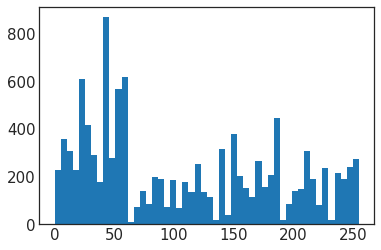

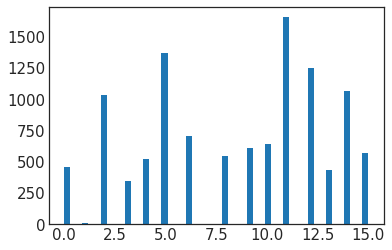

[[ 50  11]
 [ 36  14]
 [221   4]
 ...
 [  3  11]
 [ 20  11]
 [ 86   8]]
{'50': 176, '36': 151, '221': 82, '255': 8, '60': 326, '252': 110, '172': 101, '236': 94, '56': 218, '235': 46, '240': 65, '108': 86, '76': 31, '29': 216, '26': 197, '24': 305, '131': 115, '54': 199, '148': 79, '13': 242, '3': 226, '184': 143, '212': 80, '12': 65, '35': 207, '251': 33, '179': 8, '44': 190, '59': 32, '124': 108, '21': 123, '42': 1, '90': 73, '214': 108, '58': 260, '84': 45, '157': 114, '213': 86, '63': 11, '150': 109, '154': 85, '10': 326, '218': 71, '178': 96, '67': 72, '181': 72, '102': 23, '33': 77, '216': 119, '200': 20, '248': 100, '83': 22, '20': 160, '186': 128, '161': 38, '202': 117, '250': 124, '182': 107, '141': 111, '53': 115, '176': 59, '205': 107, '164': 97, '8': 30, '120': 104, '191': 16, '242': 101, '149': 59, '52': 28, '227': 103, '228': 96, '188': 149, '109': 54, '77': 86, '195': 85, '166': 17, '246': 75, '114': 66, '204': 41, '48': 102, '118': 64, '152': 132, '45': 132, '99': 84, '

100%|██████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 2.1282, Accuracy: 3091/10000 (30.91%)
New Best Accuracy: (30.91%) at Epoch: (1)

Epoch:     2


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 1.8079, Accuracy: 3567/10000 (35.67%)
New Best Accuracy: (35.67%) at Epoch: (2)

Epoch:     3


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 1.6449, Accuracy: 3977/10000 (39.77%)
New Best Accuracy: (39.77%) at Epoch: (3)

Epoch:     4


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 1.5403, Accuracy: 4284/10000 (42.84%)
New Best Accuracy: (42.84%) at Epoch: (4)

Epoch:     5


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 1.4780, Accuracy: 4555/10000 (45.55%)
New Best Accuracy: (45.55%) at Epoch: (5)

Epoch:     6


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 1.4169, Accuracy: 4819/10000 (48.19%)
New Best Accuracy: (48.19%) at Epoch: (6)

Epoch:     7


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 1.3842, Accuracy: 4928/10000 (49.28%)
New Best Accuracy: (49.28%) at Epoch: (7)

Epoch:     8


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 1.3413, Accuracy: 5121/10000 (51.21%)
New Best Accuracy: (51.21%) at Epoch: (8)

Epoch:     9


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 1.2953, Accuracy: 5283/10000 (52.83%)
New Best Accuracy: (52.83%) at Epoch: (9)

Epoch:    10


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 1.2713, Accuracy: 5372/10000 (53.72%)
New Best Accuracy: (53.72%) at Epoch: (10)

Epoch:    11


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 1.2421, Accuracy: 5535/10000 (55.35%)
New Best Accuracy: (55.35%) at Epoch: (11)

Epoch:    12


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 1.2261, Accuracy: 5586/10000 (55.86%)
New Best Accuracy: (55.86%) at Epoch: (12)

Epoch:    13


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 1.2061, Accuracy: 5660/10000 (56.60%)
New Best Accuracy: (56.60%) at Epoch: (13)

Epoch:    14


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 1.1858, Accuracy: 5715/10000 (57.15%)
New Best Accuracy: (57.15%) at Epoch: (14)

Epoch:    15


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 1.1557, Accuracy: 5843/10000 (58.43%)
New Best Accuracy: (58.43%) at Epoch: (15)

Epoch:    16


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 1.1367, Accuracy: 5952/10000 (59.52%)
New Best Accuracy: (59.52%) at Epoch: (16)

Epoch:    17


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 1.1234, Accuracy: 5989/10000 (59.89%)
New Best Accuracy: (59.89%) at Epoch: (17)

Epoch:    18


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 1.1115, Accuracy: 5985/10000 (59.85%)
Epoch:    19


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 1.1010, Accuracy: 6082/10000 (60.82%)
New Best Accuracy: (60.82%) at Epoch: (19)

Epoch:    20


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 1.0807, Accuracy: 6135/10000 (61.35%)
New Best Accuracy: (61.35%) at Epoch: (20)

Epoch:    21


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 1.0739, Accuracy: 6087/10000 (60.87%)
Epoch:    22


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 1.0819, Accuracy: 6074/10000 (60.74%)
Epoch:    23


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 1.0485, Accuracy: 6259/10000 (62.59%)
New Best Accuracy: (62.59%) at Epoch: (23)

Epoch:    24


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 1.0578, Accuracy: 6167/10000 (61.67%)
Epoch:    25


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 1.0493, Accuracy: 6214/10000 (62.14%)
Epoch:    26


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 1.0184, Accuracy: 6360/10000 (63.60%)
New Best Accuracy: (63.60%) at Epoch: (26)

Epoch:    27


100%|██████████| 391/391 [00:47<00:00,  8.22it/s]



Test set: Average loss: 1.0314, Accuracy: 6288/10000 (62.88%)
Epoch:    28


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 1.0091, Accuracy: 6408/10000 (64.08%)
New Best Accuracy: (64.08%) at Epoch: (28)

Epoch:    29


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 1.0156, Accuracy: 6352/10000 (63.52%)
Epoch:    30


100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 1.0131, Accuracy: 6378/10000 (63.78%)
Epoch:    31


100%|██████████| 391/391 [00:47<00:00,  8.22it/s]



Test set: Average loss: 1.0019, Accuracy: 6404/10000 (64.04%)
Epoch:    32


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.9858, Accuracy: 6496/10000 (64.96%)
New Best Accuracy: (64.96%) at Epoch: (32)

Epoch:    33


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 0.9805, Accuracy: 6489/10000 (64.89%)
Epoch:    34


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.9746, Accuracy: 6512/10000 (65.12%)
New Best Accuracy: (65.12%) at Epoch: (34)

Epoch:    35


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.9838, Accuracy: 6485/10000 (64.85%)
Epoch:    36


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 0.9700, Accuracy: 6551/10000 (65.51%)
New Best Accuracy: (65.51%) at Epoch: (36)

Epoch:    37


100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.9631, Accuracy: 6529/10000 (65.29%)
Epoch:    38


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 0.9514, Accuracy: 6583/10000 (65.83%)
New Best Accuracy: (65.83%) at Epoch: (38)

Epoch:    39


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.9498, Accuracy: 6588/10000 (65.88%)
New Best Accuracy: (65.88%) at Epoch: (39)

Epoch:    40


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.9361, Accuracy: 6660/10000 (66.60%)
New Best Accuracy: (66.60%) at Epoch: (40)

Epoch:    41


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.9439, Accuracy: 6622/10000 (66.22%)
Epoch:    42


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.9389, Accuracy: 6652/10000 (66.52%)
Epoch:    43


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.9444, Accuracy: 6586/10000 (65.86%)
Epoch:    44


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.9231, Accuracy: 6709/10000 (67.09%)
New Best Accuracy: (67.09%) at Epoch: (44)

Epoch:    45


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.9380, Accuracy: 6651/10000 (66.51%)
Epoch:    46


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.9192, Accuracy: 6730/10000 (67.30%)
New Best Accuracy: (67.30%) at Epoch: (46)

Epoch:    47


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.9320, Accuracy: 6719/10000 (67.19%)
Epoch:    48


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.9106, Accuracy: 6762/10000 (67.62%)
New Best Accuracy: (67.62%) at Epoch: (48)

Epoch:    49


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.9161, Accuracy: 6715/10000 (67.15%)
Epoch:    50


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.9154, Accuracy: 6742/10000 (67.42%)
Epoch:    51


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.9343, Accuracy: 6694/10000 (66.94%)
Epoch:    52


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.9075, Accuracy: 6788/10000 (67.88%)
New Best Accuracy: (67.88%) at Epoch: (52)

Epoch:    53


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.9148, Accuracy: 6751/10000 (67.51%)
Epoch:    54


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.8970, Accuracy: 6819/10000 (68.19%)
New Best Accuracy: (68.19%) at Epoch: (54)

Epoch:    55


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.9046, Accuracy: 6784/10000 (67.84%)
Epoch:    56


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.9097, Accuracy: 6728/10000 (67.28%)
Epoch:    57


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.9042, Accuracy: 6766/10000 (67.66%)
Epoch:    58


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 0.8932, Accuracy: 6845/10000 (68.45%)
New Best Accuracy: (68.45%) at Epoch: (58)

Epoch:    59


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.8805, Accuracy: 6865/10000 (68.65%)
New Best Accuracy: (68.65%) at Epoch: (59)

Epoch:    60


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8841, Accuracy: 6846/10000 (68.46%)
Epoch:    61


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.8975, Accuracy: 6810/10000 (68.10%)
Epoch:    62


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 0.8795, Accuracy: 6885/10000 (68.85%)
New Best Accuracy: (68.85%) at Epoch: (62)

Epoch:    63


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.8963, Accuracy: 6826/10000 (68.26%)
Epoch:    64


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8797, Accuracy: 6877/10000 (68.77%)
Epoch:    65


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.8933, Accuracy: 6845/10000 (68.45%)
Epoch:    66


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.8692, Accuracy: 6914/10000 (69.14%)
New Best Accuracy: (69.14%) at Epoch: (66)

Epoch:    67


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.8769, Accuracy: 6883/10000 (68.83%)
Epoch:    68


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.8868, Accuracy: 6865/10000 (68.65%)
Epoch:    69


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 0.8611, Accuracy: 6968/10000 (69.68%)
New Best Accuracy: (69.68%) at Epoch: (69)

Epoch:    70


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.8733, Accuracy: 6865/10000 (68.65%)
Epoch:    71


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.8624, Accuracy: 6921/10000 (69.21%)
Epoch:    72


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.8690, Accuracy: 6891/10000 (68.91%)
Epoch:    73


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.8607, Accuracy: 6972/10000 (69.72%)
New Best Accuracy: (69.72%) at Epoch: (73)

Epoch:    74


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.8663, Accuracy: 6930/10000 (69.30%)
Epoch:    75


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8719, Accuracy: 6920/10000 (69.20%)
Epoch:    76


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.8772, Accuracy: 6917/10000 (69.17%)
Epoch:    77


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.8598, Accuracy: 6946/10000 (69.46%)
Epoch:    78


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8507, Accuracy: 6978/10000 (69.78%)
New Best Accuracy: (69.78%) at Epoch: (78)

Epoch:    79


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.8586, Accuracy: 6939/10000 (69.39%)
Epoch:    80


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8636, Accuracy: 6960/10000 (69.60%)

===retrain PQ part

Epoch:     1


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.8323, Accuracy: 7048/10000 (70.48%)
New Best Accuracy: (70.48%) at Epoch: (1)

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
shape: (468, 2)


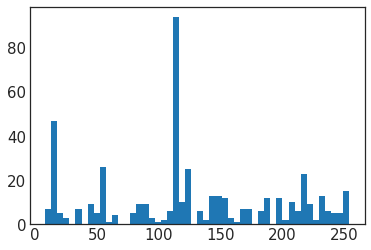

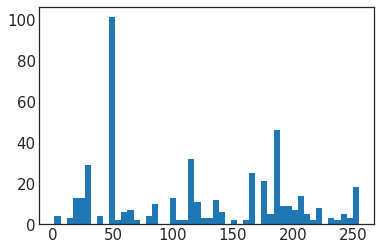

[[113  49]
 [113 117]
 [230 166]
 [222  29]
 [252 191]
 [222  49]
 [219 166]
 [ 10 205]
 [122 178]
 [ 47 253]
 [152  29]
 [ 47 208]
 [146 113]
 [218  29]
 [122  29]
 [113  49]
 [169  49]
 [113  49]
 [145 151]
 [175   2]
 [ 43 224]
 [215 102]
 [251 117]
 [122 194]
 [113 190]
 [146 117]
 [121  49]
 [113  49]
 [251  47]
 [219 180]
 [ 79  60]
 [113  49]
 [210 197]
 [118  49]
 [ 14 230]
 [219  47]
 [113 207]
 [ 67  29]
 [ 80  86]
 [169  80]
 [ 86 253]
 [113  49]
 [169 208]
 [218 255]
 [186 164]
 [113  60]
 [232  60]
 [ 13  49]
 [ 19  49]
 [121 210]
 [113 208]
 [147 208]
 [122  29]
 [199 166]
 [235  13]
 [ 10  49]
 [122 219]
 [143 128]
 [122  49]
 [113 119]
 [146  49]
 [222 114]
 [186  68]
 [113  29]
 [145  49]
 [113  66]
 [ 18 206]
 [ 36 180]
 [118  86]
 [118 224]
 [113 109]
 [121 202]
 [181 255]
 [ 35  29]
 [240  67]
 [113  29]
 [ 46 181]
 [241  29]
 [231  29]
 [169  49]
 [195  84]
 [198 202]
 [251  49]
 [113  99]
 [ 65 168]
 [113 186]
 [186 113]
 [ 36 100]
 [113 176]
 [181  68]
 [186  39]

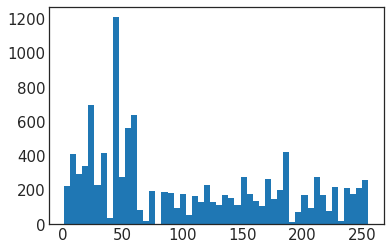

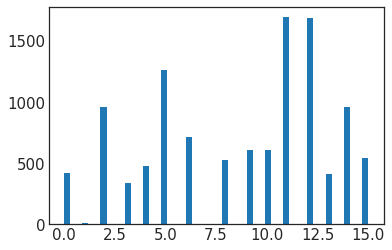

[[ 50  11]
 [ 36  14]
 [221   4]
 ...
 [  3  11]
 [ 20  11]
 [ 86   8]]
{'50': 166, '36': 131, '221': 76, '255': 8, '60': 337, '252': 96, '172': 99, '236': 90, '56': 222, '235': 55, '240': 59, '108': 83, '76': 29, '29': 221, '26': 190, '24': 327, '131': 110, '54': 201, '148': 77, '13': 236, '3': 222, '184': 129, '212': 76, '12': 58, '35': 208, '251': 31, '179': 8, '44': 187, '59': 31, '124': 105, '21': 122, '43': 902, '90': 69, '214': 94, '58': 268, '84': 44, '157': 104, '213': 71, '63': 11, '150': 99, '154': 75, '10': 379, '218': 63, '178': 93, '67': 72, '181': 68, '102': 22, '33': 76, '216': 108, '200': 19, '248': 90, '83': 21, '20': 150, '186': 117, '161': 33, '202': 115, '250': 121, '182': 105, '141': 102, '53': 111, '176': 54, '205': 93, '22': 176, '164': 90, '8': 31, '120': 98, '191': 15, '242': 92, '149': 52, '52': 29, '227': 90, '228': 91, '188': 150, '109': 48, '77': 79, '195': 73, '166': 16, '246': 67, '114': 63, '204': 39, '48': 98, '118': 60, '152': 124, '45': 121, '99': 83

100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 1.4724, Accuracy: 4541/10000 (45.41%)
New Best Accuracy: (45.41%) at Epoch: (1)

Epoch:     2


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 1.3539, Accuracy: 5096/10000 (50.96%)
New Best Accuracy: (50.96%) at Epoch: (2)

Epoch:     3


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 1.2978, Accuracy: 5276/10000 (52.76%)
New Best Accuracy: (52.76%) at Epoch: (3)

Epoch:     4


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 1.2364, Accuracy: 5523/10000 (55.23%)
New Best Accuracy: (55.23%) at Epoch: (4)

Epoch:     5


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 1.1956, Accuracy: 5724/10000 (57.24%)
New Best Accuracy: (57.24%) at Epoch: (5)

Epoch:     6


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 1.1558, Accuracy: 5858/10000 (58.58%)
New Best Accuracy: (58.58%) at Epoch: (6)

Epoch:     7


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 1.1512, Accuracy: 5882/10000 (58.82%)
New Best Accuracy: (58.82%) at Epoch: (7)

Epoch:     8


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 1.1172, Accuracy: 6025/10000 (60.25%)
New Best Accuracy: (60.25%) at Epoch: (8)

Epoch:     9


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 1.1154, Accuracy: 6048/10000 (60.48%)
New Best Accuracy: (60.48%) at Epoch: (9)

Epoch:    10


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 1.0738, Accuracy: 6191/10000 (61.91%)
New Best Accuracy: (61.91%) at Epoch: (10)

Epoch:    11


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 1.0663, Accuracy: 6164/10000 (61.64%)
Epoch:    12


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 1.0460, Accuracy: 6276/10000 (62.76%)
New Best Accuracy: (62.76%) at Epoch: (12)

Epoch:    13


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 1.0206, Accuracy: 6384/10000 (63.84%)
New Best Accuracy: (63.84%) at Epoch: (13)

Epoch:    14


100%|██████████| 391/391 [00:47<00:00,  8.22it/s]



Test set: Average loss: 1.0199, Accuracy: 6409/10000 (64.09%)
New Best Accuracy: (64.09%) at Epoch: (14)

Epoch:    15


100%|██████████| 391/391 [00:47<00:00,  8.19it/s]



Test set: Average loss: 1.0114, Accuracy: 6432/10000 (64.32%)
New Best Accuracy: (64.32%) at Epoch: (15)

Epoch:    16


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 1.0129, Accuracy: 6389/10000 (63.89%)
Epoch:    17


100%|██████████| 391/391 [00:47<00:00,  8.19it/s]



Test set: Average loss: 0.9842, Accuracy: 6538/10000 (65.38%)
New Best Accuracy: (65.38%) at Epoch: (17)

Epoch:    18


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.9946, Accuracy: 6458/10000 (64.58%)
Epoch:    19


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.9744, Accuracy: 6487/10000 (64.87%)
Epoch:    20


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.9635, Accuracy: 6545/10000 (65.45%)
New Best Accuracy: (65.45%) at Epoch: (20)

Epoch:    21


100%|██████████| 391/391 [00:49<00:00,  7.98it/s]



Test set: Average loss: 0.9619, Accuracy: 6526/10000 (65.26%)
Epoch:    22


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.9424, Accuracy: 6636/10000 (66.36%)
New Best Accuracy: (66.36%) at Epoch: (22)

Epoch:    23


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.9431, Accuracy: 6643/10000 (66.43%)
New Best Accuracy: (66.43%) at Epoch: (23)

Epoch:    24


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.9348, Accuracy: 6693/10000 (66.93%)
New Best Accuracy: (66.93%) at Epoch: (24)

Epoch:    25


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.9497, Accuracy: 6627/10000 (66.27%)
Epoch:    26


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.9311, Accuracy: 6693/10000 (66.93%)
Epoch:    27


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.9213, Accuracy: 6718/10000 (67.18%)
New Best Accuracy: (67.18%) at Epoch: (27)

Epoch:    28


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.9223, Accuracy: 6743/10000 (67.43%)
New Best Accuracy: (67.43%) at Epoch: (28)

Epoch:    29


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.9062, Accuracy: 6790/10000 (67.90%)
New Best Accuracy: (67.90%) at Epoch: (29)

Epoch:    30


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.9154, Accuracy: 6739/10000 (67.39%)
Epoch:    31


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.9137, Accuracy: 6761/10000 (67.61%)
Epoch:    32


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.9067, Accuracy: 6771/10000 (67.71%)
Epoch:    33


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8923, Accuracy: 6821/10000 (68.21%)
New Best Accuracy: (68.21%) at Epoch: (33)

Epoch:    34


100%|██████████| 391/391 [00:49<00:00,  7.95it/s]



Test set: Average loss: 0.9071, Accuracy: 6768/10000 (67.68%)
Epoch:    35


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.8967, Accuracy: 6818/10000 (68.18%)
Epoch:    36


100%|██████████| 391/391 [00:49<00:00,  7.91it/s]



Test set: Average loss: 0.9018, Accuracy: 6758/10000 (67.58%)
Epoch:    37


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.8871, Accuracy: 6831/10000 (68.31%)
New Best Accuracy: (68.31%) at Epoch: (37)

Epoch:    38


100%|██████████| 391/391 [00:49<00:00,  7.89it/s]



Test set: Average loss: 0.8835, Accuracy: 6837/10000 (68.37%)
New Best Accuracy: (68.37%) at Epoch: (38)

Epoch:    39


100%|██████████| 391/391 [00:49<00:00,  7.93it/s]



Test set: Average loss: 0.8778, Accuracy: 6876/10000 (68.76%)
New Best Accuracy: (68.76%) at Epoch: (39)

Epoch:    40


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.8743, Accuracy: 6895/10000 (68.95%)
New Best Accuracy: (68.95%) at Epoch: (40)

Epoch:    41


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.9080, Accuracy: 6775/10000 (67.75%)
Epoch:    42


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.8865, Accuracy: 6871/10000 (68.71%)
Epoch:    43


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.8850, Accuracy: 6879/10000 (68.79%)
Epoch:    44


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.8801, Accuracy: 6851/10000 (68.51%)
Epoch:    45


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.8657, Accuracy: 6919/10000 (69.19%)
New Best Accuracy: (69.19%) at Epoch: (45)

Epoch:    46


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 0.8719, Accuracy: 6896/10000 (68.96%)
Epoch:    47


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8783, Accuracy: 6902/10000 (69.02%)
Epoch:    48


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 0.8586, Accuracy: 6919/10000 (69.19%)
Epoch:    49


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.8859, Accuracy: 6866/10000 (68.66%)
Epoch:    50


100%|██████████| 391/391 [00:47<00:00,  8.25it/s]



Test set: Average loss: 0.8569, Accuracy: 6927/10000 (69.27%)
New Best Accuracy: (69.27%) at Epoch: (50)

Epoch:    51


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.8707, Accuracy: 6948/10000 (69.48%)
New Best Accuracy: (69.48%) at Epoch: (51)

Epoch:    52


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8767, Accuracy: 6903/10000 (69.03%)
Epoch:    53


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.8565, Accuracy: 6967/10000 (69.67%)
New Best Accuracy: (69.67%) at Epoch: (53)

Epoch:    54


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.8597, Accuracy: 6958/10000 (69.58%)
Epoch:    55


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.8574, Accuracy: 6932/10000 (69.32%)
Epoch:    56


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.8545, Accuracy: 6966/10000 (69.66%)
Epoch:    57


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.8544, Accuracy: 6927/10000 (69.27%)
Epoch:    58


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.8613, Accuracy: 6932/10000 (69.32%)
Epoch:    59


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.8689, Accuracy: 6869/10000 (68.69%)
Epoch:    60


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.8712, Accuracy: 6897/10000 (68.97%)
Epoch:    61


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8437, Accuracy: 7010/10000 (70.10%)
New Best Accuracy: (70.10%) at Epoch: (61)

Epoch:    62


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8457, Accuracy: 7000/10000 (70.00%)
Epoch:    63


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8501, Accuracy: 6955/10000 (69.55%)
Epoch:    64


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.8357, Accuracy: 7028/10000 (70.28%)
New Best Accuracy: (70.28%) at Epoch: (64)

Epoch:    65


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.8317, Accuracy: 7029/10000 (70.29%)
New Best Accuracy: (70.29%) at Epoch: (65)

Epoch:    66


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.8291, Accuracy: 7073/10000 (70.73%)
New Best Accuracy: (70.73%) at Epoch: (66)

Epoch:    67


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8424, Accuracy: 6983/10000 (69.83%)
Epoch:    68


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.8343, Accuracy: 7043/10000 (70.43%)
Epoch:    69


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 0.8334, Accuracy: 7032/10000 (70.32%)
Epoch:    70


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.8388, Accuracy: 7028/10000 (70.28%)
Epoch:    71


100%|██████████| 391/391 [00:47<00:00,  8.19it/s]



Test set: Average loss: 0.8366, Accuracy: 7028/10000 (70.28%)
Epoch:    72


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.8432, Accuracy: 7015/10000 (70.15%)
Epoch:    73


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 0.8394, Accuracy: 7010/10000 (70.10%)
Epoch:    74


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.8328, Accuracy: 7067/10000 (70.67%)
Epoch:    75


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.8259, Accuracy: 7084/10000 (70.84%)
New Best Accuracy: (70.84%) at Epoch: (75)

Epoch:    76


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8419, Accuracy: 6995/10000 (69.95%)
Epoch:    77


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8245, Accuracy: 7079/10000 (70.79%)
Epoch:    78


100%|██████████| 391/391 [00:47<00:00,  8.19it/s]



Test set: Average loss: 0.8233, Accuracy: 7042/10000 (70.42%)
Epoch:    79


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.8273, Accuracy: 7033/10000 (70.33%)
Epoch:    80


100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.8302, Accuracy: 7069/10000 (70.69%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 70.84% / 70.69% (88.05%) at Epoch: 75


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
shape: (468, 2)


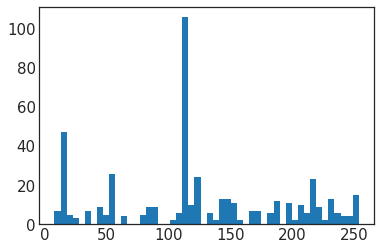

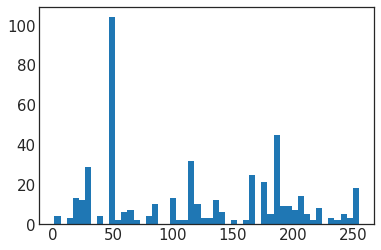

[[113  49]
 [113 117]
 [230 166]
 [222  29]
 [252 191]
 [222  49]
 [219 166]
 [ 10 205]
 [122 178]
 [ 47 253]
 [152  29]
 [ 47 208]
 [146 113]
 [218  29]
 [122  29]
 [113  49]
 [169  49]
 [113  49]
 [145 151]
 [175   2]
 [ 43 224]
 [215 102]
 [251 117]
 [122 194]
 [113 190]
 [146 117]
 [121  49]
 [113  49]
 [251  47]
 [219 180]
 [ 79  60]
 [113  49]
 [210 197]
 [118  49]
 [ 14 230]
 [219  47]
 [113 207]
 [ 67  29]
 [ 80  86]
 [169  80]
 [ 86 253]
 [113  49]
 [169 208]
 [218 255]
 [186 164]
 [113  60]
 [232  60]
 [ 13  49]
 [ 19  49]
 [121 210]
 [113 208]
 [147 208]
 [122  29]
 [199 166]
 [235  13]
 [ 10  49]
 [122 219]
 [143 128]
 [122  49]
 [113 119]
 [146  49]
 [222 114]
 [186  68]
 [113  29]
 [145  49]
 [113  66]
 [ 18 206]
 [ 36 180]
 [118  86]
 [118 224]
 [113 109]
 [121 202]
 [181 255]
 [ 35  29]
 [240  67]
 [113  29]
 [ 46 181]
 [241  29]
 [231  29]
 [169  49]
 [195  84]
 [113 202]
 [251  49]
 [113  99]
 [ 65 168]
 [113 186]
 [186 113]
 [ 36 100]
 [113 176]
 [181  68]
 [186  39]

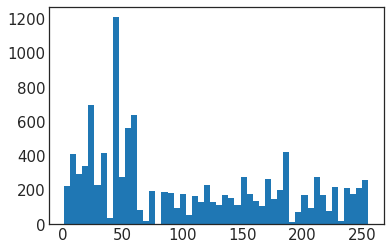

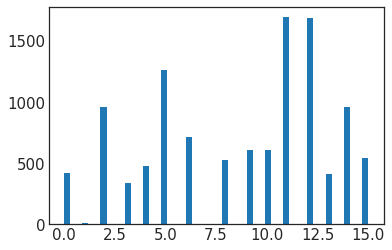

[[ 50  11]
 [ 36  14]
 [221   4]
 ...
 [  3  11]
 [ 20  11]
 [ 86   8]]
{'50': 166, '36': 131, '221': 76, '255': 8, '60': 337, '252': 96, '172': 99, '236': 90, '56': 222, '235': 55, '240': 59, '108': 83, '76': 29, '29': 221, '26': 190, '24': 327, '131': 110, '54': 201, '148': 77, '13': 236, '3': 222, '184': 129, '212': 76, '12': 58, '35': 208, '251': 31, '179': 8, '44': 187, '59': 31, '124': 105, '21': 122, '43': 902, '90': 69, '214': 94, '58': 268, '84': 44, '157': 104, '213': 71, '63': 11, '150': 99, '154': 75, '10': 379, '218': 63, '178': 93, '67': 72, '181': 68, '102': 22, '33': 76, '216': 108, '200': 19, '248': 90, '83': 21, '20': 150, '186': 117, '161': 33, '202': 115, '250': 121, '182': 105, '141': 102, '53': 111, '176': 54, '205': 93, '22': 176, '164': 90, '8': 31, '120': 98, '191': 15, '242': 92, '149': 52, '52': 29, '227': 90, '228': 91, '188': 150, '109': 48, '77': 79, '195': 73, '166': 16, '246': 67, '114': 63, '204': 39, '48': 98, '118': 60, '152': 124, '45': 121, '99': 83

100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.8243, Accuracy: 7060/10000 (70.60%)
New Best Accuracy: (70.60%) at Epoch: (1)

Epoch:     2


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.7303, Accuracy: 7453/10000 (74.53%)
New Best Accuracy: (74.53%) at Epoch: (2)

Epoch:     3


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.6398, Accuracy: 7768/10000 (77.68%)
New Best Accuracy: (77.68%) at Epoch: (3)

Epoch:     4


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.5997, Accuracy: 7927/10000 (79.27%)
New Best Accuracy: (79.27%) at Epoch: (4)

Epoch:     5


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.5580, Accuracy: 8062/10000 (80.62%)
New Best Accuracy: (80.62%) at Epoch: (5)

Epoch:     6


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.5319, Accuracy: 8199/10000 (81.99%)
New Best Accuracy: (81.99%) at Epoch: (6)

Epoch:     7


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 0.5070, Accuracy: 8313/10000 (83.13%)
New Best Accuracy: (83.13%) at Epoch: (7)

Epoch:     8


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.5074, Accuracy: 8265/10000 (82.65%)
Epoch:     9


100%|██████████| 391/391 [00:47<00:00,  8.21it/s]



Test set: Average loss: 0.4532, Accuracy: 8461/10000 (84.61%)
New Best Accuracy: (84.61%) at Epoch: (9)

Epoch:    10


100%|██████████| 391/391 [00:47<00:00,  8.19it/s]



Test set: Average loss: 0.4735, Accuracy: 8382/10000 (83.82%)
Epoch:    11


100%|██████████| 391/391 [00:47<00:00,  8.22it/s]



Test set: Average loss: 0.4626, Accuracy: 8432/10000 (84.32%)
Epoch:    12


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.4386, Accuracy: 8533/10000 (85.33%)
New Best Accuracy: (85.33%) at Epoch: (12)

Epoch:    13


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.4379, Accuracy: 8552/10000 (85.52%)
New Best Accuracy: (85.52%) at Epoch: (13)

Epoch:    14


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 0.4421, Accuracy: 8558/10000 (85.58%)
New Best Accuracy: (85.58%) at Epoch: (14)

Epoch:    15


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.4347, Accuracy: 8591/10000 (85.91%)
New Best Accuracy: (85.91%) at Epoch: (15)

Epoch:    16


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 0.4156, Accuracy: 8620/10000 (86.20%)
New Best Accuracy: (86.20%) at Epoch: (16)

Epoch:    17


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.4138, Accuracy: 8626/10000 (86.26%)
New Best Accuracy: (86.26%) at Epoch: (17)

Epoch:    18


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.4228, Accuracy: 8621/10000 (86.21%)
Epoch:    19


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.4086, Accuracy: 8662/10000 (86.62%)
New Best Accuracy: (86.62%) at Epoch: (19)

Epoch:    20


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.4143, Accuracy: 8662/10000 (86.62%)
Epoch:    21


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 0.4279, Accuracy: 8604/10000 (86.04%)
Epoch:    22


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.4112, Accuracy: 8673/10000 (86.73%)
New Best Accuracy: (86.73%) at Epoch: (22)

Epoch:    23


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3768, Accuracy: 8783/10000 (87.83%)
New Best Accuracy: (87.83%) at Epoch: (23)

Epoch:    24


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3776, Accuracy: 8755/10000 (87.55%)
Epoch:    25


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.3829, Accuracy: 8756/10000 (87.56%)
Epoch:    26


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3910, Accuracy: 8724/10000 (87.24%)
Epoch:    27


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.3779, Accuracy: 8767/10000 (87.67%)
Epoch:    28


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.3736, Accuracy: 8787/10000 (87.87%)
New Best Accuracy: (87.87%) at Epoch: (28)

Epoch:    29


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3791, Accuracy: 8760/10000 (87.60%)
Epoch:    30


100%|██████████| 391/391 [00:49<00:00,  7.98it/s]



Test set: Average loss: 0.3839, Accuracy: 8760/10000 (87.60%)
Epoch:    31


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.3729, Accuracy: 8816/10000 (88.16%)
New Best Accuracy: (88.16%) at Epoch: (31)

Epoch:    32


100%|██████████| 391/391 [00:49<00:00,  7.96it/s]



Test set: Average loss: 0.3642, Accuracy: 8813/10000 (88.13%)
Epoch:    33


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.3807, Accuracy: 8775/10000 (87.75%)
Epoch:    34


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3646, Accuracy: 8836/10000 (88.36%)
New Best Accuracy: (88.36%) at Epoch: (34)

Epoch:    35


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3784, Accuracy: 8825/10000 (88.25%)
Epoch:    36


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.3776, Accuracy: 8810/10000 (88.10%)
Epoch:    37


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.3712, Accuracy: 8836/10000 (88.36%)
Epoch:    38


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.3627, Accuracy: 8848/10000 (88.48%)
New Best Accuracy: (88.48%) at Epoch: (38)

Epoch:    39


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.3820, Accuracy: 8812/10000 (88.12%)
Epoch:    40


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.3810, Accuracy: 8836/10000 (88.36%)
Epoch:    41


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.3713, Accuracy: 8829/10000 (88.29%)
Epoch:    42


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3806, Accuracy: 8809/10000 (88.09%)
Epoch:    43


100%|██████████| 391/391 [00:49<00:00,  7.95it/s]



Test set: Average loss: 0.3825, Accuracy: 8854/10000 (88.54%)
New Best Accuracy: (88.54%) at Epoch: (43)

Epoch:    44


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.3803, Accuracy: 8839/10000 (88.39%)
Epoch:    45


100%|██████████| 391/391 [00:49<00:00,  7.93it/s]



Test set: Average loss: 0.3719, Accuracy: 8855/10000 (88.55%)
New Best Accuracy: (88.55%) at Epoch: (45)

Epoch:    46


100%|██████████| 391/391 [00:49<00:00,  7.98it/s]



Test set: Average loss: 0.3947, Accuracy: 8838/10000 (88.38%)
Epoch:    47


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.3902, Accuracy: 8783/10000 (87.83%)
Epoch:    48


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3875, Accuracy: 8796/10000 (87.96%)
Epoch:    49


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.3817, Accuracy: 8850/10000 (88.50%)
Epoch:    50


100%|██████████| 391/391 [00:49<00:00,  7.95it/s]



Test set: Average loss: 0.3917, Accuracy: 8794/10000 (87.94%)
Epoch:    51


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3832, Accuracy: 8839/10000 (88.39%)
Epoch:    52


100%|██████████| 391/391 [00:49<00:00,  7.96it/s]



Test set: Average loss: 0.3751, Accuracy: 8867/10000 (88.67%)
New Best Accuracy: (88.67%) at Epoch: (52)

Epoch:    53


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3878, Accuracy: 8843/10000 (88.43%)
Epoch:    54


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3917, Accuracy: 8837/10000 (88.37%)
Epoch:    55


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.3889, Accuracy: 8844/10000 (88.44%)
Epoch:    56


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3948, Accuracy: 8847/10000 (88.47%)
Epoch:    57


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.3903, Accuracy: 8827/10000 (88.27%)
Epoch:    58


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.3759, Accuracy: 8877/10000 (88.77%)
New Best Accuracy: (88.77%) at Epoch: (58)

Epoch:    59


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3946, Accuracy: 8822/10000 (88.22%)
Epoch:    60


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3987, Accuracy: 8834/10000 (88.34%)
Epoch:    61


100%|██████████| 391/391 [00:49<00:00,  7.98it/s]



Test set: Average loss: 0.4013, Accuracy: 8827/10000 (88.27%)
Epoch:    62


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3876, Accuracy: 8874/10000 (88.74%)
Epoch:    63


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3927, Accuracy: 8873/10000 (88.73%)
Epoch:    64


100%|██████████| 391/391 [00:49<00:00,  7.98it/s]



Test set: Average loss: 0.3774, Accuracy: 8898/10000 (88.98%)
New Best Accuracy: (88.98%) at Epoch: (64)

Epoch:    65


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.3842, Accuracy: 8886/10000 (88.86%)
Epoch:    66


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.3829, Accuracy: 8877/10000 (88.77%)
Epoch:    67


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3946, Accuracy: 8840/10000 (88.40%)
Epoch:    68


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.3898, Accuracy: 8869/10000 (88.69%)
Epoch:    69


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.3938, Accuracy: 8847/10000 (88.47%)
Epoch:    70


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3991, Accuracy: 8862/10000 (88.62%)
Epoch:    71


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3859, Accuracy: 8883/10000 (88.83%)
Epoch:    72


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3878, Accuracy: 8879/10000 (88.79%)
Epoch:    73


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3981, Accuracy: 8868/10000 (88.68%)
Epoch:    74


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.3865, Accuracy: 8889/10000 (88.89%)
Epoch:    75


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.3959, Accuracy: 8855/10000 (88.55%)
Epoch:    76


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.4136, Accuracy: 8811/10000 (88.11%)
Epoch:    77


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.4046, Accuracy: 8854/10000 (88.54%)
Epoch:    78


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3832, Accuracy: 8908/10000 (89.08%)
New Best Accuracy: (89.08%) at Epoch: (78)

Epoch:    79


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 0.4029, Accuracy: 8829/10000 (88.29%)
Epoch:    80


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3983, Accuracy: 8905/10000 (89.05%)

===retrain PQ part

torch.Size([168, 1, 3, 3])
torch.Size([192, 168, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]



Test set: Average loss: 1.8134, Accuracy: 3489/10000 (34.89%)
New Best Accuracy: (34.89%) at Epoch: (1)

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
shape: (468, 2)


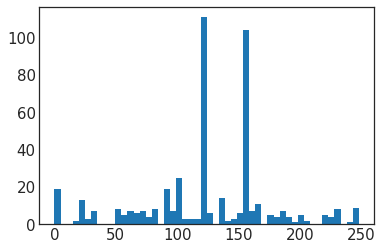

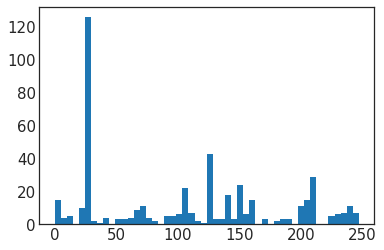

[[  3  29]
 [ 94 154]
 [193  21]
 [  4  29]
 [156  23]
 [  1 107]
 [122  21]
 [ 31 246]
 [122  92]
 [ 61  92]
 [  2  29]
 [ 61 208]
 [ 69 238]
 [ 31  29]
 [122  29]
 [157  29]
 [ 21  29]
 [ 94  29]
 [ 76 209]
 [  0  29]
 [ 20 236]
 [122 198]
 [165 154]
 [122 107]
 [122 230]
 [229 154]
 [ 21 209]
 [122 209]
 [222 241]
 [187 154]
 [178 163]
 [122  29]
 [122 169]
 [165  29]
 [157 198]
 [202 223]
 [122  29]
 [ 71  29]
 [188  29]
 [248  29]
 [128 144]
 [122  29]
 [112 141]
 [230  25]
 [ 66  66]
 [157  73]
 [152 163]
 [ 32 209]
 [179 209]
 [ 21 149]
 [122 150]
 [ 94 204]
 [122  29]
 [122  21]
 [142  95]
 [122  29]
 [122  25]
 [ 93 116]
 [122  29]
 [  0 247]
 [ 69  29]
 [202 209]
 [247  11]
 [122  29]
 [181  29]
 [157 160]
 [122 240]
 [229  11]
 [165  29]
 [165 198]
 [157 229]
 [126 106]
 [122 204]
 [229  29]
 [  2 142]
 [122  29]
 [ 56 106]
 [ 79  29]
 [154  29]
 [112 209]
 [122 239]
 [122 106]
 [176 142]
 [122  71]
 [229 198]
 [168  95]
 [247  92]
 [229 156]
 [157  61]
 [178  11]
 [100   9]

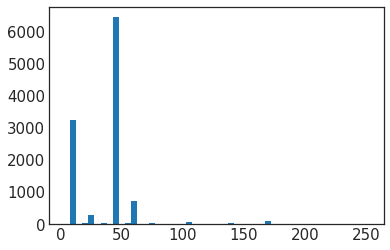

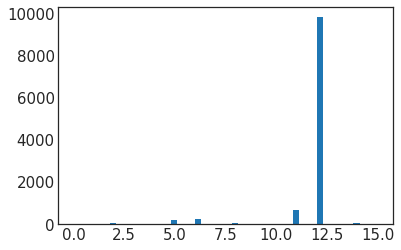

[[43 12]
 [58 11]
 [10 12]
 ...
 [10 12]
 [43 12]
 [43 11]]
{'43': 6399, '58': 62, '10': 3231, '60': 642, '171': 98, '124': 16, '59': 6, '77': 2, '44': 24, '21': 6, '54': 51, '20': 11, '138': 50, '24': 272, '74': 42, '35': 38, '235': 23, '107': 72, '12': 6, '90': 1, '45': 17, '188': 9, '38': 1, '29': 19, '50': 6, '252': 3, '26': 25, '22': 15, '56': 4, '3': 18, '52': 6, '152': 5, '19': 5, '13': 6, '172': 1, '182': 3, '202': 13, '8': 3, '67': 1, '88': 5, '216': 1, '154': 1, '118': 1, '136': 1, '186': 1, '36': 6, '227': 1, '187': 1, '148': 1, '109': 1}
Highest value from dictionary: 43
{'12': 9818, '11': 690, '6': 241, '5': 200, '15': 12, '8': 57, '2': 49, '14': 84, '3': 6, '4': 28, '13': 23, '9': 11, '0': 6, '10': 7}
Highest value from dictionary: 12
[[43 12]
 [58 11]
 [10 12]
 ...
 [10 12]
 [43 12]
 [43 11]]
[[[41, '9', '1'], [203, '8', '0'], [216, '7', '1'], [433, '5', '1'], [918, '6', '0'], [3988, '0', '0'], [6582, '3', '0'], [6970, '4', '1'], [10321, '2', '0'], [11232, '[', '1'], [11

100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 1.0880, Accuracy: 6099/10000 (60.99%)
New Best Accuracy: (60.99%) at Epoch: (1)

Epoch:     2


100%|██████████| 391/391 [00:49<00:00,  7.95it/s]



Test set: Average loss: 0.8325, Accuracy: 7063/10000 (70.63%)
New Best Accuracy: (70.63%) at Epoch: (2)

Epoch:     3


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.7099, Accuracy: 7511/10000 (75.11%)
New Best Accuracy: (75.11%) at Epoch: (3)

Epoch:     4


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.6584, Accuracy: 7731/10000 (77.31%)
New Best Accuracy: (77.31%) at Epoch: (4)

Epoch:     5


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.6235, Accuracy: 7850/10000 (78.50%)
New Best Accuracy: (78.50%) at Epoch: (5)

Epoch:     6


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.5669, Accuracy: 8085/10000 (80.85%)
New Best Accuracy: (80.85%) at Epoch: (6)

Epoch:     7


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.5226, Accuracy: 8189/10000 (81.89%)
New Best Accuracy: (81.89%) at Epoch: (7)

Epoch:     8


100%|██████████| 391/391 [00:49<00:00,  7.95it/s]



Test set: Average loss: 0.5009, Accuracy: 8320/10000 (83.20%)
New Best Accuracy: (83.20%) at Epoch: (8)

Epoch:     9


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.4765, Accuracy: 8333/10000 (83.33%)
New Best Accuracy: (83.33%) at Epoch: (9)

Epoch:    10


100%|██████████| 391/391 [00:49<00:00,  7.98it/s]



Test set: Average loss: 0.5051, Accuracy: 8320/10000 (83.20%)
Epoch:    11


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.5308, Accuracy: 8230/10000 (82.30%)
Epoch:    12


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.4649, Accuracy: 8417/10000 (84.17%)
New Best Accuracy: (84.17%) at Epoch: (12)

Epoch:    13


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.4285, Accuracy: 8603/10000 (86.03%)
New Best Accuracy: (86.03%) at Epoch: (13)

Epoch:    14


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.4435, Accuracy: 8504/10000 (85.04%)
Epoch:    15


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.4224, Accuracy: 8601/10000 (86.01%)
Epoch:    16


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.4010, Accuracy: 8662/10000 (86.62%)
New Best Accuracy: (86.62%) at Epoch: (16)

Epoch:    17


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.4270, Accuracy: 8615/10000 (86.15%)
Epoch:    18


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.4429, Accuracy: 8505/10000 (85.05%)
Epoch:    19


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.4346, Accuracy: 8583/10000 (85.83%)
Epoch:    20


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.4388, Accuracy: 8568/10000 (85.68%)
Epoch:    21


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.4217, Accuracy: 8640/10000 (86.40%)
Epoch:    22


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3940, Accuracy: 8724/10000 (87.24%)
New Best Accuracy: (87.24%) at Epoch: (22)

Epoch:    23


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.4211, Accuracy: 8640/10000 (86.40%)
Epoch:    24


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3877, Accuracy: 8697/10000 (86.97%)
Epoch:    25


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3843, Accuracy: 8717/10000 (87.17%)
Epoch:    26


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3880, Accuracy: 8733/10000 (87.33%)
New Best Accuracy: (87.33%) at Epoch: (26)

Epoch:    27


100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.4068, Accuracy: 8655/10000 (86.55%)
Epoch:    28


100%|██████████| 391/391 [00:49<00:00,  7.91it/s]



Test set: Average loss: 0.3764, Accuracy: 8762/10000 (87.62%)
New Best Accuracy: (87.62%) at Epoch: (28)

Epoch:    29


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.4012, Accuracy: 8692/10000 (86.92%)
Epoch:    30


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.3810, Accuracy: 8769/10000 (87.69%)
New Best Accuracy: (87.69%) at Epoch: (30)

Epoch:    31


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3907, Accuracy: 8754/10000 (87.54%)
Epoch:    32


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3646, Accuracy: 8807/10000 (88.07%)
New Best Accuracy: (88.07%) at Epoch: (32)

Epoch:    33


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3763, Accuracy: 8760/10000 (87.60%)
Epoch:    34


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3930, Accuracy: 8717/10000 (87.17%)
Epoch:    35


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3906, Accuracy: 8768/10000 (87.68%)
Epoch:    36


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.3671, Accuracy: 8824/10000 (88.24%)
New Best Accuracy: (88.24%) at Epoch: (36)

Epoch:    37


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.3851, Accuracy: 8771/10000 (87.71%)
Epoch:    38


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3843, Accuracy: 8812/10000 (88.12%)
Epoch:    39


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.3886, Accuracy: 8790/10000 (87.90%)
Epoch:    40


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3882, Accuracy: 8775/10000 (87.75%)
Epoch:    41


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3917, Accuracy: 8795/10000 (87.95%)
Epoch:    42


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.3816, Accuracy: 8798/10000 (87.98%)
Epoch:    43


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3859, Accuracy: 8787/10000 (87.87%)
Epoch:    44


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3749, Accuracy: 8819/10000 (88.19%)
Epoch:    45


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.3999, Accuracy: 8771/10000 (87.71%)
Epoch:    46


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.3961, Accuracy: 8816/10000 (88.16%)
Epoch:    47


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 0.3861, Accuracy: 8813/10000 (88.13%)
Epoch:    48


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.3753, Accuracy: 8856/10000 (88.56%)
New Best Accuracy: (88.56%) at Epoch: (48)

Epoch:    49


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3900, Accuracy: 8794/10000 (87.94%)
Epoch:    50


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3834, Accuracy: 8840/10000 (88.40%)
Epoch:    51


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.3880, Accuracy: 8844/10000 (88.44%)
Epoch:    52


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.3984, Accuracy: 8797/10000 (87.97%)
Epoch:    53


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3893, Accuracy: 8808/10000 (88.08%)
Epoch:    54


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.3571, Accuracy: 8891/10000 (88.91%)
New Best Accuracy: (88.91%) at Epoch: (54)

Epoch:    55


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.3703, Accuracy: 8847/10000 (88.47%)
Epoch:    56


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.3868, Accuracy: 8831/10000 (88.31%)
Epoch:    57


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.4065, Accuracy: 8823/10000 (88.23%)
Epoch:    58


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3934, Accuracy: 8849/10000 (88.49%)
Epoch:    59


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3670, Accuracy: 8881/10000 (88.81%)
Epoch:    60


100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.3915, Accuracy: 8868/10000 (88.68%)
Epoch:    61


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3865, Accuracy: 8857/10000 (88.57%)
Epoch:    62


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.3788, Accuracy: 8869/10000 (88.69%)
Epoch:    63


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3994, Accuracy: 8826/10000 (88.26%)
Epoch:    64


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.3806, Accuracy: 8848/10000 (88.48%)
Epoch:    65


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]



Test set: Average loss: 0.3704, Accuracy: 8913/10000 (89.13%)
New Best Accuracy: (89.13%) at Epoch: (65)

Epoch:    66


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.3927, Accuracy: 8858/10000 (88.58%)
Epoch:    67


100%|██████████| 391/391 [00:48<00:00,  8.03it/s]



Test set: Average loss: 0.3769, Accuracy: 8900/10000 (89.00%)
Epoch:    68


100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 0.3948, Accuracy: 8844/10000 (88.44%)
Epoch:    69


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.3842, Accuracy: 8860/10000 (88.60%)
Epoch:    70


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 0.3930, Accuracy: 8847/10000 (88.47%)
Epoch:    71


100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 0.3792, Accuracy: 8898/10000 (88.98%)
Epoch:    72


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.3740, Accuracy: 8929/10000 (89.29%)
New Best Accuracy: (89.29%) at Epoch: (72)

Epoch:    73


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.3786, Accuracy: 8886/10000 (88.86%)
Epoch:    74


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.4095, Accuracy: 8868/10000 (88.68%)
Epoch:    75


100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 0.3778, Accuracy: 8924/10000 (89.24%)
Epoch:    76


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.3715, Accuracy: 8952/10000 (89.52%)
New Best Accuracy: (89.52%) at Epoch: (76)

Epoch:    77


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.3958, Accuracy: 8852/10000 (88.52%)
Epoch:    78


100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.3855, Accuracy: 8900/10000 (89.00%)
Epoch:    79


100%|██████████| 391/391 [00:48<00:00,  8.02it/s]



Test set: Average loss: 0.3859, Accuracy: 8889/10000 (88.89%)
Epoch:    80


100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.4113, Accuracy: 8836/10000 (88.36%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 89.52% / 88.36% (88.05%) at Epoch: 76


===== target accuracy is achieved =====


In [21]:
# Test set: Average loss: 0.6670, Accuracy: 8436/10000 (90.38%)
pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
pqconv3x3.train(wconv3x3)
pqfc = faiss.ProductQuantizer(16, 2, 6)
pqfc.train(wfc)
recon_cifar10 = testModelAndCodebooksWTargetAcc(args,
                target_acc=90.05-2,
                model=cifar10,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-AD-I-ch168',
                dataset='cifar10',
                device=device,
                train_loader=train_loader_cifar10,
                test_loader=test_loader_cifar10,
                start_from_pretrained=False,
                reverse_tune=True)

In [1]:
# Test set: Average loss: 0.2680, Accuracy: 24351/26032 (94.76%)
pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
pqconv3x3.train(wconv3x3_3)
pqfc = faiss.ProductQuantizer(16, 2, 6)
pqfc.train(wfc_3)
recon_svhn = testModelAndCodebooksWTargetAccG(args,
                target_acc=94.48-2,
                model=svhn,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-AD-I-ch168',
                dataset='svhn',
                device=device,
                train_loader=train_loader_svhn,
                test_loader=test_loader_svhn,
                start_from_pretrained=False,
                reverse_tune=True)

NameError: ignored



===== Iteration Loop: 1th =====

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)


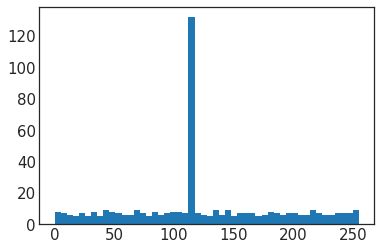

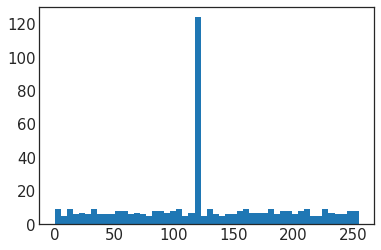

[[106 118]
 [ 10  10]
 [113  68]
 [113  39]
 [113 227]
 [120 118]
 [113 118]
 [230 230]
 [113 205]
 [137 118]
 [113  82]
 [113  32]
 [181 118]
 [113 128]
 [113 118]
 [  7   7]
 [ 19 118]
 [204 118]
 [ 53 118]
 [146 118]
 [223 223]
 [ 25 118]
 [113 118]
 [133 133]
 [113 227]
 [252 165]
 [136 211]
 [113 120]
 [113 118]
 [ 96 169]
 [ 88 161]
 [113 118]
 [113 118]
 [ 84  84]
 [113 118]
 [113 118]
 [113 118]
 [113 231]
 [113  46]
 [113 117]
 [113 118]
 [ 49 118]
 [161 118]
 [113 118]
 [113 183]
 [113 118]
 [151 118]
 [100 118]
 [201 215]
 [113 155]
 [113  88]
 [244 118]
 [ 94 229]
 [113 118]
 [113 185]
 [208 118]
 [113 118]
 [119  63]
 [113 152]
 [113 112]
 [243 231]
 [113 116]
 [ 49 118]
 [ 46  31]
 [113  14]
 [113 251]
 [113 170]
 [ 73  73]
 [ 18  18]
 [ 13 132]
 [113 118]
 [113 118]
 [ 91 118]
 [113 128]
 [113 118]
 [113 132]
 [255 238]
 [113 118]
 [240 118]
 [113 118]
 [ 69  88]
 [113 100]
 [ 50  82]
 [113 118]
 [160  25]
 [113   2]
 [198  40]
 [244 244]
 [195 195]
 [ 41 118]
 [190 190]

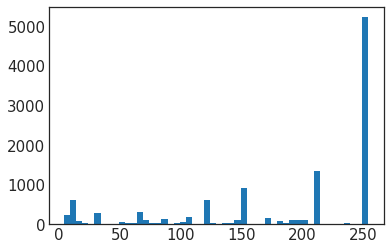

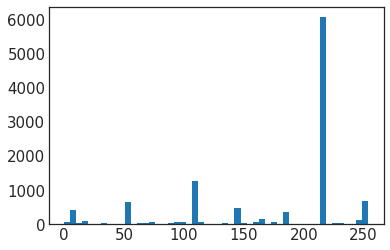

[[209 215]
 [250 215]
 [209 215]
 ...
 [250 215]
 [250 161]
 [121 215]]
{'209': 1338, '250': 5127, '9': 606, '152': 905, '121': 585, '32': 294, '105': 81, '146': 104, '106': 45, '170': 139, '66': 168, '71': 15, '70': 63, '15': 82, '181': 72, '108': 3, '143': 22, '68': 147, '254': 81, '7': 56, '4': 169, '249': 10, '188': 18, '202': 52, '228': 3, '199': 11, '120': 39, '189': 83, '195': 98, '58': 20, '82': 14, '87': 130, '145': 3, '236': 41, '203': 32, '80': 15, '51': 42, '73': 22, '94': 28, '25': 9, '78': 40, '215': 13, '107': 50, '63': 15, '103': 55, '14': 8, '200': 1, '47': 13, '193': 23, '129': 5, '253': 16, '246': 4, '126': 17, '97': 4, '53': 14, '20': 11, '187': 9, '61': 20, '21': 14, '165': 7, '163': 6, '239': 2, '43': 3, '79': 11, '136': 6, '155': 19, '151': 1, '243': 1, '138': 11, '16': 3, '172': 6, '242': 2, '135': 7, '171': 3, '56': 2, '98': 2, '110': 2, '115': 1, '159': 1, '134': 2, '77': 1, '168': 1, '113': 1, '224': 1, '167': 1, '128': 2, '190': 3, '8': 1, '41': 6, '221': 2,

100%|██████████| 307/307 [00:08<00:00, 34.60it/s]



Test set: Average loss: 3.1380, Accuracy: 2138/12630 (16.93%)
New Best Accuracy: (16.93%) at Epoch: (1)

Epoch:     2


100%|██████████| 307/307 [00:08<00:00, 34.80it/s]



Test set: Average loss: 2.7712, Accuracy: 3279/12630 (25.96%)
New Best Accuracy: (25.96%) at Epoch: (2)

Epoch:     3


100%|██████████| 307/307 [00:08<00:00, 34.76it/s]



Test set: Average loss: 2.3946, Accuracy: 4510/12630 (35.71%)
New Best Accuracy: (35.71%) at Epoch: (3)

Epoch:     4


100%|██████████| 307/307 [00:08<00:00, 34.77it/s]



Test set: Average loss: 2.1003, Accuracy: 5432/12630 (43.01%)
New Best Accuracy: (43.01%) at Epoch: (4)

Epoch:     5


100%|██████████| 307/307 [00:08<00:00, 34.76it/s]



Test set: Average loss: 1.8796, Accuracy: 6102/12630 (48.31%)
New Best Accuracy: (48.31%) at Epoch: (5)

Epoch:     6


100%|██████████| 307/307 [00:08<00:00, 34.80it/s]



Test set: Average loss: 1.7241, Accuracy: 6550/12630 (51.86%)
New Best Accuracy: (51.86%) at Epoch: (6)

Epoch:     7


100%|██████████| 307/307 [00:08<00:00, 34.79it/s]



Test set: Average loss: 1.6012, Accuracy: 6868/12630 (54.38%)
New Best Accuracy: (54.38%) at Epoch: (7)

Epoch:     8


100%|██████████| 307/307 [00:08<00:00, 34.90it/s]



Test set: Average loss: 1.5149, Accuracy: 7227/12630 (57.22%)
New Best Accuracy: (57.22%) at Epoch: (8)

Epoch:     9


100%|██████████| 307/307 [00:08<00:00, 34.93it/s]



Test set: Average loss: 1.4381, Accuracy: 7480/12630 (59.22%)
New Best Accuracy: (59.22%) at Epoch: (9)

Epoch:    10


100%|██████████| 307/307 [00:08<00:00, 34.96it/s]



Test set: Average loss: 1.3721, Accuracy: 7646/12630 (60.54%)
New Best Accuracy: (60.54%) at Epoch: (10)

Epoch:    11


100%|██████████| 307/307 [00:08<00:00, 34.97it/s]



Test set: Average loss: 1.3186, Accuracy: 7825/12630 (61.96%)
New Best Accuracy: (61.96%) at Epoch: (11)

Epoch:    12


100%|██████████| 307/307 [00:08<00:00, 34.98it/s]



Test set: Average loss: 1.2726, Accuracy: 7999/12630 (63.33%)
New Best Accuracy: (63.33%) at Epoch: (12)

Epoch:    13


100%|██████████| 307/307 [00:08<00:00, 34.98it/s]



Test set: Average loss: 1.2485, Accuracy: 8115/12630 (64.25%)
New Best Accuracy: (64.25%) at Epoch: (13)

Epoch:    14


100%|██████████| 307/307 [00:08<00:00, 34.97it/s]



Test set: Average loss: 1.2004, Accuracy: 8355/12630 (66.15%)
New Best Accuracy: (66.15%) at Epoch: (14)

Epoch:    15


100%|██████████| 307/307 [00:08<00:00, 34.98it/s]



Test set: Average loss: 1.1619, Accuracy: 8411/12630 (66.60%)
New Best Accuracy: (66.60%) at Epoch: (15)

Epoch:    16


100%|██████████| 307/307 [00:08<00:00, 34.97it/s]



Test set: Average loss: 1.1302, Accuracy: 8528/12630 (67.52%)
New Best Accuracy: (67.52%) at Epoch: (16)

Epoch:    17


100%|██████████| 307/307 [00:08<00:00, 34.97it/s]



Test set: Average loss: 1.1168, Accuracy: 8528/12630 (67.52%)
Epoch:    18


100%|██████████| 307/307 [00:08<00:00, 34.98it/s]



Test set: Average loss: 1.0905, Accuracy: 8692/12630 (68.82%)
New Best Accuracy: (68.82%) at Epoch: (18)

Epoch:    19


100%|██████████| 307/307 [00:08<00:00, 35.04it/s]



Test set: Average loss: 1.0562, Accuracy: 8753/12630 (69.30%)
New Best Accuracy: (69.30%) at Epoch: (19)

Epoch:    20


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 1.0375, Accuracy: 8836/12630 (69.96%)
New Best Accuracy: (69.96%) at Epoch: (20)

Epoch:    21


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 1.0255, Accuracy: 8894/12630 (70.42%)
New Best Accuracy: (70.42%) at Epoch: (21)

Epoch:    22


100%|██████████| 307/307 [00:08<00:00, 35.22it/s]



Test set: Average loss: 0.9991, Accuracy: 8943/12630 (70.81%)
New Best Accuracy: (70.81%) at Epoch: (22)

Epoch:    23


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.9816, Accuracy: 8989/12630 (71.17%)
New Best Accuracy: (71.17%) at Epoch: (23)

Epoch:    24


100%|██████████| 307/307 [00:08<00:00, 35.16it/s]



Test set: Average loss: 0.9714, Accuracy: 9058/12630 (71.72%)
New Best Accuracy: (71.72%) at Epoch: (24)

Epoch:    25


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.9405, Accuracy: 9175/12630 (72.64%)
New Best Accuracy: (72.64%) at Epoch: (25)

Epoch:    26


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.9346, Accuracy: 9188/12630 (72.75%)
New Best Accuracy: (72.75%) at Epoch: (26)

Epoch:    27


100%|██████████| 307/307 [00:08<00:00, 35.10it/s]



Test set: Average loss: 0.9286, Accuracy: 9189/12630 (72.76%)
New Best Accuracy: (72.76%) at Epoch: (27)

Epoch:    28


100%|██████████| 307/307 [00:08<00:00, 35.11it/s]



Test set: Average loss: 0.9121, Accuracy: 9286/12630 (73.52%)
New Best Accuracy: (73.52%) at Epoch: (28)

Epoch:    29


100%|██████████| 307/307 [00:08<00:00, 35.13it/s]



Test set: Average loss: 0.8951, Accuracy: 9320/12630 (73.79%)
New Best Accuracy: (73.79%) at Epoch: (29)

Epoch:    30


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.8939, Accuracy: 9312/12630 (73.73%)
Epoch:    31


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.8751, Accuracy: 9389/12630 (74.34%)
New Best Accuracy: (74.34%) at Epoch: (31)

Epoch:    32


100%|██████████| 307/307 [00:08<00:00, 35.23it/s]



Test set: Average loss: 0.8804, Accuracy: 9359/12630 (74.10%)
Epoch:    33


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.8591, Accuracy: 9461/12630 (74.91%)
New Best Accuracy: (74.91%) at Epoch: (33)

Epoch:    34


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.8505, Accuracy: 9473/12630 (75.00%)
New Best Accuracy: (75.00%) at Epoch: (34)

Epoch:    35


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.8350, Accuracy: 9569/12630 (75.76%)
New Best Accuracy: (75.76%) at Epoch: (35)

Epoch:    36


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.8282, Accuracy: 9530/12630 (75.46%)
Epoch:    37


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.8269, Accuracy: 9549/12630 (75.61%)
Epoch:    38


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.8405, Accuracy: 9611/12630 (76.10%)
New Best Accuracy: (76.10%) at Epoch: (38)

Epoch:    39


100%|██████████| 307/307 [00:08<00:00, 35.09it/s]



Test set: Average loss: 0.8154, Accuracy: 9641/12630 (76.33%)
New Best Accuracy: (76.33%) at Epoch: (39)

Epoch:    40


100%|██████████| 307/307 [00:08<00:00, 35.13it/s]



Test set: Average loss: 0.8024, Accuracy: 9681/12630 (76.65%)
New Best Accuracy: (76.65%) at Epoch: (40)

Epoch:    41


100%|██████████| 307/307 [00:08<00:00, 35.12it/s]



Test set: Average loss: 0.7996, Accuracy: 9675/12630 (76.60%)
Epoch:    42


100%|██████████| 307/307 [00:08<00:00, 35.15it/s]



Test set: Average loss: 0.7867, Accuracy: 9728/12630 (77.02%)
New Best Accuracy: (77.02%) at Epoch: (42)

Epoch:    43


100%|██████████| 307/307 [00:08<00:00, 35.09it/s]



Test set: Average loss: 0.7937, Accuracy: 9715/12630 (76.92%)
Epoch:    44


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.7833, Accuracy: 9713/12630 (76.90%)
Epoch:    45


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.7980, Accuracy: 9722/12630 (76.98%)
Epoch:    46


100%|██████████| 307/307 [00:08<00:00, 35.15it/s]



Test set: Average loss: 0.7708, Accuracy: 9776/12630 (77.40%)
New Best Accuracy: (77.40%) at Epoch: (46)

Epoch:    47


100%|██████████| 307/307 [00:08<00:00, 35.15it/s]



Test set: Average loss: 0.7708, Accuracy: 9845/12630 (77.95%)
New Best Accuracy: (77.95%) at Epoch: (47)

Epoch:    48


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.7599, Accuracy: 9863/12630 (78.09%)
New Best Accuracy: (78.09%) at Epoch: (48)

Epoch:    49


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.7642, Accuracy: 9811/12630 (77.68%)
Epoch:    50


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.7693, Accuracy: 9857/12630 (78.04%)
Epoch:    51


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.7570, Accuracy: 9902/12630 (78.40%)
New Best Accuracy: (78.40%) at Epoch: (51)

Epoch:    52


100%|██████████| 307/307 [00:08<00:00, 35.15it/s]



Test set: Average loss: 0.7397, Accuracy: 9900/12630 (78.38%)
Epoch:    53


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.7529, Accuracy: 9869/12630 (78.14%)
Epoch:    54


100%|██████████| 307/307 [00:08<00:00, 35.21it/s]



Test set: Average loss: 0.7330, Accuracy: 9925/12630 (78.58%)
New Best Accuracy: (78.58%) at Epoch: (54)

Epoch:    55


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.7336, Accuracy: 9964/12630 (78.89%)
New Best Accuracy: (78.89%) at Epoch: (55)

Epoch:    56


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.7231, Accuracy: 9997/12630 (79.15%)
New Best Accuracy: (79.15%) at Epoch: (56)

Epoch:    57


100%|██████████| 307/307 [00:08<00:00, 35.13it/s]



Test set: Average loss: 0.7294, Accuracy: 9997/12630 (79.15%)
Epoch:    58


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.7201, Accuracy: 10030/12630 (79.41%)
New Best Accuracy: (79.41%) at Epoch: (58)

Epoch:    59


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.7118, Accuracy: 10003/12630 (79.20%)
Epoch:    60


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.7161, Accuracy: 10020/12630 (79.33%)
Epoch:    61


100%|██████████| 307/307 [00:08<00:00, 35.16it/s]



Test set: Average loss: 0.7047, Accuracy: 10078/12630 (79.79%)
New Best Accuracy: (79.79%) at Epoch: (61)

Epoch:    62


100%|██████████| 307/307 [00:08<00:00, 35.16it/s]



Test set: Average loss: 0.6896, Accuracy: 10133/12630 (80.23%)
New Best Accuracy: (80.23%) at Epoch: (62)

Epoch:    63


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6861, Accuracy: 10112/12630 (80.06%)
Epoch:    64


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.7024, Accuracy: 10073/12630 (79.75%)
Epoch:    65


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.6769, Accuracy: 10166/12630 (80.49%)
New Best Accuracy: (80.49%) at Epoch: (65)

Epoch:    66


100%|██████████| 307/307 [00:08<00:00, 35.13it/s]



Test set: Average loss: 0.6886, Accuracy: 10057/12630 (79.63%)
Epoch:    67


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6799, Accuracy: 10136/12630 (80.25%)
Epoch:    68


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6594, Accuracy: 10207/12630 (80.82%)
New Best Accuracy: (80.82%) at Epoch: (68)

Epoch:    69


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.6671, Accuracy: 10149/12630 (80.36%)
Epoch:    70


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.6611, Accuracy: 10183/12630 (80.63%)
Epoch:    71


100%|██████████| 307/307 [00:08<00:00, 35.22it/s]



Test set: Average loss: 0.6586, Accuracy: 10185/12630 (80.64%)
Epoch:    72


100%|██████████| 307/307 [00:08<00:00, 35.24it/s]



Test set: Average loss: 0.6577, Accuracy: 10221/12630 (80.93%)
New Best Accuracy: (80.93%) at Epoch: (72)

Epoch:    73


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6558, Accuracy: 10209/12630 (80.83%)
Epoch:    74


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.6627, Accuracy: 10253/12630 (81.18%)
New Best Accuracy: (81.18%) at Epoch: (74)

Epoch:    75


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.6478, Accuracy: 10243/12630 (81.10%)
Epoch:    76


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.6418, Accuracy: 10299/12630 (81.54%)
New Best Accuracy: (81.54%) at Epoch: (76)

Epoch:    77


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6431, Accuracy: 10287/12630 (81.45%)
Epoch:    78


100%|██████████| 307/307 [00:08<00:00, 35.15it/s]



Test set: Average loss: 0.6451, Accuracy: 10268/12630 (81.30%)
Epoch:    79


100%|██████████| 307/307 [00:08<00:00, 35.10it/s]



Test set: Average loss: 0.6352, Accuracy: 10313/12630 (81.65%)
New Best Accuracy: (81.65%) at Epoch: (79)

Epoch:    80


100%|██████████| 307/307 [00:08<00:00, 35.12it/s]



Test set: Average loss: 0.6426, Accuracy: 10323/12630 (81.73%)
New Best Accuracy: (81.73%) at Epoch: (80)


===retrain PQ part

Epoch:     1


100%|██████████| 307/307 [00:09<00:00, 31.08it/s]



Test set: Average loss: 0.5933, Accuracy: 10631/12630 (84.17%)
New Best Accuracy: (84.17%) at Epoch: (1)

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)


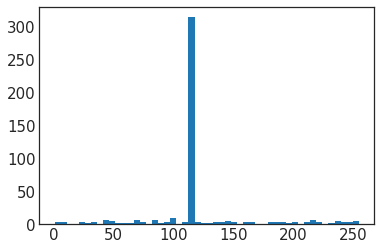

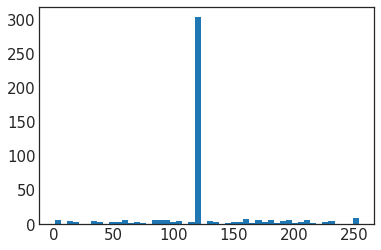

[[113 118]
 [113 118]
 [113  68]
 [113 118]
 [113 227]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [137 118]
 [113  82]
 [113  88]
 [113 118]
 [113  86]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [146 118]
 [223 118]
 [ 25 118]
 [113 118]
 [133 118]
 [113 227]
 [252 118]
 [113 211]
 [113 118]
 [113 118]
 [113 118]
 [113 161]
 [113 118]
 [113 118]
 [ 84 118]
 [113 118]
 [113 118]
 [113 118]
 [113 231]
 [113 118]
 [113 118]
 [113 118]
 [ 49 118]
 [161 118]
 [113 118]
 [113 183]
 [113 118]
 [113 118]
 [100 118]
 [201 118]
 [113 118]
 [113  88]
 [244 118]
 [113 229]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113  63]
 [113 118]
 [113 118]
 [113 231]
 [113 118]
 [ 49 118]
 [113 118]
 [113  14]
 [113 118]
 [113 170]
 [113 118]
 [113 118]
 [151 132]
 [113 118]
 [113 118]
 [113 118]
 [113 128]
 [113 118]
 [113 132]
 [255 118]
 [113 118]
 [113 118]
 [113 118]
 [ 69  88]
 [113 100]
 [113  82]
 [113 118]
 [160 118]
 [113   2]
 [198  40]
 [244 118]
 [113 118]
 [113 118]
 [113 118]

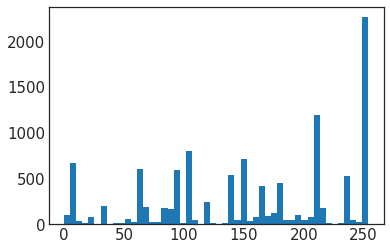

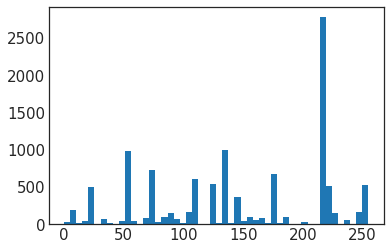

[[121 127]
 [209  75]
 [176 136]
 ...
 [181 177]
 [250 254]
 [170 215]]
{'121': 223, '209': 1190, '176': 117, '207': 76, '141': 517, '214': 158, '181': 452, '103': 652, '253': 17, '4': 103, '7': 141, '163': 402, '235': 487, '92': 580, '63': 464, '250': 2201, '170': 81, '254': 25, '162': 65, '186': 45, '241': 35, '105': 130, '198': 23, '87': 165, '85': 156, '32': 196, '149': 93, '73': 21, '152': 536, '9': 520, '195': 78, '126': 15, '188': 21, '15': 33, '20': 17, '108': 3, '66': 95, '107': 34, '200': 2, '151': 81, '68': 73, '71': 35, '134': 7, '203': 24, '155': 27, '50': 4, '146': 37, '172': 2, '202': 11, '49': 3, '98': 3, '53': 7, '80': 10, '189': 15, '106': 24, '94': 8, '228': 5, '70': 56, '120': 18, '111': 6, '239': 6, '51': 22, '119': 1, '69': 29, '89': 1, '157': 5, '110': 3, '58': 26, '129': 1, '246': 21, '23': 56, '47': 6, '138': 18, '143': 13, '25': 25, '187': 6, '78': 11, '168': 2, '167': 11, '165': 3, '52': 26, '8': 13, '96': 3, '97': 10, '93': 1, '61': 43, '82': 21, '48': 1, '2

100%|██████████| 307/307 [00:08<00:00, 34.84it/s]



Test set: Average loss: 3.1396, Accuracy: 2311/12630 (18.30%)
New Best Accuracy: (18.30%) at Epoch: (1)

Epoch:     2


100%|██████████| 307/307 [00:08<00:00, 35.03it/s]



Test set: Average loss: 2.7254, Accuracy: 3833/12630 (30.35%)
New Best Accuracy: (30.35%) at Epoch: (2)

Epoch:     3


100%|██████████| 307/307 [00:08<00:00, 35.02it/s]



Test set: Average loss: 2.3176, Accuracy: 4936/12630 (39.08%)
New Best Accuracy: (39.08%) at Epoch: (3)

Epoch:     4


100%|██████████| 307/307 [00:08<00:00, 35.03it/s]



Test set: Average loss: 1.9728, Accuracy: 5653/12630 (44.76%)
New Best Accuracy: (44.76%) at Epoch: (4)

Epoch:     5


100%|██████████| 307/307 [00:08<00:00, 34.97it/s]



Test set: Average loss: 1.7351, Accuracy: 6316/12630 (50.01%)
New Best Accuracy: (50.01%) at Epoch: (5)

Epoch:     6


100%|██████████| 307/307 [00:08<00:00, 34.93it/s]



Test set: Average loss: 1.5681, Accuracy: 6828/12630 (54.06%)
New Best Accuracy: (54.06%) at Epoch: (6)

Epoch:     7


100%|██████████| 307/307 [00:08<00:00, 34.86it/s]



Test set: Average loss: 1.4387, Accuracy: 7361/12630 (58.28%)
New Best Accuracy: (58.28%) at Epoch: (7)

Epoch:     8


100%|██████████| 307/307 [00:08<00:00, 34.96it/s]



Test set: Average loss: 1.3715, Accuracy: 7573/12630 (59.96%)
New Best Accuracy: (59.96%) at Epoch: (8)

Epoch:     9


100%|██████████| 307/307 [00:08<00:00, 34.95it/s]



Test set: Average loss: 1.2678, Accuracy: 7905/12630 (62.59%)
New Best Accuracy: (62.59%) at Epoch: (9)

Epoch:    10


100%|██████████| 307/307 [00:08<00:00, 34.98it/s]



Test set: Average loss: 1.2148, Accuracy: 8131/12630 (64.38%)
New Best Accuracy: (64.38%) at Epoch: (10)

Epoch:    11


100%|██████████| 307/307 [00:08<00:00, 34.98it/s]



Test set: Average loss: 1.1605, Accuracy: 8339/12630 (66.03%)
New Best Accuracy: (66.03%) at Epoch: (11)

Epoch:    12


100%|██████████| 307/307 [00:08<00:00, 35.03it/s]



Test set: Average loss: 1.0975, Accuracy: 8493/12630 (67.24%)
New Best Accuracy: (67.24%) at Epoch: (12)

Epoch:    13


100%|██████████| 307/307 [00:08<00:00, 35.03it/s]



Test set: Average loss: 1.0756, Accuracy: 8620/12630 (68.25%)
New Best Accuracy: (68.25%) at Epoch: (13)

Epoch:    14


100%|██████████| 307/307 [00:08<00:00, 35.04it/s]



Test set: Average loss: 1.0473, Accuracy: 8699/12630 (68.88%)
New Best Accuracy: (68.88%) at Epoch: (14)

Epoch:    15


100%|██████████| 307/307 [00:08<00:00, 35.05it/s]



Test set: Average loss: 1.0082, Accuracy: 8824/12630 (69.87%)
New Best Accuracy: (69.87%) at Epoch: (15)

Epoch:    16


100%|██████████| 307/307 [00:08<00:00, 35.09it/s]



Test set: Average loss: 0.9695, Accuracy: 8975/12630 (71.06%)
New Best Accuracy: (71.06%) at Epoch: (16)

Epoch:    17


100%|██████████| 307/307 [00:08<00:00, 35.08it/s]



Test set: Average loss: 0.9547, Accuracy: 9055/12630 (71.69%)
New Best Accuracy: (71.69%) at Epoch: (17)

Epoch:    18


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.9179, Accuracy: 9244/12630 (73.19%)
New Best Accuracy: (73.19%) at Epoch: (18)

Epoch:    19


100%|██████████| 307/307 [00:08<00:00, 35.13it/s]



Test set: Average loss: 0.8870, Accuracy: 9294/12630 (73.59%)
New Best Accuracy: (73.59%) at Epoch: (19)

Epoch:    20


100%|██████████| 307/307 [00:08<00:00, 35.12it/s]



Test set: Average loss: 0.8896, Accuracy: 9319/12630 (73.78%)
New Best Accuracy: (73.78%) at Epoch: (20)

Epoch:    21


100%|██████████| 307/307 [00:08<00:00, 35.16it/s]



Test set: Average loss: 0.8515, Accuracy: 9522/12630 (75.39%)
New Best Accuracy: (75.39%) at Epoch: (21)

Epoch:    22


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.8448, Accuracy: 9506/12630 (75.27%)
Epoch:    23


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.8087, Accuracy: 9621/12630 (76.18%)
New Best Accuracy: (76.18%) at Epoch: (23)

Epoch:    24


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.8005, Accuracy: 9710/12630 (76.88%)
New Best Accuracy: (76.88%) at Epoch: (24)

Epoch:    25


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.7835, Accuracy: 9735/12630 (77.08%)
New Best Accuracy: (77.08%) at Epoch: (25)

Epoch:    26


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.8164, Accuracy: 9716/12630 (76.93%)
Epoch:    27


100%|██████████| 307/307 [00:08<00:00, 35.15it/s]



Test set: Average loss: 0.7589, Accuracy: 9898/12630 (78.37%)
New Best Accuracy: (78.37%) at Epoch: (27)

Epoch:    28


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.7683, Accuracy: 9876/12630 (78.19%)
Epoch:    29


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.7511, Accuracy: 9859/12630 (78.06%)
Epoch:    30


100%|██████████| 307/307 [00:08<00:00, 35.21it/s]



Test set: Average loss: 0.7408, Accuracy: 9945/12630 (78.74%)
New Best Accuracy: (78.74%) at Epoch: (30)

Epoch:    31


100%|██████████| 307/307 [00:08<00:00, 35.26it/s]



Test set: Average loss: 0.7276, Accuracy: 9985/12630 (79.06%)
New Best Accuracy: (79.06%) at Epoch: (31)

Epoch:    32


100%|██████████| 307/307 [00:08<00:00, 35.27it/s]



Test set: Average loss: 0.7280, Accuracy: 9999/12630 (79.17%)
New Best Accuracy: (79.17%) at Epoch: (32)

Epoch:    33


100%|██████████| 307/307 [00:08<00:00, 35.26it/s]



Test set: Average loss: 0.7091, Accuracy: 10041/12630 (79.50%)
New Best Accuracy: (79.50%) at Epoch: (33)

Epoch:    34


100%|██████████| 307/307 [00:08<00:00, 35.28it/s]



Test set: Average loss: 0.7184, Accuracy: 10068/12630 (79.71%)
New Best Accuracy: (79.71%) at Epoch: (34)

Epoch:    35


100%|██████████| 307/307 [00:08<00:00, 35.26it/s]



Test set: Average loss: 0.7028, Accuracy: 10099/12630 (79.96%)
New Best Accuracy: (79.96%) at Epoch: (35)

Epoch:    36


100%|██████████| 307/307 [00:08<00:00, 35.30it/s]



Test set: Average loss: 0.7103, Accuracy: 10095/12630 (79.93%)
Epoch:    37


100%|██████████| 307/307 [00:08<00:00, 35.27it/s]



Test set: Average loss: 0.6786, Accuracy: 10129/12630 (80.20%)
New Best Accuracy: (80.20%) at Epoch: (37)

Epoch:    38


100%|██████████| 307/307 [00:08<00:00, 35.29it/s]



Test set: Average loss: 0.6771, Accuracy: 10253/12630 (81.18%)
New Best Accuracy: (81.18%) at Epoch: (38)

Epoch:    39


100%|██████████| 307/307 [00:08<00:00, 35.23it/s]



Test set: Average loss: 0.6816, Accuracy: 10181/12630 (80.61%)
Epoch:    40


100%|██████████| 307/307 [00:08<00:00, 35.22it/s]



Test set: Average loss: 0.6671, Accuracy: 10292/12630 (81.49%)
New Best Accuracy: (81.49%) at Epoch: (40)

Epoch:    41


100%|██████████| 307/307 [00:08<00:00, 35.16it/s]



Test set: Average loss: 0.6553, Accuracy: 10299/12630 (81.54%)
New Best Accuracy: (81.54%) at Epoch: (41)

Epoch:    42


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6386, Accuracy: 10307/12630 (81.61%)
New Best Accuracy: (81.61%) at Epoch: (42)

Epoch:    43


100%|██████████| 307/307 [00:08<00:00, 35.21it/s]



Test set: Average loss: 0.6416, Accuracy: 10330/12630 (81.79%)
New Best Accuracy: (81.79%) at Epoch: (43)

Epoch:    44


100%|██████████| 307/307 [00:08<00:00, 35.23it/s]



Test set: Average loss: 0.6405, Accuracy: 10371/12630 (82.11%)
New Best Accuracy: (82.11%) at Epoch: (44)

Epoch:    45


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.6422, Accuracy: 10347/12630 (81.92%)
Epoch:    46


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6358, Accuracy: 10401/12630 (82.35%)
New Best Accuracy: (82.35%) at Epoch: (46)

Epoch:    47


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.6142, Accuracy: 10397/12630 (82.32%)
Epoch:    48


100%|██████████| 307/307 [00:08<00:00, 35.21it/s]



Test set: Average loss: 0.6253, Accuracy: 10411/12630 (82.43%)
New Best Accuracy: (82.43%) at Epoch: (48)

Epoch:    49


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.6197, Accuracy: 10386/12630 (82.23%)
Epoch:    50


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.6173, Accuracy: 10449/12630 (82.73%)
New Best Accuracy: (82.73%) at Epoch: (50)

Epoch:    51


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.6016, Accuracy: 10503/12630 (83.16%)
New Best Accuracy: (83.16%) at Epoch: (51)

Epoch:    52


100%|██████████| 307/307 [00:08<00:00, 35.21it/s]



Test set: Average loss: 0.6135, Accuracy: 10448/12630 (82.72%)
Epoch:    53


100%|██████████| 307/307 [00:08<00:00, 35.21it/s]



Test set: Average loss: 0.6182, Accuracy: 10433/12630 (82.60%)
Epoch:    54


100%|██████████| 307/307 [00:08<00:00, 35.24it/s]



Test set: Average loss: 0.5844, Accuracy: 10521/12630 (83.30%)
New Best Accuracy: (83.30%) at Epoch: (54)

Epoch:    55


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.5912, Accuracy: 10494/12630 (83.09%)
Epoch:    56


100%|██████████| 307/307 [00:08<00:00, 35.23it/s]



Test set: Average loss: 0.5880, Accuracy: 10545/12630 (83.49%)
New Best Accuracy: (83.49%) at Epoch: (56)

Epoch:    57


100%|██████████| 307/307 [00:08<00:00, 35.24it/s]



Test set: Average loss: 0.6060, Accuracy: 10453/12630 (82.76%)
Epoch:    58


100%|██████████| 307/307 [00:08<00:00, 35.22it/s]



Test set: Average loss: 0.5847, Accuracy: 10549/12630 (83.52%)
New Best Accuracy: (83.52%) at Epoch: (58)

Epoch:    59


100%|██████████| 307/307 [00:08<00:00, 35.23it/s]



Test set: Average loss: 0.5761, Accuracy: 10587/12630 (83.82%)
New Best Accuracy: (83.82%) at Epoch: (59)

Epoch:    60


100%|██████████| 307/307 [00:08<00:00, 35.24it/s]



Test set: Average loss: 0.5869, Accuracy: 10548/12630 (83.52%)
Epoch:    61


100%|██████████| 307/307 [00:08<00:00, 35.25it/s]



Test set: Average loss: 0.5766, Accuracy: 10601/12630 (83.94%)
New Best Accuracy: (83.94%) at Epoch: (61)

Epoch:    62


100%|██████████| 307/307 [00:08<00:00, 35.23it/s]



Test set: Average loss: 0.5737, Accuracy: 10598/12630 (83.91%)
Epoch:    63


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.5751, Accuracy: 10600/12630 (83.93%)
Epoch:    64


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.5534, Accuracy: 10678/12630 (84.54%)
New Best Accuracy: (84.54%) at Epoch: (64)

Epoch:    65


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.5719, Accuracy: 10614/12630 (84.04%)
Epoch:    66


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.5580, Accuracy: 10648/12630 (84.31%)
Epoch:    67


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.5556, Accuracy: 10697/12630 (84.70%)
New Best Accuracy: (84.70%) at Epoch: (67)

Epoch:    68


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.5604, Accuracy: 10653/12630 (84.35%)
Epoch:    69


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.5561, Accuracy: 10695/12630 (84.68%)
Epoch:    70


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.5563, Accuracy: 10687/12630 (84.62%)
Epoch:    71


100%|██████████| 307/307 [00:08<00:00, 35.22it/s]



Test set: Average loss: 0.5421, Accuracy: 10708/12630 (84.78%)
New Best Accuracy: (84.78%) at Epoch: (71)

Epoch:    72


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.5463, Accuracy: 10703/12630 (84.74%)
Epoch:    73


100%|██████████| 307/307 [00:08<00:00, 35.14it/s]



Test set: Average loss: 0.5564, Accuracy: 10669/12630 (84.47%)
Epoch:    74


100%|██████████| 307/307 [00:08<00:00, 35.18it/s]



Test set: Average loss: 0.5305, Accuracy: 10765/12630 (85.23%)
New Best Accuracy: (85.23%) at Epoch: (74)

Epoch:    75


100%|██████████| 307/307 [00:08<00:00, 35.17it/s]



Test set: Average loss: 0.5344, Accuracy: 10725/12630 (84.92%)
Epoch:    76


100%|██████████| 307/307 [00:08<00:00, 35.10it/s]



Test set: Average loss: 0.5817, Accuracy: 10687/12630 (84.62%)
Epoch:    77


100%|██████████| 307/307 [00:08<00:00, 35.13it/s]



Test set: Average loss: 0.5393, Accuracy: 10744/12630 (85.07%)
Epoch:    78


100%|██████████| 307/307 [00:08<00:00, 35.19it/s]



Test set: Average loss: 0.5361, Accuracy: 10772/12630 (85.29%)
New Best Accuracy: (85.29%) at Epoch: (78)

Epoch:    79


100%|██████████| 307/307 [00:08<00:00, 35.20it/s]



Test set: Average loss: 0.5327, Accuracy: 10757/12630 (85.17%)
Epoch:    80


100%|██████████| 307/307 [00:08<00:00, 35.16it/s]



Test set: Average loss: 0.5313, Accuracy: 10741/12630 (85.04%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 85.29% / 85.04% (95.50%) at Epoch: 78


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)


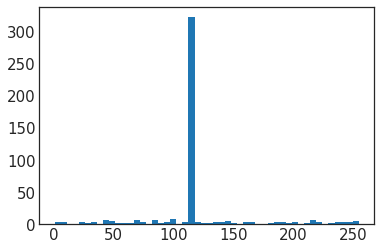

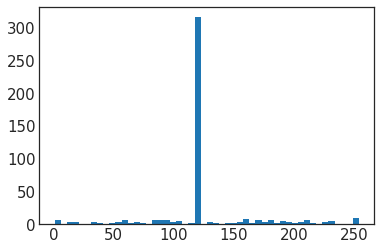

[[113 118]
 [113 118]
 [113  68]
 [113 118]
 [113 227]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [137 118]
 [113  82]
 [113  88]
 [113 118]
 [113  86]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [146 118]
 [223 118]
 [ 25 118]
 [113 118]
 [133 118]
 [113 227]
 [252 118]
 [113 211]
 [113 118]
 [113 118]
 [113 118]
 [113 161]
 [113 118]
 [113 118]
 [ 84 118]
 [113 118]
 [113 118]
 [113 118]
 [113 231]
 [113 118]
 [113 118]
 [113 118]
 [ 49 118]
 [161 118]
 [113 118]
 [113 183]
 [113 118]
 [113 118]
 [100 118]
 [201 118]
 [113 118]
 [113  88]
 [244 118]
 [113 229]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113  63]
 [113 118]
 [113 118]
 [113 231]
 [113 118]
 [ 49 118]
 [113 118]
 [113  14]
 [113 118]
 [113 170]
 [113 118]
 [113 118]
 [113 132]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 132]
 [255 118]
 [113 118]
 [113 118]
 [113 118]
 [ 69  88]
 [113 100]
 [113  82]
 [113 118]
 [160 118]
 [113   2]
 [198  40]
 [244 118]
 [113 118]
 [113 118]
 [113 118]

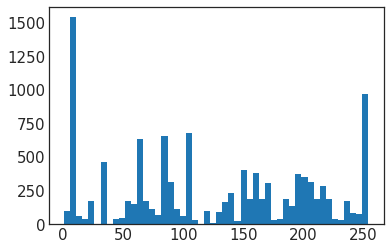

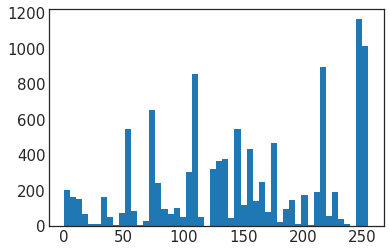

[[171 215]
 [  9  90]
 [ 77 107]
 ...
 [155 108]
 [ 25 211]
 [252 254]]
{'171': 37, '9': 718, '77': 27, '250': 655, '7': 723, '8': 100, '209': 183, '66': 519, '232': 18, '248': 57, '163': 187, '214': 269, '187': 115, '189': 55, '130': 76, '103': 484, '152': 344, '4': 80, '32': 412, '200': 148, '239': 67, '181': 38, '252': 139, '199': 110, '196': 32, '138': 209, '236': 127, '97': 25, '68': 108, '188': 63, '132': 1, '190': 77, '87': 294, '195': 338, '162': 258, '20': 21, '145': 9, '121': 78, '203': 44, '155': 185, '25': 119, '53': 71, '85': 328, '73': 110, '105': 167, '92': 314, '170': 232, '201': 39, '207': 303, '94': 18, '63': 109, '135': 66, '220': 121, '254': 83, '238': 43, '61': 129, '134': 93, '98': 60, '96': 53, '221': 64, '160': 115, '15': 50, '93': 17, '58': 15, '168': 31, '120': 20, '70': 48, '176': 29, '129': 5, '52': 59, '45': 11, '2': 6, '71': 20, '159': 11, '79': 5, '146': 9, '43': 21, '41': 4, '107': 24, '224': 12, '111': 28, '81': 7, '56': 43, '151': 15, '150': 44, '47': 

100%|██████████| 307/307 [00:11<00:00, 27.83it/s]



Test set: Average loss: 0.4586, Accuracy: 11009/12630 (87.17%)
New Best Accuracy: (87.17%) at Epoch: (1)

Epoch:     2


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.2689, Accuracy: 11713/12630 (92.74%)
New Best Accuracy: (92.74%) at Epoch: (2)

Epoch:     3


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]



Test set: Average loss: 0.2147, Accuracy: 11873/12630 (94.01%)
New Best Accuracy: (94.01%) at Epoch: (3)

Epoch:     4


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]



Test set: Average loss: 0.2014, Accuracy: 11921/12630 (94.39%)
New Best Accuracy: (94.39%) at Epoch: (4)

Epoch:     5


100%|██████████| 307/307 [00:10<00:00, 27.95it/s]



Test set: Average loss: 0.1810, Accuracy: 11972/12630 (94.79%)
New Best Accuracy: (94.79%) at Epoch: (5)

Epoch:     6


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]



Test set: Average loss: 0.1744, Accuracy: 11994/12630 (94.96%)
New Best Accuracy: (94.96%) at Epoch: (6)

Epoch:     7


100%|██████████| 307/307 [00:10<00:00, 27.94it/s]



Test set: Average loss: 0.1733, Accuracy: 11999/12630 (95.00%)
New Best Accuracy: (95.00%) at Epoch: (7)

Epoch:     8


100%|██████████| 307/307 [00:10<00:00, 27.98it/s]



Test set: Average loss: 0.1767, Accuracy: 11993/12630 (94.96%)
Epoch:     9


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]



Test set: Average loss: 0.1495, Accuracy: 12060/12630 (95.49%)
New Best Accuracy: (95.49%) at Epoch: (9)

Epoch:    10


100%|██████████| 307/307 [00:10<00:00, 27.98it/s]



Test set: Average loss: 0.1656, Accuracy: 12016/12630 (95.14%)
Epoch:    11


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.2043, Accuracy: 11942/12630 (94.55%)
Epoch:    12


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1648, Accuracy: 12011/12630 (95.10%)
Epoch:    13


100%|██████████| 307/307 [00:10<00:00, 27.97it/s]



Test set: Average loss: 0.1424, Accuracy: 12123/12630 (95.99%)
New Best Accuracy: (95.99%) at Epoch: (13)

Epoch:    14


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1266, Accuracy: 12173/12630 (96.38%)
New Best Accuracy: (96.38%) at Epoch: (14)

Epoch:    15


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]



Test set: Average loss: 0.1280, Accuracy: 12185/12630 (96.48%)
New Best Accuracy: (96.48%) at Epoch: (15)

Epoch:    16


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1298, Accuracy: 12173/12630 (96.38%)
Epoch:    17


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.1195, Accuracy: 12205/12630 (96.63%)
New Best Accuracy: (96.63%) at Epoch: (17)

Epoch:    18


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1186, Accuracy: 12213/12630 (96.70%)
New Best Accuracy: (96.70%) at Epoch: (18)

Epoch:    19


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1904, Accuracy: 11979/12630 (94.85%)
Epoch:    20


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1860, Accuracy: 12024/12630 (95.20%)
Epoch:    21


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1517, Accuracy: 12121/12630 (95.97%)
Epoch:    22


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1212, Accuracy: 12244/12630 (96.94%)
New Best Accuracy: (96.94%) at Epoch: (22)

Epoch:    23


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1087, Accuracy: 12264/12630 (97.10%)
New Best Accuracy: (97.10%) at Epoch: (23)

Epoch:    24


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1114, Accuracy: 12257/12630 (97.05%)
Epoch:    25


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.1177, Accuracy: 12258/12630 (97.05%)
Epoch:    26


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1167, Accuracy: 12240/12630 (96.91%)
Epoch:    27


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1212, Accuracy: 12241/12630 (96.92%)
Epoch:    28


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1927, Accuracy: 12017/12630 (95.15%)
Epoch:    29


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1806, Accuracy: 12068/12630 (95.55%)
Epoch:    30


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.0982, Accuracy: 12305/12630 (97.43%)
New Best Accuracy: (97.43%) at Epoch: (30)

Epoch:    31


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.0912, Accuracy: 12318/12630 (97.53%)
New Best Accuracy: (97.53%) at Epoch: (31)

Epoch:    32


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.0966, Accuracy: 12301/12630 (97.40%)
Epoch:    33


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.0984, Accuracy: 12308/12630 (97.45%)
Epoch:    34


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.0959, Accuracy: 12313/12630 (97.49%)
Epoch:    35


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.0988, Accuracy: 12304/12630 (97.42%)
Epoch:    36


100%|██████████| 307/307 [00:10<00:00, 27.98it/s]



Test set: Average loss: 0.1099, Accuracy: 12281/12630 (97.24%)
Epoch:    37


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.0954, Accuracy: 12315/12630 (97.51%)
Epoch:    38


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.2538, Accuracy: 11757/12630 (93.09%)
Epoch:    39


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1101, Accuracy: 12245/12630 (96.95%)
Epoch:    40


100%|██████████| 307/307 [00:10<00:00, 27.98it/s]



Test set: Average loss: 0.1068, Accuracy: 12279/12630 (97.22%)
Epoch:    41


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1125, Accuracy: 12252/12630 (97.01%)
Epoch:    42


100%|██████████| 307/307 [00:10<00:00, 28.07it/s]



Test set: Average loss: 0.0890, Accuracy: 12336/12630 (97.67%)
New Best Accuracy: (97.67%) at Epoch: (42)

Epoch:    43


100%|██████████| 307/307 [00:10<00:00, 28.09it/s]



Test set: Average loss: 0.0913, Accuracy: 12316/12630 (97.51%)
Epoch:    44


100%|██████████| 307/307 [00:10<00:00, 28.12it/s]



Test set: Average loss: 0.0894, Accuracy: 12344/12630 (97.74%)
New Best Accuracy: (97.74%) at Epoch: (44)

Epoch:    45


100%|██████████| 307/307 [00:10<00:00, 28.12it/s]



Test set: Average loss: 0.1131, Accuracy: 12248/12630 (96.98%)
Epoch:    46


100%|██████████| 307/307 [00:10<00:00, 28.10it/s]



Test set: Average loss: 0.0992, Accuracy: 12297/12630 (97.36%)
Epoch:    47


100%|██████████| 307/307 [00:10<00:00, 28.08it/s]



Test set: Average loss: 0.1308, Accuracy: 12173/12630 (96.38%)
Epoch:    48


100%|██████████| 307/307 [00:10<00:00, 28.12it/s]



Test set: Average loss: 0.1070, Accuracy: 12281/12630 (97.24%)
Epoch:    49


100%|██████████| 307/307 [00:10<00:00, 28.10it/s]



Test set: Average loss: 0.1083, Accuracy: 12267/12630 (97.13%)
Epoch:    50


100%|██████████| 307/307 [00:10<00:00, 28.08it/s]



Test set: Average loss: 0.0989, Accuracy: 12296/12630 (97.36%)
Epoch:    51


100%|██████████| 307/307 [00:10<00:00, 28.11it/s]



Test set: Average loss: 0.0935, Accuracy: 12330/12630 (97.62%)
Epoch:    52


100%|██████████| 307/307 [00:10<00:00, 28.13it/s]



Test set: Average loss: 0.0946, Accuracy: 12330/12630 (97.62%)
Epoch:    53


100%|██████████| 307/307 [00:10<00:00, 28.11it/s]



Test set: Average loss: 0.1048, Accuracy: 12289/12630 (97.30%)
Epoch:    54


100%|██████████| 307/307 [00:10<00:00, 28.08it/s]



Test set: Average loss: 0.0991, Accuracy: 12282/12630 (97.24%)
Epoch:    55


100%|██████████| 307/307 [00:10<00:00, 28.07it/s]



Test set: Average loss: 0.0992, Accuracy: 12315/12630 (97.51%)
Epoch:    56


100%|██████████| 307/307 [00:10<00:00, 28.07it/s]



Test set: Average loss: 0.1372, Accuracy: 12166/12630 (96.33%)
Epoch:    57


100%|██████████| 307/307 [00:10<00:00, 28.08it/s]



Test set: Average loss: 0.1010, Accuracy: 12299/12630 (97.38%)
Epoch:    58


100%|██████████| 307/307 [00:10<00:00, 28.10it/s]



Test set: Average loss: 0.0953, Accuracy: 12297/12630 (97.36%)
Epoch:    59


100%|██████████| 307/307 [00:10<00:00, 28.06it/s]



Test set: Average loss: 0.0925, Accuracy: 12310/12630 (97.47%)
Epoch:    60


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.0902, Accuracy: 12325/12630 (97.59%)
Epoch:    61


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.0914, Accuracy: 12336/12630 (97.67%)
Epoch:    62


100%|██████████| 307/307 [00:10<00:00, 28.05it/s]



Test set: Average loss: 0.0894, Accuracy: 12347/12630 (97.76%)
New Best Accuracy: (97.76%) at Epoch: (62)

Epoch:    63


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.0919, Accuracy: 12341/12630 (97.71%)
Epoch:    64


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.0971, Accuracy: 12320/12630 (97.55%)
Epoch:    65


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1370, Accuracy: 12143/12630 (96.14%)
Epoch:    66


100%|██████████| 307/307 [00:10<00:00, 28.06it/s]



Test set: Average loss: 0.1067, Accuracy: 12241/12630 (96.92%)
Epoch:    67


100%|██████████| 307/307 [00:10<00:00, 28.09it/s]



Test set: Average loss: 0.0945, Accuracy: 12293/12630 (97.33%)
Epoch:    68


100%|██████████| 307/307 [00:10<00:00, 28.10it/s]



Test set: Average loss: 0.0976, Accuracy: 12305/12630 (97.43%)
Epoch:    69


100%|██████████| 307/307 [00:10<00:00, 28.13it/s]



Test set: Average loss: 0.0950, Accuracy: 12304/12630 (97.42%)
Epoch:    70


100%|██████████| 307/307 [00:10<00:00, 28.11it/s]



Test set: Average loss: 0.1102, Accuracy: 12261/12630 (97.08%)
Epoch:    71


100%|██████████| 307/307 [00:10<00:00, 28.14it/s]



Test set: Average loss: 0.0935, Accuracy: 12303/12630 (97.41%)
Epoch:    72


100%|██████████| 307/307 [00:10<00:00, 28.13it/s]



Test set: Average loss: 0.0954, Accuracy: 12292/12630 (97.32%)
Epoch:    73


100%|██████████| 307/307 [00:10<00:00, 28.15it/s]



Test set: Average loss: 0.0993, Accuracy: 12294/12630 (97.34%)
Epoch:    74


100%|██████████| 307/307 [00:10<00:00, 28.16it/s]



Test set: Average loss: 0.1803, Accuracy: 11986/12630 (94.90%)
Epoch:    75


100%|██████████| 307/307 [00:10<00:00, 28.15it/s]



Test set: Average loss: 0.1289, Accuracy: 12203/12630 (96.62%)
Epoch:    76


100%|██████████| 307/307 [00:10<00:00, 28.14it/s]



Test set: Average loss: 0.1113, Accuracy: 12240/12630 (96.91%)
Epoch:    77


100%|██████████| 307/307 [00:10<00:00, 28.13it/s]



Test set: Average loss: 0.0988, Accuracy: 12286/12630 (97.28%)
Epoch:    78


100%|██████████| 307/307 [00:10<00:00, 28.15it/s]



Test set: Average loss: 0.0871, Accuracy: 12338/12630 (97.69%)
Epoch:    79


100%|██████████| 307/307 [00:10<00:00, 28.15it/s]



Test set: Average loss: 0.0876, Accuracy: 12347/12630 (97.76%)
Epoch:    80


100%|██████████| 307/307 [00:10<00:00, 28.13it/s]



Test set: Average loss: 0.0901, Accuracy: 12329/12630 (97.62%)

===retrain PQ part

torch.Size([168, 1, 3, 3])
torch.Size([192, 168, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


100%|██████████| 307/307 [00:07<00:00, 38.67it/s]



Test set: Average loss: 3.5241, Accuracy: 720/12630 (5.70%)
New Best Accuracy: (5.70%) at Epoch: (1)

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)


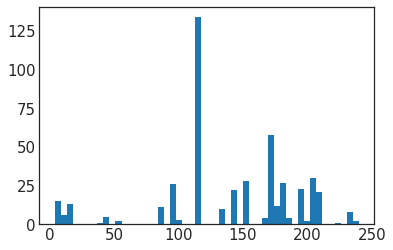

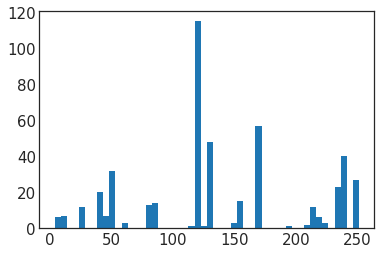

[[113 118]
 [113 118]
 [113  39]
 [113 118]
 [113 152]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 125]
 [113 132]
 [113 118]
 [113  47]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [195 118]
 [171 118]
 [171 118]
 [113 118]
 [145 118]
 [113  86]
 [171 118]
 [113  79]
 [113 118]
 [113 118]
 [113 118]
 [113 248]
 [113 118]
 [113 118]
 [240 118]
 [113 118]
 [113 118]
 [113 118]
 [113 116]
 [113 118]
 [113 118]
 [113 118]
 [ 96 118]
 [134 118]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [136 118]
 [145 118]
 [113 118]
 [113 132]
 [ 15 118]
 [113 240]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113  13]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [ 96 118]
 [113 118]
 [113 217]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 169]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113 118]
 [113  39]
 [171 118]
 [113 118]
 [113 118]
 [113 118]
 [ 15 251]
 [113  13]
 [113 248]
 [113 118]
 [145 251]
 [171 169]
 [171  39]
 [ 15 241]
 [  4 169]
 [113 217]
 [113 236]

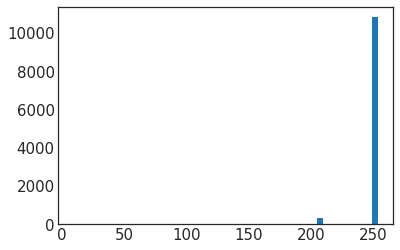

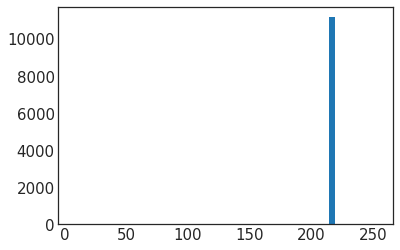

[[250 215]
 [250 215]
 [250 215]
 ...
 [250 215]
 [250 215]
 [250 215]]
{'250': 10828, '152': 23, '32': 4, '209': 346, '121': 19, '9': 7, '254': 2, '66': 1, '170': 1, '68': 1}
Highest value from dictionary: 250
{'215': 11184, '254': 13, '145': 2, '51': 10, '110': 17, '94': 1, '7': 1, '107': 3, '108': 1}
Highest value from dictionary: 215
[[250 215]
 [250 215]
 [250 215]
 ...
 [250 215]
 [250 215]
 [250 215]]
[[[3, '7', '1'], [4, '3', '0'], [17, '4', '0'], [353, '9', '0'], [11197, '0', '0'], [11232, '[', '1'], [11232, ']', '0'], [11260, ' ', '1'], [11297, '1', '0'], [22068, '5', '0'], [22425, '2', '1']], [[7, '73', '1'], [17, '4', '0'], [353, '9', '0'], [11197, '0', '0'], [11232, '[', '1'], [11232, ']', '0'], [11260, ' ', '1'], [11297, '1', '0'], [22068, '5', '0'], [22425, '2', '1']], [[24, '734', '1'], [353, '9', '0'], [11197, '0', '0'], [11232, '[', '1'], [11232, ']', '0'], [11260, ' ', '1'], [11297, '1', '0'], [22068, '5', '0'], [22425, '2', '1']], [[377, '7349', '1'], [11197, '0', '

100%|██████████| 307/307 [00:11<00:00, 27.82it/s]



Test set: Average loss: 1.7646, Accuracy: 6544/12630 (51.81%)
New Best Accuracy: (51.81%) at Epoch: (1)

Epoch:     2


100%|██████████| 307/307 [00:10<00:00, 27.98it/s]



Test set: Average loss: 0.7836, Accuracy: 9923/12630 (78.57%)
New Best Accuracy: (78.57%) at Epoch: (2)

Epoch:     3


100%|██████████| 307/307 [00:10<00:00, 27.95it/s]



Test set: Average loss: 1.0311, Accuracy: 8981/12630 (71.11%)
Epoch:     4


100%|██████████| 307/307 [00:10<00:00, 27.95it/s]



Test set: Average loss: 0.3952, Accuracy: 11273/12630 (89.26%)
New Best Accuracy: (89.26%) at Epoch: (4)

Epoch:     5


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]



Test set: Average loss: 0.3252, Accuracy: 11524/12630 (91.24%)
New Best Accuracy: (91.24%) at Epoch: (5)

Epoch:     6


100%|██████████| 307/307 [00:10<00:00, 27.95it/s]



Test set: Average loss: 0.2702, Accuracy: 11677/12630 (92.45%)
New Best Accuracy: (92.45%) at Epoch: (6)

Epoch:     7


100%|██████████| 307/307 [00:10<00:00, 27.97it/s]



Test set: Average loss: 0.2445, Accuracy: 11716/12630 (92.76%)
New Best Accuracy: (92.76%) at Epoch: (7)

Epoch:     8


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.2303, Accuracy: 11826/12630 (93.63%)
New Best Accuracy: (93.63%) at Epoch: (8)

Epoch:     9


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.2431, Accuracy: 11728/12630 (92.86%)
Epoch:    10


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.2695, Accuracy: 11701/12630 (92.64%)
Epoch:    11


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.2049, Accuracy: 11905/12630 (94.26%)
New Best Accuracy: (94.26%) at Epoch: (11)

Epoch:    12


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.2414, Accuracy: 11810/12630 (93.51%)
Epoch:    13


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.2460, Accuracy: 11843/12630 (93.77%)
Epoch:    14


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.2092, Accuracy: 11883/12630 (94.09%)
Epoch:    15


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1991, Accuracy: 11966/12630 (94.74%)
New Best Accuracy: (94.74%) at Epoch: (15)

Epoch:    16


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.2302, Accuracy: 11804/12630 (93.46%)
Epoch:    17


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1916, Accuracy: 11974/12630 (94.81%)
New Best Accuracy: (94.81%) at Epoch: (17)

Epoch:    18


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.2117, Accuracy: 11882/12630 (94.08%)
Epoch:    19


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.2193, Accuracy: 11890/12630 (94.14%)
Epoch:    20


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]



Test set: Average loss: 0.1909, Accuracy: 11957/12630 (94.67%)
Epoch:    21


100%|██████████| 307/307 [00:10<00:00, 27.94it/s]



Test set: Average loss: 0.1801, Accuracy: 11983/12630 (94.88%)
New Best Accuracy: (94.88%) at Epoch: (21)

Epoch:    22


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1732, Accuracy: 11996/12630 (94.98%)
New Best Accuracy: (94.98%) at Epoch: (22)

Epoch:    23


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.1802, Accuracy: 12014/12630 (95.12%)
New Best Accuracy: (95.12%) at Epoch: (23)

Epoch:    24


100%|██████████| 307/307 [00:10<00:00, 28.07it/s]



Test set: Average loss: 0.1570, Accuracy: 12074/12630 (95.60%)
New Best Accuracy: (95.60%) at Epoch: (24)

Epoch:    25


100%|██████████| 307/307 [00:10<00:00, 28.06it/s]



Test set: Average loss: 0.1905, Accuracy: 11936/12630 (94.51%)
Epoch:    26


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1777, Accuracy: 12018/12630 (95.15%)
Epoch:    27


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1440, Accuracy: 12123/12630 (95.99%)
New Best Accuracy: (95.99%) at Epoch: (27)

Epoch:    28


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1850, Accuracy: 11996/12630 (94.98%)
Epoch:    29


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1723, Accuracy: 12032/12630 (95.27%)
Epoch:    30


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1934, Accuracy: 11939/12630 (94.53%)
Epoch:    31


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.2219, Accuracy: 11855/12630 (93.86%)
Epoch:    32


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.1822, Accuracy: 11978/12630 (94.84%)
Epoch:    33


100%|██████████| 307/307 [00:10<00:00, 27.98it/s]



Test set: Average loss: 0.1609, Accuracy: 12058/12630 (95.47%)
Epoch:    34


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1392, Accuracy: 12120/12630 (95.96%)
Epoch:    35


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1563, Accuracy: 12074/12630 (95.60%)
Epoch:    36


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1472, Accuracy: 12106/12630 (95.85%)
Epoch:    37


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1233, Accuracy: 12194/12630 (96.55%)
New Best Accuracy: (96.55%) at Epoch: (37)

Epoch:    38


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1251, Accuracy: 12182/12630 (96.45%)
Epoch:    39


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1383, Accuracy: 12142/12630 (96.14%)
Epoch:    40


100%|██████████| 307/307 [00:10<00:00, 27.97it/s]



Test set: Average loss: 0.3005, Accuracy: 11608/12630 (91.91%)
Epoch:    41


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1870, Accuracy: 11968/12630 (94.76%)
Epoch:    42


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.1372, Accuracy: 12159/12630 (96.27%)
Epoch:    43


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.1301, Accuracy: 12152/12630 (96.22%)
Epoch:    44


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1326, Accuracy: 12140/12630 (96.12%)
Epoch:    45


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.1559, Accuracy: 12051/12630 (95.42%)
Epoch:    46


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1397, Accuracy: 12143/12630 (96.14%)
Epoch:    47


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1341, Accuracy: 12179/12630 (96.43%)
Epoch:    48


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1724, Accuracy: 12017/12630 (95.15%)
Epoch:    49


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1687, Accuracy: 12039/12630 (95.32%)
Epoch:    50


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1190, Accuracy: 12214/12630 (96.71%)
New Best Accuracy: (96.71%) at Epoch: (50)

Epoch:    51


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1408, Accuracy: 12145/12630 (96.16%)
Epoch:    52


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1109, Accuracy: 12235/12630 (96.87%)
New Best Accuracy: (96.87%) at Epoch: (52)

Epoch:    53


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1122, Accuracy: 12242/12630 (96.93%)
New Best Accuracy: (96.93%) at Epoch: (53)

Epoch:    54


100%|██████████| 307/307 [00:10<00:00, 27.97it/s]



Test set: Average loss: 0.1118, Accuracy: 12249/12630 (96.98%)
New Best Accuracy: (96.98%) at Epoch: (54)

Epoch:    55


100%|██████████| 307/307 [00:10<00:00, 28.01it/s]



Test set: Average loss: 0.1163, Accuracy: 12230/12630 (96.83%)
Epoch:    56


100%|██████████| 307/307 [00:10<00:00, 27.97it/s]



Test set: Average loss: 0.1185, Accuracy: 12209/12630 (96.67%)
Epoch:    57


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.2406, Accuracy: 11835/12630 (93.71%)
Epoch:    58


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.1487, Accuracy: 12101/12630 (95.81%)
Epoch:    59


100%|██████████| 307/307 [00:10<00:00, 28.05it/s]



Test set: Average loss: 0.1205, Accuracy: 12229/12630 (96.83%)
Epoch:    60


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1052, Accuracy: 12276/12630 (97.20%)
New Best Accuracy: (97.20%) at Epoch: (60)

Epoch:    61


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1061, Accuracy: 12265/12630 (97.11%)
Epoch:    62


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1054, Accuracy: 12264/12630 (97.10%)
Epoch:    63


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1044, Accuracy: 12273/12630 (97.17%)
Epoch:    64


100%|██████████| 307/307 [00:10<00:00, 27.98it/s]



Test set: Average loss: 0.1088, Accuracy: 12260/12630 (97.07%)
Epoch:    65


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.1356, Accuracy: 12158/12630 (96.26%)
Epoch:    66


100%|██████████| 307/307 [00:10<00:00, 28.02it/s]



Test set: Average loss: 0.1177, Accuracy: 12235/12630 (96.87%)
Epoch:    67


100%|██████████| 307/307 [00:10<00:00, 28.00it/s]



Test set: Average loss: 0.0898, Accuracy: 12317/12630 (97.52%)
New Best Accuracy: (97.52%) at Epoch: (67)

Epoch:    68


100%|██████████| 307/307 [00:10<00:00, 27.99it/s]



Test set: Average loss: 0.0898, Accuracy: 12309/12630 (97.46%)
Epoch:    69


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.0964, Accuracy: 12284/12630 (97.26%)
Epoch:    70


100%|██████████| 307/307 [00:10<00:00, 28.05it/s]



Test set: Average loss: 0.0975, Accuracy: 12295/12630 (97.35%)
Epoch:    71


100%|██████████| 307/307 [00:10<00:00, 28.05it/s]



Test set: Average loss: 0.0993, Accuracy: 12295/12630 (97.35%)
Epoch:    72


100%|██████████| 307/307 [00:10<00:00, 28.10it/s]



Test set: Average loss: 0.0981, Accuracy: 12294/12630 (97.34%)
Epoch:    73


100%|██████████| 307/307 [00:10<00:00, 28.06it/s]



Test set: Average loss: 0.0967, Accuracy: 12303/12630 (97.41%)
Epoch:    74


100%|██████████| 307/307 [00:10<00:00, 28.04it/s]



Test set: Average loss: 0.2416, Accuracy: 11909/12630 (94.29%)
Epoch:    75


100%|██████████| 307/307 [00:10<00:00, 28.03it/s]



Test set: Average loss: 0.1549, Accuracy: 12087/12630 (95.70%)
Epoch:    76


100%|██████████| 307/307 [00:10<00:00, 28.07it/s]



Test set: Average loss: 0.1056, Accuracy: 12237/12630 (96.89%)
Epoch:    77


100%|██████████| 307/307 [00:10<00:00, 28.18it/s]



Test set: Average loss: 0.0995, Accuracy: 12275/12630 (97.19%)
Epoch:    78


100%|██████████| 307/307 [00:10<00:00, 28.18it/s]



Test set: Average loss: 0.0977, Accuracy: 12281/12630 (97.24%)
Epoch:    79


100%|██████████| 307/307 [00:10<00:00, 28.12it/s]



Test set: Average loss: 0.1012, Accuracy: 12277/12630 (97.21%)
Epoch:    80


100%|██████████| 307/307 [00:10<00:00, 28.09it/s]



Test set: Average loss: 0.1002, Accuracy: 12271/12630 (97.16%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 97.52% / 97.16% (95.50%) at Epoch: 67


===== target accuracy is achieved =====


In [48]:
# Test set: Average loss: 0.0712, Accuracy: 12411/12630 (97.74%)
pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
pqconv3x3.train(wconv3x3_4)
pqfc = faiss.ProductQuantizer(16, 2, 8)
pqfc.train(wfc_4)
recon_gtsrb = testModelAndCodebooksWTargetAccG(args,
                target_acc=97.50-2,
                model=gtsrb,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-AD-I-ch168',
                dataset='gtsrb-vw',
                device=device,
                train_loader=train_loader_gtsrb,
                test_loader=test_loader_gtsrb,
                start_from_pretrained=False,
                reverse_tune=True)



===== Iteration Loop: 1th =====

torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([112, 1, 3, 3])
feat.shape:  (1, 6048)
reshaped_feat.shape:  (336, 18)


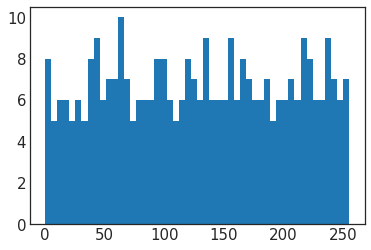

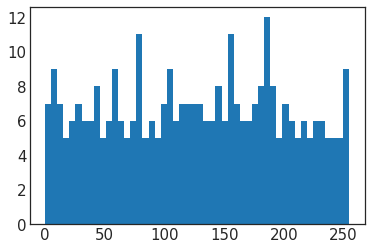

[[180 180]
 [118  14]
 [142 123]
 [151 135]
 [133 161]
 [ 95  95]
 [185 159]
 [166 166]
 [178 178]
 [139 139]
 [249 249]
 [123 123]
 [ 98  98]
 [241 241]
 [ 34  34]
 [145 145]
 [215 215]
 [ 23  23]
 [123  28]
 [118 188]
 [159 159]
 [ 17  17]
 [ 77  78]
 [172 172]
 [129  78]
 [ 60  60]
 [162 162]
 [242 242]
 [ 37 227]
 [ 82  82]
 [ 16  16]
 [ 68 107]
 [135  32]
 [149 149]
 [ 93  93]
 [140 215]
 [ 47  47]
 [ 63  63]
 [ 30 111]
 [122 122]
 [ 70  70]
 [ 94  75]
 [144 144]
 [156 156]
 [  7   7]
 [131 131]
 [222 222]
 [253 253]
 [194 194]
 [ 89  89]
 [100 100]
 [ 61  26]
 [166 156]
 [252 252]
 [ 99  99]
 [103 103]
 [117 117]
 [  8   8]
 [ 37  37]
 [107 107]
 [205 205]
 [ 54  77]
 [119 119]
 [146 146]
 [182 182]
 [251 251]
 [ 29  29]
 [191 191]
 [ 73  73]
 [163 163]
 [ 25  25]
 [254 145]
 [133 133]
 [154 154]
 [181 181]
 [118 118]
 [ 65  65]
 [233 233]
 [215  59]
 [ 86  86]
 [175 175]
 [199 192]
 [ 82 187]
 [185 185]
 [102 102]
 [ 58  58]
 [239 239]
 [166 157]
 [ 42 188]
 [230 230]
 [ 56  56]

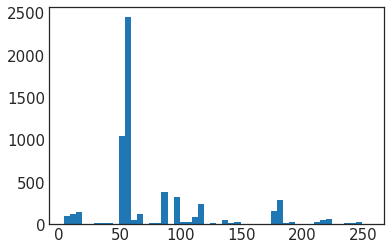

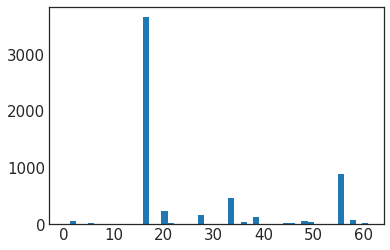

[[178  20]
 [ 50  16]
 [ 95  34]
 ...
 [ 55  55]
 [ 55  55]
 [ 50  16]]
{'178': 152, '50': 1042, '95': 318, '242': 19, '55': 2428, '88': 192, '17': 95, '6': 80, '85': 189, '183': 286, '213': 24, '193': 17, '116': 149, '59': 36, '223': 63, '4': 4, '99': 17, '145': 26, '132': 4, '56': 13, '109': 75, '15': 31, '57': 1, '227': 7, '137': 2, '65': 80, '63': 13, '10': 112, '114': 88, '134': 20, '81': 20, '78': 6, '72': 5, '106': 32, '244': 26, '39': 14, '237': 11, '64': 23, '38': 15, '102': 2, '142': 3, '68': 19, '53': 1, '187': 10, '33': 7, '75': 7, '101': 3, '8': 14, '216': 45, '209': 4, '126': 3, '119': 8, '48': 2, '124': 7, '144': 2, '138': 23, '143': 9, '84': 2, '13': 9, '77': 3, '167': 1, '128': 1, '208': 1, '234': 9, '9': 2, '166': 3, '110': 4, '32': 7, '254': 2, '239': 1, '16': 6, '184': 4, '14': 14, '247': 1, '196': 2, '192': 6, '54': 4, '103': 1, '207': 2, '136': 3, '191': 3, '97': 6, '160': 3, '60': 2, '245': 1, '161': 2, '25': 1, '252': 3, '188': 1, '225': 1, '230': 2, '205': 2, '

100%|██████████| 324/324 [00:04<00:00, 66.13it/s]



Test set: Average loss: 1.9620, Accuracy: 1874/4890 (38.32%)
New Best Accuracy: (38.32%) at Epoch: (1)

Epoch:     2


100%|██████████| 324/324 [00:04<00:00, 66.92it/s]



Test set: Average loss: 1.5454, Accuracy: 2448/4890 (50.06%)
New Best Accuracy: (50.06%) at Epoch: (2)

Epoch:     3


100%|██████████| 324/324 [00:04<00:00, 66.72it/s]



Test set: Average loss: 1.3356, Accuracy: 2743/4890 (56.09%)
New Best Accuracy: (56.09%) at Epoch: (3)

Epoch:     4


100%|██████████| 324/324 [00:04<00:00, 66.56it/s]



Test set: Average loss: 1.2050, Accuracy: 2938/4890 (60.08%)
New Best Accuracy: (60.08%) at Epoch: (4)

Epoch:     5


100%|██████████| 324/324 [00:04<00:00, 66.48it/s]



Test set: Average loss: 1.1182, Accuracy: 3040/4890 (62.17%)
New Best Accuracy: (62.17%) at Epoch: (5)

Epoch:     6


100%|██████████| 324/324 [00:04<00:00, 66.35it/s]



Test set: Average loss: 1.0495, Accuracy: 3166/4890 (64.74%)
New Best Accuracy: (64.74%) at Epoch: (6)

Epoch:     7


100%|██████████| 324/324 [00:04<00:00, 66.35it/s]



Test set: Average loss: 1.0001, Accuracy: 3242/4890 (66.30%)
New Best Accuracy: (66.30%) at Epoch: (7)

Epoch:     8


100%|██████████| 324/324 [00:04<00:00, 66.19it/s]



Test set: Average loss: 0.9542, Accuracy: 3328/4890 (68.06%)
New Best Accuracy: (68.06%) at Epoch: (8)

Epoch:     9


100%|██████████| 324/324 [00:04<00:00, 66.11it/s]



Test set: Average loss: 0.9160, Accuracy: 3376/4890 (69.04%)
New Best Accuracy: (69.04%) at Epoch: (9)

Epoch:    10


100%|██████████| 324/324 [00:04<00:00, 65.84it/s]



Test set: Average loss: 0.8713, Accuracy: 3453/4890 (70.61%)
New Best Accuracy: (70.61%) at Epoch: (10)

Epoch:    11


100%|██████████| 324/324 [00:04<00:00, 65.80it/s]



Test set: Average loss: 0.8450, Accuracy: 3511/4890 (71.80%)
New Best Accuracy: (71.80%) at Epoch: (11)

Epoch:    12


100%|██████████| 324/324 [00:04<00:00, 65.70it/s]



Test set: Average loss: 0.8314, Accuracy: 3545/4890 (72.49%)
New Best Accuracy: (72.49%) at Epoch: (12)

Epoch:    13


100%|██████████| 324/324 [00:04<00:00, 65.53it/s]



Test set: Average loss: 0.8051, Accuracy: 3575/4890 (73.11%)
New Best Accuracy: (73.11%) at Epoch: (13)

Epoch:    14


100%|██████████| 324/324 [00:04<00:00, 65.30it/s]



Test set: Average loss: 0.7924, Accuracy: 3616/4890 (73.95%)
New Best Accuracy: (73.95%) at Epoch: (14)

Epoch:    15


100%|██████████| 324/324 [00:04<00:00, 65.14it/s]



Test set: Average loss: 0.7782, Accuracy: 3642/4890 (74.48%)
New Best Accuracy: (74.48%) at Epoch: (15)

Epoch:    16


100%|██████████| 324/324 [00:04<00:00, 65.16it/s]



Test set: Average loss: 0.7685, Accuracy: 3653/4890 (74.70%)
New Best Accuracy: (74.70%) at Epoch: (16)

Epoch:    17


100%|██████████| 324/324 [00:04<00:00, 64.95it/s]



Test set: Average loss: 0.7638, Accuracy: 3650/4890 (74.64%)
Epoch:    18


100%|██████████| 324/324 [00:04<00:00, 64.99it/s]



Test set: Average loss: 0.7456, Accuracy: 3670/4890 (75.05%)
New Best Accuracy: (75.05%) at Epoch: (18)

Epoch:    19


100%|██████████| 324/324 [00:04<00:00, 64.84it/s]



Test set: Average loss: 0.7418, Accuracy: 3669/4890 (75.03%)
Epoch:    20


100%|██████████| 324/324 [00:05<00:00, 64.75it/s]



Test set: Average loss: 0.7282, Accuracy: 3696/4890 (75.58%)
New Best Accuracy: (75.58%) at Epoch: (20)

Epoch:    21


100%|██████████| 324/324 [00:05<00:00, 64.68it/s]



Test set: Average loss: 0.7223, Accuracy: 3686/4890 (75.38%)
Epoch:    22


100%|██████████| 324/324 [00:05<00:00, 64.66it/s]



Test set: Average loss: 0.7257, Accuracy: 3714/4890 (75.95%)
New Best Accuracy: (75.95%) at Epoch: (22)

Epoch:    23


100%|██████████| 324/324 [00:05<00:00, 64.56it/s]



Test set: Average loss: 0.7089, Accuracy: 3754/4890 (76.77%)
New Best Accuracy: (76.77%) at Epoch: (23)

Epoch:    24


100%|██████████| 324/324 [00:05<00:00, 64.49it/s]



Test set: Average loss: 0.7149, Accuracy: 3721/4890 (76.09%)
Epoch:    25


100%|██████████| 324/324 [00:05<00:00, 64.31it/s]



Test set: Average loss: 0.6988, Accuracy: 3745/4890 (76.58%)
Epoch:    26


100%|██████████| 324/324 [00:05<00:00, 64.46it/s]



Test set: Average loss: 0.6990, Accuracy: 3762/4890 (76.93%)
New Best Accuracy: (76.93%) at Epoch: (26)

Epoch:    27


100%|██████████| 324/324 [00:05<00:00, 64.31it/s]



Test set: Average loss: 0.7145, Accuracy: 3752/4890 (76.73%)
Epoch:    28


100%|██████████| 324/324 [00:05<00:00, 64.29it/s]



Test set: Average loss: 0.6871, Accuracy: 3766/4890 (77.01%)
New Best Accuracy: (77.01%) at Epoch: (28)

Epoch:    29


100%|██████████| 324/324 [00:05<00:00, 63.94it/s]



Test set: Average loss: 0.6810, Accuracy: 3801/4890 (77.73%)
New Best Accuracy: (77.73%) at Epoch: (29)

Epoch:    30


100%|██████████| 324/324 [00:05<00:00, 64.15it/s]



Test set: Average loss: 0.6833, Accuracy: 3801/4890 (77.73%)
Epoch:    31


100%|██████████| 324/324 [00:05<00:00, 64.00it/s]



Test set: Average loss: 0.6787, Accuracy: 3792/4890 (77.55%)
Epoch:    32


100%|██████████| 324/324 [00:05<00:00, 63.95it/s]



Test set: Average loss: 0.6688, Accuracy: 3828/4890 (78.28%)
New Best Accuracy: (78.28%) at Epoch: (32)

Epoch:    33


100%|██████████| 324/324 [00:05<00:00, 63.81it/s]



Test set: Average loss: 0.6701, Accuracy: 3809/4890 (77.89%)
Epoch:    34


100%|██████████| 324/324 [00:05<00:00, 63.91it/s]



Test set: Average loss: 0.6652, Accuracy: 3841/4890 (78.55%)
New Best Accuracy: (78.55%) at Epoch: (34)

Epoch:    35


100%|██████████| 324/324 [00:05<00:00, 63.81it/s]



Test set: Average loss: 0.6772, Accuracy: 3808/4890 (77.87%)
Epoch:    36


100%|██████████| 324/324 [00:05<00:00, 63.89it/s]



Test set: Average loss: 0.6759, Accuracy: 3801/4890 (77.73%)
Epoch:    37


100%|██████████| 324/324 [00:05<00:00, 63.80it/s]



Test set: Average loss: 0.6677, Accuracy: 3807/4890 (77.85%)
Epoch:    38


100%|██████████| 324/324 [00:05<00:00, 63.84it/s]



Test set: Average loss: 0.6796, Accuracy: 3807/4890 (77.85%)
Epoch:    39


100%|██████████| 324/324 [00:05<00:00, 63.70it/s]



Test set: Average loss: 0.6683, Accuracy: 3846/4890 (78.65%)
New Best Accuracy: (78.65%) at Epoch: (39)

Epoch:    40


100%|██████████| 324/324 [00:05<00:00, 63.65it/s]



Test set: Average loss: 0.6728, Accuracy: 3843/4890 (78.59%)
Epoch:    41


100%|██████████| 324/324 [00:05<00:00, 63.56it/s]



Test set: Average loss: 0.6466, Accuracy: 3872/4890 (79.18%)
New Best Accuracy: (79.18%) at Epoch: (41)

Epoch:    42


100%|██████████| 324/324 [00:05<00:00, 63.48it/s]



Test set: Average loss: 0.6620, Accuracy: 3817/4890 (78.06%)
Epoch:    43


100%|██████████| 324/324 [00:05<00:00, 63.58it/s]



Test set: Average loss: 0.6811, Accuracy: 3821/4890 (78.14%)
Epoch:    44


100%|██████████| 324/324 [00:05<00:00, 63.55it/s]



Test set: Average loss: 0.6865, Accuracy: 3813/4890 (77.98%)
Epoch:    45


100%|██████████| 324/324 [00:05<00:00, 63.57it/s]



Test set: Average loss: 0.6672, Accuracy: 3815/4890 (78.02%)
Epoch:    46


100%|██████████| 324/324 [00:05<00:00, 63.58it/s]



Test set: Average loss: 0.6427, Accuracy: 3860/4890 (78.94%)
Epoch:    47


100%|██████████| 324/324 [00:05<00:00, 63.41it/s]



Test set: Average loss: 0.6685, Accuracy: 3799/4890 (77.69%)
Epoch:    48


100%|██████████| 324/324 [00:05<00:00, 63.36it/s]



Test set: Average loss: 0.6647, Accuracy: 3847/4890 (78.67%)
Epoch:    49


100%|██████████| 324/324 [00:05<00:00, 63.32it/s]



Test set: Average loss: 0.6793, Accuracy: 3792/4890 (77.55%)
Epoch:    50


100%|██████████| 324/324 [00:05<00:00, 63.29it/s]



Test set: Average loss: 0.6522, Accuracy: 3850/4890 (78.73%)
Epoch:    51


100%|██████████| 324/324 [00:05<00:00, 63.34it/s]



Test set: Average loss: 0.6720, Accuracy: 3860/4890 (78.94%)
Epoch:    52


100%|██████████| 324/324 [00:05<00:00, 63.42it/s]



Test set: Average loss: 0.6477, Accuracy: 3854/4890 (78.81%)
Epoch:    53


100%|██████████| 324/324 [00:05<00:00, 63.38it/s]



Test set: Average loss: 0.6416, Accuracy: 3870/4890 (79.14%)
Epoch:    54


100%|██████████| 324/324 [00:05<00:00, 63.24it/s]



Test set: Average loss: 0.6541, Accuracy: 3841/4890 (78.55%)
Epoch:    55


100%|██████████| 324/324 [00:05<00:00, 63.39it/s]



Test set: Average loss: 0.6410, Accuracy: 3872/4890 (79.18%)
Epoch:    56


100%|██████████| 324/324 [00:05<00:00, 62.91it/s]



Test set: Average loss: 0.6500, Accuracy: 3859/4890 (78.92%)
Epoch:    57


100%|██████████| 324/324 [00:05<00:00, 63.12it/s]



Test set: Average loss: 0.6439, Accuracy: 3871/4890 (79.16%)
Epoch:    58


100%|██████████| 324/324 [00:05<00:00, 63.10it/s]



Test set: Average loss: 0.6649, Accuracy: 3830/4890 (78.32%)
Epoch:    59


100%|██████████| 324/324 [00:05<00:00, 62.90it/s]



Test set: Average loss: 0.6682, Accuracy: 3842/4890 (78.57%)
Epoch:    60


100%|██████████| 324/324 [00:05<00:00, 62.32it/s]



Test set: Average loss: 0.6450, Accuracy: 3869/4890 (79.12%)
Epoch:    61


100%|██████████| 324/324 [00:05<00:00, 62.81it/s]



Test set: Average loss: 0.6443, Accuracy: 3895/4890 (79.65%)
New Best Accuracy: (79.65%) at Epoch: (61)

Epoch:    62


100%|██████████| 324/324 [00:05<00:00, 62.55it/s]



Test set: Average loss: 0.6641, Accuracy: 3852/4890 (78.77%)
Epoch:    63


100%|██████████| 324/324 [00:05<00:00, 62.88it/s]



Test set: Average loss: 0.6420, Accuracy: 3884/4890 (79.43%)
Epoch:    64


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6621, Accuracy: 3856/4890 (78.85%)
Epoch:    65


100%|██████████| 324/324 [00:05<00:00, 62.82it/s]



Test set: Average loss: 0.6565, Accuracy: 3888/4890 (79.51%)
Epoch:    66


100%|██████████| 324/324 [00:05<00:00, 62.97it/s]



Test set: Average loss: 0.6514, Accuracy: 3889/4890 (79.53%)
Epoch:    67


100%|██████████| 324/324 [00:05<00:00, 62.97it/s]



Test set: Average loss: 0.6484, Accuracy: 3877/4890 (79.28%)
Epoch:    68


100%|██████████| 324/324 [00:05<00:00, 62.92it/s]



Test set: Average loss: 0.6420, Accuracy: 3892/4890 (79.59%)
Epoch:    69


100%|██████████| 324/324 [00:05<00:00, 62.88it/s]



Test set: Average loss: 0.6511, Accuracy: 3864/4890 (79.02%)
Epoch:    70


100%|██████████| 324/324 [00:05<00:00, 62.87it/s]



Test set: Average loss: 0.6469, Accuracy: 3874/4890 (79.22%)
Epoch:    71


100%|██████████| 324/324 [00:05<00:00, 62.81it/s]



Test set: Average loss: 0.6602, Accuracy: 3886/4890 (79.47%)
Epoch:    72


100%|██████████| 324/324 [00:05<00:00, 62.89it/s]



Test set: Average loss: 0.6387, Accuracy: 3907/4890 (79.90%)
New Best Accuracy: (79.90%) at Epoch: (72)

Epoch:    73


100%|██████████| 324/324 [00:05<00:00, 62.64it/s]



Test set: Average loss: 0.6433, Accuracy: 3893/4890 (79.61%)
Epoch:    74


100%|██████████| 324/324 [00:05<00:00, 62.64it/s]



Test set: Average loss: 0.6572, Accuracy: 3884/4890 (79.43%)
Epoch:    75


100%|██████████| 324/324 [00:05<00:00, 62.66it/s]



Test set: Average loss: 0.6509, Accuracy: 3896/4890 (79.67%)
Epoch:    76


100%|██████████| 324/324 [00:05<00:00, 62.66it/s]



Test set: Average loss: 0.6649, Accuracy: 3871/4890 (79.16%)
Epoch:    77


100%|██████████| 324/324 [00:05<00:00, 62.76it/s]



Test set: Average loss: 0.6615, Accuracy: 3865/4890 (79.04%)
Epoch:    78


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6431, Accuracy: 3903/4890 (79.82%)
Epoch:    79


100%|██████████| 324/324 [00:05<00:00, 62.77it/s]



Test set: Average loss: 0.6487, Accuracy: 3894/4890 (79.63%)
Epoch:    80


100%|██████████| 324/324 [00:05<00:00, 62.82it/s]



Test set: Average loss: 0.6503, Accuracy: 3888/4890 (79.51%)

===retrain PQ part

Epoch:     1


100%|██████████| 324/324 [00:06<00:00, 46.93it/s]



Test set: Average loss: 0.6379, Accuracy: 3891/4890 (79.57%)
New Best Accuracy: (79.57%) at Epoch: (1)

torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([112, 1, 3, 3])
feat.shape:  (1, 6048)
reshaped_feat.shape:  (336, 18)


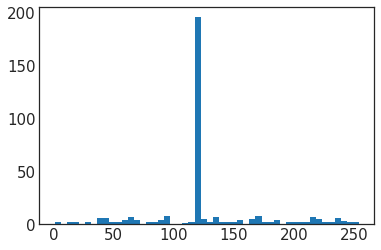

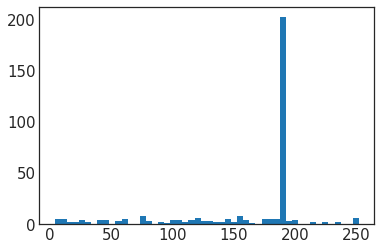

[[118 180]
 [118  14]
 [118 123]
 [151 135]
 [133 161]
 [118 188]
 [185 159]
 [166 188]
 [178 188]
 [118 139]
 [118 188]
 [123 123]
 [118 188]
 [241 188]
 [118 188]
 [118 145]
 [215 215]
 [118 188]
 [123  28]
 [118 188]
 [118 159]
 [118 188]
 [ 77  78]
 [118 188]
 [129  78]
 [118 188]
 [118 188]
 [118 188]
 [ 37 227]
 [ 82 188]
 [118 188]
 [ 68 107]
 [135  32]
 [118 149]
 [118 188]
 [140 215]
 [ 47 188]
 [ 63 188]
 [ 30 111]
 [118 122]
 [118 188]
 [ 94  75]
 [118 188]
 [156 156]
 [118 188]
 [118 188]
 [222 188]
 [118 188]
 [118 188]
 [118 188]
 [118 100]
 [ 61  26]
 [166 156]
 [118 252]
 [118 188]
 [118 188]
 [118 188]
 [118 188]
 [ 37 188]
 [118 107]
 [118 188]
 [118  77]
 [118 188]
 [118 188]
 [118 188]
 [118 251]
 [118 188]
 [118 188]
 [118 188]
 [163 188]
 [118 188]
 [254 145]
 [133 188]
 [118 188]
 [118 181]
 [118 188]
 [118 188]
 [118 188]
 [215  59]
 [118 188]
 [118 188]
 [199 192]
 [ 82 187]
 [185 185]
 [118 102]
 [118 188]
 [118 188]
 [166 157]
 [ 42 188]
 [230 188]
 [118 188]

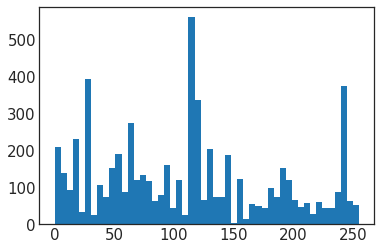

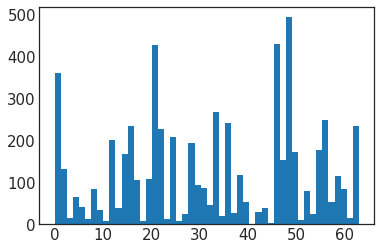

[[ 78  58]
 [205  55]
 [ 48   1]
 ...
 [ 16  62]
 [243  25]
 [ 28   0]]
{'78': 16, '205': 21, '48': 97, '193': 28, '145': 7, '95': 147, '120': 324, '129': 169, '138': 24, '39': 53, '63': 23, '16': 204, '243': 187, '123': 22, '248': 46, '15': 41, '50': 43, '64': 185, '0': 37, '6': 51, '185': 22, '14': 27, '106': 24, '192': 95, '141': 25, '91': 15, '167': 20, '20': 3, '144': 157, '115': 205, '55': 123, '69': 1, '77': 18, '122': 6, '56': 29, '29': 246, '28': 109, '68': 30, '79': 36, '137': 36, '242': 166, '101': 7, '107': 58, '13': 24, '188': 13, '113': 68, '110': 12, '157': 48, '90': 32, '202': 4, '8': 28, '83': 10, '76': 7, '233': 17, '46': 13, '235': 43, '156': 52, '9': 22, '58': 9, '176': 22, '112': 3, '37': 3, '43': 54, '80': 14, '183': 80, '86': 4, '128': 29, '218': 13, '244': 19, '97': 2, '236': 1, '190': 6, '114': 256, '213': 40, '98': 12, '104': 20, '166': 20, '196': 101, '61': 5, '1': 30, '254': 4, '7': 13, '65': 51, '182': 16, '227': 7, '99': 15, '142': 25, '42': 19, '109': 10,

100%|██████████| 324/324 [00:05<00:00, 62.59it/s]



Test set: Average loss: 1.8859, Accuracy: 2245/4890 (45.91%)
New Best Accuracy: (45.91%) at Epoch: (1)

Epoch:     2


100%|██████████| 324/324 [00:05<00:00, 62.65it/s]



Test set: Average loss: 1.4379, Accuracy: 2895/4890 (59.20%)
New Best Accuracy: (59.20%) at Epoch: (2)

Epoch:     3


100%|██████████| 324/324 [00:05<00:00, 62.54it/s]



Test set: Average loss: 1.1657, Accuracy: 3138/4890 (64.17%)
New Best Accuracy: (64.17%) at Epoch: (3)

Epoch:     4


100%|██████████| 324/324 [00:05<00:00, 62.67it/s]



Test set: Average loss: 1.0156, Accuracy: 3333/4890 (68.16%)
New Best Accuracy: (68.16%) at Epoch: (4)

Epoch:     5


100%|██████████| 324/324 [00:05<00:00, 62.72it/s]



Test set: Average loss: 0.9241, Accuracy: 3459/4890 (70.74%)
New Best Accuracy: (70.74%) at Epoch: (5)

Epoch:     6


100%|██████████| 324/324 [00:05<00:00, 62.76it/s]



Test set: Average loss: 0.8577, Accuracy: 3506/4890 (71.70%)
New Best Accuracy: (71.70%) at Epoch: (6)

Epoch:     7


100%|██████████| 324/324 [00:05<00:00, 62.62it/s]



Test set: Average loss: 0.8133, Accuracy: 3590/4890 (73.42%)
New Best Accuracy: (73.42%) at Epoch: (7)

Epoch:     8


100%|██████████| 324/324 [00:05<00:00, 62.65it/s]



Test set: Average loss: 0.7875, Accuracy: 3611/4890 (73.84%)
New Best Accuracy: (73.84%) at Epoch: (8)

Epoch:     9


100%|██████████| 324/324 [00:05<00:00, 62.66it/s]



Test set: Average loss: 0.7576, Accuracy: 3663/4890 (74.91%)
New Best Accuracy: (74.91%) at Epoch: (9)

Epoch:    10


100%|██████████| 324/324 [00:05<00:00, 62.67it/s]



Test set: Average loss: 0.7375, Accuracy: 3681/4890 (75.28%)
New Best Accuracy: (75.28%) at Epoch: (10)

Epoch:    11


100%|██████████| 324/324 [00:05<00:00, 62.64it/s]



Test set: Average loss: 0.7306, Accuracy: 3710/4890 (75.87%)
New Best Accuracy: (75.87%) at Epoch: (11)

Epoch:    12


100%|██████████| 324/324 [00:05<00:00, 62.63it/s]



Test set: Average loss: 0.7145, Accuracy: 3730/4890 (76.28%)
New Best Accuracy: (76.28%) at Epoch: (12)

Epoch:    13


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.7151, Accuracy: 3739/4890 (76.46%)
New Best Accuracy: (76.46%) at Epoch: (13)

Epoch:    14


100%|██████████| 324/324 [00:05<00:00, 62.79it/s]



Test set: Average loss: 0.7027, Accuracy: 3767/4890 (77.03%)
New Best Accuracy: (77.03%) at Epoch: (14)

Epoch:    15


100%|██████████| 324/324 [00:05<00:00, 62.61it/s]



Test set: Average loss: 0.6740, Accuracy: 3807/4890 (77.85%)
New Best Accuracy: (77.85%) at Epoch: (15)

Epoch:    16


100%|██████████| 324/324 [00:05<00:00, 62.63it/s]



Test set: Average loss: 0.6913, Accuracy: 3801/4890 (77.73%)
Epoch:    17


100%|██████████| 324/324 [00:05<00:00, 62.58it/s]



Test set: Average loss: 0.6875, Accuracy: 3811/4890 (77.93%)
New Best Accuracy: (77.93%) at Epoch: (17)

Epoch:    18


100%|██████████| 324/324 [00:05<00:00, 62.68it/s]



Test set: Average loss: 0.6734, Accuracy: 3823/4890 (78.18%)
New Best Accuracy: (78.18%) at Epoch: (18)

Epoch:    19


100%|██████████| 324/324 [00:05<00:00, 62.76it/s]



Test set: Average loss: 0.6897, Accuracy: 3806/4890 (77.83%)
Epoch:    20


100%|██████████| 324/324 [00:05<00:00, 62.76it/s]



Test set: Average loss: 0.6696, Accuracy: 3839/4890 (78.51%)
New Best Accuracy: (78.51%) at Epoch: (20)

Epoch:    21


100%|██████████| 324/324 [00:05<00:00, 62.79it/s]



Test set: Average loss: 0.6541, Accuracy: 3864/4890 (79.02%)
New Best Accuracy: (79.02%) at Epoch: (21)

Epoch:    22


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6581, Accuracy: 3853/4890 (78.79%)
Epoch:    23


100%|██████████| 324/324 [00:05<00:00, 62.66it/s]



Test set: Average loss: 0.6529, Accuracy: 3862/4890 (78.98%)
Epoch:    24


100%|██████████| 324/324 [00:05<00:00, 62.71it/s]



Test set: Average loss: 0.6534, Accuracy: 3869/4890 (79.12%)
New Best Accuracy: (79.12%) at Epoch: (24)

Epoch:    25


100%|██████████| 324/324 [00:05<00:00, 62.66it/s]



Test set: Average loss: 0.6643, Accuracy: 3844/4890 (78.61%)
Epoch:    26


100%|██████████| 324/324 [00:05<00:00, 62.61it/s]



Test set: Average loss: 0.6436, Accuracy: 3898/4890 (79.71%)
New Best Accuracy: (79.71%) at Epoch: (26)

Epoch:    27


100%|██████████| 324/324 [00:05<00:00, 62.72it/s]



Test set: Average loss: 0.6350, Accuracy: 3867/4890 (79.08%)
Epoch:    28


100%|██████████| 324/324 [00:05<00:00, 62.78it/s]



Test set: Average loss: 0.6484, Accuracy: 3858/4890 (78.90%)
Epoch:    29


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6374, Accuracy: 3882/4890 (79.39%)
Epoch:    30


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6353, Accuracy: 3880/4890 (79.35%)
Epoch:    31


100%|██████████| 324/324 [00:05<00:00, 62.74it/s]



Test set: Average loss: 0.6388, Accuracy: 3893/4890 (79.61%)
Epoch:    32


100%|██████████| 324/324 [00:05<00:00, 62.76it/s]



Test set: Average loss: 0.6389, Accuracy: 3888/4890 (79.51%)
Epoch:    33


100%|██████████| 324/324 [00:05<00:00, 62.76it/s]



Test set: Average loss: 0.6349, Accuracy: 3868/4890 (79.10%)
Epoch:    34


100%|██████████| 324/324 [00:05<00:00, 62.62it/s]



Test set: Average loss: 0.6408, Accuracy: 3899/4890 (79.73%)
New Best Accuracy: (79.73%) at Epoch: (34)

Epoch:    35


100%|██████████| 324/324 [00:05<00:00, 62.72it/s]



Test set: Average loss: 0.6505, Accuracy: 3860/4890 (78.94%)
Epoch:    36


100%|██████████| 324/324 [00:05<00:00, 62.71it/s]



Test set: Average loss: 0.6385, Accuracy: 3894/4890 (79.63%)
Epoch:    37


100%|██████████| 324/324 [00:05<00:00, 62.67it/s]



Test set: Average loss: 0.6591, Accuracy: 3890/4890 (79.55%)
Epoch:    38


100%|██████████| 324/324 [00:05<00:00, 62.84it/s]



Test set: Average loss: 0.6353, Accuracy: 3894/4890 (79.63%)
Epoch:    39


100%|██████████| 324/324 [00:05<00:00, 62.68it/s]



Test set: Average loss: 0.6343, Accuracy: 3899/4890 (79.73%)
Epoch:    40


100%|██████████| 324/324 [00:05<00:00, 62.69it/s]



Test set: Average loss: 0.6405, Accuracy: 3901/4890 (79.78%)
New Best Accuracy: (79.78%) at Epoch: (40)

Epoch:    41


100%|██████████| 324/324 [00:05<00:00, 62.61it/s]



Test set: Average loss: 0.6541, Accuracy: 3884/4890 (79.43%)
Epoch:    42


100%|██████████| 324/324 [00:05<00:00, 62.78it/s]



Test set: Average loss: 0.6356, Accuracy: 3897/4890 (79.69%)
Epoch:    43


100%|██████████| 324/324 [00:05<00:00, 62.67it/s]



Test set: Average loss: 0.6239, Accuracy: 3918/4890 (80.12%)
New Best Accuracy: (80.12%) at Epoch: (43)

Epoch:    44


100%|██████████| 324/324 [00:05<00:00, 62.62it/s]



Test set: Average loss: 0.6322, Accuracy: 3930/4890 (80.37%)
New Best Accuracy: (80.37%) at Epoch: (44)

Epoch:    45


100%|██████████| 324/324 [00:05<00:00, 62.67it/s]



Test set: Average loss: 0.6374, Accuracy: 3913/4890 (80.02%)
Epoch:    46


100%|██████████| 324/324 [00:05<00:00, 62.55it/s]



Test set: Average loss: 0.6288, Accuracy: 3918/4890 (80.12%)
Epoch:    47


100%|██████████| 324/324 [00:05<00:00, 62.62it/s]



Test set: Average loss: 0.6236, Accuracy: 3934/4890 (80.45%)
New Best Accuracy: (80.45%) at Epoch: (47)

Epoch:    48


100%|██████████| 324/324 [00:05<00:00, 62.71it/s]



Test set: Average loss: 0.6354, Accuracy: 3921/4890 (80.18%)
Epoch:    49


100%|██████████| 324/324 [00:05<00:00, 62.60it/s]



Test set: Average loss: 0.6531, Accuracy: 3906/4890 (79.88%)
Epoch:    50


100%|██████████| 324/324 [00:05<00:00, 62.63it/s]



Test set: Average loss: 0.6396, Accuracy: 3956/4890 (80.90%)
New Best Accuracy: (80.90%) at Epoch: (50)

Epoch:    51


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6456, Accuracy: 3913/4890 (80.02%)
Epoch:    52


100%|██████████| 324/324 [00:05<00:00, 62.72it/s]



Test set: Average loss: 0.6551, Accuracy: 3902/4890 (79.80%)
Epoch:    53


100%|██████████| 324/324 [00:05<00:00, 62.68it/s]



Test set: Average loss: 0.6338, Accuracy: 3905/4890 (79.86%)
Epoch:    54


100%|██████████| 324/324 [00:05<00:00, 62.57it/s]



Test set: Average loss: 0.6397, Accuracy: 3895/4890 (79.65%)
Epoch:    55


100%|██████████| 324/324 [00:05<00:00, 62.64it/s]



Test set: Average loss: 0.6248, Accuracy: 3919/4890 (80.14%)
Epoch:    56


100%|██████████| 324/324 [00:05<00:00, 62.69it/s]



Test set: Average loss: 0.6260, Accuracy: 3932/4890 (80.41%)
Epoch:    57


100%|██████████| 324/324 [00:05<00:00, 62.87it/s]



Test set: Average loss: 0.6192, Accuracy: 3961/4890 (81.00%)
New Best Accuracy: (81.00%) at Epoch: (57)

Epoch:    58


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6403, Accuracy: 3927/4890 (80.31%)
Epoch:    59


100%|██████████| 324/324 [00:05<00:00, 62.84it/s]



Test set: Average loss: 0.6176, Accuracy: 3922/4890 (80.20%)
Epoch:    60


100%|██████████| 324/324 [00:05<00:00, 62.78it/s]



Test set: Average loss: 0.6182, Accuracy: 3948/4890 (80.74%)
Epoch:    61


100%|██████████| 324/324 [00:05<00:00, 62.64it/s]



Test set: Average loss: 0.6345, Accuracy: 3932/4890 (80.41%)
Epoch:    62


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6558, Accuracy: 3913/4890 (80.02%)
Epoch:    63


100%|██████████| 324/324 [00:05<00:00, 62.92it/s]



Test set: Average loss: 0.6196, Accuracy: 3962/4890 (81.02%)
New Best Accuracy: (81.02%) at Epoch: (63)

Epoch:    64


100%|██████████| 324/324 [00:05<00:00, 62.74it/s]



Test set: Average loss: 0.6412, Accuracy: 3903/4890 (79.82%)
Epoch:    65


100%|██████████| 324/324 [00:05<00:00, 62.61it/s]



Test set: Average loss: 0.6251, Accuracy: 3940/4890 (80.57%)
Epoch:    66


100%|██████████| 324/324 [00:05<00:00, 62.63it/s]



Test set: Average loss: 0.6422, Accuracy: 3922/4890 (80.20%)
Epoch:    67


100%|██████████| 324/324 [00:05<00:00, 62.73it/s]



Test set: Average loss: 0.6291, Accuracy: 3923/4890 (80.22%)
Epoch:    68


100%|██████████| 324/324 [00:05<00:00, 62.57it/s]



Test set: Average loss: 0.6416, Accuracy: 3910/4890 (79.96%)
Epoch:    69


100%|██████████| 324/324 [00:05<00:00, 62.68it/s]



Test set: Average loss: 0.6305, Accuracy: 3955/4890 (80.88%)
Epoch:    70


100%|██████████| 324/324 [00:05<00:00, 62.70it/s]



Test set: Average loss: 0.6275, Accuracy: 3956/4890 (80.90%)
Epoch:    71


100%|██████████| 324/324 [00:05<00:00, 62.75it/s]



Test set: Average loss: 0.6244, Accuracy: 3957/4890 (80.92%)
Epoch:    72


100%|██████████| 324/324 [00:05<00:00, 62.51it/s]



Test set: Average loss: 0.6298, Accuracy: 3960/4890 (80.98%)
Epoch:    73


100%|██████████| 324/324 [00:05<00:00, 62.75it/s]



Test set: Average loss: 0.6214, Accuracy: 3957/4890 (80.92%)
Epoch:    74


100%|██████████| 324/324 [00:05<00:00, 62.49it/s]



Test set: Average loss: 0.6298, Accuracy: 3951/4890 (80.80%)
Epoch:    75


100%|██████████| 324/324 [00:05<00:00, 62.60it/s]



Test set: Average loss: 0.6523, Accuracy: 3917/4890 (80.10%)
Epoch:    76


100%|██████████| 324/324 [00:05<00:00, 62.68it/s]



Test set: Average loss: 0.6294, Accuracy: 3929/4890 (80.35%)
Epoch:    77


100%|██████████| 324/324 [00:05<00:00, 62.55it/s]



Test set: Average loss: 0.6315, Accuracy: 3943/4890 (80.63%)
Epoch:    78


100%|██████████| 324/324 [00:05<00:00, 62.56it/s]



Test set: Average loss: 0.6325, Accuracy: 3955/4890 (80.88%)
Epoch:    79


100%|██████████| 324/324 [00:05<00:00, 62.84it/s]



Test set: Average loss: 0.6225, Accuracy: 3950/4890 (80.78%)
Epoch:    80


100%|██████████| 324/324 [00:05<00:00, 62.56it/s]



Test set: Average loss: 0.6258, Accuracy: 3955/4890 (80.88%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 81.02% / 80.88% (87.74%) at Epoch: 63


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([112, 1, 3, 3])
feat.shape:  (1, 6048)
reshaped_feat.shape:  (336, 18)


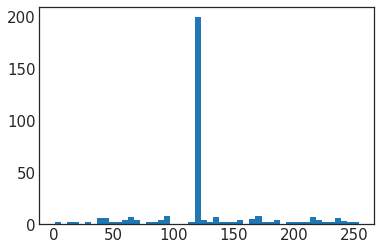

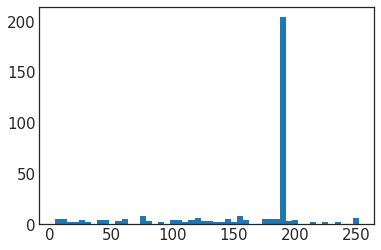

[[118 180]
 [118  14]
 [118 123]
 [151 135]
 [133 161]
 [118 188]
 [185 159]
 [166 188]
 [178 188]
 [118 139]
 [118 188]
 [123 123]
 [118 188]
 [241 188]
 [118 188]
 [118 145]
 [215 215]
 [118 188]
 [123  28]
 [118 188]
 [118 159]
 [118 188]
 [ 77  78]
 [118 188]
 [129  78]
 [118 188]
 [118 188]
 [118 188]
 [ 37 227]
 [ 82 188]
 [118 188]
 [ 68 107]
 [135  32]
 [118 149]
 [118 188]
 [140 215]
 [ 47 188]
 [ 63 188]
 [ 30 111]
 [118 122]
 [118 188]
 [ 94  75]
 [118 188]
 [156 156]
 [118 188]
 [118 188]
 [222 188]
 [118 188]
 [118 188]
 [118 188]
 [118 100]
 [ 61  26]
 [166 156]
 [118 252]
 [118 188]
 [118 188]
 [118 188]
 [118 188]
 [ 37 188]
 [118 107]
 [118 188]
 [118  77]
 [118 188]
 [118 188]
 [118 188]
 [118 251]
 [118 188]
 [118 188]
 [118 188]
 [163 188]
 [118 188]
 [254 145]
 [133 188]
 [118 188]
 [118 181]
 [118 188]
 [118 188]
 [118 188]
 [215  59]
 [118 188]
 [118 188]
 [199 192]
 [ 82 187]
 [185 185]
 [118 102]
 [118 188]
 [118 188]
 [166 157]
 [ 42 188]
 [230 188]
 [118 188]

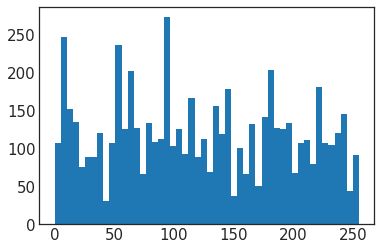

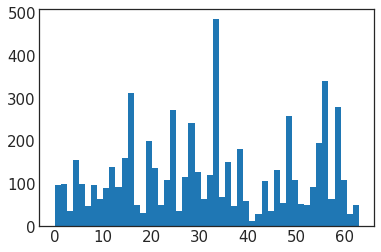

[[ 50  25]
 [142  28]
 [ 38  58]
 ...
 [223  56]
 [  4  38]
 [ 95  27]]
{'50': 60, '142': 46, '38': 42, '95': 258, '191': 17, '242': 70, '240': 28, '88': 71, '212': 25, '59': 55, '205': 18, '145': 46, '183': 118, '84': 14, '225': 36, '80': 56, '110': 14, '136': 56, '162': 8, '126': 29, '43': 16, '15': 45, '195': 31, '223': 171, '141': 28, '204': 19, '28': 63, '192': 24, '132': 20, '208': 3, '156': 34, '178': 48, '114': 105, '210': 37, '213': 45, '181': 43, '82': 39, '37': 21, '107': 36, '123': 22, '16': 35, '8': 80, '0': 19, '255': 10, '72': 22, '66': 46, '99': 43, '77': 13, '19': 16, '167': 34, '252': 25, '238': 30, '219': 7, '177': 6, '64': 45, '229': 17, '159': 12, '47': 6, '10': 22, '68': 59, '175': 39, '119': 55, '152': 10, '20': 2, '55': 133, '116': 25, '56': 22, '70': 16, '62': 21, '137': 51, '138': 36, '254': 26, '120': 22, '166': 41, '171': 47, '13': 30, '187': 62, '247': 19, '78': 30, '196': 49, '39': 41, '153': 39, '106': 32, '9': 67, '53': 38, '176': 44, '32': 21, '109': 60

100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.7362, Accuracy: 3712/4890 (75.91%)
New Best Accuracy: (75.91%) at Epoch: (1)

Epoch:     2


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.5397, Accuracy: 4059/4890 (83.01%)
New Best Accuracy: (83.01%) at Epoch: (2)

Epoch:     3


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.4766, Accuracy: 4126/4890 (84.38%)
New Best Accuracy: (84.38%) at Epoch: (3)

Epoch:     4


100%|██████████| 324/324 [00:07<00:00, 45.08it/s]



Test set: Average loss: 0.4194, Accuracy: 4220/4890 (86.30%)
New Best Accuracy: (86.30%) at Epoch: (4)

Epoch:     5


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.3917, Accuracy: 4275/4890 (87.42%)
New Best Accuracy: (87.42%) at Epoch: (5)

Epoch:     6


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.4289, Accuracy: 4256/4890 (87.03%)
Epoch:     7


100%|██████████| 324/324 [00:07<00:00, 45.19it/s]



Test set: Average loss: 0.3837, Accuracy: 4314/4890 (88.22%)
New Best Accuracy: (88.22%) at Epoch: (7)

Epoch:     8


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.3855, Accuracy: 4314/4890 (88.22%)
Epoch:     9


100%|██████████| 324/324 [00:07<00:00, 45.06it/s]



Test set: Average loss: 0.3841, Accuracy: 4335/4890 (88.65%)
New Best Accuracy: (88.65%) at Epoch: (9)

Epoch:    10


100%|██████████| 324/324 [00:07<00:00, 45.03it/s]



Test set: Average loss: 0.4106, Accuracy: 4312/4890 (88.18%)
Epoch:    11


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.4188, Accuracy: 4301/4890 (87.96%)
Epoch:    12


100%|██████████| 324/324 [00:07<00:00, 43.86it/s]



Test set: Average loss: 0.4425, Accuracy: 4308/4890 (88.10%)
Epoch:    13


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.4493, Accuracy: 4294/4890 (87.81%)
Epoch:    14


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.4958, Accuracy: 4283/4890 (87.59%)
Epoch:    15


100%|██████████| 324/324 [00:07<00:00, 45.08it/s]



Test set: Average loss: 0.4689, Accuracy: 4305/4890 (88.04%)
Epoch:    16


100%|██████████| 324/324 [00:07<00:00, 45.02it/s]



Test set: Average loss: 0.5176, Accuracy: 4281/4890 (87.55%)
Epoch:    17


100%|██████████| 324/324 [00:07<00:00, 45.02it/s]



Test set: Average loss: 0.5071, Accuracy: 4306/4890 (88.06%)
Epoch:    18


100%|██████████| 324/324 [00:07<00:00, 44.95it/s]



Test set: Average loss: 0.5418, Accuracy: 4259/4890 (87.10%)
Epoch:    19


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.5425, Accuracy: 4289/4890 (87.71%)
Epoch:    20


100%|██████████| 324/324 [00:07<00:00, 45.06it/s]



Test set: Average loss: 0.5509, Accuracy: 4275/4890 (87.42%)
Epoch:    21


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.6009, Accuracy: 4258/4890 (87.08%)
Epoch:    22


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.5859, Accuracy: 4242/4890 (86.75%)
Epoch:    23


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.5955, Accuracy: 4251/4890 (86.93%)
Epoch:    24


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.6241, Accuracy: 4255/4890 (87.01%)
Epoch:    25


100%|██████████| 324/324 [00:07<00:00, 45.19it/s]



Test set: Average loss: 0.6413, Accuracy: 4219/4890 (86.28%)
Epoch:    26


100%|██████████| 324/324 [00:07<00:00, 45.14it/s]



Test set: Average loss: 0.6117, Accuracy: 4249/4890 (86.89%)
Epoch:    27


100%|██████████| 324/324 [00:07<00:00, 45.17it/s]



Test set: Average loss: 0.6157, Accuracy: 4279/4890 (87.51%)
Epoch:    28


100%|██████████| 324/324 [00:07<00:00, 45.12it/s]



Test set: Average loss: 0.6636, Accuracy: 4225/4890 (86.40%)
Epoch:    29


100%|██████████| 324/324 [00:07<00:00, 45.12it/s]



Test set: Average loss: 0.6408, Accuracy: 4264/4890 (87.20%)
Epoch:    30


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.6395, Accuracy: 4284/4890 (87.61%)
Epoch:    31


100%|██████████| 324/324 [00:07<00:00, 45.16it/s]



Test set: Average loss: 0.6589, Accuracy: 4259/4890 (87.10%)
Epoch:    32


100%|██████████| 324/324 [00:07<00:00, 45.16it/s]



Test set: Average loss: 0.6528, Accuracy: 4249/4890 (86.89%)
Epoch:    33


100%|██████████| 324/324 [00:07<00:00, 45.06it/s]



Test set: Average loss: 0.6419, Accuracy: 4274/4890 (87.40%)
Epoch:    34


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.6493, Accuracy: 4274/4890 (87.40%)
Epoch:    35


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.6407, Accuracy: 4264/4890 (87.20%)
Epoch:    36


100%|██████████| 324/324 [00:07<00:00, 45.02it/s]



Test set: Average loss: 0.6828, Accuracy: 4229/4890 (86.48%)
Epoch:    37


100%|██████████| 324/324 [00:07<00:00, 45.02it/s]



Test set: Average loss: 0.6252, Accuracy: 4277/4890 (87.46%)
Epoch:    38


100%|██████████| 324/324 [00:07<00:00, 44.99it/s]



Test set: Average loss: 0.6603, Accuracy: 4266/4890 (87.24%)
Epoch:    39


100%|██████████| 324/324 [00:07<00:00, 45.08it/s]



Test set: Average loss: 0.6730, Accuracy: 4294/4890 (87.81%)
Epoch:    40


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.7493, Accuracy: 4256/4890 (87.03%)
Epoch:    41


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.6586, Accuracy: 4269/4890 (87.30%)
Epoch:    42


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.6409, Accuracy: 4275/4890 (87.42%)
Epoch:    43


100%|██████████| 324/324 [00:07<00:00, 45.06it/s]



Test set: Average loss: 0.6697, Accuracy: 4260/4890 (87.12%)
Epoch:    44


100%|██████████| 324/324 [00:07<00:00, 44.97it/s]



Test set: Average loss: 0.6435, Accuracy: 4280/4890 (87.53%)
Epoch:    45


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.6924, Accuracy: 4281/4890 (87.55%)
Epoch:    46


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.6388, Accuracy: 4272/4890 (87.36%)
Epoch:    47


100%|██████████| 324/324 [00:07<00:00, 45.19it/s]



Test set: Average loss: 0.6642, Accuracy: 4249/4890 (86.89%)
Epoch:    48


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.6677, Accuracy: 4268/4890 (87.28%)
Epoch:    49


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.6218, Accuracy: 4317/4890 (88.28%)
Epoch:    50


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.6366, Accuracy: 4302/4890 (87.98%)
Epoch:    51


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.6305, Accuracy: 4285/4890 (87.63%)
Epoch:    52


100%|██████████| 324/324 [00:07<00:00, 44.98it/s]



Test set: Average loss: 0.6376, Accuracy: 4302/4890 (87.98%)
Epoch:    53


100%|██████████| 324/324 [00:07<00:00, 45.02it/s]



Test set: Average loss: 0.6771, Accuracy: 4278/4890 (87.48%)
Epoch:    54


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.6377, Accuracy: 4260/4890 (87.12%)
Epoch:    55


100%|██████████| 324/324 [00:07<00:00, 45.13it/s]



Test set: Average loss: 0.6160, Accuracy: 4306/4890 (88.06%)
Epoch:    56


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.6376, Accuracy: 4307/4890 (88.08%)
Epoch:    57


100%|██████████| 324/324 [00:07<00:00, 45.12it/s]



Test set: Average loss: 0.6357, Accuracy: 4298/4890 (87.89%)
Epoch:    58


100%|██████████| 324/324 [00:07<00:00, 45.13it/s]



Test set: Average loss: 0.6614, Accuracy: 4295/4890 (87.83%)
Epoch:    59


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.6477, Accuracy: 4316/4890 (88.26%)
Epoch:    60


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.6426, Accuracy: 4311/4890 (88.16%)
Epoch:    61


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.6189, Accuracy: 4315/4890 (88.24%)
Epoch:    62


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.6458, Accuracy: 4297/4890 (87.87%)
Epoch:    63


100%|██████████| 324/324 [00:07<00:00, 44.98it/s]



Test set: Average loss: 0.6098, Accuracy: 4315/4890 (88.24%)
Epoch:    64


100%|██████████| 324/324 [00:07<00:00, 45.13it/s]



Test set: Average loss: 0.6274, Accuracy: 4289/4890 (87.71%)
Epoch:    65


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.6378, Accuracy: 4301/4890 (87.96%)
Epoch:    66


100%|██████████| 324/324 [00:07<00:00, 45.08it/s]



Test set: Average loss: 0.6252, Accuracy: 4285/4890 (87.63%)
Epoch:    67


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.6391, Accuracy: 4312/4890 (88.18%)
Epoch:    68


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.6240, Accuracy: 4306/4890 (88.06%)
Epoch:    69


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.6469, Accuracy: 4292/4890 (87.77%)
Epoch:    70


100%|██████████| 324/324 [00:07<00:00, 45.15it/s]



Test set: Average loss: 0.6657, Accuracy: 4307/4890 (88.08%)
Epoch:    71


100%|██████████| 324/324 [00:07<00:00, 45.12it/s]



Test set: Average loss: 0.6064, Accuracy: 4308/4890 (88.10%)
Epoch:    72


100%|██████████| 324/324 [00:07<00:00, 45.20it/s]



Test set: Average loss: 0.6848, Accuracy: 4276/4890 (87.44%)
Epoch:    73


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.6247, Accuracy: 4296/4890 (87.85%)
Epoch:    74


100%|██████████| 324/324 [00:07<00:00, 45.13it/s]



Test set: Average loss: 0.6227, Accuracy: 4310/4890 (88.14%)
Epoch:    75


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.6302, Accuracy: 4294/4890 (87.81%)
Epoch:    76


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.6473, Accuracy: 4315/4890 (88.24%)
Epoch:    77


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.6263, Accuracy: 4322/4890 (88.38%)
Epoch:    78


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.6510, Accuracy: 4297/4890 (87.87%)
Epoch:    79


100%|██████████| 324/324 [00:07<00:00, 45.13it/s]



Test set: Average loss: 0.7111, Accuracy: 4197/4890 (85.83%)
Epoch:    80


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.6202, Accuracy: 4268/4890 (87.28%)

===retrain PQ part

torch.Size([140, 1, 3, 3])
torch.Size([140, 140, 1, 1])
torch.Size([140, 1, 3, 3])
torch.Size([140, 140, 1, 1])
torch.Size([140, 1, 3, 3])
torch.Size([140, 140, 1, 1])
torch.Size([140, 1, 3, 3])
torch.Size([112, 140, 1, 1])
torch.Size([112, 1, 3, 3])
torch.Size([196, 112, 1, 1])
Epoch:     1


100%|██████████| 324/324 [00:05<00:00, 64.31it/s]



Test set: Average loss: 1.3371, Accuracy: 2748/4890 (56.20%)
New Best Accuracy: (56.20%) at Epoch: (1)

torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([140, 1, 3, 3])
torch.Size([112, 1, 3, 3])
feat.shape:  (1, 6048)
reshaped_feat.shape:  (336, 18)


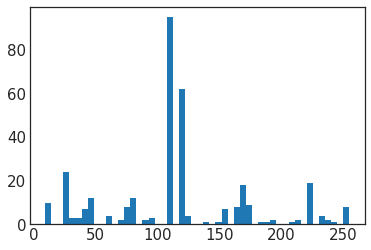

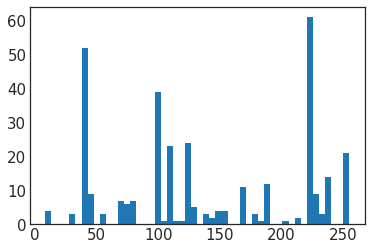

[[223  57]
 [118  71]
 [110 123]
 [151  45]
 [176 130]
 [118  97]
 [234 169]
 [ 44 188]
 [255  72]
 [118 139]
 [118 223]
 [123 123]
 [118 223]
 [241  40]
 [118 223]
 [118 145]
 [215 215]
 [118 223]
 [123  28]
 [118 188]
 [118  44]
 [118 223]
 [ 77  78]
 [118 223]
 [193  78]
 [118 223]
 [118 188]
 [118  40]
 [ 37 227]
 [ 82 188]
 [118 223]
 [176 107]
 [ 97 109]
 [118 149]
 [118 188]
 [140 215]
 [127  97]
 [  9 126]
 [255 226]
 [118  79]
 [118 188]
 [223  75]
 [118 223]
 [156 156]
 [118  97]
 [118  97]
 [222 223]
 [118 223]
 [110 188]
 [118 223]
 [118  79]
 [ 61  54]
 [ 44 156]
 [118  39]
 [118 223]
 [223  40]
 [118 223]
 [118 238]
 [ 37 188]
 [118 107]
 [118  40]
 [118  40]
 [118 223]
 [118  97]
 [118 223]
 [118  41]
 [118 223]
 [118  72]
 [ 31 188]
 [163 169]
 [118  40]
 [ 39  40]
 [176  40]
 [118 223]
 [118 169]
 [ 31  72]
 [118  40]
 [110 238]
 [215  44]
 [110  97]
 [118 223]
 [  9 148]
 [ 82 138]
 [234 185]
 [118  29]
 [110 223]
 [118  40]
 [ 80 238]
 [  9  72]
 [  9 223]
 [110 223]

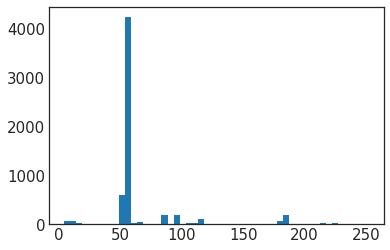

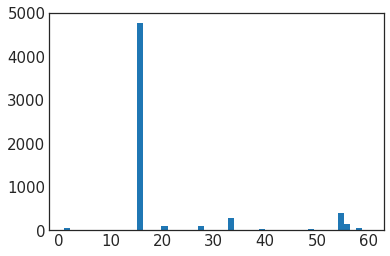

[[ 55  16]
 [ 55  55]
 [109  16]
 ...
 [ 55  16]
 [ 55  16]
 [ 55  16]]
{'55': 4214, '109': 25, '95': 192, '85': 122, '65': 40, '183': 192, '114': 66, '6': 52, '50': 599, '46': 1, '8': 21, '178': 62, '63': 26, '88': 58, '116': 39, '10': 58, '56': 16, '15': 9, '213': 13, '4': 2, '138': 5, '99': 3, '72': 6, '223': 25, '38': 9, '106': 21, '124': 12, '59': 9, '17': 14, '67': 2, '43': 3, '25': 2, '193': 6, '252': 1, '237': 4, '216': 6, '242': 9, '110': 3, '167': 1, '200': 5, '134': 10, '188': 1, '9': 1, '145': 3, '14': 3, '64': 8, '68': 3, '136': 2, '84': 2, '244': 7, '171': 1, '33': 3, '48': 1, '81': 2, '32': 2, '191': 1, '184': 1, '161': 3, '119': 1, '192': 2, '39': 3, '234': 2, '187': 2, '82': 1, '126': 2, '70': 1, '16': 1, '78': 1, '74': 1, '143': 1, '57': 1, '209': 1}
Highest value from dictionary: 55
{'16': 4762, '55': 389, '34': 284, '46': 5, '56': 151, '28': 106, '60': 8, '20': 84, '48': 5, '21': 5, '39': 37, '58': 49, '2': 27, '44': 14, '38': 1, '1': 26, '40': 5, '49': 21, '51': 1,

100%|██████████| 324/324 [00:07<00:00, 44.84it/s]



Test set: Average loss: 0.9138, Accuracy: 3414/4890 (69.82%)
New Best Accuracy: (69.82%) at Epoch: (1)

Epoch:     2


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.5396, Accuracy: 4026/4890 (82.33%)
New Best Accuracy: (82.33%) at Epoch: (2)

Epoch:     3


100%|██████████| 324/324 [00:07<00:00, 44.98it/s]



Test set: Average loss: 0.4646, Accuracy: 4152/4890 (84.91%)
New Best Accuracy: (84.91%) at Epoch: (3)

Epoch:     4


100%|██████████| 324/324 [00:07<00:00, 44.95it/s]



Test set: Average loss: 0.4494, Accuracy: 4165/4890 (85.17%)
New Best Accuracy: (85.17%) at Epoch: (4)

Epoch:     5


100%|██████████| 324/324 [00:07<00:00, 44.95it/s]



Test set: Average loss: 0.4042, Accuracy: 4267/4890 (87.26%)
New Best Accuracy: (87.26%) at Epoch: (5)

Epoch:     6


100%|██████████| 324/324 [00:07<00:00, 45.01it/s]



Test set: Average loss: 0.3954, Accuracy: 4268/4890 (87.28%)
New Best Accuracy: (87.28%) at Epoch: (6)

Epoch:     7


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.3943, Accuracy: 4269/4890 (87.30%)
New Best Accuracy: (87.30%) at Epoch: (7)

Epoch:     8


100%|██████████| 324/324 [00:07<00:00, 44.96it/s]



Test set: Average loss: 0.3716, Accuracy: 4324/4890 (88.43%)
New Best Accuracy: (88.43%) at Epoch: (8)

Epoch:     9


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.3776, Accuracy: 4316/4890 (88.26%)
Epoch:    10


100%|██████████| 324/324 [00:07<00:00, 45.06it/s]



Test set: Average loss: 0.3678, Accuracy: 4327/4890 (88.49%)
New Best Accuracy: (88.49%) at Epoch: (10)

Epoch:    11


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.3673, Accuracy: 4334/4890 (88.63%)
New Best Accuracy: (88.63%) at Epoch: (11)

Epoch:    12


100%|██████████| 324/324 [00:07<00:00, 45.13it/s]



Test set: Average loss: 0.3546, Accuracy: 4367/4890 (89.30%)
New Best Accuracy: (89.30%) at Epoch: (12)

Epoch:    13


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.3586, Accuracy: 4329/4890 (88.53%)
Epoch:    14


100%|██████████| 324/324 [00:07<00:00, 45.19it/s]



Test set: Average loss: 0.3668, Accuracy: 4352/4890 (89.00%)
Epoch:    15


100%|██████████| 324/324 [00:07<00:00, 45.02it/s]



Test set: Average loss: 0.3665, Accuracy: 4365/4890 (89.26%)
Epoch:    16


100%|██████████| 324/324 [00:07<00:00, 45.23it/s]



Test set: Average loss: 0.4973, Accuracy: 4228/4890 (86.46%)
Epoch:    17


100%|██████████| 324/324 [00:07<00:00, 45.21it/s]



Test set: Average loss: 0.3812, Accuracy: 4348/4890 (88.92%)
Epoch:    18


100%|██████████| 324/324 [00:07<00:00, 45.10it/s]



Test set: Average loss: 0.4317, Accuracy: 4292/4890 (87.77%)
Epoch:    19


100%|██████████| 324/324 [00:07<00:00, 45.14it/s]



Test set: Average loss: 0.3695, Accuracy: 4350/4890 (88.96%)
Epoch:    20


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.3726, Accuracy: 4370/4890 (89.37%)
New Best Accuracy: (89.37%) at Epoch: (20)

Epoch:    21


100%|██████████| 324/324 [00:07<00:00, 45.16it/s]



Test set: Average loss: 0.4533, Accuracy: 4305/4890 (88.04%)
Epoch:    22


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.3906, Accuracy: 4361/4890 (89.18%)
Epoch:    23


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.4209, Accuracy: 4336/4890 (88.67%)
Epoch:    24


100%|██████████| 324/324 [00:07<00:00, 44.96it/s]



Test set: Average loss: 0.3969, Accuracy: 4388/4890 (89.73%)
New Best Accuracy: (89.73%) at Epoch: (24)

Epoch:    25


100%|██████████| 324/324 [00:07<00:00, 44.98it/s]



Test set: Average loss: 0.4232, Accuracy: 4334/4890 (88.63%)
Epoch:    26


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.4363, Accuracy: 4344/4890 (88.83%)
Epoch:    27


100%|██████████| 324/324 [00:07<00:00, 44.64it/s]



Test set: Average loss: 0.4434, Accuracy: 4320/4890 (88.34%)
Epoch:    28


100%|██████████| 324/324 [00:07<00:00, 44.87it/s]



Test set: Average loss: 0.4696, Accuracy: 4309/4890 (88.12%)
Epoch:    29


100%|██████████| 324/324 [00:07<00:00, 44.87it/s]



Test set: Average loss: 0.4226, Accuracy: 4348/4890 (88.92%)
Epoch:    30


100%|██████████| 324/324 [00:07<00:00, 45.01it/s]



Test set: Average loss: 0.4683, Accuracy: 4339/4890 (88.73%)
Epoch:    31


100%|██████████| 324/324 [00:07<00:00, 44.97it/s]



Test set: Average loss: 0.4563, Accuracy: 4318/4890 (88.30%)
Epoch:    32


100%|██████████| 324/324 [00:07<00:00, 44.98it/s]



Test set: Average loss: 0.4335, Accuracy: 4378/4890 (89.53%)
Epoch:    33


100%|██████████| 324/324 [00:07<00:00, 44.95it/s]



Test set: Average loss: 0.5184, Accuracy: 4323/4890 (88.40%)
Epoch:    34


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5033, Accuracy: 4354/4890 (89.04%)
Epoch:    35


100%|██████████| 324/324 [00:07<00:00, 44.88it/s]



Test set: Average loss: 0.4737, Accuracy: 4341/4890 (88.77%)
Epoch:    36


100%|██████████| 324/324 [00:07<00:00, 45.01it/s]



Test set: Average loss: 0.4841, Accuracy: 4354/4890 (89.04%)
Epoch:    37


100%|██████████| 324/324 [00:07<00:00, 44.89it/s]



Test set: Average loss: 0.5293, Accuracy: 4297/4890 (87.87%)
Epoch:    38


100%|██████████| 324/324 [00:07<00:00, 44.97it/s]



Test set: Average loss: 0.4708, Accuracy: 4351/4890 (88.98%)
Epoch:    39


100%|██████████| 324/324 [00:07<00:00, 45.03it/s]



Test set: Average loss: 0.4857, Accuracy: 4353/4890 (89.02%)
Epoch:    40


100%|██████████| 324/324 [00:07<00:00, 45.06it/s]



Test set: Average loss: 0.4916, Accuracy: 4333/4890 (88.61%)
Epoch:    41


100%|██████████| 324/324 [00:07<00:00, 44.99it/s]



Test set: Average loss: 0.5035, Accuracy: 4353/4890 (89.02%)
Epoch:    42


100%|██████████| 324/324 [00:07<00:00, 45.03it/s]



Test set: Average loss: 0.5418, Accuracy: 4349/4890 (88.94%)
Epoch:    43


100%|██████████| 324/324 [00:07<00:00, 44.94it/s]



Test set: Average loss: 0.5846, Accuracy: 4287/4890 (87.67%)
Epoch:    44


100%|██████████| 324/324 [00:07<00:00, 44.99it/s]



Test set: Average loss: 0.5551, Accuracy: 4275/4890 (87.42%)
Epoch:    45


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5254, Accuracy: 4315/4890 (88.24%)
Epoch:    46


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.5420, Accuracy: 4303/4890 (88.00%)
Epoch:    47


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.5068, Accuracy: 4357/4890 (89.10%)
Epoch:    48


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.5187, Accuracy: 4343/4890 (88.81%)
Epoch:    49


100%|██████████| 324/324 [00:07<00:00, 45.06it/s]



Test set: Average loss: 0.5281, Accuracy: 4345/4890 (88.85%)
Epoch:    50


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.5597, Accuracy: 4311/4890 (88.16%)
Epoch:    51


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.5013, Accuracy: 4352/4890 (89.00%)
Epoch:    52


100%|██████████| 324/324 [00:07<00:00, 45.04it/s]



Test set: Average loss: 0.5037, Accuracy: 4351/4890 (88.98%)
Epoch:    53


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.5129, Accuracy: 4353/4890 (89.02%)
Epoch:    54


100%|██████████| 324/324 [00:07<00:00, 45.02it/s]



Test set: Average loss: 0.5332, Accuracy: 4350/4890 (88.96%)
Epoch:    55


100%|██████████| 324/324 [00:07<00:00, 44.92it/s]



Test set: Average loss: 0.5348, Accuracy: 4316/4890 (88.26%)
Epoch:    56


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.5735, Accuracy: 4329/4890 (88.53%)
Epoch:    57


100%|██████████| 324/324 [00:07<00:00, 45.03it/s]



Test set: Average loss: 0.5211, Accuracy: 4339/4890 (88.73%)
Epoch:    58


100%|██████████| 324/324 [00:07<00:00, 45.01it/s]



Test set: Average loss: 0.5402, Accuracy: 4349/4890 (88.94%)
Epoch:    59


100%|██████████| 324/324 [00:07<00:00, 45.11it/s]



Test set: Average loss: 0.5074, Accuracy: 4340/4890 (88.75%)
Epoch:    60


100%|██████████| 324/324 [00:07<00:00, 45.01it/s]



Test set: Average loss: 0.5158, Accuracy: 4370/4890 (89.37%)
Epoch:    61


100%|██████████| 324/324 [00:07<00:00, 44.84it/s]



Test set: Average loss: 0.5731, Accuracy: 4333/4890 (88.61%)
Epoch:    62


100%|██████████| 324/324 [00:07<00:00, 45.01it/s]



Test set: Average loss: 0.5095, Accuracy: 4372/4890 (89.41%)
Epoch:    63


100%|██████████| 324/324 [00:07<00:00, 44.96it/s]



Test set: Average loss: 0.5321, Accuracy: 4353/4890 (89.02%)
Epoch:    64


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5630, Accuracy: 4329/4890 (88.53%)
Epoch:    65


100%|██████████| 324/324 [00:07<00:00, 44.99it/s]



Test set: Average loss: 0.5548, Accuracy: 4323/4890 (88.40%)
Epoch:    66


100%|██████████| 324/324 [00:07<00:00, 44.99it/s]



Test set: Average loss: 0.5442, Accuracy: 4363/4890 (89.22%)
Epoch:    67


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.5405, Accuracy: 4353/4890 (89.02%)
Epoch:    68


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.5440, Accuracy: 4339/4890 (88.73%)
Epoch:    69


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5372, Accuracy: 4359/4890 (89.14%)
Epoch:    70


100%|██████████| 324/324 [00:07<00:00, 45.09it/s]



Test set: Average loss: 0.4972, Accuracy: 4394/4890 (89.86%)
New Best Accuracy: (89.86%) at Epoch: (70)

Epoch:    71


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5229, Accuracy: 4356/4890 (89.08%)
Epoch:    72


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5029, Accuracy: 4380/4890 (89.57%)
Epoch:    73


100%|██████████| 324/324 [00:07<00:00, 45.05it/s]



Test set: Average loss: 0.5347, Accuracy: 4361/4890 (89.18%)
Epoch:    74


100%|██████████| 324/324 [00:07<00:00, 44.94it/s]



Test set: Average loss: 0.5930, Accuracy: 4349/4890 (88.94%)
Epoch:    75


100%|██████████| 324/324 [00:07<00:00, 45.03it/s]



Test set: Average loss: 0.5440, Accuracy: 4319/4890 (88.32%)
Epoch:    76


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5242, Accuracy: 4372/4890 (89.41%)
Epoch:    77


100%|██████████| 324/324 [00:07<00:00, 45.00it/s]



Test set: Average loss: 0.5397, Accuracy: 4351/4890 (88.98%)
Epoch:    78


100%|██████████| 324/324 [00:07<00:00, 45.07it/s]



Test set: Average loss: 0.5653, Accuracy: 4328/4890 (88.51%)
Epoch:    79


100%|██████████| 324/324 [00:07<00:00, 44.98it/s]



Test set: Average loss: 0.5265, Accuracy: 4350/4890 (88.96%)
Epoch:    80


100%|██████████| 324/324 [00:07<00:00, 44.95it/s]



Test set: Average loss: 0.4884, Accuracy: 4412/4890 (90.22%)
New Best Accuracy: (90.22%) at Epoch: (80)

Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 90.22% / 90.22% (87.74%) at Epoch: 80


===== target accuracy is achieved =====


In [47]:
# Test set: Average loss: 0.3405, Accuracy: 10028/11005 (90.74%)
pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
pqconv3x3.train(wconv3x3_5)
pqfc = faiss.ProductQuantizer(16, 2, 7)
pqfc.train(wfc_5)
charset = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-_'
recon_gsc = testModelAndCodebooksWTargetAccG(args,
                target_acc=90.74-3,
                model=gsc,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-M',
                dataset='gscv2-mfcc10',
                device=device,
                train_loader=train_loader_gsc,
                test_loader=test_loader_gsc,
                start_from_pretrained=False,
                reverse_tune=True)

In [20]:
def convertString(input):
  s=""
  for i in input:
    # print(i)
    s=s+str(i)
  return s

In [19]:
#Huffman
import re

def comp_decomp(arr):
  my_string = convertString(arr)
  print(arr)
  letters = []
  only_letters = []
  for letter in my_string:
      if letter not in letters:
          frequency = my_string.count(letter)             #frequency of each letter repetition
          letters.append(frequency)
          letters.append(letter)
          only_letters.append(letter)
  # print(letters)
  c=0
  nodes = []
  while len(letters) > 0:
      c=c+letters[0:2][0]
      nodes.append(letters[0:2])
      letters = letters[2:]                               # sorting according to frequency
  nodes.sort()
  huffman_tree = []
  huffman_tree.append(nodes)                             #Make each unique character as a leaf node
  # print(c)

  def combine_nodes(nodes):
      pos = 0
      newnode = []
      if len(nodes) > 1:
          nodes.sort()
          nodes[pos].append("1")                       # assigning values 1 and 0
          nodes[pos+1].append("0")
          combined_node1 = (nodes[pos] [0] + nodes[pos+1] [0])
          combined_node2 = (nodes[pos] [1] + nodes[pos+1] [1])  # combining the nodes to generate pathways
          newnode.append(combined_node1)
          newnode.append(combined_node2)
          newnodes=[]
          newnodes.append(newnode)
          newnodes = newnodes + nodes[2:]
          nodes = newnodes
          huffman_tree.append(nodes)
          combine_nodes(nodes)
      return huffman_tree                                     # huffman tree generation

  newnodes = combine_nodes(nodes)
  print(newnodes)
  huffman_tree.sort(reverse = True)
  print("Huffman tree with merged pathways:")

  checklist = []
  for level in huffman_tree:
      for node in level:
          if node not in checklist:
              checklist.append(node)
          else:
              level.remove(node)
  count = 0
  for level in huffman_tree:
      print("Level", count,":",level)             #print huffman tree
      count+=1
  # print(checklist)

  letter_binary = []
  if len(only_letters) == 1:
      lettercode = [only_letters[0], "0"]
      letter_binary.append(lettercode*len(my_string))
  else:
      for letter in only_letters:
          code =""
          for node in checklist:
              print(node)
              if len (node)>2 and letter in node[1]:           #genrating binary code
                  code = code + node[2]
          lettercode =[letter,code]
          letter_binary.append(lettercode)
  # print(letter_binary)
  print("Binary code generated:")
  for letter in letter_binary:
      print(letter[0], letter[1])

  bitstring =""
  for character in my_string:
      for item in letter_binary:
          if character in item:
              bitstring = bitstring + item[1]
  binary ="0b"+bitstring
  # print(binary)
  print("Your message as binary is:")
  uncompressed_file_size = len(str(arr))*7
  compressed_file_size = len(binary)-2
  print("Your original file size was", uncompressed_file_size,"bits. The compressed size is:",compressed_file_size)
  print("This is a saving of ",uncompressed_file_size-compressed_file_size,"bits")

  bitstring = str(binary[2:])
  uncompressed_string =""
  code =""
  for digit in bitstring:
      code = code+digit
      pos=0                                        #iterating and decoding
      for letter in letter_binary:
          if code ==letter[1]:
              uncompressed_string=uncompressed_string+letter_binary[pos] [0]
              code=""
          pos+=1
  # new_array=np.array(list(uncompressed_string))
  # for x in uncompressed_string:
  #   if x=="1":

  # def character_indexes(strg):
  #   match = "1"

  #   indexes_of_match = []

  #   for index, character in enumerate(strg):
  #       if character == match:
  #           indexes_of_match.append(index)
  #   return indexes_of_match

  # print(character_indexes(uncompressed_string))
  # for x in character_indexes:
  #   uncompressed_string.replace(x-1)
  # uncomp_string = uncompressed_string.replace(' 1','1')
  # print(uncomp_string)
  temp = re.findall(r'\d+', uncompressed_string)
  # print(uncomp_string)
  res = list(map(int, temp))
  res = np.array(res)
  res = res.astype(np.uint8)

  res = res.reshape(arr.shape[0],arr.shape[1])
  # print(res)
  print((arr==res).all())
  return res

In [17]:
#LZW
import re
def compress(uncompressed):
    """Compress a string to a list of output symbols."""

    # Build the dictionary.
    dict_size = 256
    dictionary = dict((chr(i), i) for i in range(dict_size))
    # in Python 3: dictionary = {chr(i): i for i in range(dict_size)}

    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c

    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return result


def decompress(compressed):
    """Decompress a list of output ks to a string."""
    from io import StringIO

    # Build the dictionary.
    dict_size = 256
    dictionary = dict((i, chr(i)) for i in range(dict_size))
    # in Python 3: dictionary = {i: chr(i) for i in range(dict_size)}

    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    result = StringIO()
    w = chr(compressed.pop(0))
    result.write(w)
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result.write(entry)

        # Add w+entry[0] to the dictionary.
        dictionary[dict_size] = w + entry[0]
        dict_size += 1

        w = entry
    return result.getvalue()


def lzw(cconv3x3):
  # pqconv3x3 = faiss.ProductQuantizer(16, 2, 8)
  # pqconv3x3.train(wfc)
  # cconv3x3 = pqconv3x3.compute_codes(wfc)
  # print(cconv3x3.shape)
  array = np.array(cconv3x3)
  # s = array.tostring()
  my_string = str(array.tolist())
  # print(my_string)
  compressed = compress(my_string)
  # print(sys.getsizeof(cconv3x3))
  # print (sys.getsizeof(compressed))
  decompressed = decompress(compressed)
  print (decompressed)
  # print(type(decompressed))
  temp = re.findall(r'\d+', decompressed)
  res = list(map(int, temp))
    
  res = np.array(res)
  # print(res.shape)
  res = res.astype(np.uint8)
  # print(temp)
  res = res.reshape(cconv3x3.shape[0],cconv3x3.shape[1])
  print((cconv3x3==res).all())
  return res

In [44]:
import matplotlib.pyplot as plt
import numpy as np
# from numpy import savetxt

# print(wconv3x3_2)
def prune(arr):  
  # pqconv3x3 = faiss.ProductQuantizer(18, 2, 8)
  # # print(pqconv3x3)
  # pqconv3x3.train(wconv3x3_1)
  # arr = pqconv3x3.compute_codes(wconv3x3_1)
  for i in range(arr.shape[1]):
      _ = plt.hist(arr[:,i], bins=50)
      plt.show()
  print(arr)

  My_dict = {}
  cordinate_pairs = []
  for j  in range (arr.shape[0]):
    # print(j)
    elements = [arr[j,0], arr[j,1]]
    # print(elements)
    cordinate_pairs.append(elements)

  # print(len(cordinate_pairs))

  frequencyDict = {}
  newfreqDict= {}
  visited = []
  newVisited =[]



  listLength = len(arr)
  for i in range(listLength):
      if str(arr[i,0]) in visited:
          frequencyDict[str(arr[i,0])] += 1
      else:
          pair = str(arr[i,0])
          # print(str(pair))
          visited.append(pair)
          frequencyDict[pair] = 1
  print(frequencyDict) 

  new_value = max(frequencyDict, key=frequencyDict.get)
  print("Highest value from dictionary:",new_value)

  for i in range(listLength):
      if str(arr[i,1]) in newVisited:
          newfreqDict[str(arr[i,1])] += 1
      else:
          pair = str(arr[i,1])
          # print(str(pair))
          newVisited.append(pair)
          newfreqDict[pair] = 1
  print(newfreqDict) 

  new_value2 = max(newfreqDict, key=newfreqDict.get)
  print("Highest value from dictionary:",new_value2)


  for i in arr:
    if frequencyDict[str(i[0])]==1:
      i[0]=new_value
    else:
      continue

  for i in arr:
    if newfreqDict[str(i[1])]==1:
      i[1]=new_value2
    else:
      continue

  return arr

In [19]:
#LZW
def getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device):
    if 'AudioCNN' in model_arch:
        wconv3x3 = concatModelWeightsAndReshape(model, model_arch+'WOFc', 18)
        
        cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
        cconv3x3P = prune(cconv3x3)
        cconv3x3h = lzw(cconv3x3P)
        decconv3x3 = pqconv3x3.decode(cconv3x3h)
        # print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
        pq_model = makePQModel(decconv3x3, model_arch+'WOFc', dataset, device, model)
    else:
        decconv3x3 = None
        decconv1x1 = None
        decfc = None
        if pqconv3x3 is not None:
            wconv3x3 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=18,kernel_size=(3,3),layer_type='conv')
            # cconv3x3 = prune(wconv3x3)
            # print(cconv3x3.shape)
            cconv3x3 = pqconv3x3.compute_codes(wconv3x3)
            print("shape:",cconv3x3.shape)
            cconv3x3P = prune(cconv3x3)
            # print(cconv3x3P.shape)
            cconv3x3h = lzw(cconv3x3P)
            decconv3x3 = pqconv3x3.decode(cconv3x3h)
            # print(cconv3x3.shape)
            # print(f"diff_D18M2_{dataset}_conv3x3 = ", ((wconv3x3-decconv3x3)**2).sum())
            
        if pqconv1x1 is not None:
            wconv1x1 = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='conv')
            cconv1x1 = pqconv1x1.compute_codes(wconv1x1)
            # print(cconv1x1.shape)
            cconv1x1P = prune(cconv1x1)
            cconv1x1h = lzw(cconv1x1P)
            decconv1x1 = pqconv1x1.decode(cconv1x1h)
            # print(f"diff_D8M2_{dataset}_conv1x1 = ", ((wconv1x1-decconv1x1)**2).sum())
        
        if pqfc is not None:
            wfc = concatCertainWeightsAndReshape(model=model,model_arch='NOInOut',d=16,kernel_size=(1,1),layer_type='fc')
            # cfc = prune(wfc)
            cfc = pqfc.compute_codes(wfc)
            cfcP = prune(cfc)
            cfch = lzw(cfcP)
            decfc = pqfc.decode(cfch)
            # print(f"diff_D16M2_{dataset}_fc = ", ((wfc-decfc)**2).sum())

        # print(decconv1x1.shape)
        # print(decconv3x3.shape)
        pq_model = makePQModelMultiCodebooks(decconv3x3, decconv1x1, decfc, model_arch+'WOInOut', dataset, device, model)
    return pq_model

# 1. retrain 1 
# 2. assignment update
# 3. retrain 2 
# 4. check if target accuracy is achieved.
import copy
def testModelAndCodebooksWTargetAcc(args,target_acc,model,lr,epoch,pqconv3x3,pqconv1x1,pqfc,model_arch,dataset,device,train_loader,test_loader,start_from_pretrained,reverse_tune):
    n_layers_tune = 2
    pq_model = copy.deepcopy(model)
    for i in range(2):
        print(f'\n\n===== Iteration Loop: {i+1}th =====\n')
        args.lr = lr
        # 1. 1st retrain
        if start_from_pretrained == True:
            pq_model = getPQModel(model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        else:
            pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
            
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 2. assignment update
        print('\n===retrain PQ part\n')
        pq_retrain_pqpart(args,pq_model.to(device),model_arch,1,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 3. 2nd retrain
        pq_model = getPQModel(pq_model, pqconv3x3, pqconv1x1, pqfc, model_arch, dataset, device)
        print('\n===retrain classifier part')
        pq_retrain(args, pq_model.to(device),model_arch,epoch,n_layers_tune,device,train_loader,test_loader,reverse_tune)
        
        # 4. check if target accuracy is achieved
        print(f'Iteration Loop: {i+1}, n_layers_tune: {n_layers_tune}, Best Accuracy / Last Accuracy (Target Accuracy): {args.best_acc:.2f}% / {args.last_acc:.2f}% ({target_acc:.2f}%) at Epoch: {args.best_acc_epoch}')
        # if args.best_acc > target_acc:
        if args.last_acc > target_acc:
            print('\n\n===== target accuracy is achieved =====')
            break
        else:
            n_layers_tune += 1
            print('\n\n===== target accuracy is NOT achieved =====')
    return pq_model

In [ ]:
def getModelAndIndexAndCodebookSizes(model, cr3x3=9, cr1x1=4):
    conv3x3_cnt = 0
    conv1x1_cnt = 0
    tot_param_cnt = 0
    conv3x3_codebook_cnt = 0
    conv1x1_codebook_cnt = 0
    fc_codebook_cnt = 0
    float_cnt = 0
    for i, param in enumerate(model.parameters()):
        size_tot = param.numel()
        tot_param_cnt += size_tot
        if len(param.size()) == 4: # consider only conv weights
            if i == 0: # CASE for init_block (init block is in 32bit float)
                float_cnt += size_tot
            else: # CASE for middle blocks
                if param.size()[2] == 3 and param.size()[3] == 3:
                    conv3x3_cnt += size_tot
                    conv3x3_codebook_cnt += 1
                else:
                    conv1x1_cnt += size_tot
                    conv1x1_codebook_cnt += 1
        elif len(param.size()) == 2: # CASE for last layer / linear layers
            conv1x1_cnt += size_tot
            fc_codebook_cnt += 1
        elif len(param.size()) == 1: # CASE for bias (32 bit float)
            float_cnt += size_tot
        else:
            print('error: this should not be printed, i.e., (param.size() == 3 or > 4 ) ')
    model_size = tot_param_cnt * 4 / 1024 / 1024 # (in MB)
    index_size = conv3x3_cnt / cr3x3 / 1024 / 1024 + conv1x1_cnt / cr1x1 / 1024 / 1024 # (in MB)
    codebook_size = conv3x3_codebook_cnt * getCodebookSizeConv(cr3x3) +\
                    conv1x1_codebook_cnt * getCodebookSizeConv(cr1x1) +\
                    fc_codebook_cnt * 1024*cr1x1*2/1024/1024    # (in MB)
    others_size = float_cnt * 4 / 1024 / 1024 # (in MB)
    
    print(f'model_size: {model_size:.2f} MB, index_size: {index_size:.2f} MB, codebook_size: {codebook_size:.2f} MB, Init_block and Bias size: {others_size:.2f} MB')
    print(f'(Index+Codebook+Others)/Model: {(index_size+codebook_size+others_size)/model_size*100:.2f}%, Comp Rate: {model_size/(index_size+codebook_size+others_size):.2f}x')
    return model_size, index_size, codebook_size, others_size

def getCodebookSizeConv(comp_rate=9):
    numel = 256*comp_rate
    codebook_size = (numel)*2/1024/1024 # (in MB)
    return codebook_size

def printiPQCompRate(models, cr3x3=9, cr1x1=4):
    model_size_l = []
    index_size_l = []
    codebook_size_l = []
    others_size_l = []
    
    for i, model in enumerate(models):
        model_size, index_size, codebook_size, others_size = getModelAndIndexAndCodebookSizes(model, cr3x3, cr1x1)
        model_size_l.append(model_size)
        index_size_l.append(index_size)
        codebook_size_l.append(codebook_size)
        others_size_l.append(others_size)
    
    tot_model_size = np.sum(model_size_l)
    tot_index_size = np.sum(index_size_l)
    tot_codebook_size = np.sum(codebook_size_l)
    tot_others_size = np.sum(others_size_l)
    
    print(f'\nTOTAL model_size: {tot_model_size:.2f} MB, \
  TOTAL index_size: {tot_index_size:.2f} MB, \
  TOTAL Codebook Size: {tot_codebook_size:.2f} MB, \
  TOTAL Others Size: {tot_others_size:.2f} MB')
    print(f'TOTAL Index/Model Ratio: {tot_index_size/tot_model_size*100:.2f}%, \
    Codebook/Model Ratio: {tot_codebook_size/tot_model_size*100:.2f}%, \
    Others/Model Ratio: {tot_others_size/tot_model_size*100:.2f}%')
    print(f'\nTOTAL Comp Rate: {tot_model_size/(tot_index_size+tot_codebook_size+tot_others_size):.2f}x\n\n')

In [ ]:
def getModelAndIndexSizes(model, cr3x3=9, cr1x1=4, n_layers_tune=2, reverse_tune=False):
    conv3x3_cnt = 0
    conv1x1_cnt = 0
    tot_param_cnt = 0
    conv3x3_codebook_cnt = 0
    conv1x1_codebook_cnt = 0
    fc_codebook_cnt = 0
    fc_cnt = 0
    float_cnt = 0
    print(model)
    conv_param_l = []
    for i, param in enumerate(model.parameters()):
        print(i)
        size_tot = param.numel()
        tot_param_cnt += size_tot
        if len(param.size()) == 4: # consider only conv weights
            if i == 0: # CASE for init_block (init block is in 32bit float)
                # float_cnt += size_tot
                fc_cnt += size_tot
            else: # CASE for middle blocks
                conv_param_l.append(size_tot)
                if param.size()[2] == 1 and param.size()[3] == 1:
                    conv1x1_cnt += size_tot
                else:
                    conv3x3_cnt += size_tot
        elif len(param.size()) == 2: # CASE for last layer / linear layers
            size_l = param.size()
            last_layer_flag = False
            for temp in size_l:
                if temp < 50:
                    last_layer_flag = True
            if last_layer_flag == True:
                fc_cnt += size_tot
            else:
                conv1x1_cnt += size_tot
            # fc_codebook_cnt += 1
        elif len(param.size()) == 1: # CASE for bias (32 bit float)
            float_cnt += size_tot
        else:
            print('error: this should not be printed, i.e., (param.size() == 3 or > 4 ) ')
    
    # if n_layers_tune > 2: we add fc_cnt and remove conv1x1_cnt or conv3x3_cnt
    if n_layers_tune > 2:
        for i in range(n_layers_tune - 2):
            if reverse_tune is False:
                if i % 2 == 0: # decrease conv1x1
                    conv1x1_cnt -= conv_param_l[-1-i]
                    fc_cnt += conv_param_l[-1-i]
                else: # decrease conv3x3
                    conv3x3_cnt -= conv_param_l[-1-i]
                    fc_cnt += conv_param_l[-1-i]
            else:
                if i % 2 == 0: # decrease conv3x3
                    conv3x3_cnt -= conv_param_l[i]
                    fc_cnt += conv_param_l[i]
                else: # decrease conv1x1
                    conv1x1_cnt -= conv_param_l[i]
                    fc_cnt += conv_param_l[i]
            
    model_size = tot_param_cnt * 4 / 1024 / 1024 # (in MB)
    index_size = conv3x3_cnt / cr3x3 / 1024 / 1024 + conv1x1_cnt / cr1x1 / 1024 / 1024 # (in MB)
    codebook_size = fc_codebook_cnt * 1024*cr1x1*2/1024/1024    # (in MB)
    others_size = float_cnt * 4 / 1024 / 1024 + fc_cnt * 2 /1024/1024 # (in MB)
    
    
    print(f'model_size: {model_size:.2f} MB, index_size: {index_size:.2f} MB, codebook_size: {codebook_size:.2f} MB, Init_block and Bias size: {others_size:.2f} MB')
    print(f'(Index+Codebook+Others)/Model: {(index_size+codebook_size+others_size)/model_size*100:.2f}%, Comp Rate: {model_size/(index_size+codebook_size+others_size):.2f}x')
    return model_size, index_size, codebook_size, others_size

def getCodebookSize(comp_rate3x3=9, comp_rate1x1=4):
    conv3x3_numel = 256*comp_rate3x3*2
    conv1x1_numel = 256*comp_rate1x1*2
    codebook_size = (conv3x3_numel + conv1x1_numel)*2/1024/1024 # (in MB)
    return codebook_size

# def printOverallCompRate(models, cr3x3=9, cr1x1=4, n_layers_tune=2, reverse_tune=False):
#     model_size_l = []
#     index_size_l = []
#     codebook_size_l = []
#     others_size_l = []
#     shared_codebook_size = getCodebookSize(cr3x3, cr1x1)
    
#     for i, model in enumerate(models):
#         model_size, index_size, codebook_size, others_size = getModelAndIndexSizes(model, cr3x3, cr1x1, n_layers_tune, reverse_tune)
#         model_size_l.append(model_size)
#         index_size_l.append(index_size)
#         codebook_size_l.append(codebook_size)
#         others_size_l.append(others_size)
    
#     tot_model_size = np.sum(model_size_l)
#     tot_index_size = np.sum(index_size_l)
#     tot_codebook_size = np.sum(codebook_size_l)
#     tot_others_size = np.sum(others_size_l)
#     tot_codebook_size += shared_codebook_size
    
#     print(f'\nTOTAL model_size: {tot_model_size:.2f} MB, \
#   TOTAL index_size: {tot_index_size:.2f} MB, \
#   TOTAL Codebook Size: {tot_codebook_size:.2f} MB, \
#   TOTAL Others Size: {tot_others_size:.2f} MB')
#     print(f'TOTAL Index/Model Ratio: {tot_index_size/tot_model_size*100:.2f}%, \
#     Codebook/Model Ratio: {tot_codebook_size/tot_model_size*100:.2f}%, \
#     Others/Model Ratio: {tot_others_size/tot_model_size*100:.2f}%')
#     print(f'\nTOTAL Comp Rate: {tot_model_size/(tot_index_size+tot_codebook_size+tot_others_size):.2f}x')
#     print(f'\nTOTAL YONO Size: {tot_index_size+tot_codebook_size+tot_others_size:.2f} MB\n\n')
    
def printOverallCompRateList(models, n_layers_tune_l, cr3x3=9, cr1x1=4, reverse_tune=False):
    model_size_l = []
    index_size_l = []
    codebook_size_l = []
    others_size_l = []
    shared_codebook_size = getCodebookSize(cr3x3, cr1x1)
    
    for i, (model, n_layers_tune) in enumerate(zip(models,n_layers_tune_l)):
        model_size, index_size, codebook_size, others_size = getModelAndIndexSizes(model, cr3x3, cr1x1, n_layers_tune, reverse_tune)
        model_size_l.append(model_size)
        index_size_l.append(index_size)
        codebook_size_l.append(codebook_size)
        others_size_l.append(others_size)
    
    tot_model_size = np.sum(model_size_l)
    tot_index_size = np.sum(index_size_l)
    tot_codebook_size = np.sum(codebook_size_l)
    tot_others_size = np.sum(others_size_l)
    tot_codebook_size += shared_codebook_size
    
    print(f'\nTOTAL model_size: {tot_model_size:.2f} MB, \
  TOTAL index_size: {tot_index_size:.2f} MB, \
  TOTAL Codebook Size: {tot_codebook_size:.2f} MB, \
  TOTAL Others Size: {tot_others_size:.2f} MB')
    print(f'TOTAL Index/Model Ratio: {tot_index_size/tot_model_size*100:.2f}%, \
    Codebook/Model Ratio: {tot_codebook_size/tot_model_size*100:.2f}%, \
    Others/Model Ratio: {tot_others_size/tot_model_size*100:.2f}%')
    print(f'\nTOTAL Comp Rate: {tot_model_size/(tot_index_size+tot_codebook_size+tot_others_size):.2f}x')
    print(f'\nTOTAL YONO Size: {tot_index_size+tot_codebook_size+tot_others_size:.2f} MB\n\n')
    

def printOverallCompRate(models, cr3x3=9, cr1x1=4, n_layers_tune=2, reverse_tune=False):
    model_size_l = []
    # index_size_l = []
    index_size =[]
    codebook_size_l = []
    others_size_l = []
    shared_codebook_size = getCodebookSize(cr3x3, cr1x1)
    
    for i, model in enumerate(models):
        model_size, index_size, codebook_size, others_size = getModelAndIndexSizes(model, cr3x3, cr1x1, n_layers_tune, reverse_tune)
        model_size_l.append(model_size)
        # index_size_l.append(index_size)
        print("index_size - ", index_size)
        codebook_size_l.append(codebook_size)
        others_size_l.append(others_size)
    
    tot_model_size = np.sum(model_size_l)
    # tot_index_size = np.sum(index_size_l)
    tot_index_size = index_size
    tot_codebook_size = np.sum(codebook_size_l)
    tot_others_size = np.sum(others_size_l)
    tot_codebook_size += shared_codebook_size
    
    print(f'\nTOTAL model_size: {tot_model_size:.2f} MB, \
  TOTAL index_size: {tot_index_size:.2f} MB, \
  TOTAL Codebook Size: {tot_codebook_size:.2f} MB, \
  TOTAL Others Size: {tot_others_size:.2f} MB')
    print(f'TOTAL Index/Model Ratio: {tot_index_size/tot_model_size*100:.2f}%, \
    Codebook/Model Ratio: {tot_codebook_size/tot_model_size*100:.2f}%, \
    Others/Model Ratio: {tot_others_size/tot_model_size*100:.2f}%')
    print(f'\nTOTAL Comp Rate: {tot_model_size/(tot_index_size+tot_codebook_size+tot_others_size):.2f}x')
    print(f'\nTOTAL YONO Size: {tot_index_size+tot_codebook_size+tot_others_size:.2f} MB\n\n')


def printOverallCompRate4SingleModel(models, cr3x3=9, cr1x1=4, n_layers_tune=2, reverse_tune=False):
    model_size_l = []
    index_size_l = []
    codebook_size_l = []
    others_size_l = []
    shared_codebook_size = getCodebookSize(cr3x3, cr1x1)
    
    for i, model in enumerate(models):
        model_size, index_size, codebook_size, others_size = getModelAndIndexSizes(model, cr3x3, cr1x1, n_layers_tune, reverse_tune)
        model_size_l.append(model_size)
        index_size_l.append(index_size)
        codebook_size_l.append(codebook_size)
        others_size_l.append(others_size)
    
    tot_model_size = np.sum(model_size_l)
    tot_index_size = np.sum(index_size_l)
    tot_codebook_size = np.sum(codebook_size_l)
    tot_others_size = np.sum(others_size_l)
    tot_codebook_size += shared_codebook_size*len(models)
    print('shared_codebook_size: ', shared_codebook_size)
    
    print(f'\nTOTAL model_size: {tot_model_size:.2f} MB, \
  TOTAL index_size: {tot_index_size:.2f} MB, \
  TOTAL Codebook Size: {tot_codebook_size:.2f} MB, \
  TOTAL Others Size: {tot_others_size:.2f} MB')
    print(f'TOTAL Index/Model Ratio: {tot_index_size/tot_model_size*100:.2f}%, \
    Codebook/Model Ratio: {tot_codebook_size/tot_model_size*100:.2f}%, \
    Others/Model Ratio: {tot_others_size/tot_model_size*100:.2f}%')
    print(f'\nTOTAL Comp Rate: {tot_model_size/(tot_index_size+tot_codebook_size+tot_others_size):.2f}x')
    print(f'\nTOTAL YONO Size: {tot_index_size+tot_codebook_size+tot_others_size:.2f} MB\n\n')

In [ ]:
printOverallCompRate([cifar10],
        cr3x3=9, cr1x1=8, n_layers_tune=3, reverse_tune=True)

PTCVDSCNN(
  (model): DSCNN(
    (features): Sequential(
      (init_block): ConvBlock(
        (conv): Conv2d(3, 168, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (stage1): Sequential(
        (unit1): DwsConvBlock(
          (dw_conv): ConvBlock(
            (conv): Conv2d(168, 168, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=168, bias=False)
            (bn): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (pw_conv): ConvBlock(
            (conv): Conv2d(168, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
        )
      )
      (stage2): Sequential(
        (uni

## Additional trained datasets' results

In [ ]:
# Test set: Average loss: 1.1293, Accuracy: 6231/7721 (79.45%)
recon_hhar = testModelAndCodebooksWTargetAcc(args,
                target_acc=78.9-2,
                model=hhar,
                lr=0.0005,
                epoch=15,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-AD-I-ch176-s41',
                dataset='hhar-noaug',
                device=device,
                train_loader=train_loader_hhar,
                test_loader=test_loader_hhar,
                start_from_pretrained=False,
                reverse_tune=True)

  0%|          | 0/465 [00:00<?, ?it/s]



===== Iteration Loop: 1th =====

torch.Size([176, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8496)
reshaped_feat.shape:  (472, 18)
diff_D18M2_hhar-noaug_conv3x3 =  187.50401
torch.Size([192, 176, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 181248)
reshaped_feat.shape:  (11328, 16)
diff_D8M2_hhar-noaug_conv1x1 =  304.58466
3: pq_param size: torch.Size([176, 1, 3, 3]), orig_param size: torch.Size([176, 1, 3, 3])
diff: 47.56415939331055
6: pq_param size: torch.Size([192, 176, 1, 1]), orig_param size: torch.Size([192, 176, 1, 1])
diff: 80.4314193725586
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 50.09320831298828
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 87.39035034179688
15: pq_param size: tor

  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.3856, Accuracy: 4746/7721 (61.47%)
New Best Accuracy: (61.47%) at Epoch: (1)

Epoch:     2


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.3033, Accuracy: 4957/7721 (64.20%)
New Best Accuracy: (64.20%) at Epoch: (2)

Epoch:     3


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1974, Accuracy: 5147/7721 (66.66%)
New Best Accuracy: (66.66%) at Epoch: (3)

Epoch:     4


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1508, Accuracy: 5282/7721 (68.41%)
New Best Accuracy: (68.41%) at Epoch: (4)

Epoch:     5


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1812, Accuracy: 5385/7721 (69.74%)
New Best Accuracy: (69.74%) at Epoch: (5)

Epoch:     6


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0716, Accuracy: 5439/7721 (70.44%)
New Best Accuracy: (70.44%) at Epoch: (6)

Epoch:     7


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1095, Accuracy: 5513/7721 (71.40%)
New Best Accuracy: (71.40%) at Epoch: (7)

Epoch:     8


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1272, Accuracy: 5394/7721 (69.86%)
Epoch:     9


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0704, Accuracy: 5602/7721 (72.56%)
New Best Accuracy: (72.56%) at Epoch: (9)

Epoch:    10


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0733, Accuracy: 5633/7721 (72.96%)
New Best Accuracy: (72.96%) at Epoch: (10)

Epoch:    11


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0055, Accuracy: 5682/7721 (73.59%)
New Best Accuracy: (73.59%) at Epoch: (11)

Epoch:    12


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9998, Accuracy: 5685/7721 (73.63%)
New Best Accuracy: (73.63%) at Epoch: (12)

Epoch:    13


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9569, Accuracy: 5684/7721 (73.62%)
Epoch:    14


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9496, Accuracy: 5733/7721 (74.25%)
New Best Accuracy: (74.25%) at Epoch: (14)

Epoch:    15


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0070, Accuracy: 5613/7721 (72.70%)

===retrain PQ part

Epoch:     1


100%|██████████| 465/465 [00:16<00:00, 27.46it/s]



Test set: Average loss: 0.6837, Accuracy: 6131/7721 (79.41%)
New Best Accuracy: (79.41%) at Epoch: (1)

torch.Size([176, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8496)
reshaped_feat.shape:  (472, 18)
diff_D18M2_hhar-noaug_conv3x3 =  3.395757
torch.Size([192, 176, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 181248)
reshaped_feat.shape:  (11328, 16)
diff_D8M2_hhar-noaug_conv1x1 =  15.694919
3: pq_param size: torch.Size([176, 1, 3, 3]), orig_param size: torch.Size([176, 1, 3, 3])
diff: 0.18600188195705414
6: pq_param size: torch.Size([192, 176, 1, 1]), orig_param size: torch.Size([192, 176, 1, 1])
diff: 2.8896565437316895
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 0.14974923431873322
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: 

  0%|          | 0/465 [00:00<?, ?it/s]


===retrain classifier part
Epoch:     1


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0134, Accuracy: 4858/7721 (62.92%)
New Best Accuracy: (62.92%) at Epoch: (1)

Epoch:     2


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9662, Accuracy: 5220/7721 (67.61%)
New Best Accuracy: (67.61%) at Epoch: (2)

Epoch:     3


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0448, Accuracy: 5374/7721 (69.60%)
New Best Accuracy: (69.60%) at Epoch: (3)

Epoch:     4


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9422, Accuracy: 5450/7721 (70.59%)
New Best Accuracy: (70.59%) at Epoch: (4)

Epoch:     5


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9936, Accuracy: 5530/7721 (71.62%)
New Best Accuracy: (71.62%) at Epoch: (5)

Epoch:     6


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9281, Accuracy: 5659/7721 (73.29%)
New Best Accuracy: (73.29%) at Epoch: (6)

Epoch:     7


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.2060, Accuracy: 5059/7721 (65.52%)
Epoch:     8


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0123, Accuracy: 5662/7721 (73.33%)
New Best Accuracy: (73.33%) at Epoch: (8)

Epoch:     9


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0330, Accuracy: 5665/7721 (73.37%)
New Best Accuracy: (73.37%) at Epoch: (9)

Epoch:    10


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0870, Accuracy: 5720/7721 (74.08%)
New Best Accuracy: (74.08%) at Epoch: (10)

Epoch:    11


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9908, Accuracy: 5703/7721 (73.86%)
Epoch:    12


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0709, Accuracy: 5765/7721 (74.67%)
New Best Accuracy: (74.67%) at Epoch: (12)

Epoch:    13


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0164, Accuracy: 5771/7721 (74.74%)
New Best Accuracy: (74.74%) at Epoch: (13)

Epoch:    14


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.2122, Accuracy: 5173/7721 (67.00%)
Epoch:    15


100%|██████████| 465/465 [00:11<00:00, 40.91it/s]



Test set: Average loss: 1.0130, Accuracy: 5790/7721 (74.99%)
New Best Accuracy: (74.99%) at Epoch: (15)

Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 74.99% / 74.99% (76.90%) at Epoch: 15


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([176, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8496)
reshaped_feat.shape:  (472, 18)
diff_D18M2_hhar-noaug_conv3x3 =  0.0
torch.Size([192, 176, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 181248)
reshaped_feat.shape:  (11328, 16)
diff_D8M2_hhar-noaug_conv1x1 =  0.0
3: pq_param size: torch.Size([176, 1, 3, 3]), orig_param size: torch.Size([176, 1, 3, 3])
diff: 0.0
6: pq_param size: torch.Size([192, 176, 1, 1]), orig_param size: torch.Size([192, 176, 1, 1])
diff: 0.0
9: pq_param size: 

  0%|          | 0/465 [00:00<?, ?it/s]


===retrain classifier part
torch.Size([176, 1, 3, 3])
torch.Size([192, 176, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.3771, Accuracy: 5173/7721 (67.00%)
New Best Accuracy: (67.00%) at Epoch: (1)

Epoch:     2


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0760, Accuracy: 5277/7721 (68.35%)
New Best Accuracy: (68.35%) at Epoch: (2)

Epoch:     3


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9197, Accuracy: 6069/7721 (78.60%)
New Best Accuracy: (78.60%) at Epoch: (3)

Epoch:     4


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1255, Accuracy: 5520/7721 (71.49%)
Epoch:     5


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.2304, Accuracy: 5220/7721 (67.61%)
Epoch:     6


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1675, Accuracy: 5888/7721 (76.26%)
Epoch:     7


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.6738, Accuracy: 5207/7721 (67.44%)
Epoch:     8


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1765, Accuracy: 5736/7721 (74.29%)
Epoch:     9


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.5073, Accuracy: 5176/7721 (67.04%)
Epoch:    10


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1641, Accuracy: 6021/7721 (77.98%)
Epoch:    11


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.3373, Accuracy: 5269/7721 (68.24%)
Epoch:    12


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0678, Accuracy: 6057/7721 (78.45%)
Epoch:    13


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1479, Accuracy: 6034/7721 (78.15%)
Epoch:    14


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.2679, Accuracy: 5862/7721 (75.92%)
Epoch:    15


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 2.0747, Accuracy: 5162/7721 (66.86%)

===retrain PQ part

torch.Size([176, 1, 3, 3])
torch.Size([192, 176, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


100%|██████████| 465/465 [00:12<00:00, 38.73it/s]



Test set: Average loss: 1.4661, Accuracy: 2617/7721 (33.89%)
New Best Accuracy: (33.89%) at Epoch: (1)

torch.Size([176, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8496)
reshaped_feat.shape:  (472, 18)
diff_D18M2_hhar-noaug_conv3x3 =  40.910915
torch.Size([192, 176, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 181248)
reshaped_feat.shape:  (11328, 16)
diff_D8M2_hhar-noaug_conv1x1 =  3.877093
3: pq_param size: torch.Size([176, 1, 3, 3]), orig_param size: torch.Size([176, 1, 3, 3])
diff: 11.1630277633667
6: pq_param size: torch.Size([192, 176, 1, 1]), orig_param size: torch.Size([192, 176, 1, 1])
diff: 1.3296568393707275
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 11.202028274536133
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torc

  0%|          | 0/465 [00:00<?, ?it/s]


===retrain classifier part
torch.Size([176, 1, 3, 3])
torch.Size([192, 176, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.8789, Accuracy: 5866/7721 (75.97%)
New Best Accuracy: (75.97%) at Epoch: (1)

Epoch:     2


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.9591, Accuracy: 5919/7721 (76.66%)
New Best Accuracy: (76.66%) at Epoch: (2)

Epoch:     3


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.2472, Accuracy: 5554/7721 (71.93%)
Epoch:     4


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 0.8314, Accuracy: 6216/7721 (80.51%)
New Best Accuracy: (80.51%) at Epoch: (4)

Epoch:     5


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1855, Accuracy: 5898/7721 (76.39%)
Epoch:     6


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.3478, Accuracy: 5733/7721 (74.25%)
Epoch:     7


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.0647, Accuracy: 6094/7721 (78.93%)
Epoch:     8


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.2302, Accuracy: 6036/7721 (78.18%)
Epoch:     9


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.2428, Accuracy: 5945/7721 (77.00%)
Epoch:    10


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.7197, Accuracy: 5317/7721 (68.86%)
Epoch:    11


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.4077, Accuracy: 5933/7721 (76.84%)
Epoch:    12


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.1694, Accuracy: 6183/7721 (80.08%)
Epoch:    13


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.4572, Accuracy: 5711/7721 (73.97%)
Epoch:    14


  0%|          | 0/465 [00:00<?, ?it/s]


Test set: Average loss: 1.4914, Accuracy: 5704/7721 (73.88%)
Epoch:    15


100%|██████████| 465/465 [00:18<00:00, 25.23it/s]



Test set: Average loss: 1.2301, Accuracy: 6072/7721 (78.64%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 80.51% / 78.64% (76.90%) at Epoch: 4


===== target accuracy is achieved =====


In [ ]:
# Test set: Average loss: 0.7450, Accuracy: 4628/6381 (72.53%)
recon_ninadb2 = testModelAndCodebooksWTargetAcc(args,
                target_acc=72.53-2,
                model=ninadb2,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='AudioCNN',
                dataset='ninapro-db2-c10',
                device=device,
                train_loader=train_loader_ninadb2,
                test_loader=test_loader_ninadb2,
                start_from_pretrained=False,
                reverse_tune=True)



===== Iteration Loop: 1th =====

feat.shape:  (1, 16368)
reshaped_feat.shape:  (910, 18)
diff_D18M2_ninapro-db2-c10_conv3x3 =  53.81284

===retrain classifier part
Epoch:     1


100%|██████████| 244/244 [00:01<00:00, 137.71it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5068f2f680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
      File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 1.6655, Accuracy: 2522/6381 (39.52%)
New Best Accuracy: (39.52%) at Epoch: (1)

Epoch:     2


100%|██████████| 244/244 [00:01<00:00, 141.82it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5068f2f680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 1.4676, Accuracy: 2961/6381 (46.40%)
New Best Accuracy: (46.40%) at Epoch: (2)

Epoch:     3


100%|██████████| 244/244 [00:01<00:00, 141.40it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5068f2f680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 1.3659, Accuracy: 3229/6381 (50.60%)
New Best Accuracy: (50.60%) at Epoch: (3)

Epoch:     4


100%|██████████| 244/244 [00:01<00:00, 141.62it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5068f2f680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 1.2528, Accuracy: 3554/6381 (55.70%)
New Best Accuracy: (55.70%) at Epoch: (4)

Epoch:     5


 13%|█▎        | 31/244 [00:00<00:02, 94.82it/s] 


KeyboardInterrupt: ignored

## Unseen datasets

In [ ]:
# 94.14%
recon_fmnist = testModelAndCodebooksWTargetAcc(args,
                target_acc=94.04-2,
                model=fmnist,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='DS-CNN-M',
                dataset='fashion-mnist',
                device=device,
                train_loader=train_loader_fmnist,
                test_loader=test_loader_fmnist,
                start_from_pretrained=False,
                reverse_tune=True)

  0%|          | 0/469 [00:00<?, ?it/s]



===== Iteration Loop: 1th =====

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_fashion-mnist_conv3x3 =  69.77293
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_fashion-mnist_conv1x1 =  259.2496
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 19.226957321166992
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 59.28535461425781
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 25.42866325378418
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 86.41780090332031
15: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Siz

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6412, Accuracy: 7733/10000 (77.33%)
New Best Accuracy: (77.33%) at Epoch: (1)

Epoch:     2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5164, Accuracy: 8171/10000 (81.71%)
New Best Accuracy: (81.71%) at Epoch: (2)

Epoch:     3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4506, Accuracy: 8414/10000 (84.14%)
New Best Accuracy: (84.14%) at Epoch: (3)

Epoch:     4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4172, Accuracy: 8540/10000 (85.40%)
New Best Accuracy: (85.40%) at Epoch: (4)

Epoch:     5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3975, Accuracy: 8606/10000 (86.06%)
New Best Accuracy: (86.06%) at Epoch: (5)

Epoch:     6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3853, Accuracy: 8627/10000 (86.27%)
New Best Accuracy: (86.27%) at Epoch: (6)

Epoch:     7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3641, Accuracy: 8714/10000 (87.14%)
New Best Accuracy: (87.14%) at Epoch: (7)

Epoch:     8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3590, Accuracy: 8720/10000 (87.20%)
New Best Accuracy: (87.20%) at Epoch: (8)

Epoch:     9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3409, Accuracy: 8790/10000 (87.90%)
New Best Accuracy: (87.90%) at Epoch: (9)

Epoch:    10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3365, Accuracy: 8795/10000 (87.95%)
New Best Accuracy: (87.95%) at Epoch: (10)

Epoch:    11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3284, Accuracy: 8830/10000 (88.30%)
New Best Accuracy: (88.30%) at Epoch: (11)

Epoch:    12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3196, Accuracy: 8869/10000 (88.69%)
New Best Accuracy: (88.69%) at Epoch: (12)

Epoch:    13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3194, Accuracy: 8881/10000 (88.81%)
New Best Accuracy: (88.81%) at Epoch: (13)

Epoch:    14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3186, Accuracy: 8896/10000 (88.96%)
New Best Accuracy: (88.96%) at Epoch: (14)

Epoch:    15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3119, Accuracy: 8900/10000 (89.00%)
New Best Accuracy: (89.00%) at Epoch: (15)

Epoch:    16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3108, Accuracy: 8883/10000 (88.83%)
Epoch:    17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3077, Accuracy: 8936/10000 (89.36%)
New Best Accuracy: (89.36%) at Epoch: (17)

Epoch:    18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3013, Accuracy: 8929/10000 (89.29%)
Epoch:    19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2991, Accuracy: 8922/10000 (89.22%)
Epoch:    20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2980, Accuracy: 8931/10000 (89.31%)
Epoch:    21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2960, Accuracy: 8929/10000 (89.29%)
Epoch:    22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2994, Accuracy: 8940/10000 (89.40%)
New Best Accuracy: (89.40%) at Epoch: (22)

Epoch:    23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2926, Accuracy: 8972/10000 (89.72%)
New Best Accuracy: (89.72%) at Epoch: (23)

Epoch:    24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2975, Accuracy: 8956/10000 (89.56%)
Epoch:    25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2918, Accuracy: 8957/10000 (89.57%)
Epoch:    26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2979, Accuracy: 8939/10000 (89.39%)
Epoch:    27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2867, Accuracy: 9000/10000 (90.00%)
New Best Accuracy: (90.00%) at Epoch: (27)

Epoch:    28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2848, Accuracy: 9001/10000 (90.01%)
New Best Accuracy: (90.01%) at Epoch: (28)

Epoch:    29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2879, Accuracy: 8966/10000 (89.66%)
Epoch:    30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2891, Accuracy: 8988/10000 (89.88%)
Epoch:    31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2907, Accuracy: 8980/10000 (89.80%)
Epoch:    32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2907, Accuracy: 8989/10000 (89.89%)
Epoch:    33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2878, Accuracy: 8963/10000 (89.63%)
Epoch:    34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2846, Accuracy: 9004/10000 (90.04%)
New Best Accuracy: (90.04%) at Epoch: (34)

Epoch:    35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2826, Accuracy: 9012/10000 (90.12%)
New Best Accuracy: (90.12%) at Epoch: (35)

Epoch:    36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2862, Accuracy: 8992/10000 (89.92%)
Epoch:    37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2823, Accuracy: 9017/10000 (90.17%)
New Best Accuracy: (90.17%) at Epoch: (37)

Epoch:    38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2851, Accuracy: 8995/10000 (89.95%)
Epoch:    39


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2795, Accuracy: 9033/10000 (90.33%)
New Best Accuracy: (90.33%) at Epoch: (39)

Epoch:    40


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2827, Accuracy: 9017/10000 (90.17%)
Epoch:    41


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2811, Accuracy: 9001/10000 (90.01%)
Epoch:    42


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2818, Accuracy: 8997/10000 (89.97%)
Epoch:    43


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2817, Accuracy: 8995/10000 (89.95%)
Epoch:    44


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2808, Accuracy: 9003/10000 (90.03%)
Epoch:    45


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2794, Accuracy: 9011/10000 (90.11%)
Epoch:    46


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2788, Accuracy: 9021/10000 (90.21%)
Epoch:    47


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2792, Accuracy: 9017/10000 (90.17%)
Epoch:    48


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2743, Accuracy: 9023/10000 (90.23%)
Epoch:    49


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2779, Accuracy: 9009/10000 (90.09%)
Epoch:    50


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2792, Accuracy: 9004/10000 (90.04%)
Epoch:    51


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2745, Accuracy: 9005/10000 (90.05%)
Epoch:    52


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2796, Accuracy: 9015/10000 (90.15%)
Epoch:    53


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2775, Accuracy: 9015/10000 (90.15%)
Epoch:    54


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2743, Accuracy: 9019/10000 (90.19%)
Epoch:    55


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2727, Accuracy: 9018/10000 (90.18%)
Epoch:    56


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2807, Accuracy: 8999/10000 (89.99%)
Epoch:    57


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2747, Accuracy: 9033/10000 (90.33%)
Epoch:    58


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2735, Accuracy: 9022/10000 (90.22%)
Epoch:    59


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2746, Accuracy: 9032/10000 (90.32%)
Epoch:    60


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2732, Accuracy: 9024/10000 (90.24%)
Epoch:    61


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2716, Accuracy: 9004/10000 (90.04%)
Epoch:    62


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2701, Accuracy: 9054/10000 (90.54%)
New Best Accuracy: (90.54%) at Epoch: (62)

Epoch:    63


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2719, Accuracy: 9019/10000 (90.19%)
Epoch:    64


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2693, Accuracy: 9052/10000 (90.52%)
Epoch:    65


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2703, Accuracy: 9029/10000 (90.29%)
Epoch:    66


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2674, Accuracy: 9063/10000 (90.63%)
New Best Accuracy: (90.63%) at Epoch: (66)

Epoch:    67


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2709, Accuracy: 9030/10000 (90.30%)
Epoch:    68


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2777, Accuracy: 9000/10000 (90.00%)
Epoch:    69


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2659, Accuracy: 9074/10000 (90.74%)
New Best Accuracy: (90.74%) at Epoch: (69)

Epoch:    70


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2711, Accuracy: 9043/10000 (90.43%)
Epoch:    71


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2694, Accuracy: 9054/10000 (90.54%)
Epoch:    72


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2730, Accuracy: 9013/10000 (90.13%)
Epoch:    73


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2712, Accuracy: 9029/10000 (90.29%)
Epoch:    74


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2655, Accuracy: 9050/10000 (90.50%)
Epoch:    75


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2673, Accuracy: 9045/10000 (90.45%)
Epoch:    76


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2661, Accuracy: 9047/10000 (90.47%)
Epoch:    77


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2648, Accuracy: 9064/10000 (90.64%)
Epoch:    78


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2711, Accuracy: 9033/10000 (90.33%)
Epoch:    79


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2731, Accuracy: 9032/10000 (90.32%)
Epoch:    80


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2641, Accuracy: 9076/10000 (90.76%)
New Best Accuracy: (90.76%) at Epoch: (80)


===retrain PQ part

Epoch:     1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2733, Accuracy: 9007/10000 (90.07%)
New Best Accuracy: (90.07%) at Epoch: (1)

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_fashion-mnist_conv3x3 =  0.61281276
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_fashion-mnist_conv1x1 =  18.728443
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.18621626496315002
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 6.255416393280029
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.16008377075195312
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 4.532979965209

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5310, Accuracy: 8172/10000 (81.72%)
New Best Accuracy: (81.72%) at Epoch: (1)

Epoch:     2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4496, Accuracy: 8414/10000 (84.14%)
New Best Accuracy: (84.14%) at Epoch: (2)

Epoch:     3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4053, Accuracy: 8541/10000 (85.41%)
New Best Accuracy: (85.41%) at Epoch: (3)

Epoch:     4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3823, Accuracy: 8624/10000 (86.24%)
New Best Accuracy: (86.24%) at Epoch: (4)

Epoch:     5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3611, Accuracy: 8704/10000 (87.04%)
New Best Accuracy: (87.04%) at Epoch: (5)

Epoch:     6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3516, Accuracy: 8751/10000 (87.51%)
New Best Accuracy: (87.51%) at Epoch: (6)

Epoch:     7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3336, Accuracy: 8790/10000 (87.90%)
New Best Accuracy: (87.90%) at Epoch: (7)

Epoch:     8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3261, Accuracy: 8838/10000 (88.38%)
New Best Accuracy: (88.38%) at Epoch: (8)

Epoch:     9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3233, Accuracy: 8827/10000 (88.27%)
Epoch:    10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3162, Accuracy: 8872/10000 (88.72%)
New Best Accuracy: (88.72%) at Epoch: (10)

Epoch:    11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3134, Accuracy: 8889/10000 (88.89%)
New Best Accuracy: (88.89%) at Epoch: (11)

Epoch:    12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3089, Accuracy: 8871/10000 (88.71%)
Epoch:    13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3095, Accuracy: 8901/10000 (89.01%)
New Best Accuracy: (89.01%) at Epoch: (13)

Epoch:    14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3013, Accuracy: 8927/10000 (89.27%)
New Best Accuracy: (89.27%) at Epoch: (14)

Epoch:    15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2980, Accuracy: 8942/10000 (89.42%)
New Best Accuracy: (89.42%) at Epoch: (15)

Epoch:    16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2996, Accuracy: 8924/10000 (89.24%)
Epoch:    17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3001, Accuracy: 8909/10000 (89.09%)
Epoch:    18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2957, Accuracy: 8942/10000 (89.42%)
Epoch:    19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2979, Accuracy: 8960/10000 (89.60%)
New Best Accuracy: (89.60%) at Epoch: (19)

Epoch:    20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2926, Accuracy: 8949/10000 (89.49%)
Epoch:    21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2924, Accuracy: 8965/10000 (89.65%)
New Best Accuracy: (89.65%) at Epoch: (21)

Epoch:    22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2892, Accuracy: 8973/10000 (89.73%)
New Best Accuracy: (89.73%) at Epoch: (22)

Epoch:    23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2945, Accuracy: 8932/10000 (89.32%)
Epoch:    24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2914, Accuracy: 8929/10000 (89.29%)
Epoch:    25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2933, Accuracy: 8942/10000 (89.42%)
Epoch:    26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2918, Accuracy: 8956/10000 (89.56%)
Epoch:    27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2864, Accuracy: 8987/10000 (89.87%)
New Best Accuracy: (89.87%) at Epoch: (27)

Epoch:    28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2827, Accuracy: 9006/10000 (90.06%)
New Best Accuracy: (90.06%) at Epoch: (28)

Epoch:    29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2785, Accuracy: 9012/10000 (90.12%)
New Best Accuracy: (90.12%) at Epoch: (29)

Epoch:    30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2784, Accuracy: 9012/10000 (90.12%)
Epoch:    31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2788, Accuracy: 9008/10000 (90.08%)
Epoch:    32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2779, Accuracy: 9015/10000 (90.15%)
New Best Accuracy: (90.15%) at Epoch: (32)

Epoch:    33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2774, Accuracy: 9030/10000 (90.30%)
New Best Accuracy: (90.30%) at Epoch: (33)

Epoch:    34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2800, Accuracy: 8989/10000 (89.89%)
Epoch:    35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2838, Accuracy: 8966/10000 (89.66%)
Epoch:    36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2817, Accuracy: 8986/10000 (89.86%)
Epoch:    37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2786, Accuracy: 9014/10000 (90.14%)
Epoch:    38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2795, Accuracy: 9009/10000 (90.09%)
Epoch:    39


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2744, Accuracy: 8994/10000 (89.94%)
Epoch:    40


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2771, Accuracy: 9002/10000 (90.02%)
Epoch:    41


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2765, Accuracy: 9021/10000 (90.21%)
Epoch:    42


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2759, Accuracy: 8998/10000 (89.98%)
Epoch:    43


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2832, Accuracy: 8971/10000 (89.71%)
Epoch:    44


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2727, Accuracy: 9019/10000 (90.19%)
Epoch:    45


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2743, Accuracy: 9022/10000 (90.22%)
Epoch:    46


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2729, Accuracy: 9014/10000 (90.14%)
Epoch:    47


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2837, Accuracy: 8989/10000 (89.89%)
Epoch:    48


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2798, Accuracy: 9001/10000 (90.01%)
Epoch:    49


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2729, Accuracy: 9021/10000 (90.21%)
Epoch:    50


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2753, Accuracy: 9001/10000 (90.01%)
Epoch:    51


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2709, Accuracy: 9036/10000 (90.36%)
New Best Accuracy: (90.36%) at Epoch: (51)

Epoch:    52


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2705, Accuracy: 9040/10000 (90.40%)
New Best Accuracy: (90.40%) at Epoch: (52)

Epoch:    53


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2701, Accuracy: 9015/10000 (90.15%)
Epoch:    54


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2840, Accuracy: 8948/10000 (89.48%)
Epoch:    55


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2733, Accuracy: 9016/10000 (90.16%)
Epoch:    56


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2691, Accuracy: 9037/10000 (90.37%)
Epoch:    57


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2776, Accuracy: 9024/10000 (90.24%)
Epoch:    58


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2781, Accuracy: 8994/10000 (89.94%)
Epoch:    59


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2723, Accuracy: 9019/10000 (90.19%)
Epoch:    60


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2810, Accuracy: 8987/10000 (89.87%)
Epoch:    61


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2770, Accuracy: 8981/10000 (89.81%)
Epoch:    62


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2789, Accuracy: 8972/10000 (89.72%)
Epoch:    63


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2753, Accuracy: 8991/10000 (89.91%)
Epoch:    64


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2705, Accuracy: 9041/10000 (90.41%)
New Best Accuracy: (90.41%) at Epoch: (64)

Epoch:    65


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2707, Accuracy: 9024/10000 (90.24%)
Epoch:    66


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2772, Accuracy: 9010/10000 (90.10%)
Epoch:    67


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2699, Accuracy: 9043/10000 (90.43%)
New Best Accuracy: (90.43%) at Epoch: (67)

Epoch:    68


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2681, Accuracy: 9015/10000 (90.15%)
Epoch:    69


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2711, Accuracy: 9020/10000 (90.20%)
Epoch:    70


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2692, Accuracy: 9056/10000 (90.56%)
New Best Accuracy: (90.56%) at Epoch: (70)

Epoch:    71


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2669, Accuracy: 9044/10000 (90.44%)
Epoch:    72


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2684, Accuracy: 9037/10000 (90.37%)
Epoch:    73


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2677, Accuracy: 9044/10000 (90.44%)
Epoch:    74


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2752, Accuracy: 9027/10000 (90.27%)
Epoch:    75


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2744, Accuracy: 9010/10000 (90.10%)
Epoch:    76


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2693, Accuracy: 9023/10000 (90.23%)
Epoch:    77


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2766, Accuracy: 8994/10000 (89.94%)
Epoch:    78


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2790, Accuracy: 8972/10000 (89.72%)
Epoch:    79


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2668, Accuracy: 9043/10000 (90.43%)
Epoch:    80


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2732, Accuracy: 9008/10000 (90.08%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 90.56% / 90.08% (92.04%) at Epoch: 70


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_fashion-mnist_conv3x3 =  0.0
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_fashion-mnist_conv1x1 =  0.0
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.0
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 0.0
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.0
12: pq_param

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2603, Accuracy: 9069/10000 (90.69%)
New Best Accuracy: (90.69%) at Epoch: (1)

Epoch:     2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2431, Accuracy: 9107/10000 (91.07%)
New Best Accuracy: (91.07%) at Epoch: (2)

Epoch:     3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2247, Accuracy: 9185/10000 (91.85%)
New Best Accuracy: (91.85%) at Epoch: (3)

Epoch:     4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2146, Accuracy: 9232/10000 (92.32%)
New Best Accuracy: (92.32%) at Epoch: (4)

Epoch:     5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2098, Accuracy: 9261/10000 (92.61%)
New Best Accuracy: (92.61%) at Epoch: (5)

Epoch:     6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2095, Accuracy: 9263/10000 (92.63%)
New Best Accuracy: (92.63%) at Epoch: (6)

Epoch:     7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2081, Accuracy: 9285/10000 (92.85%)
New Best Accuracy: (92.85%) at Epoch: (7)

Epoch:     8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2063, Accuracy: 9286/10000 (92.86%)
New Best Accuracy: (92.86%) at Epoch: (8)

Epoch:     9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2064, Accuracy: 9288/10000 (92.88%)
New Best Accuracy: (92.88%) at Epoch: (9)

Epoch:    10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2063, Accuracy: 9279/10000 (92.79%)
Epoch:    11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2000, Accuracy: 9297/10000 (92.97%)
New Best Accuracy: (92.97%) at Epoch: (11)

Epoch:    12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1989, Accuracy: 9288/10000 (92.88%)
Epoch:    13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2001, Accuracy: 9319/10000 (93.19%)
New Best Accuracy: (93.19%) at Epoch: (13)

Epoch:    14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1886, Accuracy: 9328/10000 (93.28%)
New Best Accuracy: (93.28%) at Epoch: (14)

Epoch:    15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1967, Accuracy: 9323/10000 (93.23%)
Epoch:    16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2033, Accuracy: 9300/10000 (93.00%)
Epoch:    17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1943, Accuracy: 9334/10000 (93.34%)
New Best Accuracy: (93.34%) at Epoch: (17)

Epoch:    18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1941, Accuracy: 9324/10000 (93.24%)
Epoch:    19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1953, Accuracy: 9311/10000 (93.11%)
Epoch:    20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1879, Accuracy: 9362/10000 (93.62%)
New Best Accuracy: (93.62%) at Epoch: (20)

Epoch:    21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1910, Accuracy: 9336/10000 (93.36%)
Epoch:    22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1935, Accuracy: 9354/10000 (93.54%)
Epoch:    23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1931, Accuracy: 9332/10000 (93.32%)
Epoch:    24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1911, Accuracy: 9360/10000 (93.60%)
Epoch:    25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2000, Accuracy: 9314/10000 (93.14%)
Epoch:    26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1949, Accuracy: 9323/10000 (93.23%)
Epoch:    27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2000, Accuracy: 9343/10000 (93.43%)
Epoch:    28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1832, Accuracy: 9364/10000 (93.64%)
New Best Accuracy: (93.64%) at Epoch: (28)

Epoch:    29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1909, Accuracy: 9353/10000 (93.53%)
Epoch:    30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1933, Accuracy: 9324/10000 (93.24%)
Epoch:    31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1887, Accuracy: 9352/10000 (93.52%)
Epoch:    32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1963, Accuracy: 9338/10000 (93.38%)
Epoch:    33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1924, Accuracy: 9356/10000 (93.56%)
Epoch:    34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1962, Accuracy: 9343/10000 (93.43%)
Epoch:    35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1907, Accuracy: 9347/10000 (93.47%)
Epoch:    36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1977, Accuracy: 9345/10000 (93.45%)
Epoch:    37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1954, Accuracy: 9304/10000 (93.04%)
Epoch:    38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1996, Accuracy: 9325/10000 (93.25%)
Epoch:    39


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1933, Accuracy: 9378/10000 (93.78%)
New Best Accuracy: (93.78%) at Epoch: (39)

Epoch:    40


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1950, Accuracy: 9349/10000 (93.49%)
Epoch:    41


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1949, Accuracy: 9338/10000 (93.38%)
Epoch:    42


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1873, Accuracy: 9378/10000 (93.78%)
Epoch:    43


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1971, Accuracy: 9362/10000 (93.62%)
Epoch:    44


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1944, Accuracy: 9346/10000 (93.46%)
Epoch:    45


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1941, Accuracy: 9341/10000 (93.41%)
Epoch:    46


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1974, Accuracy: 9362/10000 (93.62%)
Epoch:    47


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2020, Accuracy: 9345/10000 (93.45%)
Epoch:    48


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1937, Accuracy: 9359/10000 (93.59%)
Epoch:    49


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1893, Accuracy: 9396/10000 (93.96%)
New Best Accuracy: (93.96%) at Epoch: (49)

Epoch:    50


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1946, Accuracy: 9375/10000 (93.75%)
Epoch:    51


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1916, Accuracy: 9369/10000 (93.69%)
Epoch:    52


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2132, Accuracy: 9332/10000 (93.32%)
Epoch:    53


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2021, Accuracy: 9339/10000 (93.39%)
Epoch:    54


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1984, Accuracy: 9350/10000 (93.50%)
Epoch:    55


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2028, Accuracy: 9343/10000 (93.43%)
Epoch:    56


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1911, Accuracy: 9362/10000 (93.62%)
Epoch:    57


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2068, Accuracy: 9329/10000 (93.29%)
Epoch:    58


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1981, Accuracy: 9357/10000 (93.57%)
Epoch:    59


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2034, Accuracy: 9350/10000 (93.50%)
Epoch:    60


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2054, Accuracy: 9342/10000 (93.42%)
Epoch:    61


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2020, Accuracy: 9352/10000 (93.52%)
Epoch:    62


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1975, Accuracy: 9348/10000 (93.48%)
Epoch:    63


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2018, Accuracy: 9336/10000 (93.36%)
Epoch:    64


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1943, Accuracy: 9363/10000 (93.63%)
Epoch:    65


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2065, Accuracy: 9372/10000 (93.72%)
Epoch:    66


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1983, Accuracy: 9355/10000 (93.55%)
Epoch:    67


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2029, Accuracy: 9374/10000 (93.74%)
Epoch:    68


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2106, Accuracy: 9330/10000 (93.30%)
Epoch:    69


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1965, Accuracy: 9361/10000 (93.61%)
Epoch:    70


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1978, Accuracy: 9358/10000 (93.58%)
Epoch:    71


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1964, Accuracy: 9364/10000 (93.64%)
Epoch:    72


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1908, Accuracy: 9397/10000 (93.97%)
New Best Accuracy: (93.97%) at Epoch: (72)

Epoch:    73


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1934, Accuracy: 9380/10000 (93.80%)
Epoch:    74


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1934, Accuracy: 9364/10000 (93.64%)
Epoch:    75


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1991, Accuracy: 9355/10000 (93.55%)
Epoch:    76


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2047, Accuracy: 9334/10000 (93.34%)
Epoch:    77


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1988, Accuracy: 9346/10000 (93.46%)
Epoch:    78


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2054, Accuracy: 9322/10000 (93.22%)
Epoch:    79


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2034, Accuracy: 9371/10000 (93.71%)
Epoch:    80


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2123, Accuracy: 9341/10000 (93.41%)

===retrain PQ part

torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
Epoch:     1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5741, Accuracy: 5284/10000 (52.84%)
New Best Accuracy: (52.84%) at Epoch: (1)

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_fashion-mnist_conv3x3 =  5.677761
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_fashion-mnist_conv1x1 =  4.6533313
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 1.8054620027542114
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 1.718381404876709
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 2.190697431564331
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 1.5011894702911377


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3442, Accuracy: 8763/10000 (87.63%)
New Best Accuracy: (87.63%) at Epoch: (1)

Epoch:     2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3121, Accuracy: 8851/10000 (88.51%)
New Best Accuracy: (88.51%) at Epoch: (2)

Epoch:     3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2850, Accuracy: 8986/10000 (89.86%)
New Best Accuracy: (89.86%) at Epoch: (3)

Epoch:     4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2772, Accuracy: 8976/10000 (89.76%)
Epoch:     5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2755, Accuracy: 8957/10000 (89.57%)
Epoch:     6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2447, Accuracy: 9104/10000 (91.04%)
New Best Accuracy: (91.04%) at Epoch: (6)

Epoch:     7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2463, Accuracy: 9132/10000 (91.32%)
New Best Accuracy: (91.32%) at Epoch: (7)

Epoch:     8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2282, Accuracy: 9152/10000 (91.52%)
New Best Accuracy: (91.52%) at Epoch: (8)

Epoch:     9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2349, Accuracy: 9133/10000 (91.33%)
Epoch:    10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2198, Accuracy: 9227/10000 (92.27%)
New Best Accuracy: (92.27%) at Epoch: (10)

Epoch:    11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2127, Accuracy: 9236/10000 (92.36%)
New Best Accuracy: (92.36%) at Epoch: (11)

Epoch:    12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2108, Accuracy: 9250/10000 (92.50%)
New Best Accuracy: (92.50%) at Epoch: (12)

Epoch:    13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2088, Accuracy: 9235/10000 (92.35%)
Epoch:    14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2082, Accuracy: 9257/10000 (92.57%)
New Best Accuracy: (92.57%) at Epoch: (14)

Epoch:    15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2086, Accuracy: 9240/10000 (92.40%)
Epoch:    16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2245, Accuracy: 9167/10000 (91.67%)
Epoch:    17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2075, Accuracy: 9251/10000 (92.51%)
Epoch:    18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2170, Accuracy: 9215/10000 (92.15%)
Epoch:    19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2078, Accuracy: 9262/10000 (92.62%)
New Best Accuracy: (92.62%) at Epoch: (19)

Epoch:    20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2042, Accuracy: 9250/10000 (92.50%)
Epoch:    21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1996, Accuracy: 9275/10000 (92.75%)
New Best Accuracy: (92.75%) at Epoch: (21)

Epoch:    22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1977, Accuracy: 9291/10000 (92.91%)
New Best Accuracy: (92.91%) at Epoch: (22)

Epoch:    23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2007, Accuracy: 9264/10000 (92.64%)
Epoch:    24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2096, Accuracy: 9284/10000 (92.84%)
Epoch:    25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1981, Accuracy: 9286/10000 (92.86%)
Epoch:    26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1975, Accuracy: 9282/10000 (92.82%)
Epoch:    27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2001, Accuracy: 9283/10000 (92.83%)
Epoch:    28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1946, Accuracy: 9314/10000 (93.14%)
New Best Accuracy: (93.14%) at Epoch: (28)

Epoch:    29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1982, Accuracy: 9298/10000 (92.98%)
Epoch:    30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1906, Accuracy: 9315/10000 (93.15%)
New Best Accuracy: (93.15%) at Epoch: (30)

Epoch:    31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1926, Accuracy: 9301/10000 (93.01%)
Epoch:    32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1974, Accuracy: 9277/10000 (92.77%)
Epoch:    33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1840, Accuracy: 9330/10000 (93.30%)
New Best Accuracy: (93.30%) at Epoch: (33)

Epoch:    34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1890, Accuracy: 9294/10000 (92.94%)
Epoch:    35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1936, Accuracy: 9291/10000 (92.91%)
Epoch:    36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1903, Accuracy: 9310/10000 (93.10%)
Epoch:    37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1888, Accuracy: 9331/10000 (93.31%)
New Best Accuracy: (93.31%) at Epoch: (37)

Epoch:    38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1924, Accuracy: 9330/10000 (93.30%)
Epoch:    39


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1978, Accuracy: 9299/10000 (92.99%)
Epoch:    40


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1960, Accuracy: 9274/10000 (92.74%)
Epoch:    41


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1993, Accuracy: 9288/10000 (92.88%)
Epoch:    42


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1933, Accuracy: 9339/10000 (93.39%)
New Best Accuracy: (93.39%) at Epoch: (42)

Epoch:    43


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1895, Accuracy: 9323/10000 (93.23%)
Epoch:    44


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1952, Accuracy: 9311/10000 (93.11%)
Epoch:    45


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1890, Accuracy: 9327/10000 (93.27%)
Epoch:    46


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1918, Accuracy: 9338/10000 (93.38%)
Epoch:    47


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1916, Accuracy: 9321/10000 (93.21%)
Epoch:    48


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1892, Accuracy: 9341/10000 (93.41%)
New Best Accuracy: (93.41%) at Epoch: (48)

Epoch:    49


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1909, Accuracy: 9353/10000 (93.53%)
New Best Accuracy: (93.53%) at Epoch: (49)

Epoch:    50


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1897, Accuracy: 9333/10000 (93.33%)
Epoch:    51


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1877, Accuracy: 9350/10000 (93.50%)
Epoch:    52


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1903, Accuracy: 9349/10000 (93.49%)
Epoch:    53


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1893, Accuracy: 9337/10000 (93.37%)
Epoch:    54


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1921, Accuracy: 9332/10000 (93.32%)
Epoch:    55


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1927, Accuracy: 9309/10000 (93.09%)
Epoch:    56


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1927, Accuracy: 9343/10000 (93.43%)
Epoch:    57


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1877, Accuracy: 9362/10000 (93.62%)
New Best Accuracy: (93.62%) at Epoch: (57)

Epoch:    58


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1987, Accuracy: 9317/10000 (93.17%)
Epoch:    59


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1921, Accuracy: 9327/10000 (93.27%)
Epoch:    60


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1912, Accuracy: 9339/10000 (93.39%)
Epoch:    61


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2002, Accuracy: 9334/10000 (93.34%)
Epoch:    62


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1874, Accuracy: 9362/10000 (93.62%)
Epoch:    63


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1821, Accuracy: 9365/10000 (93.65%)
New Best Accuracy: (93.65%) at Epoch: (63)

Epoch:    64


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1864, Accuracy: 9369/10000 (93.69%)
New Best Accuracy: (93.69%) at Epoch: (64)

Epoch:    65


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1846, Accuracy: 9361/10000 (93.61%)
Epoch:    66


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1952, Accuracy: 9329/10000 (93.29%)
Epoch:    67


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1929, Accuracy: 9329/10000 (93.29%)
Epoch:    68


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1873, Accuracy: 9358/10000 (93.58%)
Epoch:    69


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1914, Accuracy: 9343/10000 (93.43%)
Epoch:    70


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1822, Accuracy: 9354/10000 (93.54%)
Epoch:    71


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1984, Accuracy: 9338/10000 (93.38%)
Epoch:    72


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1942, Accuracy: 9355/10000 (93.55%)
Epoch:    73


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1890, Accuracy: 9357/10000 (93.57%)
Epoch:    74


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1918, Accuracy: 9352/10000 (93.52%)
Epoch:    75


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1885, Accuracy: 9361/10000 (93.61%)
Epoch:    76


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1891, Accuracy: 9348/10000 (93.48%)
Epoch:    77


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1970, Accuracy: 9326/10000 (93.26%)
Epoch:    78


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1850, Accuracy: 9354/10000 (93.54%)
Epoch:    79


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1978, Accuracy: 9331/10000 (93.31%)
Epoch:    80


100%|██████████| 469/469 [00:18<00:00, 25.94it/s]



Test set: Average loss: 0.1898, Accuracy: 9368/10000 (93.68%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 93.69% / 93.68% (92.04%) at Epoch: 64


===== target accuracy is achieved =====


In [ ]:
# 75.58
recon_stl10 = testModelAndCodebooksWTargetAcc(args,
                target_acc=73.0-2,
                model=stl10,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='DS-CNN-M-s33',
                dataset='stl10',
                device=device,
                train_loader=train_loader_stl10,
                test_loader=test_loader_stl10,
                start_from_pretrained=False,
                reverse_tune=True)

  0%|          | 0/40 [00:00<?, ?it/s]



===== Iteration Loop: 1th =====

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_stl10_conv3x3 =  456.8876
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_stl10_conv1x1 =  492.2003
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 127.57627868652344
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 133.1651153564453
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 126.20509338378906
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 133.15032958984375
15: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 

  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 2.1024, Accuracy: 2246/8000 (28.07%)
New Best Accuracy: (28.07%) at Epoch: (1)

Epoch:     2


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.8386, Accuracy: 2760/8000 (34.50%)
New Best Accuracy: (34.50%) at Epoch: (2)

Epoch:     3


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.7167, Accuracy: 3082/8000 (38.52%)
New Best Accuracy: (38.52%) at Epoch: (3)

Epoch:     4


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.6218, Accuracy: 3252/8000 (40.65%)
New Best Accuracy: (40.65%) at Epoch: (4)

Epoch:     5


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.5825, Accuracy: 3398/8000 (42.48%)
New Best Accuracy: (42.48%) at Epoch: (5)

Epoch:     6


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.5364, Accuracy: 3485/8000 (43.56%)
New Best Accuracy: (43.56%) at Epoch: (6)

Epoch:     7


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.4992, Accuracy: 3635/8000 (45.44%)
New Best Accuracy: (45.44%) at Epoch: (7)

Epoch:     8


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.4733, Accuracy: 3682/8000 (46.02%)
New Best Accuracy: (46.02%) at Epoch: (8)

Epoch:     9


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.4479, Accuracy: 3769/8000 (47.11%)
New Best Accuracy: (47.11%) at Epoch: (9)

Epoch:    10


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.4250, Accuracy: 3822/8000 (47.77%)
New Best Accuracy: (47.77%) at Epoch: (10)

Epoch:    11


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3996, Accuracy: 3922/8000 (49.02%)
New Best Accuracy: (49.02%) at Epoch: (11)

Epoch:    12


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3900, Accuracy: 3905/8000 (48.81%)
Epoch:    13


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3702, Accuracy: 3994/8000 (49.92%)
New Best Accuracy: (49.92%) at Epoch: (13)

Epoch:    14


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3576, Accuracy: 4036/8000 (50.45%)
New Best Accuracy: (50.45%) at Epoch: (14)

Epoch:    15


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3509, Accuracy: 4084/8000 (51.05%)
New Best Accuracy: (51.05%) at Epoch: (15)

Epoch:    16


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3308, Accuracy: 4130/8000 (51.62%)
New Best Accuracy: (51.62%) at Epoch: (16)

Epoch:    17


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3201, Accuracy: 4175/8000 (52.19%)
New Best Accuracy: (52.19%) at Epoch: (17)

Epoch:    18


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3163, Accuracy: 4142/8000 (51.77%)
Epoch:    19


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3042, Accuracy: 4184/8000 (52.30%)
New Best Accuracy: (52.30%) at Epoch: (19)

Epoch:    20


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3126, Accuracy: 4155/8000 (51.94%)
Epoch:    21


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2866, Accuracy: 4284/8000 (53.55%)
New Best Accuracy: (53.55%) at Epoch: (21)

Epoch:    22


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2866, Accuracy: 4288/8000 (53.60%)
New Best Accuracy: (53.60%) at Epoch: (22)

Epoch:    23


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2744, Accuracy: 4312/8000 (53.90%)
New Best Accuracy: (53.90%) at Epoch: (23)

Epoch:    24


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2667, Accuracy: 4357/8000 (54.46%)
New Best Accuracy: (54.46%) at Epoch: (24)

Epoch:    25


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2611, Accuracy: 4345/8000 (54.31%)
Epoch:    26


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2529, Accuracy: 4381/8000 (54.76%)
New Best Accuracy: (54.76%) at Epoch: (26)

Epoch:    27


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2472, Accuracy: 4382/8000 (54.77%)
New Best Accuracy: (54.77%) at Epoch: (27)

Epoch:    28


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2411, Accuracy: 4377/8000 (54.71%)
Epoch:    29


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2382, Accuracy: 4422/8000 (55.27%)
New Best Accuracy: (55.27%) at Epoch: (29)

Epoch:    30


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2284, Accuracy: 4456/8000 (55.70%)
New Best Accuracy: (55.70%) at Epoch: (30)

Epoch:    31


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2269, Accuracy: 4451/8000 (55.64%)
Epoch:    32


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2172, Accuracy: 4444/8000 (55.55%)
Epoch:    33


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2122, Accuracy: 4495/8000 (56.19%)
New Best Accuracy: (56.19%) at Epoch: (33)

Epoch:    34


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2081, Accuracy: 4517/8000 (56.46%)
New Best Accuracy: (56.46%) at Epoch: (34)

Epoch:    35


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1931, Accuracy: 4563/8000 (57.04%)
New Best Accuracy: (57.04%) at Epoch: (35)

Epoch:    36


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2000, Accuracy: 4539/8000 (56.74%)
Epoch:    37


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1934, Accuracy: 4551/8000 (56.89%)
Epoch:    38


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1837, Accuracy: 4575/8000 (57.19%)
New Best Accuracy: (57.19%) at Epoch: (38)

Epoch:    39


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1805, Accuracy: 4622/8000 (57.77%)
New Best Accuracy: (57.77%) at Epoch: (39)

Epoch:    40


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1855, Accuracy: 4586/8000 (57.33%)
Epoch:    41


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1789, Accuracy: 4597/8000 (57.46%)
Epoch:    42


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1638, Accuracy: 4662/8000 (58.27%)
New Best Accuracy: (58.27%) at Epoch: (42)

Epoch:    43


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1831, Accuracy: 4632/8000 (57.90%)
Epoch:    44


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1613, Accuracy: 4665/8000 (58.31%)
New Best Accuracy: (58.31%) at Epoch: (44)

Epoch:    45


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1548, Accuracy: 4676/8000 (58.45%)
New Best Accuracy: (58.45%) at Epoch: (45)

Epoch:    46


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1470, Accuracy: 4700/8000 (58.75%)
New Best Accuracy: (58.75%) at Epoch: (46)

Epoch:    47


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1517, Accuracy: 4690/8000 (58.62%)
Epoch:    48


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1481, Accuracy: 4713/8000 (58.91%)
New Best Accuracy: (58.91%) at Epoch: (48)

Epoch:    49


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1534, Accuracy: 4692/8000 (58.65%)
Epoch:    50


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1460, Accuracy: 4723/8000 (59.04%)
New Best Accuracy: (59.04%) at Epoch: (50)

Epoch:    51


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1403, Accuracy: 4767/8000 (59.59%)
New Best Accuracy: (59.59%) at Epoch: (51)

Epoch:    52


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1364, Accuracy: 4759/8000 (59.49%)
Epoch:    53


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1315, Accuracy: 4779/8000 (59.74%)
New Best Accuracy: (59.74%) at Epoch: (53)

Epoch:    54


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1355, Accuracy: 4767/8000 (59.59%)
Epoch:    55


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1277, Accuracy: 4783/8000 (59.79%)
New Best Accuracy: (59.79%) at Epoch: (55)

Epoch:    56


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1213, Accuracy: 4805/8000 (60.06%)
New Best Accuracy: (60.06%) at Epoch: (56)

Epoch:    57


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1288, Accuracy: 4757/8000 (59.46%)
Epoch:    58


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1224, Accuracy: 4771/8000 (59.64%)
Epoch:    59


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1274, Accuracy: 4799/8000 (59.99%)
Epoch:    60


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1178, Accuracy: 4774/8000 (59.67%)
Epoch:    61


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1160, Accuracy: 4774/8000 (59.67%)
Epoch:    62


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1167, Accuracy: 4808/8000 (60.10%)
New Best Accuracy: (60.10%) at Epoch: (62)

Epoch:    63


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1152, Accuracy: 4780/8000 (59.75%)
Epoch:    64


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1144, Accuracy: 4772/8000 (59.65%)
Epoch:    65


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1075, Accuracy: 4809/8000 (60.11%)
New Best Accuracy: (60.11%) at Epoch: (65)

Epoch:    66


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1070, Accuracy: 4801/8000 (60.01%)
Epoch:    67


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1105, Accuracy: 4756/8000 (59.45%)
Epoch:    68


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1045, Accuracy: 4822/8000 (60.27%)
New Best Accuracy: (60.27%) at Epoch: (68)

Epoch:    69


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1052, Accuracy: 4802/8000 (60.02%)
Epoch:    70


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1023, Accuracy: 4822/8000 (60.27%)
Epoch:    71


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1014, Accuracy: 4838/8000 (60.48%)
New Best Accuracy: (60.48%) at Epoch: (71)

Epoch:    72


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0968, Accuracy: 4819/8000 (60.24%)
Epoch:    73


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0954, Accuracy: 4863/8000 (60.79%)
New Best Accuracy: (60.79%) at Epoch: (73)

Epoch:    74


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0848, Accuracy: 4842/8000 (60.52%)
Epoch:    75


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0921, Accuracy: 4824/8000 (60.30%)
Epoch:    76


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0870, Accuracy: 4879/8000 (60.99%)
New Best Accuracy: (60.99%) at Epoch: (76)

Epoch:    77


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0856, Accuracy: 4861/8000 (60.76%)
Epoch:    78


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0845, Accuracy: 4856/8000 (60.70%)
Epoch:    79


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0819, Accuracy: 4872/8000 (60.90%)
Epoch:    80


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0770, Accuracy: 4879/8000 (60.99%)

===retrain PQ part

Epoch:     1


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0835, Accuracy: 4876/8000 (60.95%)
New Best Accuracy: (60.95%) at Epoch: (1)

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_stl10_conv3x3 =  0.057573713
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_stl10_conv1x1 =  1.1268157
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.014719482511281967
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 0.3163819909095764
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.016042664647102356
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 0.3046397268772125
15: pq_p

  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.6713, Accuracy: 3291/8000 (41.14%)
New Best Accuracy: (41.14%) at Epoch: (1)

Epoch:     2


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.4336, Accuracy: 3870/8000 (48.38%)
New Best Accuracy: (48.38%) at Epoch: (2)

Epoch:     3


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3887, Accuracy: 3961/8000 (49.51%)
New Best Accuracy: (49.51%) at Epoch: (3)

Epoch:     4


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3664, Accuracy: 4060/8000 (50.75%)
New Best Accuracy: (50.75%) at Epoch: (4)

Epoch:     5


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3402, Accuracy: 4080/8000 (51.00%)
New Best Accuracy: (51.00%) at Epoch: (5)

Epoch:     6


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3215, Accuracy: 4203/8000 (52.54%)
New Best Accuracy: (52.54%) at Epoch: (6)

Epoch:     7


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.3079, Accuracy: 4207/8000 (52.59%)
New Best Accuracy: (52.59%) at Epoch: (7)

Epoch:     8


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2995, Accuracy: 4235/8000 (52.94%)
New Best Accuracy: (52.94%) at Epoch: (8)

Epoch:     9


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2849, Accuracy: 4327/8000 (54.09%)
New Best Accuracy: (54.09%) at Epoch: (9)

Epoch:    10


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2754, Accuracy: 4333/8000 (54.16%)
New Best Accuracy: (54.16%) at Epoch: (10)

Epoch:    11


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2602, Accuracy: 4334/8000 (54.17%)
New Best Accuracy: (54.17%) at Epoch: (11)

Epoch:    12


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2508, Accuracy: 4381/8000 (54.76%)
New Best Accuracy: (54.76%) at Epoch: (12)

Epoch:    13


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2497, Accuracy: 4363/8000 (54.54%)
Epoch:    14


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2378, Accuracy: 4434/8000 (55.42%)
New Best Accuracy: (55.42%) at Epoch: (14)

Epoch:    15


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2265, Accuracy: 4439/8000 (55.49%)
New Best Accuracy: (55.49%) at Epoch: (15)

Epoch:    16


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2244, Accuracy: 4443/8000 (55.54%)
New Best Accuracy: (55.54%) at Epoch: (16)

Epoch:    17


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2104, Accuracy: 4491/8000 (56.14%)
New Best Accuracy: (56.14%) at Epoch: (17)

Epoch:    18


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2122, Accuracy: 4515/8000 (56.44%)
New Best Accuracy: (56.44%) at Epoch: (18)

Epoch:    19


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2076, Accuracy: 4517/8000 (56.46%)
New Best Accuracy: (56.46%) at Epoch: (19)

Epoch:    20


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2004, Accuracy: 4526/8000 (56.58%)
New Best Accuracy: (56.58%) at Epoch: (20)

Epoch:    21


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1899, Accuracy: 4578/8000 (57.23%)
New Best Accuracy: (57.23%) at Epoch: (21)

Epoch:    22


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.2005, Accuracy: 4546/8000 (56.83%)
Epoch:    23


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1852, Accuracy: 4570/8000 (57.12%)
Epoch:    24


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1819, Accuracy: 4550/8000 (56.88%)
Epoch:    25


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1742, Accuracy: 4611/8000 (57.64%)
New Best Accuracy: (57.64%) at Epoch: (25)

Epoch:    26


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1760, Accuracy: 4628/8000 (57.85%)
New Best Accuracy: (57.85%) at Epoch: (26)

Epoch:    27


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1740, Accuracy: 4596/8000 (57.45%)
Epoch:    28


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1687, Accuracy: 4599/8000 (57.49%)
Epoch:    29


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1576, Accuracy: 4654/8000 (58.17%)
New Best Accuracy: (58.17%) at Epoch: (29)

Epoch:    30


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1536, Accuracy: 4662/8000 (58.27%)
New Best Accuracy: (58.27%) at Epoch: (30)

Epoch:    31


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1501, Accuracy: 4668/8000 (58.35%)
New Best Accuracy: (58.35%) at Epoch: (31)

Epoch:    32


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1466, Accuracy: 4676/8000 (58.45%)
New Best Accuracy: (58.45%) at Epoch: (32)

Epoch:    33


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1535, Accuracy: 4646/8000 (58.08%)
Epoch:    34


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1533, Accuracy: 4654/8000 (58.17%)
Epoch:    35


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1525, Accuracy: 4655/8000 (58.19%)
Epoch:    36


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1416, Accuracy: 4676/8000 (58.45%)
Epoch:    37


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1346, Accuracy: 4718/8000 (58.98%)
New Best Accuracy: (58.98%) at Epoch: (37)

Epoch:    38


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1378, Accuracy: 4732/8000 (59.15%)
New Best Accuracy: (59.15%) at Epoch: (38)

Epoch:    39


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1274, Accuracy: 4725/8000 (59.06%)
Epoch:    40


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1371, Accuracy: 4707/8000 (58.84%)
Epoch:    41


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1179, Accuracy: 4724/8000 (59.05%)
Epoch:    42


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1200, Accuracy: 4748/8000 (59.35%)
New Best Accuracy: (59.35%) at Epoch: (42)

Epoch:    43


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1295, Accuracy: 4736/8000 (59.20%)
Epoch:    44


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1142, Accuracy: 4762/8000 (59.52%)
New Best Accuracy: (59.52%) at Epoch: (44)

Epoch:    45


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1043, Accuracy: 4790/8000 (59.88%)
New Best Accuracy: (59.88%) at Epoch: (45)

Epoch:    46


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1186, Accuracy: 4774/8000 (59.67%)
Epoch:    47


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1132, Accuracy: 4758/8000 (59.48%)
Epoch:    48


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1111, Accuracy: 4810/8000 (60.12%)
New Best Accuracy: (60.12%) at Epoch: (48)

Epoch:    49


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1106, Accuracy: 4790/8000 (59.88%)
Epoch:    50


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1046, Accuracy: 4801/8000 (60.01%)
Epoch:    51


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1078, Accuracy: 4830/8000 (60.38%)
New Best Accuracy: (60.38%) at Epoch: (51)

Epoch:    52


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1030, Accuracy: 4831/8000 (60.39%)
New Best Accuracy: (60.39%) at Epoch: (52)

Epoch:    53


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0995, Accuracy: 4854/8000 (60.67%)
New Best Accuracy: (60.67%) at Epoch: (53)

Epoch:    54


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1018, Accuracy: 4837/8000 (60.46%)
Epoch:    55


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0927, Accuracy: 4862/8000 (60.77%)
New Best Accuracy: (60.77%) at Epoch: (55)

Epoch:    56


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1065, Accuracy: 4818/8000 (60.23%)
Epoch:    57


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0914, Accuracy: 4845/8000 (60.56%)
Epoch:    58


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0895, Accuracy: 4858/8000 (60.73%)
Epoch:    59


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0886, Accuracy: 4861/8000 (60.76%)
Epoch:    60


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0837, Accuracy: 4864/8000 (60.80%)
New Best Accuracy: (60.80%) at Epoch: (60)

Epoch:    61


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0840, Accuracy: 4873/8000 (60.91%)
New Best Accuracy: (60.91%) at Epoch: (61)

Epoch:    62


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0865, Accuracy: 4839/8000 (60.49%)
Epoch:    63


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0831, Accuracy: 4877/8000 (60.96%)
New Best Accuracy: (60.96%) at Epoch: (63)

Epoch:    64


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0882, Accuracy: 4851/8000 (60.64%)
Epoch:    65


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0832, Accuracy: 4858/8000 (60.73%)
Epoch:    66


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0780, Accuracy: 4902/8000 (61.27%)
New Best Accuracy: (61.27%) at Epoch: (66)

Epoch:    67


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0760, Accuracy: 4911/8000 (61.39%)
New Best Accuracy: (61.39%) at Epoch: (67)

Epoch:    68


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0889, Accuracy: 4878/8000 (60.98%)
Epoch:    69


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0804, Accuracy: 4892/8000 (61.15%)
Epoch:    70


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0695, Accuracy: 4931/8000 (61.64%)
New Best Accuracy: (61.64%) at Epoch: (70)

Epoch:    71


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0655, Accuracy: 4916/8000 (61.45%)
Epoch:    72


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0609, Accuracy: 4953/8000 (61.91%)
New Best Accuracy: (61.91%) at Epoch: (72)

Epoch:    73


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0630, Accuracy: 4930/8000 (61.62%)
Epoch:    74


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0614, Accuracy: 4957/8000 (61.96%)
New Best Accuracy: (61.96%) at Epoch: (74)

Epoch:    75


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0807, Accuracy: 4940/8000 (61.75%)
Epoch:    76


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0712, Accuracy: 4931/8000 (61.64%)
Epoch:    77


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0613, Accuracy: 4981/8000 (62.26%)
New Best Accuracy: (62.26%) at Epoch: (77)

Epoch:    78


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0634, Accuracy: 4929/8000 (61.61%)
Epoch:    79


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0536, Accuracy: 4948/8000 (61.85%)
Epoch:    80


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0639, Accuracy: 4935/8000 (61.69%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 62.26% / 61.69% (71.00%) at Epoch: 77


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_stl10_conv3x3 =  0.0
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_stl10_conv1x1 =  0.0
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.0
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 0.0
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.0
12: pq_param size: torch.Size

  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.5314, Accuracy: 3584/8000 (44.80%)
New Best Accuracy: (44.80%) at Epoch: (1)

Epoch:     2


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.1108, Accuracy: 4847/8000 (60.59%)
New Best Accuracy: (60.59%) at Epoch: (2)

Epoch:     3


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0328, Accuracy: 4995/8000 (62.44%)
New Best Accuracy: (62.44%) at Epoch: (3)

Epoch:     4


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0436, Accuracy: 4999/8000 (62.49%)
New Best Accuracy: (62.49%) at Epoch: (4)

Epoch:     5


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0737, Accuracy: 4999/8000 (62.49%)
Epoch:     6


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9764, Accuracy: 5231/8000 (65.39%)
New Best Accuracy: (65.39%) at Epoch: (6)

Epoch:     7


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0002, Accuracy: 5130/8000 (64.12%)
Epoch:     8


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9687, Accuracy: 5275/8000 (65.94%)
New Best Accuracy: (65.94%) at Epoch: (8)

Epoch:     9


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9513, Accuracy: 5364/8000 (67.05%)
New Best Accuracy: (67.05%) at Epoch: (9)

Epoch:    10


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9033, Accuracy: 5415/8000 (67.69%)
New Best Accuracy: (67.69%) at Epoch: (10)

Epoch:    11


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9530, Accuracy: 5326/8000 (66.58%)
Epoch:    12


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9334, Accuracy: 5401/8000 (67.51%)
Epoch:    13


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9097, Accuracy: 5456/8000 (68.20%)
New Best Accuracy: (68.20%) at Epoch: (13)

Epoch:    14


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9204, Accuracy: 5419/8000 (67.74%)
Epoch:    15


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8979, Accuracy: 5492/8000 (68.65%)
New Best Accuracy: (68.65%) at Epoch: (15)

Epoch:    16


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9367, Accuracy: 5405/8000 (67.56%)
Epoch:    17


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9635, Accuracy: 5359/8000 (66.99%)
Epoch:    18


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8576, Accuracy: 5580/8000 (69.75%)
New Best Accuracy: (69.75%) at Epoch: (18)

Epoch:    19


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8686, Accuracy: 5567/8000 (69.59%)
Epoch:    20


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8647, Accuracy: 5586/8000 (69.83%)
New Best Accuracy: (69.83%) at Epoch: (20)

Epoch:    21


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8735, Accuracy: 5662/8000 (70.78%)
New Best Accuracy: (70.78%) at Epoch: (21)

Epoch:    22


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8967, Accuracy: 5513/8000 (68.91%)
Epoch:    23


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9442, Accuracy: 5432/8000 (67.90%)
Epoch:    24


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8703, Accuracy: 5589/8000 (69.86%)
Epoch:    25


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8656, Accuracy: 5622/8000 (70.28%)
Epoch:    26


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8957, Accuracy: 5532/8000 (69.15%)
Epoch:    27


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8775, Accuracy: 5589/8000 (69.86%)
Epoch:    28


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8425, Accuracy: 5686/8000 (71.08%)
New Best Accuracy: (71.08%) at Epoch: (28)

Epoch:    29


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8550, Accuracy: 5665/8000 (70.81%)
Epoch:    30


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8995, Accuracy: 5559/8000 (69.49%)
Epoch:    31


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8469, Accuracy: 5642/8000 (70.53%)
Epoch:    32


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8764, Accuracy: 5627/8000 (70.34%)
Epoch:    33


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8631, Accuracy: 5637/8000 (70.46%)
Epoch:    34


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8776, Accuracy: 5623/8000 (70.29%)
Epoch:    35


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8553, Accuracy: 5683/8000 (71.04%)
Epoch:    36


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8348, Accuracy: 5747/8000 (71.84%)
New Best Accuracy: (71.84%) at Epoch: (36)

Epoch:    37


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8845, Accuracy: 5605/8000 (70.06%)
Epoch:    38


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8669, Accuracy: 5641/8000 (70.51%)
Epoch:    39


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8723, Accuracy: 5666/8000 (70.83%)
Epoch:    40


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8394, Accuracy: 5734/8000 (71.67%)
Epoch:    41


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8598, Accuracy: 5685/8000 (71.06%)
Epoch:    42


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8604, Accuracy: 5684/8000 (71.05%)
Epoch:    43


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8497, Accuracy: 5727/8000 (71.59%)
Epoch:    44


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8563, Accuracy: 5705/8000 (71.31%)
Epoch:    45


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8659, Accuracy: 5696/8000 (71.20%)
Epoch:    46


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8703, Accuracy: 5679/8000 (70.99%)
Epoch:    47


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8491, Accuracy: 5727/8000 (71.59%)
Epoch:    48


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8762, Accuracy: 5711/8000 (71.39%)
Epoch:    49


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8492, Accuracy: 5798/8000 (72.47%)
New Best Accuracy: (72.47%) at Epoch: (49)

Epoch:    50


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9120, Accuracy: 5644/8000 (70.55%)
Epoch:    51


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8370, Accuracy: 5788/8000 (72.35%)
Epoch:    52


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8823, Accuracy: 5704/8000 (71.30%)
Epoch:    53


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8494, Accuracy: 5768/8000 (72.10%)
Epoch:    54


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8433, Accuracy: 5782/8000 (72.28%)
Epoch:    55


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8371, Accuracy: 5799/8000 (72.49%)
New Best Accuracy: (72.49%) at Epoch: (55)

Epoch:    56


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9029, Accuracy: 5718/8000 (71.47%)
Epoch:    57


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8584, Accuracy: 5717/8000 (71.46%)
Epoch:    58


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8834, Accuracy: 5735/8000 (71.69%)
Epoch:    59


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8359, Accuracy: 5806/8000 (72.58%)
New Best Accuracy: (72.58%) at Epoch: (59)

Epoch:    60


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8657, Accuracy: 5690/8000 (71.12%)
Epoch:    61


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8212, Accuracy: 5821/8000 (72.76%)
New Best Accuracy: (72.76%) at Epoch: (61)

Epoch:    62


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8547, Accuracy: 5752/8000 (71.90%)
Epoch:    63


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8477, Accuracy: 5800/8000 (72.50%)
Epoch:    64


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8946, Accuracy: 5688/8000 (71.10%)
Epoch:    65


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8660, Accuracy: 5711/8000 (71.39%)
Epoch:    66


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8288, Accuracy: 5848/8000 (73.10%)
New Best Accuracy: (73.10%) at Epoch: (66)

Epoch:    67


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8545, Accuracy: 5811/8000 (72.64%)
Epoch:    68


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8671, Accuracy: 5820/8000 (72.75%)
Epoch:    69


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8490, Accuracy: 5834/8000 (72.92%)
Epoch:    70


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8583, Accuracy: 5820/8000 (72.75%)
Epoch:    71


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8762, Accuracy: 5789/8000 (72.36%)
Epoch:    72


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8758, Accuracy: 5772/8000 (72.15%)
Epoch:    73


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8888, Accuracy: 5729/8000 (71.61%)
Epoch:    74


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8456, Accuracy: 5814/8000 (72.67%)
Epoch:    75


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8847, Accuracy: 5785/8000 (72.31%)
Epoch:    76


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8962, Accuracy: 5735/8000 (71.69%)
Epoch:    77


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8676, Accuracy: 5782/8000 (72.28%)
Epoch:    78


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9382, Accuracy: 5706/8000 (71.33%)
Epoch:    79


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8424, Accuracy: 5872/8000 (73.40%)
New Best Accuracy: (73.40%) at Epoch: (79)

Epoch:    80


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8810, Accuracy: 5816/8000 (72.70%)

===retrain PQ part

torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
Epoch:     1


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8638, Accuracy: 5633/8000 (70.41%)
New Best Accuracy: (70.41%) at Epoch: (1)

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_stl10_conv3x3 =  14.574838
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_stl10_conv1x1 =  117.60979
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 2.6895995140075684
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 29.230653762817383
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 3.0660109519958496
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 30.46399688720703
15: pq_param si

  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.4113, Accuracy: 3841/8000 (48.01%)
New Best Accuracy: (48.01%) at Epoch: (1)

Epoch:     2


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9889, Accuracy: 5209/8000 (65.11%)
New Best Accuracy: (65.11%) at Epoch: (2)

Epoch:     3


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9723, Accuracy: 5247/8000 (65.59%)
New Best Accuracy: (65.59%) at Epoch: (3)

Epoch:     4


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9963, Accuracy: 5215/8000 (65.19%)
Epoch:     5


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9546, Accuracy: 5321/8000 (66.51%)
New Best Accuracy: (66.51%) at Epoch: (5)

Epoch:     6


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9354, Accuracy: 5405/8000 (67.56%)
New Best Accuracy: (67.56%) at Epoch: (6)

Epoch:     7


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9486, Accuracy: 5376/8000 (67.20%)
Epoch:     8


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9189, Accuracy: 5433/8000 (67.91%)
New Best Accuracy: (67.91%) at Epoch: (8)

Epoch:     9


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8920, Accuracy: 5505/8000 (68.81%)
New Best Accuracy: (68.81%) at Epoch: (9)

Epoch:    10


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9164, Accuracy: 5439/8000 (67.99%)
Epoch:    11


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9082, Accuracy: 5468/8000 (68.35%)
Epoch:    12


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9448, Accuracy: 5452/8000 (68.15%)
Epoch:    13


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8636, Accuracy: 5616/8000 (70.20%)
New Best Accuracy: (70.20%) at Epoch: (13)

Epoch:    14


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8609, Accuracy: 5640/8000 (70.50%)
New Best Accuracy: (70.50%) at Epoch: (14)

Epoch:    15


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8718, Accuracy: 5601/8000 (70.01%)
Epoch:    16


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8724, Accuracy: 5621/8000 (70.26%)
Epoch:    17


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9250, Accuracy: 5451/8000 (68.14%)
Epoch:    18


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8542, Accuracy: 5629/8000 (70.36%)
Epoch:    19


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8596, Accuracy: 5672/8000 (70.90%)
New Best Accuracy: (70.90%) at Epoch: (19)

Epoch:    20


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8362, Accuracy: 5668/8000 (70.85%)
Epoch:    21


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8155, Accuracy: 5751/8000 (71.89%)
New Best Accuracy: (71.89%) at Epoch: (21)

Epoch:    22


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8590, Accuracy: 5658/8000 (70.72%)
Epoch:    23


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8632, Accuracy: 5657/8000 (70.71%)
Epoch:    24


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8490, Accuracy: 5696/8000 (71.20%)
Epoch:    25


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8347, Accuracy: 5746/8000 (71.83%)
Epoch:    26


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8242, Accuracy: 5780/8000 (72.25%)
New Best Accuracy: (72.25%) at Epoch: (26)

Epoch:    27


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8727, Accuracy: 5689/8000 (71.11%)
Epoch:    28


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8661, Accuracy: 5716/8000 (71.45%)
Epoch:    29


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8547, Accuracy: 5706/8000 (71.33%)
Epoch:    30


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8369, Accuracy: 5739/8000 (71.74%)
Epoch:    31


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8818, Accuracy: 5697/8000 (71.21%)
Epoch:    32


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8591, Accuracy: 5764/8000 (72.05%)
Epoch:    33


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8670, Accuracy: 5706/8000 (71.33%)
Epoch:    34


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8750, Accuracy: 5721/8000 (71.51%)
Epoch:    35


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8763, Accuracy: 5701/8000 (71.26%)
Epoch:    36


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8457, Accuracy: 5760/8000 (72.00%)
Epoch:    37


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8898, Accuracy: 5713/8000 (71.41%)
Epoch:    38


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8468, Accuracy: 5788/8000 (72.35%)
New Best Accuracy: (72.35%) at Epoch: (38)

Epoch:    39


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8796, Accuracy: 5765/8000 (72.06%)
Epoch:    40


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9047, Accuracy: 5691/8000 (71.14%)
Epoch:    41


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8524, Accuracy: 5756/8000 (71.95%)
Epoch:    42


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8803, Accuracy: 5737/8000 (71.71%)
Epoch:    43


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9027, Accuracy: 5705/8000 (71.31%)
Epoch:    44


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8673, Accuracy: 5761/8000 (72.01%)
Epoch:    45


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8601, Accuracy: 5801/8000 (72.51%)
New Best Accuracy: (72.51%) at Epoch: (45)

Epoch:    46


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8604, Accuracy: 5814/8000 (72.67%)
New Best Accuracy: (72.67%) at Epoch: (46)

Epoch:    47


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8971, Accuracy: 5676/8000 (70.95%)
Epoch:    48


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8886, Accuracy: 5738/8000 (71.72%)
Epoch:    49


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8611, Accuracy: 5789/8000 (72.36%)
Epoch:    50


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8811, Accuracy: 5805/8000 (72.56%)
Epoch:    51


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8742, Accuracy: 5800/8000 (72.50%)
Epoch:    52


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8947, Accuracy: 5784/8000 (72.30%)
Epoch:    53


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8553, Accuracy: 5781/8000 (72.26%)
Epoch:    54


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9292, Accuracy: 5715/8000 (71.44%)
Epoch:    55


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8698, Accuracy: 5840/8000 (73.00%)
New Best Accuracy: (73.00%) at Epoch: (55)

Epoch:    56


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8444, Accuracy: 5852/8000 (73.15%)
New Best Accuracy: (73.15%) at Epoch: (56)

Epoch:    57


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8762, Accuracy: 5788/8000 (72.35%)
Epoch:    58


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8881, Accuracy: 5782/8000 (72.28%)
Epoch:    59


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8286, Accuracy: 5900/8000 (73.75%)
New Best Accuracy: (73.75%) at Epoch: (59)

Epoch:    60


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8339, Accuracy: 5885/8000 (73.56%)
Epoch:    61


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8675, Accuracy: 5861/8000 (73.26%)
Epoch:    62


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8655, Accuracy: 5813/8000 (72.66%)
Epoch:    63


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8674, Accuracy: 5863/8000 (73.29%)
Epoch:    64


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8633, Accuracy: 5855/8000 (73.19%)
Epoch:    65


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9017, Accuracy: 5845/8000 (73.06%)
Epoch:    66


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8862, Accuracy: 5827/8000 (72.84%)
Epoch:    67


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8597, Accuracy: 5856/8000 (73.20%)
Epoch:    68


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9486, Accuracy: 5733/8000 (71.66%)
Epoch:    69


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9069, Accuracy: 5812/8000 (72.65%)
Epoch:    70


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9419, Accuracy: 5708/8000 (71.35%)
Epoch:    71


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8574, Accuracy: 5842/8000 (73.03%)
Epoch:    72


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8684, Accuracy: 5889/8000 (73.61%)
Epoch:    73


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8748, Accuracy: 5908/8000 (73.85%)
New Best Accuracy: (73.85%) at Epoch: (73)

Epoch:    74


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9434, Accuracy: 5824/8000 (72.80%)
Epoch:    75


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8665, Accuracy: 5895/8000 (73.69%)
Epoch:    76


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9087, Accuracy: 5806/8000 (72.58%)
Epoch:    77


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.9676, Accuracy: 5715/8000 (71.44%)
Epoch:    78


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.8933, Accuracy: 5844/8000 (73.05%)
Epoch:    79


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 1.0292, Accuracy: 5648/8000 (70.60%)
Epoch:    80


100%|██████████| 40/40 [00:07<00:00,  5.40it/s]



Test set: Average loss: 0.9018, Accuracy: 5811/8000 (72.64%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 73.85% / 72.64% (71.00%) at Epoch: 73


===== target accuracy is achieved =====


In [ ]:
# Test set: Average loss: 0.4807, Accuracy: 166/199 (83.42%)
recon_emotion = testModelAndCodebooksWTargetAcc(args,
                target_acc=83.42-2,
                model=emotion,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='AudioCNN',
                dataset='emotion-5-frames25',
                device=device,
                train_loader=train_loader_emotion,
                test_loader=test_loader_emotion,
                start_from_pretrained=False,
                reverse_tune=True)

  0%|          | 0/16 [00:00<?, ?it/s]



===== Iteration Loop: 1th =====

feat.shape:  (1, 64992)
reshaped_feat.shape:  (3611, 18)
diff_D18M2_emotion-5-frames25_conv3x3 =  79.95578

===retrain classifier part
Epoch:     1


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 2.6996, Accuracy: 110/199 (55.28%)
New Best Accuracy: (55.28%) at Epoch: (1)

Epoch:     2


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 2.2003, Accuracy: 97/199 (48.74%)
Epoch:     3


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.1828, Accuracy: 114/199 (57.29%)
New Best Accuracy: (57.29%) at Epoch: (3)

Epoch:     4


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.8555, Accuracy: 139/199 (69.85%)
New Best Accuracy: (69.85%) at Epoch: (4)

Epoch:     5


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.7712, Accuracy: 146/199 (73.37%)
New Best Accuracy: (73.37%) at Epoch: (5)

Epoch:     6


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.7251, Accuracy: 149/199 (74.87%)
New Best Accuracy: (74.87%) at Epoch: (6)

Epoch:     7


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6874, Accuracy: 154/199 (77.39%)
New Best Accuracy: (77.39%) at Epoch: (7)

Epoch:     8


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6858, Accuracy: 152/199 (76.38%)
Epoch:     9


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6760, Accuracy: 153/199 (76.88%)
Epoch:    10


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6658, Accuracy: 152/199 (76.38%)
Epoch:    11


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6643, Accuracy: 149/199 (74.87%)
Epoch:    12


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6398, Accuracy: 155/199 (77.89%)
New Best Accuracy: (77.89%) at Epoch: (12)

Epoch:    13


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6473, Accuracy: 152/199 (76.38%)
Epoch:    14


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6392, Accuracy: 153/199 (76.88%)
Epoch:    15


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6249, Accuracy: 155/199 (77.89%)
Epoch:    16


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6268, Accuracy: 151/199 (75.88%)
Epoch:    17


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6410, Accuracy: 156/199 (78.39%)
New Best Accuracy: (78.39%) at Epoch: (17)

Epoch:    18


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6377, Accuracy: 150/199 (75.38%)
Epoch:    19


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6235, Accuracy: 153/199 (76.88%)
Epoch:    20


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5912, Accuracy: 153/199 (76.88%)
Epoch:    21


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6172, Accuracy: 152/199 (76.38%)
Epoch:    22


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6204, Accuracy: 153/199 (76.88%)
Epoch:    23


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6063, Accuracy: 157/199 (78.89%)
New Best Accuracy: (78.89%) at Epoch: (23)

Epoch:    24


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5913, Accuracy: 157/199 (78.89%)
Epoch:    25


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5797, Accuracy: 158/199 (79.40%)
New Best Accuracy: (79.40%) at Epoch: (25)

Epoch:    26


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5666, Accuracy: 158/199 (79.40%)
Epoch:    27


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6156, Accuracy: 154/199 (77.39%)
Epoch:    28


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5948, Accuracy: 155/199 (77.89%)
Epoch:    29


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5881, Accuracy: 157/199 (78.89%)
Epoch:    30


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6005, Accuracy: 153/199 (76.88%)
Epoch:    31


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6200, Accuracy: 153/199 (76.88%)
Epoch:    32


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5969, Accuracy: 152/199 (76.38%)
Epoch:    33


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5621, Accuracy: 156/199 (78.39%)
Epoch:    34


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5879, Accuracy: 156/199 (78.39%)
Epoch:    35


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5908, Accuracy: 159/199 (79.90%)
New Best Accuracy: (79.90%) at Epoch: (35)

Epoch:    36


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5849, Accuracy: 158/199 (79.40%)
Epoch:    37


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5930, Accuracy: 157/199 (78.89%)
Epoch:    38


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5909, Accuracy: 161/199 (80.90%)
New Best Accuracy: (80.90%) at Epoch: (38)

Epoch:    39


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5787, Accuracy: 155/199 (77.89%)
Epoch:    40


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5599, Accuracy: 155/199 (77.89%)
Epoch:    41


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5718, Accuracy: 157/199 (78.89%)
Epoch:    42


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5623, Accuracy: 159/199 (79.90%)
Epoch:    43


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5591, Accuracy: 156/199 (78.39%)
Epoch:    44


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5653, Accuracy: 160/199 (80.40%)
Epoch:    45


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5647, Accuracy: 159/199 (79.90%)
Epoch:    46


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5532, Accuracy: 161/199 (80.90%)
Epoch:    47


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5946, Accuracy: 161/199 (80.90%)
Epoch:    48


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5427, Accuracy: 160/199 (80.40%)
Epoch:    49


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5615, Accuracy: 159/199 (79.90%)
Epoch:    50


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5729, Accuracy: 158/199 (79.40%)
Epoch:    51


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5387, Accuracy: 159/199 (79.90%)
Epoch:    52


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6104, Accuracy: 158/199 (79.40%)
Epoch:    53


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5468, Accuracy: 159/199 (79.90%)
Epoch:    54


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5718, Accuracy: 163/199 (81.91%)
New Best Accuracy: (81.91%) at Epoch: (54)

Epoch:    55


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5607, Accuracy: 157/199 (78.89%)
Epoch:    56


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5789, Accuracy: 160/199 (80.40%)
Epoch:    57


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5506, Accuracy: 153/199 (76.88%)
Epoch:    58


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5653, Accuracy: 159/199 (79.90%)
Epoch:    59


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5621, Accuracy: 159/199 (79.90%)
Epoch:    60


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5608, Accuracy: 158/199 (79.40%)
Epoch:    61


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5468, Accuracy: 158/199 (79.40%)
Epoch:    62


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5375, Accuracy: 157/199 (78.89%)
Epoch:    63


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5736, Accuracy: 160/199 (80.40%)
Epoch:    64


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5502, Accuracy: 159/199 (79.90%)
Epoch:    65


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5632, Accuracy: 157/199 (78.89%)
Epoch:    66


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5389, Accuracy: 159/199 (79.90%)
Epoch:    67


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5752, Accuracy: 157/199 (78.89%)
Epoch:    68


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5543, Accuracy: 159/199 (79.90%)
Epoch:    69


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5523, Accuracy: 154/199 (77.39%)
Epoch:    70


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5463, Accuracy: 154/199 (77.39%)
Epoch:    71


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5502, Accuracy: 160/199 (80.40%)
Epoch:    72


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5288, Accuracy: 156/199 (78.39%)
Epoch:    73


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5443, Accuracy: 159/199 (79.90%)
Epoch:    74


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5709, Accuracy: 157/199 (78.89%)
Epoch:    75


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5317, Accuracy: 158/199 (79.40%)
Epoch:    76


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5622, Accuracy: 157/199 (78.89%)
Epoch:    77


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5077, Accuracy: 158/199 (79.40%)
Epoch:    78


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5246, Accuracy: 158/199 (79.40%)
Epoch:    79


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5300, Accuracy: 157/199 (78.89%)
Epoch:    80


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5241, Accuracy: 159/199 (79.90%)

===retrain PQ part

Epoch:     1


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5441, Accuracy: 155/199 (77.89%)
New Best Accuracy: (77.89%) at Epoch: (1)

feat.shape:  (1, 64992)
reshaped_feat.shape:  (3611, 18)
diff_D18M2_emotion-5-frames25_conv3x3 =  1.1665567

===retrain classifier part
Epoch:     1


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 2.3382, Accuracy: 105/199 (52.76%)
New Best Accuracy: (52.76%) at Epoch: (1)

Epoch:     2


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.9711, Accuracy: 103/199 (51.76%)
Epoch:     3


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.9444, Accuracy: 121/199 (60.80%)
New Best Accuracy: (60.80%) at Epoch: (3)

Epoch:     4


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6558, Accuracy: 145/199 (72.86%)
New Best Accuracy: (72.86%) at Epoch: (4)

Epoch:     5


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6080, Accuracy: 147/199 (73.87%)
New Best Accuracy: (73.87%) at Epoch: (5)

Epoch:     6


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5910, Accuracy: 150/199 (75.38%)
New Best Accuracy: (75.38%) at Epoch: (6)

Epoch:     7


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5899, Accuracy: 152/199 (76.38%)
New Best Accuracy: (76.38%) at Epoch: (7)

Epoch:     8


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5839, Accuracy: 159/199 (79.90%)
New Best Accuracy: (79.90%) at Epoch: (8)

Epoch:     9


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5551, Accuracy: 158/199 (79.40%)
Epoch:    10


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5578, Accuracy: 159/199 (79.90%)
Epoch:    11


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5591, Accuracy: 161/199 (80.90%)
New Best Accuracy: (80.90%) at Epoch: (11)

Epoch:    12


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5597, Accuracy: 154/199 (77.39%)
Epoch:    13


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5344, Accuracy: 158/199 (79.40%)
Epoch:    14


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5471, Accuracy: 161/199 (80.90%)
Epoch:    15


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5448, Accuracy: 156/199 (78.39%)
Epoch:    16


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5376, Accuracy: 160/199 (80.40%)
Epoch:    17


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5839, Accuracy: 160/199 (80.40%)
Epoch:    18


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5271, Accuracy: 163/199 (81.91%)
New Best Accuracy: (81.91%) at Epoch: (18)

Epoch:    19


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5380, Accuracy: 159/199 (79.90%)
Epoch:    20


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5438, Accuracy: 157/199 (78.89%)
Epoch:    21


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5422, Accuracy: 158/199 (79.40%)
Epoch:    22


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5240, Accuracy: 160/199 (80.40%)
Epoch:    23


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5278, Accuracy: 159/199 (79.90%)
Epoch:    24


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5536, Accuracy: 152/199 (76.38%)
Epoch:    25


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5255, Accuracy: 158/199 (79.40%)
Epoch:    26


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5583, Accuracy: 159/199 (79.90%)
Epoch:    27


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5593, Accuracy: 158/199 (79.40%)
Epoch:    28


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5239, Accuracy: 158/199 (79.40%)
Epoch:    29


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5390, Accuracy: 158/199 (79.40%)
Epoch:    30


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5253, Accuracy: 159/199 (79.90%)
Epoch:    31


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5255, Accuracy: 159/199 (79.90%)
Epoch:    32


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5149, Accuracy: 160/199 (80.40%)
Epoch:    33


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5245, Accuracy: 158/199 (79.40%)
Epoch:    34


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5198, Accuracy: 163/199 (81.91%)
Epoch:    35


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5098, Accuracy: 161/199 (80.90%)
Epoch:    36


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5351, Accuracy: 159/199 (79.90%)
Epoch:    37


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5177, Accuracy: 159/199 (79.90%)
Epoch:    38


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5284, Accuracy: 158/199 (79.40%)
Epoch:    39


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5349, Accuracy: 160/199 (80.40%)
Epoch:    40


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5319, Accuracy: 161/199 (80.90%)
Epoch:    41


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5351, Accuracy: 159/199 (79.90%)
Epoch:    42


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5119, Accuracy: 163/199 (81.91%)
Epoch:    43


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5102, Accuracy: 161/199 (80.90%)
Epoch:    44


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5130, Accuracy: 161/199 (80.90%)
Epoch:    45


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5764, Accuracy: 159/199 (79.90%)
Epoch:    46


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5137, Accuracy: 161/199 (80.90%)
Epoch:    47


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5223, Accuracy: 163/199 (81.91%)
Epoch:    48


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5343, Accuracy: 158/199 (79.40%)
Epoch:    49


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5097, Accuracy: 161/199 (80.90%)
Epoch:    50


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5520, Accuracy: 159/199 (79.90%)
Epoch:    51


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5541, Accuracy: 157/199 (78.89%)
Epoch:    52


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5117, Accuracy: 160/199 (80.40%)
Epoch:    53


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 162/199 (81.41%)
Epoch:    54


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5288, Accuracy: 159/199 (79.90%)
Epoch:    55


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5419, Accuracy: 161/199 (80.90%)
Epoch:    56


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5247, Accuracy: 158/199 (79.40%)
Epoch:    57


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5409, Accuracy: 157/199 (78.89%)
Epoch:    58


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5213, Accuracy: 155/199 (77.89%)
Epoch:    59


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5173, Accuracy: 161/199 (80.90%)
Epoch:    60


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5419, Accuracy: 159/199 (79.90%)
Epoch:    61


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5222, Accuracy: 159/199 (79.90%)
Epoch:    62


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5284, Accuracy: 158/199 (79.40%)
Epoch:    63


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5106, Accuracy: 162/199 (81.41%)
Epoch:    64


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5472, Accuracy: 159/199 (79.90%)
Epoch:    65


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5243, Accuracy: 155/199 (77.89%)
Epoch:    66


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5211, Accuracy: 161/199 (80.90%)
Epoch:    67


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5048, Accuracy: 160/199 (80.40%)
Epoch:    68


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5371, Accuracy: 158/199 (79.40%)
Epoch:    69


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5188, Accuracy: 157/199 (78.89%)
Epoch:    70


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5460, Accuracy: 160/199 (80.40%)
Epoch:    71


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5236, Accuracy: 161/199 (80.90%)
Epoch:    72


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5040, Accuracy: 156/199 (78.39%)
Epoch:    73


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5393, Accuracy: 156/199 (78.39%)
Epoch:    74


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5627, Accuracy: 156/199 (78.39%)
Epoch:    75


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5047, Accuracy: 160/199 (80.40%)
Epoch:    76


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5176, Accuracy: 157/199 (78.89%)
Epoch:    77


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5299, Accuracy: 157/199 (78.89%)
Epoch:    78


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5272, Accuracy: 157/199 (78.89%)
Epoch:    79


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5213, Accuracy: 154/199 (77.39%)
Epoch:    80


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5042, Accuracy: 160/199 (80.40%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 81.91% / 80.40% (81.42%) at Epoch: 18


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

feat.shape:  (1, 64992)
reshaped_feat.shape:  (3611, 18)
diff_D18M2_emotion-5-frames25_conv3x3 =  0.87370497

===retrain classifier part
Epoch:     1


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 2.3730, Accuracy: 103/199 (51.76%)
New Best Accuracy: (51.76%) at Epoch: (1)

Epoch:     2


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 2.3021, Accuracy: 108/199 (54.27%)
New Best Accuracy: (54.27%) at Epoch: (2)

Epoch:     3


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.9511, Accuracy: 124/199 (62.31%)
New Best Accuracy: (62.31%) at Epoch: (3)

Epoch:     4


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6032, Accuracy: 150/199 (75.38%)
New Best Accuracy: (75.38%) at Epoch: (4)

Epoch:     5


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5679, Accuracy: 155/199 (77.89%)
New Best Accuracy: (77.89%) at Epoch: (5)

Epoch:     6


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5607, Accuracy: 155/199 (77.89%)
Epoch:     7


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5511, Accuracy: 158/199 (79.40%)
New Best Accuracy: (79.40%) at Epoch: (7)

Epoch:     8


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5630, Accuracy: 156/199 (78.39%)
Epoch:     9


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5588, Accuracy: 157/199 (78.89%)
Epoch:    10


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5361, Accuracy: 161/199 (80.90%)
New Best Accuracy: (80.90%) at Epoch: (10)

Epoch:    11


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5582, Accuracy: 154/199 (77.39%)
Epoch:    12


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5355, Accuracy: 159/199 (79.90%)
Epoch:    13


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5436, Accuracy: 158/199 (79.40%)
Epoch:    14


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5107, Accuracy: 162/199 (81.41%)
New Best Accuracy: (81.41%) at Epoch: (14)

Epoch:    15


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5744, Accuracy: 158/199 (79.40%)
Epoch:    16


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5329, Accuracy: 160/199 (80.40%)
Epoch:    17


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4967, Accuracy: 163/199 (81.91%)
New Best Accuracy: (81.91%) at Epoch: (17)

Epoch:    18


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5083, Accuracy: 167/199 (83.92%)
New Best Accuracy: (83.92%) at Epoch: (18)

Epoch:    19


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5248, Accuracy: 164/199 (82.41%)
Epoch:    20


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5179, Accuracy: 161/199 (80.90%)
Epoch:    21


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4908, Accuracy: 167/199 (83.92%)
Epoch:    22


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4910, Accuracy: 167/199 (83.92%)
Epoch:    23


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5266, Accuracy: 163/199 (81.91%)
Epoch:    24


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4908, Accuracy: 164/199 (82.41%)
Epoch:    25


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5023, Accuracy: 163/199 (81.91%)
Epoch:    26


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4785, Accuracy: 167/199 (83.92%)
Epoch:    27


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4741, Accuracy: 165/199 (82.91%)
Epoch:    28


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4870, Accuracy: 164/199 (82.41%)
Epoch:    29


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4929, Accuracy: 160/199 (80.40%)
Epoch:    30


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4890, Accuracy: 164/199 (82.41%)
Epoch:    31


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4877, Accuracy: 167/199 (83.92%)
Epoch:    32


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4811, Accuracy: 165/199 (82.91%)
Epoch:    33


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4924, Accuracy: 165/199 (82.91%)
Epoch:    34


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4886, Accuracy: 164/199 (82.41%)
Epoch:    35


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4784, Accuracy: 163/199 (81.91%)
Epoch:    36


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4778, Accuracy: 164/199 (82.41%)
Epoch:    37


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4829, Accuracy: 163/199 (81.91%)
Epoch:    38


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4778, Accuracy: 161/199 (80.90%)
Epoch:    39


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4698, Accuracy: 163/199 (81.91%)
Epoch:    40


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Accuracy: 166/199 (83.42%)
Epoch:    41


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4724, Accuracy: 163/199 (81.91%)
Epoch:    42


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4710, Accuracy: 161/199 (80.90%)
Epoch:    43


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5000, Accuracy: 158/199 (79.40%)
Epoch:    44


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4706, Accuracy: 163/199 (81.91%)
Epoch:    45


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4911, Accuracy: 163/199 (81.91%)
Epoch:    46


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4954, Accuracy: 164/199 (82.41%)
Epoch:    47


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4859, Accuracy: 166/199 (83.42%)
Epoch:    48


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 167/199 (83.92%)
Epoch:    49


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4634, Accuracy: 166/199 (83.42%)
Epoch:    50


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4574, Accuracy: 164/199 (82.41%)
Epoch:    51


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4550, Accuracy: 166/199 (83.42%)
Epoch:    52


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4710, Accuracy: 167/199 (83.92%)
Epoch:    53


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4548, Accuracy: 163/199 (81.91%)
Epoch:    54


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4708, Accuracy: 165/199 (82.91%)
Epoch:    55


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5150, Accuracy: 161/199 (80.90%)
Epoch:    56


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4838, Accuracy: 165/199 (82.91%)
Epoch:    57


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4752, Accuracy: 165/199 (82.91%)
Epoch:    58


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4488, Accuracy: 167/199 (83.92%)
Epoch:    59


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4874, Accuracy: 164/199 (82.41%)
Epoch:    60


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4568, Accuracy: 164/199 (82.41%)
Epoch:    61


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 163/199 (81.91%)
Epoch:    62


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4396, Accuracy: 166/199 (83.42%)
Epoch:    63


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4643, Accuracy: 167/199 (83.92%)
Epoch:    64


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4706, Accuracy: 166/199 (83.42%)
Epoch:    65


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4632, Accuracy: 163/199 (81.91%)
Epoch:    66


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4802, Accuracy: 166/199 (83.42%)
Epoch:    67


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4577, Accuracy: 165/199 (82.91%)
Epoch:    68


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4734, Accuracy: 164/199 (82.41%)
Epoch:    69


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4775, Accuracy: 164/199 (82.41%)
Epoch:    70


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4716, Accuracy: 163/199 (81.91%)
Epoch:    71


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4708, Accuracy: 166/199 (83.42%)
Epoch:    72


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4565, Accuracy: 167/199 (83.92%)
Epoch:    73


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4600, Accuracy: 167/199 (83.92%)
Epoch:    74


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4670, Accuracy: 165/199 (82.91%)
Epoch:    75


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4959, Accuracy: 165/199 (82.91%)
Epoch:    76


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4656, Accuracy: 166/199 (83.42%)
Epoch:    77


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4974, Accuracy: 161/199 (80.90%)
Epoch:    78


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4615, Accuracy: 170/199 (85.43%)
New Best Accuracy: (85.43%) at Epoch: (78)

Epoch:    79


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4599, Accuracy: 164/199 (82.41%)
Epoch:    80


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4748, Accuracy: 165/199 (82.91%)

===retrain PQ part

Epoch:     1


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5079, Accuracy: 160/199 (80.40%)
New Best Accuracy: (80.40%) at Epoch: (1)

feat.shape:  (1, 64992)
reshaped_feat.shape:  (3611, 18)
diff_D18M2_emotion-5-frames25_conv3x3 =  11.567542

===retrain classifier part
Epoch:     1


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.9716, Accuracy: 110/199 (55.28%)
New Best Accuracy: (55.28%) at Epoch: (1)

Epoch:     2


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 2.1794, Accuracy: 102/199 (51.26%)
Epoch:     3


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.9052, Accuracy: 131/199 (65.83%)
New Best Accuracy: (65.83%) at Epoch: (3)

Epoch:     4


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5842, Accuracy: 154/199 (77.39%)
New Best Accuracy: (77.39%) at Epoch: (4)

Epoch:     5


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5569, Accuracy: 158/199 (79.40%)
New Best Accuracy: (79.40%) at Epoch: (5)

Epoch:     6


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5364, Accuracy: 159/199 (79.90%)
New Best Accuracy: (79.90%) at Epoch: (6)

Epoch:     7


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5267, Accuracy: 161/199 (80.90%)
New Best Accuracy: (80.90%) at Epoch: (7)

Epoch:     8


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5342, Accuracy: 158/199 (79.40%)
Epoch:     9


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5155, Accuracy: 163/199 (81.91%)
New Best Accuracy: (81.91%) at Epoch: (9)

Epoch:    10


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5152, Accuracy: 161/199 (80.90%)
Epoch:    11


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4951, Accuracy: 165/199 (82.91%)
New Best Accuracy: (82.91%) at Epoch: (11)

Epoch:    12


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4973, Accuracy: 162/199 (81.41%)
Epoch:    13


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5151, Accuracy: 161/199 (80.90%)
Epoch:    14


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4997, Accuracy: 166/199 (83.42%)
New Best Accuracy: (83.42%) at Epoch: (14)

Epoch:    15


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5045, Accuracy: 167/199 (83.92%)
New Best Accuracy: (83.92%) at Epoch: (15)

Epoch:    16


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4708, Accuracy: 166/199 (83.42%)
Epoch:    17


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4702, Accuracy: 165/199 (82.91%)
Epoch:    18


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4720, Accuracy: 165/199 (82.91%)
Epoch:    19


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4709, Accuracy: 167/199 (83.92%)
Epoch:    20


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5069, Accuracy: 155/199 (77.89%)
Epoch:    21


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4803, Accuracy: 164/199 (82.41%)
Epoch:    22


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4860, Accuracy: 165/199 (82.91%)
Epoch:    23


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4749, Accuracy: 162/199 (81.41%)
Epoch:    24


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5026, Accuracy: 167/199 (83.92%)
Epoch:    25


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4767, Accuracy: 167/199 (83.92%)
Epoch:    26


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4831, Accuracy: 169/199 (84.92%)
New Best Accuracy: (84.92%) at Epoch: (26)

Epoch:    27


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4659, Accuracy: 163/199 (81.91%)
Epoch:    28


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4904, Accuracy: 164/199 (82.41%)
Epoch:    29


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4663, Accuracy: 164/199 (82.41%)
Epoch:    30


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4840, Accuracy: 167/199 (83.92%)
Epoch:    31


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4674, Accuracy: 163/199 (81.91%)
Epoch:    32


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4768, Accuracy: 168/199 (84.42%)
Epoch:    33


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4736, Accuracy: 163/199 (81.91%)
Epoch:    34


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5170, Accuracy: 164/199 (82.41%)
Epoch:    35


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4718, Accuracy: 167/199 (83.92%)
Epoch:    36


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4623, Accuracy: 165/199 (82.91%)
Epoch:    37


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4783, Accuracy: 164/199 (82.41%)
Epoch:    38


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4659, Accuracy: 163/199 (81.91%)
Epoch:    39


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4582, Accuracy: 168/199 (84.42%)
Epoch:    40


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4527, Accuracy: 169/199 (84.92%)
Epoch:    41


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4752, Accuracy: 165/199 (82.91%)
Epoch:    42


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4768, Accuracy: 165/199 (82.91%)
Epoch:    43


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4635, Accuracy: 165/199 (82.91%)
Epoch:    44


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4673, Accuracy: 166/199 (83.42%)
Epoch:    45


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4869, Accuracy: 162/199 (81.41%)
Epoch:    46


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4866, Accuracy: 163/199 (81.91%)
Epoch:    47


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4757, Accuracy: 164/199 (82.41%)
Epoch:    48


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4751, Accuracy: 165/199 (82.91%)
Epoch:    49


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4638, Accuracy: 166/199 (83.42%)
Epoch:    50


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5063, Accuracy: 164/199 (82.41%)
Epoch:    51


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4766, Accuracy: 166/199 (83.42%)
Epoch:    52


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5028, Accuracy: 164/199 (82.41%)
Epoch:    53


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4799, Accuracy: 164/199 (82.41%)
Epoch:    54


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4689, Accuracy: 163/199 (81.91%)
Epoch:    55


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4935, Accuracy: 163/199 (81.91%)
Epoch:    56


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4934, Accuracy: 164/199 (82.41%)
Epoch:    57


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4900, Accuracy: 162/199 (81.41%)
Epoch:    58


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4761, Accuracy: 162/199 (81.41%)
Epoch:    59


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4703, Accuracy: 167/199 (83.92%)
Epoch:    60


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4481, Accuracy: 163/199 (81.91%)
Epoch:    61


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4577, Accuracy: 163/199 (81.91%)
Epoch:    62


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4871, Accuracy: 166/199 (83.42%)
Epoch:    63


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4546, Accuracy: 167/199 (83.92%)
Epoch:    64


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4465, Accuracy: 164/199 (82.41%)
Epoch:    65


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4914, Accuracy: 164/199 (82.41%)
Epoch:    66


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4364, Accuracy: 167/199 (83.92%)
Epoch:    67


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4295, Accuracy: 166/199 (83.42%)
Epoch:    68


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4628, Accuracy: 167/199 (83.92%)
Epoch:    69


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4408, Accuracy: 166/199 (83.42%)
Epoch:    70


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4638, Accuracy: 169/199 (84.92%)
Epoch:    71


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4499, Accuracy: 170/199 (85.43%)
New Best Accuracy: (85.43%) at Epoch: (71)

Epoch:    72


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4446, Accuracy: 167/199 (83.92%)
Epoch:    73


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4379, Accuracy: 165/199 (82.91%)
Epoch:    74


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4502, Accuracy: 167/199 (83.92%)
Epoch:    75


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4509, Accuracy: 166/199 (83.42%)
Epoch:    76


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4488, Accuracy: 168/199 (84.42%)
Epoch:    77


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4847, Accuracy: 161/199 (80.90%)
Epoch:    78


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4604, Accuracy: 167/199 (83.92%)
Epoch:    79


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.4974, Accuracy: 165/199 (82.91%)
Epoch:    80


100%|██████████| 16/16 [00:00<00:00, 68.15it/s]



Test set: Average loss: 0.4312, Accuracy: 168/199 (84.42%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 85.43% / 84.42% (81.42%) at Epoch: 71


===== target accuracy is achieved =====


In [ ]:
# Test set: Average loss: 0.1804, Accuracy: 820/873 (93.93%)
recon_urbansound = testModelAndCodebooksWTargetAcc(args,
                target_acc=93.47-2,
                model=urbansound,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='DS-CNN-M-s33',
                dataset='urbansound8k-LMCST-long-randfold',
                device=device,
                train_loader=train_loader_urbansound,
                test_loader=test_loader_urbansound,
                start_from_pretrained=False,
                reverse_tune=True)

  0%|          | 0/62 [00:00<?, ?it/s]



===== Iteration Loop: 1th =====

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_urbansound8k-LMCST-long-randfold_conv3x3 =  290.62512
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_urbansound8k-LMCST-long-randfold_conv1x1 =  295.88556
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 98.4613037109375
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 98.86394500732422
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 91.91653442382812
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 93.75228881835938
15: pq_param size: torch.Size([172,

  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 2.0810, Accuracy: 310/873 (35.51%)
New Best Accuracy: (35.51%) at Epoch: (1)

Epoch:     2


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.5554, Accuracy: 408/873 (46.74%)
New Best Accuracy: (46.74%) at Epoch: (2)

Epoch:     3


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.3825, Accuracy: 474/873 (54.30%)
New Best Accuracy: (54.30%) at Epoch: (3)

Epoch:     4


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.3005, Accuracy: 499/873 (57.16%)
New Best Accuracy: (57.16%) at Epoch: (4)

Epoch:     5


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.2312, Accuracy: 525/873 (60.14%)
New Best Accuracy: (60.14%) at Epoch: (5)

Epoch:     6


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.1905, Accuracy: 534/873 (61.17%)
New Best Accuracy: (61.17%) at Epoch: (6)

Epoch:     7


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.1261, Accuracy: 553/873 (63.34%)
New Best Accuracy: (63.34%) at Epoch: (7)

Epoch:     8


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.0891, Accuracy: 560/873 (64.15%)
New Best Accuracy: (64.15%) at Epoch: (8)

Epoch:     9


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.0562, Accuracy: 579/873 (66.32%)
New Best Accuracy: (66.32%) at Epoch: (9)

Epoch:    10


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.0528, Accuracy: 586/873 (67.12%)
New Best Accuracy: (67.12%) at Epoch: (10)

Epoch:    11


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.0117, Accuracy: 584/873 (66.90%)
Epoch:    12


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9784, Accuracy: 594/873 (68.04%)
New Best Accuracy: (68.04%) at Epoch: (12)

Epoch:    13


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9686, Accuracy: 599/873 (68.61%)
New Best Accuracy: (68.61%) at Epoch: (13)

Epoch:    14


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9477, Accuracy: 609/873 (69.76%)
New Best Accuracy: (69.76%) at Epoch: (14)

Epoch:    15


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9293, Accuracy: 616/873 (70.56%)
New Best Accuracy: (70.56%) at Epoch: (15)

Epoch:    16


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9257, Accuracy: 612/873 (70.10%)
Epoch:    17


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9392, Accuracy: 621/873 (71.13%)
New Best Accuracy: (71.13%) at Epoch: (17)

Epoch:    18


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9034, Accuracy: 621/873 (71.13%)
Epoch:    19


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8742, Accuracy: 624/873 (71.48%)
New Best Accuracy: (71.48%) at Epoch: (19)

Epoch:    20


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8666, Accuracy: 627/873 (71.82%)
New Best Accuracy: (71.82%) at Epoch: (20)

Epoch:    21


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8707, Accuracy: 641/873 (73.42%)
New Best Accuracy: (73.42%) at Epoch: (21)

Epoch:    22


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8597, Accuracy: 629/873 (72.05%)
Epoch:    23


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8472, Accuracy: 632/873 (72.39%)
Epoch:    24


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8316, Accuracy: 637/873 (72.97%)
Epoch:    25


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8300, Accuracy: 639/873 (73.20%)
Epoch:    26


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8259, Accuracy: 655/873 (75.03%)
New Best Accuracy: (75.03%) at Epoch: (26)

Epoch:    27


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8264, Accuracy: 645/873 (73.88%)
Epoch:    28


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8126, Accuracy: 657/873 (75.26%)
New Best Accuracy: (75.26%) at Epoch: (28)

Epoch:    29


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8128, Accuracy: 647/873 (74.11%)
Epoch:    30


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7989, Accuracy: 645/873 (73.88%)
Epoch:    31


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8335, Accuracy: 641/873 (73.42%)
Epoch:    32


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7888, Accuracy: 658/873 (75.37%)
New Best Accuracy: (75.37%) at Epoch: (32)

Epoch:    33


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8175, Accuracy: 653/873 (74.80%)
Epoch:    34


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7847, Accuracy: 659/873 (75.49%)
New Best Accuracy: (75.49%) at Epoch: (34)

Epoch:    35


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7783, Accuracy: 664/873 (76.06%)
New Best Accuracy: (76.06%) at Epoch: (35)

Epoch:    36


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7922, Accuracy: 657/873 (75.26%)
Epoch:    37


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7802, Accuracy: 657/873 (75.26%)
Epoch:    38


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7765, Accuracy: 663/873 (75.95%)
Epoch:    39


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7551, Accuracy: 665/873 (76.17%)
New Best Accuracy: (76.17%) at Epoch: (39)

Epoch:    40


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7472, Accuracy: 669/873 (76.63%)
New Best Accuracy: (76.63%) at Epoch: (40)

Epoch:    41


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7567, Accuracy: 665/873 (76.17%)
Epoch:    42


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7590, Accuracy: 674/873 (77.21%)
New Best Accuracy: (77.21%) at Epoch: (42)

Epoch:    43


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7568, Accuracy: 665/873 (76.17%)
Epoch:    44


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7420, Accuracy: 675/873 (77.32%)
New Best Accuracy: (77.32%) at Epoch: (44)

Epoch:    45


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7469, Accuracy: 672/873 (76.98%)
Epoch:    46


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7447, Accuracy: 671/873 (76.86%)
Epoch:    47


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7413, Accuracy: 668/873 (76.52%)
Epoch:    48


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7279, Accuracy: 680/873 (77.89%)
New Best Accuracy: (77.89%) at Epoch: (48)

Epoch:    49


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7280, Accuracy: 668/873 (76.52%)
Epoch:    50


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7480, Accuracy: 669/873 (76.63%)
Epoch:    51


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7270, Accuracy: 676/873 (77.43%)
Epoch:    52


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7418, Accuracy: 665/873 (76.17%)
Epoch:    53


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7302, Accuracy: 674/873 (77.21%)
Epoch:    54


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7352, Accuracy: 662/873 (75.83%)
Epoch:    55


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7258, Accuracy: 678/873 (77.66%)
Epoch:    56


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7376, Accuracy: 664/873 (76.06%)
Epoch:    57


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7153, Accuracy: 681/873 (78.01%)
New Best Accuracy: (78.01%) at Epoch: (57)

Epoch:    58


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7103, Accuracy: 666/873 (76.29%)
Epoch:    59


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7229, Accuracy: 676/873 (77.43%)
Epoch:    60


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7188, Accuracy: 664/873 (76.06%)
Epoch:    61


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7308, Accuracy: 674/873 (77.21%)
Epoch:    62


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7350, Accuracy: 664/873 (76.06%)
Epoch:    63


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7025, Accuracy: 669/873 (76.63%)
Epoch:    64


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7153, Accuracy: 669/873 (76.63%)
Epoch:    65


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7050, Accuracy: 674/873 (77.21%)
Epoch:    66


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7165, Accuracy: 677/873 (77.55%)
Epoch:    67


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7023, Accuracy: 681/873 (78.01%)
Epoch:    68


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7003, Accuracy: 673/873 (77.09%)
Epoch:    69


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7209, Accuracy: 670/873 (76.75%)
Epoch:    70


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6911, Accuracy: 685/873 (78.47%)
New Best Accuracy: (78.47%) at Epoch: (70)

Epoch:    71


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7143, Accuracy: 669/873 (76.63%)
Epoch:    72


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7131, Accuracy: 674/873 (77.21%)
Epoch:    73


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6888, Accuracy: 675/873 (77.32%)
Epoch:    74


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7019, Accuracy: 687/873 (78.69%)
New Best Accuracy: (78.69%) at Epoch: (74)

Epoch:    75


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6893, Accuracy: 676/873 (77.43%)
Epoch:    76


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6854, Accuracy: 683/873 (78.24%)
Epoch:    77


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7025, Accuracy: 671/873 (76.86%)
Epoch:    78


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6884, Accuracy: 679/873 (77.78%)
Epoch:    79


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6838, Accuracy: 690/873 (79.04%)
New Best Accuracy: (79.04%) at Epoch: (79)

Epoch:    80


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6917, Accuracy: 678/873 (77.66%)

===retrain PQ part

Epoch:     1


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6661, Accuracy: 681/873 (78.01%)
New Best Accuracy: (78.01%) at Epoch: (1)

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_urbansound8k-LMCST-long-randfold_conv3x3 =  0.062123463
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_urbansound8k-LMCST-long-randfold_conv1x1 =  1.3255559
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.016468200832605362
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 0.32034146785736084
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.013707315549254417
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Siz

  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 2.2782, Accuracy: 299/873 (34.25%)
New Best Accuracy: (34.25%) at Epoch: (1)

Epoch:     2


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.1242, Accuracy: 546/873 (62.54%)
New Best Accuracy: (62.54%) at Epoch: (2)

Epoch:     3


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.0568, Accuracy: 567/873 (64.95%)
New Best Accuracy: (64.95%) at Epoch: (3)

Epoch:     4


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.0198, Accuracy: 573/873 (65.64%)
New Best Accuracy: (65.64%) at Epoch: (4)

Epoch:     5


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9684, Accuracy: 589/873 (67.47%)
New Best Accuracy: (67.47%) at Epoch: (5)

Epoch:     6


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9291, Accuracy: 614/873 (70.33%)
New Best Accuracy: (70.33%) at Epoch: (6)

Epoch:     7


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9253, Accuracy: 610/873 (69.87%)
Epoch:     8


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9115, Accuracy: 602/873 (68.96%)
Epoch:     9


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8724, Accuracy: 615/873 (70.45%)
New Best Accuracy: (70.45%) at Epoch: (9)

Epoch:    10


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8433, Accuracy: 627/873 (71.82%)
New Best Accuracy: (71.82%) at Epoch: (10)

Epoch:    11


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8268, Accuracy: 631/873 (72.28%)
New Best Accuracy: (72.28%) at Epoch: (11)

Epoch:    12


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8133, Accuracy: 636/873 (72.85%)
New Best Accuracy: (72.85%) at Epoch: (12)

Epoch:    13


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8232, Accuracy: 634/873 (72.62%)
Epoch:    14


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8175, Accuracy: 630/873 (72.16%)
Epoch:    15


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8009, Accuracy: 636/873 (72.85%)
Epoch:    16


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8014, Accuracy: 648/873 (74.23%)
New Best Accuracy: (74.23%) at Epoch: (16)

Epoch:    17


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7821, Accuracy: 646/873 (74.00%)
Epoch:    18


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7679, Accuracy: 648/873 (74.23%)
Epoch:    19


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7561, Accuracy: 652/873 (74.68%)
New Best Accuracy: (74.68%) at Epoch: (19)

Epoch:    20


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7657, Accuracy: 650/873 (74.46%)
Epoch:    21


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7528, Accuracy: 656/873 (75.14%)
New Best Accuracy: (75.14%) at Epoch: (21)

Epoch:    22


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7574, Accuracy: 657/873 (75.26%)
New Best Accuracy: (75.26%) at Epoch: (22)

Epoch:    23


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7415, Accuracy: 653/873 (74.80%)
Epoch:    24


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7329, Accuracy: 661/873 (75.72%)
New Best Accuracy: (75.72%) at Epoch: (24)

Epoch:    25


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7328, Accuracy: 655/873 (75.03%)
Epoch:    26


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7269, Accuracy: 663/873 (75.95%)
New Best Accuracy: (75.95%) at Epoch: (26)

Epoch:    27


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7256, Accuracy: 658/873 (75.37%)
Epoch:    28


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7183, Accuracy: 667/873 (76.40%)
New Best Accuracy: (76.40%) at Epoch: (28)

Epoch:    29


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7054, Accuracy: 669/873 (76.63%)
New Best Accuracy: (76.63%) at Epoch: (29)

Epoch:    30


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7154, Accuracy: 666/873 (76.29%)
Epoch:    31


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7155, Accuracy: 670/873 (76.75%)
New Best Accuracy: (76.75%) at Epoch: (31)

Epoch:    32


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6962, Accuracy: 669/873 (76.63%)
Epoch:    33


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7260, Accuracy: 658/873 (75.37%)
Epoch:    34


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7018, Accuracy: 678/873 (77.66%)
New Best Accuracy: (77.66%) at Epoch: (34)

Epoch:    35


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7043, Accuracy: 683/873 (78.24%)
New Best Accuracy: (78.24%) at Epoch: (35)

Epoch:    36


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6887, Accuracy: 675/873 (77.32%)
Epoch:    37


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7009, Accuracy: 667/873 (76.40%)
Epoch:    38


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6849, Accuracy: 685/873 (78.47%)
New Best Accuracy: (78.47%) at Epoch: (38)

Epoch:    39


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6938, Accuracy: 677/873 (77.55%)
Epoch:    40


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7311, Accuracy: 666/873 (76.29%)
Epoch:    41


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6948, Accuracy: 680/873 (77.89%)
Epoch:    42


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6822, Accuracy: 678/873 (77.66%)
Epoch:    43


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6781, Accuracy: 683/873 (78.24%)
Epoch:    44


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7190, Accuracy: 674/873 (77.21%)
Epoch:    45


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6841, Accuracy: 683/873 (78.24%)
Epoch:    46


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7066, Accuracy: 668/873 (76.52%)
Epoch:    47


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6740, Accuracy: 683/873 (78.24%)
Epoch:    48


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7619, Accuracy: 662/873 (75.83%)
Epoch:    49


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7215, Accuracy: 673/873 (77.09%)
Epoch:    50


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6946, Accuracy: 681/873 (78.01%)
Epoch:    51


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7095, Accuracy: 675/873 (77.32%)
Epoch:    52


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6653, Accuracy: 686/873 (78.58%)
New Best Accuracy: (78.58%) at Epoch: (52)

Epoch:    53


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6734, Accuracy: 684/873 (78.35%)
Epoch:    54


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6834, Accuracy: 688/873 (78.81%)
New Best Accuracy: (78.81%) at Epoch: (54)

Epoch:    55


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6776, Accuracy: 691/873 (79.15%)
New Best Accuracy: (79.15%) at Epoch: (55)

Epoch:    56


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6569, Accuracy: 689/873 (78.92%)
Epoch:    57


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6751, Accuracy: 681/873 (78.01%)
Epoch:    58


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6738, Accuracy: 677/873 (77.55%)
Epoch:    59


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6800, Accuracy: 692/873 (79.27%)
New Best Accuracy: (79.27%) at Epoch: (59)

Epoch:    60


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6650, Accuracy: 693/873 (79.38%)
New Best Accuracy: (79.38%) at Epoch: (60)

Epoch:    61


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6598, Accuracy: 685/873 (78.47%)
Epoch:    62


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6781, Accuracy: 686/873 (78.58%)
Epoch:    63


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7115, Accuracy: 672/873 (76.98%)
Epoch:    64


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6680, Accuracy: 682/873 (78.12%)
Epoch:    65


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6564, Accuracy: 693/873 (79.38%)
Epoch:    66


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6654, Accuracy: 690/873 (79.04%)
Epoch:    67


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6637, Accuracy: 694/873 (79.50%)
New Best Accuracy: (79.50%) at Epoch: (67)

Epoch:    68


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7269, Accuracy: 674/873 (77.21%)
Epoch:    69


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6615, Accuracy: 696/873 (79.73%)
New Best Accuracy: (79.73%) at Epoch: (69)

Epoch:    70


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6684, Accuracy: 687/873 (78.69%)
Epoch:    71


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6561, Accuracy: 702/873 (80.41%)
New Best Accuracy: (80.41%) at Epoch: (71)

Epoch:    72


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6573, Accuracy: 693/873 (79.38%)
Epoch:    73


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6548, Accuracy: 696/873 (79.73%)
Epoch:    74


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6609, Accuracy: 694/873 (79.50%)
Epoch:    75


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6561, Accuracy: 697/873 (79.84%)
Epoch:    76


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7180, Accuracy: 685/873 (78.47%)
Epoch:    77


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6634, Accuracy: 682/873 (78.12%)
Epoch:    78


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6795, Accuracy: 687/873 (78.69%)
Epoch:    79


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6435, Accuracy: 698/873 (79.95%)
Epoch:    80


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6651, Accuracy: 703/873 (80.53%)
New Best Accuracy: (80.53%) at Epoch: (80)

Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 80.53% / 80.53% (91.47%) at Epoch: 80


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_urbansound8k-LMCST-long-randfold_conv3x3 =  0.0
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_urbansound8k-LMCST-long-randfold_conv1x1 =  0.0
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 0.0
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 0.0
9: pq_param size: torch.Size([172

  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.6668, Accuracy: 477/873 (54.64%)
New Best Accuracy: (54.64%) at Epoch: (1)

Epoch:     2


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.6436, Accuracy: 698/873 (79.95%)
New Best Accuracy: (79.95%) at Epoch: (2)

Epoch:     3


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4975, Accuracy: 733/873 (83.96%)
New Best Accuracy: (83.96%) at Epoch: (3)

Epoch:     4


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4492, Accuracy: 749/873 (85.80%)
New Best Accuracy: (85.80%) at Epoch: (4)

Epoch:     5


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4441, Accuracy: 751/873 (86.03%)
New Best Accuracy: (86.03%) at Epoch: (5)

Epoch:     6


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4395, Accuracy: 749/873 (85.80%)
Epoch:     7


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4317, Accuracy: 754/873 (86.37%)
New Best Accuracy: (86.37%) at Epoch: (7)

Epoch:     8


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4309, Accuracy: 751/873 (86.03%)
Epoch:     9


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.5014, Accuracy: 746/873 (85.45%)
Epoch:    10


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4365, Accuracy: 755/873 (86.48%)
New Best Accuracy: (86.48%) at Epoch: (10)

Epoch:    11


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4117, Accuracy: 758/873 (86.83%)
New Best Accuracy: (86.83%) at Epoch: (11)

Epoch:    12


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4169, Accuracy: 767/873 (87.86%)
New Best Accuracy: (87.86%) at Epoch: (12)

Epoch:    13


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4142, Accuracy: 766/873 (87.74%)
Epoch:    14


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3925, Accuracy: 762/873 (87.29%)
Epoch:    15


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4028, Accuracy: 765/873 (87.63%)
Epoch:    16


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3991, Accuracy: 757/873 (86.71%)
Epoch:    17


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3988, Accuracy: 764/873 (87.51%)
Epoch:    18


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3969, Accuracy: 763/873 (87.40%)
Epoch:    19


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4262, Accuracy: 758/873 (86.83%)
Epoch:    20


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4089, Accuracy: 769/873 (88.09%)
New Best Accuracy: (88.09%) at Epoch: (20)

Epoch:    21


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4276, Accuracy: 761/873 (87.17%)
Epoch:    22


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3981, Accuracy: 759/873 (86.94%)
Epoch:    23


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4097, Accuracy: 762/873 (87.29%)
Epoch:    24


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4017, Accuracy: 769/873 (88.09%)
Epoch:    25


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4493, Accuracy: 751/873 (86.03%)
Epoch:    26


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4209, Accuracy: 761/873 (87.17%)
Epoch:    27


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4106, Accuracy: 767/873 (87.86%)
Epoch:    28


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4224, Accuracy: 763/873 (87.40%)
Epoch:    29


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3999, Accuracy: 766/873 (87.74%)
Epoch:    30


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.5386, Accuracy: 735/873 (84.19%)
Epoch:    31


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4261, Accuracy: 765/873 (87.63%)
Epoch:    32


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4294, Accuracy: 765/873 (87.63%)
Epoch:    33


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4058, Accuracy: 766/873 (87.74%)
Epoch:    34


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4022, Accuracy: 761/873 (87.17%)
Epoch:    35


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4041, Accuracy: 768/873 (87.97%)
Epoch:    36


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3996, Accuracy: 771/873 (88.32%)
New Best Accuracy: (88.32%) at Epoch: (36)

Epoch:    37


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4075, Accuracy: 766/873 (87.74%)
Epoch:    38


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4116, Accuracy: 765/873 (87.63%)
Epoch:    39


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4006, Accuracy: 768/873 (87.97%)
Epoch:    40


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4082, Accuracy: 771/873 (88.32%)
Epoch:    41


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4021, Accuracy: 771/873 (88.32%)
Epoch:    42


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4024, Accuracy: 769/873 (88.09%)
Epoch:    43


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4256, Accuracy: 769/873 (88.09%)
Epoch:    44


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.8534, Accuracy: 686/873 (78.58%)
Epoch:    45


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7934, Accuracy: 698/873 (79.95%)
Epoch:    46


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4722, Accuracy: 760/873 (87.06%)
Epoch:    47


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3907, Accuracy: 772/873 (88.43%)
New Best Accuracy: (88.43%) at Epoch: (47)

Epoch:    48


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4085, Accuracy: 768/873 (87.97%)
Epoch:    49


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3547, Accuracy: 773/873 (88.55%)
New Best Accuracy: (88.55%) at Epoch: (49)

Epoch:    50


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3562, Accuracy: 777/873 (89.00%)
New Best Accuracy: (89.00%) at Epoch: (50)

Epoch:    51


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3441, Accuracy: 780/873 (89.35%)
New Best Accuracy: (89.35%) at Epoch: (51)

Epoch:    52


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3442, Accuracy: 784/873 (89.81%)
New Best Accuracy: (89.81%) at Epoch: (52)

Epoch:    53


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3463, Accuracy: 782/873 (89.58%)
Epoch:    54


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3492, Accuracy: 780/873 (89.35%)
Epoch:    55


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3538, Accuracy: 778/873 (89.12%)
Epoch:    56


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3437, Accuracy: 781/873 (89.46%)
Epoch:    57


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3501, Accuracy: 780/873 (89.35%)
Epoch:    58


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3473, Accuracy: 779/873 (89.23%)
Epoch:    59


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3394, Accuracy: 780/873 (89.35%)
Epoch:    60


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3483, Accuracy: 781/873 (89.46%)
Epoch:    61


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3485, Accuracy: 782/873 (89.58%)
Epoch:    62


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3565, Accuracy: 777/873 (89.00%)
Epoch:    63


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3454, Accuracy: 775/873 (88.77%)
Epoch:    64


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3532, Accuracy: 780/873 (89.35%)
Epoch:    65


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3534, Accuracy: 781/873 (89.46%)
Epoch:    66


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3536, Accuracy: 783/873 (89.69%)
Epoch:    67


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3519, Accuracy: 781/873 (89.46%)
Epoch:    68


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3925, Accuracy: 773/873 (88.55%)
Epoch:    69


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3972, Accuracy: 767/873 (87.86%)
Epoch:    70


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4322, Accuracy: 766/873 (87.74%)
Epoch:    71


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3649, Accuracy: 775/873 (88.77%)
Epoch:    72


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3677, Accuracy: 773/873 (88.55%)
Epoch:    73


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3548, Accuracy: 778/873 (89.12%)
Epoch:    74


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3524, Accuracy: 775/873 (88.77%)
Epoch:    75


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3469, Accuracy: 779/873 (89.23%)
Epoch:    76


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3530, Accuracy: 779/873 (89.23%)
Epoch:    77


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3470, Accuracy: 779/873 (89.23%)
Epoch:    78


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3452, Accuracy: 780/873 (89.35%)
Epoch:    79


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3487, Accuracy: 781/873 (89.46%)
Epoch:    80


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3475, Accuracy: 780/873 (89.35%)

===retrain PQ part

torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
torch.Size([172, 1, 3, 3])
torch.Size([172, 172, 1, 1])
Epoch:     1


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.9234, Accuracy: 648/873 (74.23%)
New Best Accuracy: (74.23%) at Epoch: (1)

torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
torch.Size([172, 1, 3, 3])
feat.shape:  (1, 6192)
reshaped_feat.shape:  (344, 18)
diff_D18M2_urbansound8k-LMCST-long-randfold_conv3x3 =  15.9475
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
torch.Size([172, 172, 1, 1])
feat.shape:  (1, 118336)
reshaped_feat.shape:  (7396, 16)
diff_D8M2_urbansound8k-LMCST-long-randfold_conv1x1 =  67.42371
3: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 3.464989423751831
6: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172, 1, 1])
diff: 23.745588302612305
9: pq_param size: torch.Size([172, 1, 3, 3]), orig_param size: torch.Size([172, 1, 3, 3])
diff: 3.394686698913574
12: pq_param size: torch.Size([172, 172, 1, 1]), orig_param size: torch.Size([172, 172,

  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 1.2786, Accuracy: 562/873 (64.38%)
New Best Accuracy: (64.38%) at Epoch: (1)

Epoch:     2


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4831, Accuracy: 740/873 (84.77%)
New Best Accuracy: (84.77%) at Epoch: (2)

Epoch:     3


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4052, Accuracy: 756/873 (86.60%)
New Best Accuracy: (86.60%) at Epoch: (3)

Epoch:     4


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4034, Accuracy: 761/873 (87.17%)
New Best Accuracy: (87.17%) at Epoch: (4)

Epoch:     5


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3783, Accuracy: 770/873 (88.20%)
New Best Accuracy: (88.20%) at Epoch: (5)

Epoch:     6


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3679, Accuracy: 772/873 (88.43%)
New Best Accuracy: (88.43%) at Epoch: (6)

Epoch:     7


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3643, Accuracy: 778/873 (89.12%)
New Best Accuracy: (89.12%) at Epoch: (7)

Epoch:     8


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4298, Accuracy: 751/873 (86.03%)
Epoch:     9


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3715, Accuracy: 783/873 (89.69%)
New Best Accuracy: (89.69%) at Epoch: (9)

Epoch:    10


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3571, Accuracy: 779/873 (89.23%)
Epoch:    11


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3608, Accuracy: 777/873 (89.00%)
Epoch:    12


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3655, Accuracy: 779/873 (89.23%)
Epoch:    13


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3491, Accuracy: 781/873 (89.46%)
Epoch:    14


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3479, Accuracy: 782/873 (89.58%)
Epoch:    15


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3487, Accuracy: 784/873 (89.81%)
New Best Accuracy: (89.81%) at Epoch: (15)

Epoch:    16


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4116, Accuracy: 777/873 (89.00%)
Epoch:    17


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3664, Accuracy: 772/873 (88.43%)
Epoch:    18


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4053, Accuracy: 776/873 (88.89%)
Epoch:    19


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3571, Accuracy: 788/873 (90.26%)
New Best Accuracy: (90.26%) at Epoch: (19)

Epoch:    20


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3485, Accuracy: 787/873 (90.15%)
Epoch:    21


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3534, Accuracy: 780/873 (89.35%)
Epoch:    22


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3517, Accuracy: 782/873 (89.58%)
Epoch:    23


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3661, Accuracy: 781/873 (89.46%)
Epoch:    24


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3574, Accuracy: 783/873 (89.69%)
Epoch:    25


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3504, Accuracy: 784/873 (89.81%)
Epoch:    26


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3339, Accuracy: 786/873 (90.03%)
Epoch:    27


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3475, Accuracy: 783/873 (89.69%)
Epoch:    28


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3361, Accuracy: 787/873 (90.15%)
Epoch:    29


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3347, Accuracy: 786/873 (90.03%)
Epoch:    30


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3391, Accuracy: 787/873 (90.15%)
Epoch:    31


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3509, Accuracy: 783/873 (89.69%)
Epoch:    32


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3507, Accuracy: 779/873 (89.23%)
Epoch:    33


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 2.1490, Accuracy: 578/873 (66.21%)
Epoch:    34


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.5640, Accuracy: 742/873 (84.99%)
Epoch:    35


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3931, Accuracy: 764/873 (87.51%)
Epoch:    36


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3537, Accuracy: 774/873 (88.66%)
Epoch:    37


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3134, Accuracy: 791/873 (90.61%)
New Best Accuracy: (90.61%) at Epoch: (37)

Epoch:    38


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3010, Accuracy: 794/873 (90.95%)
New Best Accuracy: (90.95%) at Epoch: (38)

Epoch:    39


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3027, Accuracy: 796/873 (91.18%)
New Best Accuracy: (91.18%) at Epoch: (39)

Epoch:    40


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3024, Accuracy: 801/873 (91.75%)
New Best Accuracy: (91.75%) at Epoch: (40)

Epoch:    41


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2971, Accuracy: 800/873 (91.64%)
Epoch:    42


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3030, Accuracy: 801/873 (91.75%)
Epoch:    43


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2911, Accuracy: 806/873 (92.33%)
New Best Accuracy: (92.33%) at Epoch: (43)

Epoch:    44


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2977, Accuracy: 800/873 (91.64%)
Epoch:    45


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2958, Accuracy: 799/873 (91.52%)
Epoch:    46


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3058, Accuracy: 802/873 (91.87%)
Epoch:    47


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2955, Accuracy: 796/873 (91.18%)
Epoch:    48


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3030, Accuracy: 796/873 (91.18%)
Epoch:    49


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2981, Accuracy: 795/873 (91.07%)
Epoch:    50


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3061, Accuracy: 801/873 (91.75%)
Epoch:    51


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3055, Accuracy: 795/873 (91.07%)
Epoch:    52


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3077, Accuracy: 796/873 (91.18%)
Epoch:    53


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2963, Accuracy: 799/873 (91.52%)
Epoch:    54


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2960, Accuracy: 799/873 (91.52%)
Epoch:    55


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3000, Accuracy: 800/873 (91.64%)
Epoch:    56


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3047, Accuracy: 797/873 (91.29%)
Epoch:    57


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2999, Accuracy: 799/873 (91.52%)
Epoch:    58


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2942, Accuracy: 796/873 (91.18%)
Epoch:    59


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3016, Accuracy: 795/873 (91.07%)
Epoch:    60


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2921, Accuracy: 797/873 (91.29%)
Epoch:    61


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3001, Accuracy: 799/873 (91.52%)
Epoch:    62


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3099, Accuracy: 798/873 (91.41%)
Epoch:    63


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2924, Accuracy: 798/873 (91.41%)
Epoch:    64


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3017, Accuracy: 797/873 (91.29%)
Epoch:    65


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3077, Accuracy: 791/873 (90.61%)
Epoch:    66


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.4519, Accuracy: 764/873 (87.51%)
Epoch:    67


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.7815, Accuracy: 718/873 (82.25%)
Epoch:    68


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.5559, Accuracy: 752/873 (86.14%)
Epoch:    69


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.3813, Accuracy: 781/873 (89.46%)
Epoch:    70


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2803, Accuracy: 804/873 (92.10%)
Epoch:    71


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2809, Accuracy: 805/873 (92.21%)
Epoch:    72


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2694, Accuracy: 804/873 (92.10%)
Epoch:    73


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2834, Accuracy: 801/873 (91.75%)
Epoch:    74


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2762, Accuracy: 804/873 (92.10%)
Epoch:    75


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2709, Accuracy: 805/873 (92.21%)
Epoch:    76


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2703, Accuracy: 803/873 (91.98%)
Epoch:    77


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2720, Accuracy: 805/873 (92.21%)
Epoch:    78


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2749, Accuracy: 804/873 (92.10%)
Epoch:    79


  0%|          | 0/62 [00:00<?, ?it/s]


Test set: Average loss: 0.2730, Accuracy: 806/873 (92.33%)
Epoch:    80


100%|██████████| 62/62 [00:01<00:00, 32.34it/s]



Test set: Average loss: 0.2752, Accuracy: 807/873 (92.44%)
New Best Accuracy: (92.44%) at Epoch: (80)

Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 92.44% / 92.44% (91.47%) at Epoch: 80


===== target accuracy is achieved =====


In [ ]:
# Test set: Average loss: 0.4734, Accuracy: 4621/5209 (88.50%)
recon_pamap2 = testModelAndCodebooksWTargetAcc(args,
                target_acc=91.5-2,
                model=pamap2,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-AD-I-ch168-s21',
                dataset='pamap2',
                device=device,
                train_loader=train_loader_pamap2,
                test_loader=test_loader_pamap2,
                start_from_pretrained=False,
                reverse_tune=True)



===== Iteration Loop: 1th =====

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
diff_D18M2_pamap2_conv3x3 =  317.01257
torch.Size([192, 168, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 179712)
reshaped_feat.shape:  (11232, 16)
diff_D8M2_pamap2_conv1x1 =  365.60605
3: pq_param size: torch.Size([168, 1, 3, 3]), orig_param size: torch.Size([168, 1, 3, 3])
diff: 79.45816040039062
6: pq_param size: torch.Size([192, 168, 1, 1]), orig_param size: torch.Size([192, 168, 1, 1])
diff: 86.24710083007812
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 79.611083984375
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 92.95702362060547
15: pq_param size: torch.Size([

  0%|          | 0/276 [00:00<?, ?it/s]


===retrain classifier part
Epoch:     1


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 1.0772, Accuracy: 3571/5209 (68.55%)
New Best Accuracy: (68.55%) at Epoch: (1)

Epoch:     2


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.8898, Accuracy: 3907/5209 (75.00%)
New Best Accuracy: (75.00%) at Epoch: (2)

Epoch:     3


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.7872, Accuracy: 4038/5209 (77.52%)
New Best Accuracy: (77.52%) at Epoch: (3)

Epoch:     4


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.7096, Accuracy: 4165/5209 (79.96%)
New Best Accuracy: (79.96%) at Epoch: (4)

Epoch:     5


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6639, Accuracy: 4261/5209 (81.80%)
New Best Accuracy: (81.80%) at Epoch: (5)

Epoch:     6


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6328, Accuracy: 4320/5209 (82.93%)
New Best Accuracy: (82.93%) at Epoch: (6)

Epoch:     7


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5919, Accuracy: 4381/5209 (84.10%)
New Best Accuracy: (84.10%) at Epoch: (7)

Epoch:     8


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6124, Accuracy: 4394/5209 (84.35%)
New Best Accuracy: (84.35%) at Epoch: (8)

Epoch:     9


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5675, Accuracy: 4458/5209 (85.58%)
New Best Accuracy: (85.58%) at Epoch: (9)

Epoch:    10


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5609, Accuracy: 4497/5209 (86.33%)
New Best Accuracy: (86.33%) at Epoch: (10)

Epoch:    11


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5837, Accuracy: 4474/5209 (85.89%)
Epoch:    12


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5764, Accuracy: 4451/5209 (85.45%)
Epoch:    13


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5583, Accuracy: 4482/5209 (86.04%)
Epoch:    14


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5394, Accuracy: 4518/5209 (86.73%)
New Best Accuracy: (86.73%) at Epoch: (14)

Epoch:    15


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5328, Accuracy: 4536/5209 (87.08%)
New Best Accuracy: (87.08%) at Epoch: (15)

Epoch:    16


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5201, Accuracy: 4553/5209 (87.41%)
New Best Accuracy: (87.41%) at Epoch: (16)

Epoch:    17


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5267, Accuracy: 4540/5209 (87.16%)
Epoch:    18


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5350, Accuracy: 4529/5209 (86.95%)
Epoch:    19


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 4579/5209 (87.91%)
New Best Accuracy: (87.91%) at Epoch: (19)

Epoch:    20


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5017, Accuracy: 4587/5209 (88.06%)
New Best Accuracy: (88.06%) at Epoch: (20)

Epoch:    21


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5193, Accuracy: 4564/5209 (87.62%)
Epoch:    22


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5383, Accuracy: 4562/5209 (87.58%)
Epoch:    23


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5065, Accuracy: 4605/5209 (88.40%)
New Best Accuracy: (88.40%) at Epoch: (23)

Epoch:    24


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5154, Accuracy: 4598/5209 (88.27%)
Epoch:    25


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5308, Accuracy: 4620/5209 (88.69%)
New Best Accuracy: (88.69%) at Epoch: (25)

Epoch:    26


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5377, Accuracy: 4584/5209 (88.00%)
Epoch:    27


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5320, Accuracy: 4603/5209 (88.37%)
Epoch:    28


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5149, Accuracy: 4627/5209 (88.83%)
New Best Accuracy: (88.83%) at Epoch: (28)

Epoch:    29


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5297, Accuracy: 4607/5209 (88.44%)
Epoch:    30


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5134, Accuracy: 4623/5209 (88.75%)
Epoch:    31


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5449, Accuracy: 4607/5209 (88.44%)
Epoch:    32


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5378, Accuracy: 4624/5209 (88.77%)
Epoch:    33


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5653, Accuracy: 4613/5209 (88.56%)
Epoch:    34


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5637, Accuracy: 4603/5209 (88.37%)
Epoch:    35


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5565, Accuracy: 4613/5209 (88.56%)
Epoch:    36


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5665, Accuracy: 4609/5209 (88.48%)
Epoch:    37


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5218, Accuracy: 4637/5209 (89.02%)
New Best Accuracy: (89.02%) at Epoch: (37)

Epoch:    38


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5752, Accuracy: 4619/5209 (88.67%)
Epoch:    39


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5610, Accuracy: 4619/5209 (88.67%)
Epoch:    40


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5618, Accuracy: 4615/5209 (88.60%)
Epoch:    41


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5777, Accuracy: 4631/5209 (88.90%)
Epoch:    42


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5798, Accuracy: 4601/5209 (88.33%)
Epoch:    43


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5605, Accuracy: 4624/5209 (88.77%)
Epoch:    44


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5529, Accuracy: 4627/5209 (88.83%)
Epoch:    45


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5638, Accuracy: 4618/5209 (88.65%)
Epoch:    46


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6194, Accuracy: 4628/5209 (88.85%)
Epoch:    47


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5512, Accuracy: 4634/5209 (88.96%)
Epoch:    48


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5982, Accuracy: 4633/5209 (88.94%)
Epoch:    49


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5556, Accuracy: 4645/5209 (89.17%)
New Best Accuracy: (89.17%) at Epoch: (49)

Epoch:    50


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5846, Accuracy: 4641/5209 (89.10%)
Epoch:    51


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5951, Accuracy: 4627/5209 (88.83%)
Epoch:    52


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5904, Accuracy: 4643/5209 (89.13%)
Epoch:    53


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5635, Accuracy: 4651/5209 (89.29%)
New Best Accuracy: (89.29%) at Epoch: (53)

Epoch:    54


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5647, Accuracy: 4648/5209 (89.23%)
Epoch:    55


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6014, Accuracy: 4632/5209 (88.92%)
Epoch:    56


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6380, Accuracy: 4616/5209 (88.62%)
Epoch:    57


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6221, Accuracy: 4638/5209 (89.04%)
Epoch:    58


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6041, Accuracy: 4631/5209 (88.90%)
Epoch:    59


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6048, Accuracy: 4635/5209 (88.98%)
Epoch:    60


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5951, Accuracy: 4655/5209 (89.36%)
New Best Accuracy: (89.36%) at Epoch: (60)

Epoch:    61


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6079, Accuracy: 4641/5209 (89.10%)
Epoch:    62


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5971, Accuracy: 4642/5209 (89.11%)
Epoch:    63


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6172, Accuracy: 4616/5209 (88.62%)
Epoch:    64


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6055, Accuracy: 4634/5209 (88.96%)
Epoch:    65


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6286, Accuracy: 4634/5209 (88.96%)
Epoch:    66


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5979, Accuracy: 4653/5209 (89.33%)
Epoch:    67


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6294, Accuracy: 4621/5209 (88.71%)
Epoch:    68


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6256, Accuracy: 4633/5209 (88.94%)
Epoch:    69


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6114, Accuracy: 4633/5209 (88.94%)
Epoch:    70


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6723, Accuracy: 4623/5209 (88.75%)
Epoch:    71


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6673, Accuracy: 4615/5209 (88.60%)
Epoch:    72


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6311, Accuracy: 4618/5209 (88.65%)
Epoch:    73


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5913, Accuracy: 4642/5209 (89.11%)
Epoch:    74


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6424, Accuracy: 4607/5209 (88.44%)
Epoch:    75


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6144, Accuracy: 4607/5209 (88.44%)
Epoch:    76


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6562, Accuracy: 4604/5209 (88.39%)
Epoch:    77


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6163, Accuracy: 4625/5209 (88.79%)
Epoch:    78


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6532, Accuracy: 4621/5209 (88.71%)
Epoch:    79


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6597, Accuracy: 4605/5209 (88.40%)
Epoch:    80


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6410, Accuracy: 4639/5209 (89.06%)

===retrain PQ part

Epoch:     1


100%|██████████| 276/276 [00:15<00:00, 17.50it/s]



Test set: Average loss: 0.4942, Accuracy: 4543/5209 (87.21%)
New Best Accuracy: (87.21%) at Epoch: (1)

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
diff_D18M2_pamap2_conv3x3 =  0.4992716
torch.Size([192, 168, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 179712)
reshaped_feat.shape:  (11232, 16)
diff_D8M2_pamap2_conv1x1 =  9.742562
3: pq_param size: torch.Size([168, 1, 3, 3]), orig_param size: torch.Size([168, 1, 3, 3])
diff: 0.05930016189813614
6: pq_param size: torch.Size([192, 168, 1, 1]), orig_param size: torch.Size([192, 168, 1, 1])
diff: 1.3455793857574463
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 0.0778714194893837
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Siz

  0%|          | 0/276 [00:00<?, ?it/s]


===retrain classifier part
Epoch:     1


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.7256, Accuracy: 4097/5209 (78.65%)
New Best Accuracy: (78.65%) at Epoch: (1)

Epoch:     2


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6777, Accuracy: 4220/5209 (81.01%)
New Best Accuracy: (81.01%) at Epoch: (2)

Epoch:     3


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6326, Accuracy: 4302/5209 (82.59%)
New Best Accuracy: (82.59%) at Epoch: (3)

Epoch:     4


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6276, Accuracy: 4353/5209 (83.57%)
New Best Accuracy: (83.57%) at Epoch: (4)

Epoch:     5


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5948, Accuracy: 4372/5209 (83.93%)
New Best Accuracy: (83.93%) at Epoch: (5)

Epoch:     6


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5863, Accuracy: 4394/5209 (84.35%)
New Best Accuracy: (84.35%) at Epoch: (6)

Epoch:     7


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5500, Accuracy: 4415/5209 (84.76%)
New Best Accuracy: (84.76%) at Epoch: (7)

Epoch:     8


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5982, Accuracy: 4419/5209 (84.83%)
New Best Accuracy: (84.83%) at Epoch: (8)

Epoch:     9


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5462, Accuracy: 4422/5209 (84.89%)
New Best Accuracy: (84.89%) at Epoch: (9)

Epoch:    10


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5484, Accuracy: 4430/5209 (85.05%)
New Best Accuracy: (85.05%) at Epoch: (10)

Epoch:    11


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5278, Accuracy: 4454/5209 (85.51%)
New Best Accuracy: (85.51%) at Epoch: (11)

Epoch:    12


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5712, Accuracy: 4460/5209 (85.62%)
New Best Accuracy: (85.62%) at Epoch: (12)

Epoch:    13


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5348, Accuracy: 4481/5209 (86.02%)
New Best Accuracy: (86.02%) at Epoch: (13)

Epoch:    14


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5352, Accuracy: 4441/5209 (85.26%)
Epoch:    15


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5471, Accuracy: 4481/5209 (86.02%)
Epoch:    16


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5363, Accuracy: 4502/5209 (86.43%)
New Best Accuracy: (86.43%) at Epoch: (16)

Epoch:    17


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5218, Accuracy: 4536/5209 (87.08%)
New Best Accuracy: (87.08%) at Epoch: (17)

Epoch:    18


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5492, Accuracy: 4514/5209 (86.66%)
Epoch:    19


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5439, Accuracy: 4492/5209 (86.24%)
Epoch:    20


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5444, Accuracy: 4517/5209 (86.72%)
Epoch:    21


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5123, Accuracy: 4571/5209 (87.75%)
New Best Accuracy: (87.75%) at Epoch: (21)

Epoch:    22


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5460, Accuracy: 4516/5209 (86.70%)
Epoch:    23


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5582, Accuracy: 4523/5209 (86.83%)
Epoch:    24


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5808, Accuracy: 4508/5209 (86.54%)
Epoch:    25


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5512, Accuracy: 4567/5209 (87.68%)
Epoch:    26


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5718, Accuracy: 4543/5209 (87.21%)
Epoch:    27


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5425, Accuracy: 4554/5209 (87.43%)
Epoch:    28


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5822, Accuracy: 4540/5209 (87.16%)
Epoch:    29


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5450, Accuracy: 4556/5209 (87.46%)
Epoch:    30


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6006, Accuracy: 4510/5209 (86.58%)
Epoch:    31


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5653, Accuracy: 4556/5209 (87.46%)
Epoch:    32


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5479, Accuracy: 4549/5209 (87.33%)
Epoch:    33


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5869, Accuracy: 4522/5209 (86.81%)
Epoch:    34


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5928, Accuracy: 4571/5209 (87.75%)
Epoch:    35


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5452, Accuracy: 4569/5209 (87.71%)
Epoch:    36


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5954, Accuracy: 4595/5209 (88.21%)
New Best Accuracy: (88.21%) at Epoch: (36)

Epoch:    37


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5781, Accuracy: 4582/5209 (87.96%)
Epoch:    38


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5445, Accuracy: 4596/5209 (88.23%)
New Best Accuracy: (88.23%) at Epoch: (38)

Epoch:    39


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6243, Accuracy: 4565/5209 (87.64%)
Epoch:    40


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5618, Accuracy: 4572/5209 (87.77%)
Epoch:    41


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5828, Accuracy: 4597/5209 (88.25%)
New Best Accuracy: (88.25%) at Epoch: (41)

Epoch:    42


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5919, Accuracy: 4573/5209 (87.79%)
Epoch:    43


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5738, Accuracy: 4589/5209 (88.10%)
Epoch:    44


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5752, Accuracy: 4593/5209 (88.17%)
Epoch:    45


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5594, Accuracy: 4577/5209 (87.87%)
Epoch:    46


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5798, Accuracy: 4569/5209 (87.71%)
Epoch:    47


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5774, Accuracy: 4588/5209 (88.08%)
Epoch:    48


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5854, Accuracy: 4587/5209 (88.06%)
Epoch:    49


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5576, Accuracy: 4592/5209 (88.16%)
Epoch:    50


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5832, Accuracy: 4594/5209 (88.19%)
Epoch:    51


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5953, Accuracy: 4575/5209 (87.83%)
Epoch:    52


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5772, Accuracy: 4564/5209 (87.62%)
Epoch:    53


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6258, Accuracy: 4558/5209 (87.50%)
Epoch:    54


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6098, Accuracy: 4587/5209 (88.06%)
Epoch:    55


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6383, Accuracy: 4574/5209 (87.81%)
Epoch:    56


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6076, Accuracy: 4593/5209 (88.17%)
Epoch:    57


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5739, Accuracy: 4598/5209 (88.27%)
New Best Accuracy: (88.27%) at Epoch: (57)

Epoch:    58


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5675, Accuracy: 4596/5209 (88.23%)
Epoch:    59


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6119, Accuracy: 4590/5209 (88.12%)
Epoch:    60


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5837, Accuracy: 4599/5209 (88.29%)
New Best Accuracy: (88.29%) at Epoch: (60)

Epoch:    61


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5755, Accuracy: 4602/5209 (88.35%)
New Best Accuracy: (88.35%) at Epoch: (61)

Epoch:    62


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6147, Accuracy: 4595/5209 (88.21%)
Epoch:    63


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5979, Accuracy: 4579/5209 (87.91%)
Epoch:    64


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5470, Accuracy: 4602/5209 (88.35%)
Epoch:    65


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5618, Accuracy: 4608/5209 (88.46%)
New Best Accuracy: (88.46%) at Epoch: (65)

Epoch:    66


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6065, Accuracy: 4586/5209 (88.04%)
Epoch:    67


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6298, Accuracy: 4568/5209 (87.69%)
Epoch:    68


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6182, Accuracy: 4587/5209 (88.06%)
Epoch:    69


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5591, Accuracy: 4594/5209 (88.19%)
Epoch:    70


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5896, Accuracy: 4597/5209 (88.25%)
Epoch:    71


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5945, Accuracy: 4606/5209 (88.42%)
Epoch:    72


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5885, Accuracy: 4618/5209 (88.65%)
New Best Accuracy: (88.65%) at Epoch: (72)

Epoch:    73


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5872, Accuracy: 4598/5209 (88.27%)
Epoch:    74


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6104, Accuracy: 4605/5209 (88.40%)
Epoch:    75


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6011, Accuracy: 4579/5209 (87.91%)
Epoch:    76


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6030, Accuracy: 4582/5209 (87.96%)
Epoch:    77


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6014, Accuracy: 4604/5209 (88.39%)
Epoch:    78


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6041, Accuracy: 4615/5209 (88.60%)
Epoch:    79


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6338, Accuracy: 4584/5209 (88.00%)
Epoch:    80


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6082, Accuracy: 4584/5209 (88.00%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 88.65% / 88.00% (89.50%) at Epoch: 72


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
diff_D18M2_pamap2_conv3x3 =  0.0
torch.Size([192, 168, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 179712)
reshaped_feat.shape:  (11232, 16)
diff_D8M2_pamap2_conv1x1 =  0.0
3: pq_param size: torch.Size([168, 1, 3, 3]), orig_param size: torch.Size([168, 1, 3, 3])
diff: 0.0
6: pq_param size: torch.Size([192, 168, 1, 1]), orig_param size: torch.Size([192, 168, 1, 1])
diff: 0.0
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.S

  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4426, Accuracy: 4486/5209 (86.12%)
New Best Accuracy: (86.12%) at Epoch: (1)

Epoch:     2


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4297, Accuracy: 4563/5209 (87.60%)
New Best Accuracy: (87.60%) at Epoch: (2)

Epoch:     3


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4993, Accuracy: 4528/5209 (86.93%)
Epoch:     4


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4191, Accuracy: 4583/5209 (87.98%)
New Best Accuracy: (87.98%) at Epoch: (4)

Epoch:     5


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4465, Accuracy: 4537/5209 (87.10%)
Epoch:     6


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5148, Accuracy: 4532/5209 (87.00%)
Epoch:     7


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5110, Accuracy: 4515/5209 (86.68%)
Epoch:     8


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4634, Accuracy: 4560/5209 (87.54%)
Epoch:     9


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5395, Accuracy: 4467/5209 (85.76%)
Epoch:    10


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4475, Accuracy: 4560/5209 (87.54%)
Epoch:    11


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4710, Accuracy: 4558/5209 (87.50%)
Epoch:    12


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5086, Accuracy: 4574/5209 (87.81%)
Epoch:    13


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4926, Accuracy: 4625/5209 (88.79%)
New Best Accuracy: (88.79%) at Epoch: (13)

Epoch:    14


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5095, Accuracy: 4596/5209 (88.23%)
Epoch:    15


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5840, Accuracy: 4610/5209 (88.50%)
Epoch:    16


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4574, Accuracy: 4662/5209 (89.50%)
New Best Accuracy: (89.50%) at Epoch: (16)

Epoch:    17


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4326, Accuracy: 4587/5209 (88.06%)
Epoch:    18


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4345, Accuracy: 4645/5209 (89.17%)
Epoch:    19


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.3963, Accuracy: 4650/5209 (89.27%)
Epoch:    20


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4356, Accuracy: 4630/5209 (88.88%)
Epoch:    21


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4341, Accuracy: 4645/5209 (89.17%)
Epoch:    22


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4003, Accuracy: 4657/5209 (89.40%)
Epoch:    23


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4074, Accuracy: 4651/5209 (89.29%)
Epoch:    24


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4250, Accuracy: 4634/5209 (88.96%)
Epoch:    25


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4228, Accuracy: 4650/5209 (89.27%)
Epoch:    26


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4487, Accuracy: 4599/5209 (88.29%)
Epoch:    27


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4319, Accuracy: 4528/5209 (86.93%)
Epoch:    28


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5024, Accuracy: 4603/5209 (88.37%)
Epoch:    29


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5386, Accuracy: 4545/5209 (87.25%)
Epoch:    30


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.3560, Accuracy: 4697/5209 (90.17%)
New Best Accuracy: (90.17%) at Epoch: (30)

Epoch:    31


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4439, Accuracy: 4571/5209 (87.75%)
Epoch:    32


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4086, Accuracy: 4619/5209 (88.67%)
Epoch:    33


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4552, Accuracy: 4569/5209 (87.71%)
Epoch:    34


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5849, Accuracy: 4423/5209 (84.91%)
Epoch:    35


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5938, Accuracy: 4496/5209 (86.31%)
Epoch:    36


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4389, Accuracy: 4573/5209 (87.79%)
Epoch:    37


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4203, Accuracy: 4650/5209 (89.27%)
Epoch:    38


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4113, Accuracy: 4647/5209 (89.21%)
Epoch:    39


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4699, Accuracy: 4592/5209 (88.16%)
Epoch:    40


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4297, Accuracy: 4614/5209 (88.58%)
Epoch:    41


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6155, Accuracy: 4509/5209 (86.56%)
Epoch:    42


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 4512/5209 (86.62%)
Epoch:    43


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4244, Accuracy: 4645/5209 (89.17%)
Epoch:    44


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4388, Accuracy: 4560/5209 (87.54%)
Epoch:    45


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4319, Accuracy: 4591/5209 (88.14%)
Epoch:    46


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4736, Accuracy: 4591/5209 (88.14%)
Epoch:    47


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4479, Accuracy: 4587/5209 (88.06%)
Epoch:    48


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4259, Accuracy: 4622/5209 (88.73%)
Epoch:    49


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4735, Accuracy: 4536/5209 (87.08%)
Epoch:    50


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4429, Accuracy: 4600/5209 (88.31%)
Epoch:    51


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5813, Accuracy: 4404/5209 (84.55%)
Epoch:    52


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4204, Accuracy: 4564/5209 (87.62%)
Epoch:    53


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4214, Accuracy: 4631/5209 (88.90%)
Epoch:    54


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4813, Accuracy: 4608/5209 (88.46%)
Epoch:    55


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4259, Accuracy: 4649/5209 (89.25%)
Epoch:    56


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Accuracy: 4624/5209 (88.77%)
Epoch:    57


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6647, Accuracy: 4567/5209 (87.68%)
Epoch:    58


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4460, Accuracy: 4591/5209 (88.14%)
Epoch:    59


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4561, Accuracy: 4638/5209 (89.04%)
Epoch:    60


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4769, Accuracy: 4603/5209 (88.37%)
Epoch:    61


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.3992, Accuracy: 4674/5209 (89.73%)
Epoch:    62


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5035, Accuracy: 4610/5209 (88.50%)
Epoch:    63


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4425, Accuracy: 4621/5209 (88.71%)
Epoch:    64


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5157, Accuracy: 4615/5209 (88.60%)
Epoch:    65


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6607, Accuracy: 4521/5209 (86.79%)
Epoch:    66


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5919, Accuracy: 4494/5209 (86.27%)
Epoch:    67


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4790, Accuracy: 4611/5209 (88.52%)
Epoch:    68


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4674, Accuracy: 4615/5209 (88.60%)
Epoch:    69


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4464, Accuracy: 4651/5209 (89.29%)
Epoch:    70


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4186, Accuracy: 4588/5209 (88.08%)
Epoch:    71


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5537, Accuracy: 4550/5209 (87.35%)
Epoch:    72


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5155, Accuracy: 4592/5209 (88.16%)
Epoch:    73


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6399, Accuracy: 4496/5209 (86.31%)
Epoch:    74


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4493, Accuracy: 4577/5209 (87.87%)
Epoch:    75


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4746, Accuracy: 4533/5209 (87.02%)
Epoch:    76


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4376, Accuracy: 4670/5209 (89.65%)
Epoch:    77


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5768, Accuracy: 4567/5209 (87.68%)
Epoch:    78


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5423, Accuracy: 4586/5209 (88.04%)
Epoch:    79


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Accuracy: 4604/5209 (88.39%)
Epoch:    80


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5528, Accuracy: 4597/5209 (88.25%)

===retrain PQ part

torch.Size([168, 1, 3, 3])
torch.Size([192, 168, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 1.5681, Accuracy: 3127/5209 (60.03%)
New Best Accuracy: (60.03%) at Epoch: (1)

torch.Size([168, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8424)
reshaped_feat.shape:  (468, 18)
diff_D18M2_pamap2_conv3x3 =  11.527455
torch.Size([192, 168, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 179712)
reshaped_feat.shape:  (11232, 16)
diff_D8M2_pamap2_conv1x1 =  2.7449458
3: pq_param size: torch.Size([168, 1, 3, 3]), orig_param size: torch.Size([168, 1, 3, 3])
diff: 4.244173049926758
6: pq_param size: torch.Size([192, 168, 1, 1]), orig_param size: torch.Size([192, 168, 1, 1])
diff: 0.8157936930656433
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 3.1544435024261475
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size

  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4946, Accuracy: 4546/5209 (87.27%)
New Best Accuracy: (87.27%) at Epoch: (1)

Epoch:     2


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6124, Accuracy: 4505/5209 (86.48%)
Epoch:     3


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4790, Accuracy: 4581/5209 (87.94%)
New Best Accuracy: (87.94%) at Epoch: (3)

Epoch:     4


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6055, Accuracy: 4507/5209 (86.52%)
Epoch:     5


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4317, Accuracy: 4529/5209 (86.95%)
Epoch:     6


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5309, Accuracy: 4571/5209 (87.75%)
Epoch:     7


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5449, Accuracy: 4546/5209 (87.27%)
Epoch:     8


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5728, Accuracy: 4490/5209 (86.20%)
Epoch:     9


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4919, Accuracy: 4508/5209 (86.54%)
Epoch:    10


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5012, Accuracy: 4526/5209 (86.89%)
Epoch:    11


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5770, Accuracy: 4561/5209 (87.56%)
Epoch:    12


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5391, Accuracy: 4500/5209 (86.39%)
Epoch:    13


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4384, Accuracy: 4592/5209 (88.16%)
New Best Accuracy: (88.16%) at Epoch: (13)

Epoch:    14


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5931, Accuracy: 4509/5209 (86.56%)
Epoch:    15


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5137, Accuracy: 4601/5209 (88.33%)
New Best Accuracy: (88.33%) at Epoch: (15)

Epoch:    16


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4627, Accuracy: 4554/5209 (87.43%)
Epoch:    17


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4876, Accuracy: 4549/5209 (87.33%)
Epoch:    18


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5474, Accuracy: 4563/5209 (87.60%)
Epoch:    19


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5740, Accuracy: 4611/5209 (88.52%)
New Best Accuracy: (88.52%) at Epoch: (19)

Epoch:    20


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5528, Accuracy: 4610/5209 (88.50%)
Epoch:    21


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4884, Accuracy: 4595/5209 (88.21%)
Epoch:    22


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4829, Accuracy: 4629/5209 (88.87%)
New Best Accuracy: (88.87%) at Epoch: (22)

Epoch:    23


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4832, Accuracy: 4620/5209 (88.69%)
Epoch:    24


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5568, Accuracy: 4526/5209 (86.89%)
Epoch:    25


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5087, Accuracy: 4575/5209 (87.83%)
Epoch:    26


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6235, Accuracy: 4578/5209 (87.89%)
Epoch:    27


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6101, Accuracy: 4590/5209 (88.12%)
Epoch:    28


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6022, Accuracy: 4602/5209 (88.35%)
Epoch:    29


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4457, Accuracy: 4636/5209 (89.00%)
New Best Accuracy: (89.00%) at Epoch: (29)

Epoch:    30


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5525, Accuracy: 4599/5209 (88.29%)
Epoch:    31


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6428, Accuracy: 4527/5209 (86.91%)
Epoch:    32


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5720, Accuracy: 4515/5209 (86.68%)
Epoch:    33


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6514, Accuracy: 4604/5209 (88.39%)
Epoch:    34


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6091, Accuracy: 4646/5209 (89.19%)
New Best Accuracy: (89.19%) at Epoch: (34)

Epoch:    35


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4452, Accuracy: 4638/5209 (89.04%)
Epoch:    36


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4790, Accuracy: 4606/5209 (88.42%)
Epoch:    37


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5152, Accuracy: 4618/5209 (88.65%)
Epoch:    38


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6645, Accuracy: 4603/5209 (88.37%)
Epoch:    39


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4813, Accuracy: 4639/5209 (89.06%)
Epoch:    40


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4863, Accuracy: 4650/5209 (89.27%)
New Best Accuracy: (89.27%) at Epoch: (40)

Epoch:    41


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4774, Accuracy: 4661/5209 (89.48%)
New Best Accuracy: (89.48%) at Epoch: (41)

Epoch:    42


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5846, Accuracy: 4512/5209 (86.62%)
Epoch:    43


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6682, Accuracy: 4464/5209 (85.70%)
Epoch:    44


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5114, Accuracy: 4605/5209 (88.40%)
Epoch:    45


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5545, Accuracy: 4594/5209 (88.19%)
Epoch:    46


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5475, Accuracy: 4592/5209 (88.16%)
Epoch:    47


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6262, Accuracy: 4550/5209 (87.35%)
Epoch:    48


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4997, Accuracy: 4589/5209 (88.10%)
Epoch:    49


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4866, Accuracy: 4625/5209 (88.79%)
Epoch:    50


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5321, Accuracy: 4597/5209 (88.25%)
Epoch:    51


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6464, Accuracy: 4502/5209 (86.43%)
Epoch:    52


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5097, Accuracy: 4594/5209 (88.19%)
Epoch:    53


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4736, Accuracy: 4645/5209 (89.17%)
Epoch:    54


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6838, Accuracy: 4578/5209 (87.89%)
Epoch:    55


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5383, Accuracy: 4576/5209 (87.85%)
Epoch:    56


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5143, Accuracy: 4594/5209 (88.19%)
Epoch:    57


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5255, Accuracy: 4613/5209 (88.56%)
Epoch:    58


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4728, Accuracy: 4620/5209 (88.69%)
Epoch:    59


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4949, Accuracy: 4637/5209 (89.02%)
Epoch:    60


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6070, Accuracy: 4627/5209 (88.83%)
Epoch:    61


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5024, Accuracy: 4638/5209 (89.04%)
Epoch:    62


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5177, Accuracy: 4621/5209 (88.71%)
Epoch:    63


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4698, Accuracy: 4683/5209 (89.90%)
New Best Accuracy: (89.90%) at Epoch: (63)

Epoch:    64


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4795, Accuracy: 4622/5209 (88.73%)
Epoch:    65


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4820, Accuracy: 4665/5209 (89.56%)
Epoch:    66


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4388, Accuracy: 4730/5209 (90.80%)
New Best Accuracy: (90.80%) at Epoch: (66)

Epoch:    67


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.6258, Accuracy: 4538/5209 (87.12%)
Epoch:    68


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5072, Accuracy: 4575/5209 (87.83%)
Epoch:    69


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4358, Accuracy: 4694/5209 (90.11%)
Epoch:    70


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5980, Accuracy: 4546/5209 (87.27%)
Epoch:    71


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5430, Accuracy: 4607/5209 (88.44%)
Epoch:    72


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5009, Accuracy: 4645/5209 (89.17%)
Epoch:    73


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4652, Accuracy: 4656/5209 (89.38%)
Epoch:    74


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4125, Accuracy: 4655/5209 (89.36%)
Epoch:    75


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5155, Accuracy: 4576/5209 (87.85%)
Epoch:    76


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.4745, Accuracy: 4613/5209 (88.56%)
Epoch:    77


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5036, Accuracy: 4622/5209 (88.73%)
Epoch:    78


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.5055, Accuracy: 4608/5209 (88.46%)
Epoch:    79


  0%|          | 0/276 [00:00<?, ?it/s]


Test set: Average loss: 0.3896, Accuracy: 4635/5209 (88.98%)
Epoch:    80


100%|██████████| 276/276 [00:03<00:00, 70.65it/s]



Test set: Average loss: 0.4206, Accuracy: 4668/5209 (89.61%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 90.80% / 89.61% (89.50%) at Epoch: 66


===== target accuracy is achieved =====


In [ ]:
# Test set: Average loss: 0.1013, Accuracy: 1175/1193 (98.49%)
recon_skoda = testModelAndCodebooksWTargetAcc(args,
                target_acc=97.65-2,
                model=skoda,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-AD-I-ch192-s22',
                dataset='skoda',
                device=device,
                train_loader=train_loader_skoda,
                test_loader=test_loader_skoda,
                start_from_pretrained=False,
                reverse_tune=True)



===== Iteration Loop: 1th =====

torch.Size([112, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 7920)
reshaped_feat.shape:  (440, 18)
diff_D18M2_skoda_conv3x3 =  388.97443
torch.Size([192, 112, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 168960)
reshaped_feat.shape:  (10560, 16)
diff_D8M2_skoda_conv1x1 =  409.70895
3: pq_param size: torch.Size([112, 1, 3, 3]), orig_param size: torch.Size([112, 1, 3, 3])
diff: 77.71212768554688
6: pq_param size: torch.Size([192, 112, 1, 1]), orig_param size: torch.Size([192, 112, 1, 1])
diff: 74.52464294433594
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 105.26738739013672
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])


  0%|          | 0/79 [00:00<?, ?it/s]

diff: 110.65428161621094
15: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 86.53157043457031
18: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 99.90557861328125
21: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 72.52236938476562
24: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 73.957763671875
27: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 46.940982818603516
30: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 50.66672134399414

===retrain classifier part
Epoch:     1


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 1.7466, Accuracy: 531/1193 (44.51%)
New Best Accuracy: (44.51%) at Epoch: (1)

Epoch:     2


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 1.3767, Accuracy: 652/1193 (54.65%)
New Best Accuracy: (54.65%) at Epoch: (2)

Epoch:     3


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 1.2018, Accuracy: 729/1193 (61.11%)
New Best Accuracy: (61.11%) at Epoch: (3)

Epoch:     4


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 1.0712, Accuracy: 761/1193 (63.79%)
New Best Accuracy: (63.79%) at Epoch: (4)

Epoch:     5


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.9749, Accuracy: 791/1193 (66.30%)
New Best Accuracy: (66.30%) at Epoch: (5)

Epoch:     6


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.8802, Accuracy: 832/1193 (69.74%)
New Best Accuracy: (69.74%) at Epoch: (6)

Epoch:     7


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.8236, Accuracy: 860/1193 (72.09%)
New Best Accuracy: (72.09%) at Epoch: (7)

Epoch:     8


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.7670, Accuracy: 891/1193 (74.69%)
New Best Accuracy: (74.69%) at Epoch: (8)

Epoch:     9


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.7246, Accuracy: 899/1193 (75.36%)
New Best Accuracy: (75.36%) at Epoch: (9)

Epoch:    10


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.6972, Accuracy: 911/1193 (76.36%)
New Best Accuracy: (76.36%) at Epoch: (10)

Epoch:    11


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.6567, Accuracy: 918/1193 (76.95%)
New Best Accuracy: (76.95%) at Epoch: (11)

Epoch:    12


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.6252, Accuracy: 933/1193 (78.21%)
New Best Accuracy: (78.21%) at Epoch: (12)

Epoch:    13


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.6033, Accuracy: 939/1193 (78.71%)
New Best Accuracy: (78.71%) at Epoch: (13)

Epoch:    14


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5844, Accuracy: 948/1193 (79.46%)
New Best Accuracy: (79.46%) at Epoch: (14)

Epoch:    15


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5636, Accuracy: 960/1193 (80.47%)
New Best Accuracy: (80.47%) at Epoch: (15)

Epoch:    16


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5460, Accuracy: 952/1193 (79.80%)
Epoch:    17


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5323, Accuracy: 966/1193 (80.97%)
New Best Accuracy: (80.97%) at Epoch: (17)

Epoch:    18


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5057, Accuracy: 970/1193 (81.31%)
New Best Accuracy: (81.31%) at Epoch: (18)

Epoch:    19


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4974, Accuracy: 972/1193 (81.48%)
New Best Accuracy: (81.48%) at Epoch: (19)

Epoch:    20


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4755, Accuracy: 985/1193 (82.56%)
New Best Accuracy: (82.56%) at Epoch: (20)

Epoch:    21


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4651, Accuracy: 982/1193 (82.31%)
Epoch:    22


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4488, Accuracy: 989/1193 (82.90%)
New Best Accuracy: (82.90%) at Epoch: (22)

Epoch:    23


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4349, Accuracy: 993/1193 (83.24%)
New Best Accuracy: (83.24%) at Epoch: (23)

Epoch:    24


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4203, Accuracy: 1001/1193 (83.91%)
New Best Accuracy: (83.91%) at Epoch: (24)

Epoch:    25


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4153, Accuracy: 1007/1193 (84.41%)
New Best Accuracy: (84.41%) at Epoch: (25)

Epoch:    26


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4048, Accuracy: 1010/1193 (84.66%)
New Best Accuracy: (84.66%) at Epoch: (26)

Epoch:    27


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3985, Accuracy: 1007/1193 (84.41%)
Epoch:    28


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3814, Accuracy: 1018/1193 (85.33%)
New Best Accuracy: (85.33%) at Epoch: (28)

Epoch:    29


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3728, Accuracy: 1022/1193 (85.67%)
New Best Accuracy: (85.67%) at Epoch: (29)

Epoch:    30


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3692, Accuracy: 1026/1193 (86.00%)
New Best Accuracy: (86.00%) at Epoch: (30)

Epoch:    31


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3654, Accuracy: 1031/1193 (86.42%)
New Best Accuracy: (86.42%) at Epoch: (31)

Epoch:    32


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3567, Accuracy: 1033/1193 (86.59%)
New Best Accuracy: (86.59%) at Epoch: (32)

Epoch:    33


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3441, Accuracy: 1040/1193 (87.18%)
New Best Accuracy: (87.18%) at Epoch: (33)

Epoch:    34


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3407, Accuracy: 1042/1193 (87.34%)
New Best Accuracy: (87.34%) at Epoch: (34)

Epoch:    35


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3392, Accuracy: 1040/1193 (87.18%)
Epoch:    36


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3345, Accuracy: 1045/1193 (87.59%)
New Best Accuracy: (87.59%) at Epoch: (36)

Epoch:    37


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3175, Accuracy: 1061/1193 (88.94%)
New Best Accuracy: (88.94%) at Epoch: (37)

Epoch:    38


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3228, Accuracy: 1052/1193 (88.18%)
Epoch:    39


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3178, Accuracy: 1057/1193 (88.60%)
Epoch:    40


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3088, Accuracy: 1065/1193 (89.27%)
New Best Accuracy: (89.27%) at Epoch: (40)

Epoch:    41


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3193, Accuracy: 1056/1193 (88.52%)
Epoch:    42


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3106, Accuracy: 1068/1193 (89.52%)
New Best Accuracy: (89.52%) at Epoch: (42)

Epoch:    43


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2969, Accuracy: 1062/1193 (89.02%)
Epoch:    44


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3008, Accuracy: 1075/1193 (90.11%)
New Best Accuracy: (90.11%) at Epoch: (44)

Epoch:    45


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2996, Accuracy: 1062/1193 (89.02%)
Epoch:    46


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2916, Accuracy: 1068/1193 (89.52%)
Epoch:    47


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2855, Accuracy: 1071/1193 (89.77%)
Epoch:    48


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2818, Accuracy: 1077/1193 (90.28%)
New Best Accuracy: (90.28%) at Epoch: (48)

Epoch:    49


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2892, Accuracy: 1076/1193 (90.19%)
Epoch:    50


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2811, Accuracy: 1075/1193 (90.11%)
Epoch:    51


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2719, Accuracy: 1083/1193 (90.78%)
New Best Accuracy: (90.78%) at Epoch: (51)

Epoch:    52


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2716, Accuracy: 1087/1193 (91.11%)
New Best Accuracy: (91.11%) at Epoch: (52)

Epoch:    53


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2719, Accuracy: 1088/1193 (91.20%)
New Best Accuracy: (91.20%) at Epoch: (53)

Epoch:    54


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2744, Accuracy: 1090/1193 (91.37%)
New Best Accuracy: (91.37%) at Epoch: (54)

Epoch:    55


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2703, Accuracy: 1084/1193 (90.86%)
Epoch:    56


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2742, Accuracy: 1084/1193 (90.86%)
Epoch:    57


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2683, Accuracy: 1088/1193 (91.20%)
Epoch:    58


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2673, Accuracy: 1091/1193 (91.45%)
New Best Accuracy: (91.45%) at Epoch: (58)

Epoch:    59


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2713, Accuracy: 1096/1193 (91.87%)
New Best Accuracy: (91.87%) at Epoch: (59)

Epoch:    60


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2636, Accuracy: 1091/1193 (91.45%)
Epoch:    61


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2655, Accuracy: 1097/1193 (91.95%)
New Best Accuracy: (91.95%) at Epoch: (61)

Epoch:    62


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2592, Accuracy: 1093/1193 (91.62%)
Epoch:    63


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2603, Accuracy: 1094/1193 (91.70%)
Epoch:    64


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2578, Accuracy: 1093/1193 (91.62%)
Epoch:    65


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2570, Accuracy: 1089/1193 (91.28%)
Epoch:    66


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2471, Accuracy: 1102/1193 (92.37%)
New Best Accuracy: (92.37%) at Epoch: (66)

Epoch:    67


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2639, Accuracy: 1099/1193 (92.12%)
Epoch:    68


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2532, Accuracy: 1105/1193 (92.62%)
New Best Accuracy: (92.62%) at Epoch: (68)

Epoch:    69


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2510, Accuracy: 1103/1193 (92.46%)
Epoch:    70


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2508, Accuracy: 1097/1193 (91.95%)
Epoch:    71


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2696, Accuracy: 1099/1193 (92.12%)
Epoch:    72


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2599, Accuracy: 1099/1193 (92.12%)
Epoch:    73


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2503, Accuracy: 1103/1193 (92.46%)
Epoch:    74


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2538, Accuracy: 1106/1193 (92.71%)
New Best Accuracy: (92.71%) at Epoch: (74)

Epoch:    75


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2506, Accuracy: 1101/1193 (92.29%)
Epoch:    76


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2543, Accuracy: 1103/1193 (92.46%)
Epoch:    77


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2451, Accuracy: 1105/1193 (92.62%)
Epoch:    78


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2552, Accuracy: 1104/1193 (92.54%)
Epoch:    79


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2514, Accuracy: 1105/1193 (92.62%)
Epoch:    80


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2548, Accuracy: 1106/1193 (92.71%)

===retrain PQ part

Epoch:     1


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1745, Accuracy: 1134/1193 (95.05%)
New Best Accuracy: (95.05%) at Epoch: (1)

torch.Size([112, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 7920)
reshaped_feat.shape:  (440, 18)
diff_D18M2_skoda_conv3x3 =  0.110321194
torch.Size([192, 112, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 168960)
reshaped_feat.shape:  (10560, 16)
diff_D8M2_skoda_conv1x1 =  2.592209
3: pq_param size: torch.Size([112, 1, 3, 3]), orig_param size: torch.Size([112, 1, 3, 3])
diff: 0.011413535103201866
6: pq_param size: torch.Size([192, 112, 1, 1]), orig_param size: torch.Size([192, 112, 1, 1])
diff: 0.281768798828125
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 0.02266312763094902
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Si

  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.9179, Accuracy: 804/1193 (67.39%)
New Best Accuracy: (67.39%) at Epoch: (1)

Epoch:     2


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.8068, Accuracy: 861/1193 (72.17%)
New Best Accuracy: (72.17%) at Epoch: (2)

Epoch:     3


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.7244, Accuracy: 893/1193 (74.85%)
New Best Accuracy: (74.85%) at Epoch: (3)

Epoch:     4


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.6602, Accuracy: 931/1193 (78.04%)
New Best Accuracy: (78.04%) at Epoch: (4)

Epoch:     5


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.6081, Accuracy: 947/1193 (79.38%)
New Best Accuracy: (79.38%) at Epoch: (5)

Epoch:     6


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5774, Accuracy: 949/1193 (79.55%)
New Best Accuracy: (79.55%) at Epoch: (6)

Epoch:     7


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5408, Accuracy: 971/1193 (81.39%)
New Best Accuracy: (81.39%) at Epoch: (7)

Epoch:     8


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.5115, Accuracy: 980/1193 (82.15%)
New Best Accuracy: (82.15%) at Epoch: (8)

Epoch:     9


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4883, Accuracy: 984/1193 (82.48%)
New Best Accuracy: (82.48%) at Epoch: (9)

Epoch:    10


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4765, Accuracy: 996/1193 (83.49%)
New Best Accuracy: (83.49%) at Epoch: (10)

Epoch:    11


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 1002/1193 (83.99%)
New Best Accuracy: (83.99%) at Epoch: (11)

Epoch:    12


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4361, Accuracy: 1013/1193 (84.91%)
New Best Accuracy: (84.91%) at Epoch: (12)

Epoch:    13


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4276, Accuracy: 1007/1193 (84.41%)
Epoch:    14


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3999, Accuracy: 1021/1193 (85.58%)
New Best Accuracy: (85.58%) at Epoch: (14)

Epoch:    15


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3930, Accuracy: 1022/1193 (85.67%)
New Best Accuracy: (85.67%) at Epoch: (15)

Epoch:    16


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3869, Accuracy: 1025/1193 (85.92%)
New Best Accuracy: (85.92%) at Epoch: (16)

Epoch:    17


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3780, Accuracy: 1031/1193 (86.42%)
New Best Accuracy: (86.42%) at Epoch: (17)

Epoch:    18


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3606, Accuracy: 1036/1193 (86.84%)
New Best Accuracy: (86.84%) at Epoch: (18)

Epoch:    19


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3607, Accuracy: 1043/1193 (87.43%)
New Best Accuracy: (87.43%) at Epoch: (19)

Epoch:    20


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3416, Accuracy: 1044/1193 (87.51%)
New Best Accuracy: (87.51%) at Epoch: (20)

Epoch:    21


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3488, Accuracy: 1047/1193 (87.76%)
New Best Accuracy: (87.76%) at Epoch: (21)

Epoch:    22


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3222, Accuracy: 1055/1193 (88.43%)
New Best Accuracy: (88.43%) at Epoch: (22)

Epoch:    23


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3297, Accuracy: 1046/1193 (87.68%)
Epoch:    24


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3222, Accuracy: 1058/1193 (88.68%)
New Best Accuracy: (88.68%) at Epoch: (24)

Epoch:    25


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3235, Accuracy: 1055/1193 (88.43%)
Epoch:    26


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3202, Accuracy: 1066/1193 (89.35%)
New Best Accuracy: (89.35%) at Epoch: (26)

Epoch:    27


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3189, Accuracy: 1054/1193 (88.35%)
Epoch:    28


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3119, Accuracy: 1060/1193 (88.85%)
Epoch:    29


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3044, Accuracy: 1069/1193 (89.61%)
New Best Accuracy: (89.61%) at Epoch: (29)

Epoch:    30


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3085, Accuracy: 1057/1193 (88.60%)
Epoch:    31


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3151, Accuracy: 1062/1193 (89.02%)
Epoch:    32


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3083, Accuracy: 1069/1193 (89.61%)
Epoch:    33


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.3042, Accuracy: 1071/1193 (89.77%)
New Best Accuracy: (89.77%) at Epoch: (33)

Epoch:    34


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2987, Accuracy: 1068/1193 (89.52%)
Epoch:    35


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2913, Accuracy: 1071/1193 (89.77%)
Epoch:    36


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2946, Accuracy: 1066/1193 (89.35%)
Epoch:    37


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2969, Accuracy: 1078/1193 (90.36%)
New Best Accuracy: (90.36%) at Epoch: (37)

Epoch:    38


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2911, Accuracy: 1081/1193 (90.61%)
New Best Accuracy: (90.61%) at Epoch: (38)

Epoch:    39


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2953, Accuracy: 1079/1193 (90.44%)
Epoch:    40


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2898, Accuracy: 1072/1193 (89.86%)
Epoch:    41


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2936, Accuracy: 1080/1193 (90.53%)
Epoch:    42


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2796, Accuracy: 1078/1193 (90.36%)
Epoch:    43


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2883, Accuracy: 1075/1193 (90.11%)
Epoch:    44


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2708, Accuracy: 1081/1193 (90.61%)
Epoch:    45


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2765, Accuracy: 1078/1193 (90.36%)
Epoch:    46


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2743, Accuracy: 1086/1193 (91.03%)
New Best Accuracy: (91.03%) at Epoch: (46)

Epoch:    47


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2682, Accuracy: 1084/1193 (90.86%)
Epoch:    48


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2678, Accuracy: 1083/1193 (90.78%)
Epoch:    49


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2742, Accuracy: 1081/1193 (90.61%)
Epoch:    50


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2693, Accuracy: 1083/1193 (90.78%)
Epoch:    51


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2651, Accuracy: 1086/1193 (91.03%)
Epoch:    52


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2556, Accuracy: 1094/1193 (91.70%)
New Best Accuracy: (91.70%) at Epoch: (52)

Epoch:    53


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2759, Accuracy: 1086/1193 (91.03%)
Epoch:    54


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2555, Accuracy: 1094/1193 (91.70%)
Epoch:    55


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2631, Accuracy: 1093/1193 (91.62%)
Epoch:    56


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2587, Accuracy: 1096/1193 (91.87%)
New Best Accuracy: (91.87%) at Epoch: (56)

Epoch:    57


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2505, Accuracy: 1098/1193 (92.04%)
New Best Accuracy: (92.04%) at Epoch: (57)

Epoch:    58


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2658, Accuracy: 1085/1193 (90.95%)
Epoch:    59


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2579, Accuracy: 1085/1193 (90.95%)
Epoch:    60


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2474, Accuracy: 1088/1193 (91.20%)
Epoch:    61


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2584, Accuracy: 1088/1193 (91.20%)
Epoch:    62


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2558, Accuracy: 1098/1193 (92.04%)
Epoch:    63


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2556, Accuracy: 1088/1193 (91.20%)
Epoch:    64


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2521, Accuracy: 1090/1193 (91.37%)
Epoch:    65


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2579, Accuracy: 1094/1193 (91.70%)
Epoch:    66


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2526, Accuracy: 1094/1193 (91.70%)
Epoch:    67


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2476, Accuracy: 1100/1193 (92.20%)
New Best Accuracy: (92.20%) at Epoch: (67)

Epoch:    68


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2419, Accuracy: 1103/1193 (92.46%)
New Best Accuracy: (92.46%) at Epoch: (68)

Epoch:    69


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2474, Accuracy: 1097/1193 (91.95%)
Epoch:    70


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2543, Accuracy: 1095/1193 (91.79%)
Epoch:    71


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2383, Accuracy: 1105/1193 (92.62%)
New Best Accuracy: (92.62%) at Epoch: (71)

Epoch:    72


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2479, Accuracy: 1099/1193 (92.12%)
Epoch:    73


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2542, Accuracy: 1094/1193 (91.70%)
Epoch:    74


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2446, Accuracy: 1099/1193 (92.12%)
Epoch:    75


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2553, Accuracy: 1093/1193 (91.62%)
Epoch:    76


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2588, Accuracy: 1092/1193 (91.53%)
Epoch:    77


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2578, Accuracy: 1095/1193 (91.79%)
Epoch:    78


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2472, Accuracy: 1101/1193 (92.29%)
Epoch:    79


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2429, Accuracy: 1101/1193 (92.29%)
Epoch:    80


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2501, Accuracy: 1100/1193 (92.20%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 92.62% / 92.20% (95.65%) at Epoch: 71


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([112, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 7920)
reshaped_feat.shape:  (440, 18)
diff_D18M2_skoda_conv3x3 =  0.0
torch.Size([192, 112, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 168960)
reshaped_feat.shape:  (10560, 16)
diff_D8M2_skoda_conv1x1 =  0.0
3: pq_param size: torch.Size([112, 1, 3, 3]), orig_param size: torch.Size([112, 1, 3, 3])
diff: 0.0
6: pq_param size: torch.Size([192, 112, 1, 1]), orig_param size: torch.Size([192, 112, 1, 1])
diff: 0.0
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Siz

  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1770, Accuracy: 1121/1193 (93.96%)
New Best Accuracy: (93.96%) at Epoch: (1)

Epoch:     2


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1541, Accuracy: 1133/1193 (94.97%)
New Best Accuracy: (94.97%) at Epoch: (2)

Epoch:     3


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1452, Accuracy: 1136/1193 (95.22%)
New Best Accuracy: (95.22%) at Epoch: (3)

Epoch:     4


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1466, Accuracy: 1140/1193 (95.56%)
New Best Accuracy: (95.56%) at Epoch: (4)

Epoch:     5


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1335, Accuracy: 1147/1193 (96.14%)
New Best Accuracy: (96.14%) at Epoch: (5)

Epoch:     6


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1225, Accuracy: 1155/1193 (96.81%)
New Best Accuracy: (96.81%) at Epoch: (6)

Epoch:     7


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1217, Accuracy: 1155/1193 (96.81%)
Epoch:     8


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1361, Accuracy: 1150/1193 (96.40%)
Epoch:     9


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1298, Accuracy: 1149/1193 (96.31%)
Epoch:    10


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1549, Accuracy: 1149/1193 (96.31%)
Epoch:    11


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1904, Accuracy: 1135/1193 (95.14%)
Epoch:    12


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1617, Accuracy: 1145/1193 (95.98%)
Epoch:    13


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1334, Accuracy: 1149/1193 (96.31%)
Epoch:    14


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1384, Accuracy: 1151/1193 (96.48%)
Epoch:    15


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1306, Accuracy: 1158/1193 (97.07%)
New Best Accuracy: (97.07%) at Epoch: (15)

Epoch:    16


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1243, Accuracy: 1156/1193 (96.90%)
Epoch:    17


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1304, Accuracy: 1160/1193 (97.23%)
New Best Accuracy: (97.23%) at Epoch: (17)

Epoch:    18


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1320, Accuracy: 1157/1193 (96.98%)
Epoch:    19


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1456, Accuracy: 1150/1193 (96.40%)
Epoch:    20


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1461, Accuracy: 1148/1193 (96.23%)
Epoch:    21


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1525, Accuracy: 1156/1193 (96.90%)
Epoch:    22


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1565, Accuracy: 1154/1193 (96.73%)
Epoch:    23


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1640, Accuracy: 1143/1193 (95.81%)
Epoch:    24


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1414, Accuracy: 1147/1193 (96.14%)
Epoch:    25


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1520, Accuracy: 1149/1193 (96.31%)
Epoch:    26


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1860, Accuracy: 1142/1193 (95.73%)
Epoch:    27


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1516, Accuracy: 1140/1193 (95.56%)
Epoch:    28


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1583, Accuracy: 1148/1193 (96.23%)
Epoch:    29


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1689, Accuracy: 1140/1193 (95.56%)
Epoch:    30


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1315, Accuracy: 1157/1193 (96.98%)
Epoch:    31


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1483, Accuracy: 1156/1193 (96.90%)
Epoch:    32


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1379, Accuracy: 1159/1193 (97.15%)
Epoch:    33


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1384, Accuracy: 1158/1193 (97.07%)
Epoch:    34


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1329, Accuracy: 1158/1193 (97.07%)
Epoch:    35


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1291, Accuracy: 1157/1193 (96.98%)
Epoch:    36


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1308, Accuracy: 1160/1193 (97.23%)
Epoch:    37


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1233, Accuracy: 1164/1193 (97.57%)
New Best Accuracy: (97.57%) at Epoch: (37)

Epoch:    38


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1285, Accuracy: 1167/1193 (97.82%)
New Best Accuracy: (97.82%) at Epoch: (38)

Epoch:    39


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1342, Accuracy: 1164/1193 (97.57%)
Epoch:    40


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1318, Accuracy: 1161/1193 (97.32%)
Epoch:    41


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1207, Accuracy: 1163/1193 (97.49%)
Epoch:    42


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1277, Accuracy: 1164/1193 (97.57%)
Epoch:    43


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1237, Accuracy: 1162/1193 (97.40%)
Epoch:    44


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1238, Accuracy: 1165/1193 (97.65%)
Epoch:    45


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1371, Accuracy: 1160/1193 (97.23%)
Epoch:    46


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1793, Accuracy: 1144/1193 (95.89%)
Epoch:    47


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1805, Accuracy: 1144/1193 (95.89%)
Epoch:    48


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1664, Accuracy: 1147/1193 (96.14%)
Epoch:    49


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1491, Accuracy: 1158/1193 (97.07%)
Epoch:    50


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1458, Accuracy: 1156/1193 (96.90%)
Epoch:    51


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1213, Accuracy: 1158/1193 (97.07%)
Epoch:    52


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1190, Accuracy: 1166/1193 (97.74%)
Epoch:    53


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1433, Accuracy: 1158/1193 (97.07%)
Epoch:    54


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1258, Accuracy: 1160/1193 (97.23%)
Epoch:    55


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1245, Accuracy: 1162/1193 (97.40%)
Epoch:    56


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1207, Accuracy: 1168/1193 (97.90%)
New Best Accuracy: (97.90%) at Epoch: (56)

Epoch:    57


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1256, Accuracy: 1164/1193 (97.57%)
Epoch:    58


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1210, Accuracy: 1165/1193 (97.65%)
Epoch:    59


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1218, Accuracy: 1164/1193 (97.57%)
Epoch:    60


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1168, Accuracy: 1164/1193 (97.57%)
Epoch:    61


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1175, Accuracy: 1166/1193 (97.74%)
Epoch:    62


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1181, Accuracy: 1167/1193 (97.82%)
Epoch:    63


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1212, Accuracy: 1166/1193 (97.74%)
Epoch:    64


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1240, Accuracy: 1163/1193 (97.49%)
Epoch:    65


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1216, Accuracy: 1165/1193 (97.65%)
Epoch:    66


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1175, Accuracy: 1168/1193 (97.90%)
Epoch:    67


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1167, Accuracy: 1167/1193 (97.82%)
Epoch:    68


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1156, Accuracy: 1166/1193 (97.74%)
Epoch:    69


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1152, Accuracy: 1167/1193 (97.82%)
Epoch:    70


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1160, Accuracy: 1167/1193 (97.82%)
Epoch:    71


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1114, Accuracy: 1167/1193 (97.82%)
Epoch:    72


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1143, Accuracy: 1165/1193 (97.65%)
Epoch:    73


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1117, Accuracy: 1168/1193 (97.90%)
Epoch:    74


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1138, Accuracy: 1163/1193 (97.49%)
Epoch:    75


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1145, Accuracy: 1166/1193 (97.74%)
Epoch:    76


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1117, Accuracy: 1165/1193 (97.65%)
Epoch:    77


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1166, Accuracy: 1165/1193 (97.65%)
Epoch:    78


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1126, Accuracy: 1165/1193 (97.65%)
Epoch:    79


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1108, Accuracy: 1169/1193 (97.99%)
New Best Accuracy: (97.99%) at Epoch: (79)

Epoch:    80


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1113, Accuracy: 1162/1193 (97.40%)

===retrain PQ part

torch.Size([112, 1, 3, 3])
torch.Size([192, 112, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.4477, Accuracy: 1064/1193 (89.19%)
New Best Accuracy: (89.19%) at Epoch: (1)

torch.Size([112, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 7920)
reshaped_feat.shape:  (440, 18)
diff_D18M2_skoda_conv3x3 =  35.99276
torch.Size([192, 112, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 168960)
reshaped_feat.shape:  (10560, 16)
diff_D8M2_skoda_conv1x1 =  79.61701
3: pq_param size: torch.Size([112, 1, 3, 3]), orig_param size: torch.Size([112, 1, 3, 3])
diff: 2.8534836769104004
6: pq_param size: torch.Size([192, 112, 1, 1]), orig_param size: torch.Size([192, 112, 1, 1])
diff: 17.856048583984375
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 7.121999263763428
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([19

  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1191, Accuracy: 1151/1193 (96.48%)
New Best Accuracy: (96.48%) at Epoch: (1)

Epoch:     2


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1133, Accuracy: 1161/1193 (97.32%)
New Best Accuracy: (97.32%) at Epoch: (2)

Epoch:     3


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1099, Accuracy: 1152/1193 (96.56%)
Epoch:     4


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1276, Accuracy: 1150/1193 (96.40%)
Epoch:     5


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1008, Accuracy: 1156/1193 (96.90%)
Epoch:     6


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1071, Accuracy: 1163/1193 (97.49%)
New Best Accuracy: (97.49%) at Epoch: (6)

Epoch:     7


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1145, Accuracy: 1158/1193 (97.07%)
Epoch:     8


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1108, Accuracy: 1164/1193 (97.57%)
New Best Accuracy: (97.57%) at Epoch: (8)

Epoch:     9


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1046, Accuracy: 1166/1193 (97.74%)
New Best Accuracy: (97.74%) at Epoch: (9)

Epoch:    10


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1256, Accuracy: 1158/1193 (97.07%)
Epoch:    11


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1328, Accuracy: 1159/1193 (97.15%)
Epoch:    12


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1758, Accuracy: 1123/1193 (94.13%)
Epoch:    13


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1281, Accuracy: 1152/1193 (96.56%)
Epoch:    14


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1411, Accuracy: 1143/1193 (95.81%)
Epoch:    15


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1343, Accuracy: 1146/1193 (96.06%)
Epoch:    16


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1028, Accuracy: 1165/1193 (97.65%)
Epoch:    17


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1075, Accuracy: 1161/1193 (97.32%)
Epoch:    18


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1130, Accuracy: 1162/1193 (97.40%)
Epoch:    19


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1118, Accuracy: 1164/1193 (97.57%)
Epoch:    20


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1194, Accuracy: 1159/1193 (97.15%)
Epoch:    21


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1074, Accuracy: 1166/1193 (97.74%)
Epoch:    22


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1037, Accuracy: 1164/1193 (97.57%)
Epoch:    23


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1093, Accuracy: 1166/1193 (97.74%)
Epoch:    24


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1106, Accuracy: 1165/1193 (97.65%)
Epoch:    25


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1666, Accuracy: 1148/1193 (96.23%)
Epoch:    26


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1145, Accuracy: 1162/1193 (97.40%)
Epoch:    27


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1301, Accuracy: 1151/1193 (96.48%)
Epoch:    28


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1187, Accuracy: 1161/1193 (97.32%)
Epoch:    29


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1165, Accuracy: 1161/1193 (97.32%)
Epoch:    30


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1090, Accuracy: 1161/1193 (97.32%)
Epoch:    31


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1213, Accuracy: 1158/1193 (97.07%)
Epoch:    32


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Accuracy: 1166/1193 (97.74%)
Epoch:    33


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1180, Accuracy: 1163/1193 (97.49%)
Epoch:    34


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1139, Accuracy: 1159/1193 (97.15%)
Epoch:    35


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1155, Accuracy: 1166/1193 (97.74%)
Epoch:    36


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1256, Accuracy: 1165/1193 (97.65%)
Epoch:    37


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1252, Accuracy: 1165/1193 (97.65%)
Epoch:    38


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1247, Accuracy: 1164/1193 (97.57%)
Epoch:    39


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1229, Accuracy: 1164/1193 (97.57%)
Epoch:    40


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1222, Accuracy: 1163/1193 (97.49%)
Epoch:    41


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1176, Accuracy: 1164/1193 (97.57%)
Epoch:    42


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1237, Accuracy: 1162/1193 (97.40%)
Epoch:    43


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1228, Accuracy: 1165/1193 (97.65%)
Epoch:    44


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1176, Accuracy: 1165/1193 (97.65%)
Epoch:    45


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1171, Accuracy: 1165/1193 (97.65%)
Epoch:    46


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1218, Accuracy: 1164/1193 (97.57%)
Epoch:    47


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1211, Accuracy: 1164/1193 (97.57%)
Epoch:    48


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1174, Accuracy: 1165/1193 (97.65%)
Epoch:    49


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1279, Accuracy: 1161/1193 (97.32%)
Epoch:    50


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1194, Accuracy: 1167/1193 (97.82%)
New Best Accuracy: (97.82%) at Epoch: (50)

Epoch:    51


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1204, Accuracy: 1165/1193 (97.65%)
Epoch:    52


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1247, Accuracy: 1166/1193 (97.74%)
Epoch:    53


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1199, Accuracy: 1165/1193 (97.65%)
Epoch:    54


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1188, Accuracy: 1165/1193 (97.65%)
Epoch:    55


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1154, Accuracy: 1164/1193 (97.57%)
Epoch:    56


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.2118, Accuracy: 1116/1193 (93.55%)
Epoch:    57


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 1168/1193 (97.90%)
New Best Accuracy: (97.90%) at Epoch: (57)

Epoch:    58


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1149, Accuracy: 1161/1193 (97.32%)
Epoch:    59


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0886, Accuracy: 1174/1193 (98.41%)
New Best Accuracy: (98.41%) at Epoch: (59)

Epoch:    60


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 1171/1193 (98.16%)
Epoch:    61


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0941, Accuracy: 1174/1193 (98.41%)
Epoch:    62


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0915, Accuracy: 1172/1193 (98.24%)
Epoch:    63


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 1172/1193 (98.24%)
Epoch:    64


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0983, Accuracy: 1172/1193 (98.24%)
Epoch:    65


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1019, Accuracy: 1172/1193 (98.24%)
Epoch:    66


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1004, Accuracy: 1174/1193 (98.41%)
Epoch:    67


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1071, Accuracy: 1169/1193 (97.99%)
Epoch:    68


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1150, Accuracy: 1163/1193 (97.49%)
Epoch:    69


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1067, Accuracy: 1164/1193 (97.57%)
Epoch:    70


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1332, Accuracy: 1161/1193 (97.32%)
Epoch:    71


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1363, Accuracy: 1155/1193 (96.81%)
Epoch:    72


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1299, Accuracy: 1160/1193 (97.23%)
Epoch:    73


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1130, Accuracy: 1169/1193 (97.99%)
Epoch:    74


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1024, Accuracy: 1168/1193 (97.90%)
Epoch:    75


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1058, Accuracy: 1168/1193 (97.90%)
Epoch:    76


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1113, Accuracy: 1170/1193 (98.07%)
Epoch:    77


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1093, Accuracy: 1168/1193 (97.90%)
Epoch:    78


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 1170/1193 (98.07%)
Epoch:    79


  0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.1044, Accuracy: 1171/1193 (98.16%)
Epoch:    80


100%|██████████| 79/79 [00:01<00:00, 69.92it/s]



Test set: Average loss: 0.1077, Accuracy: 1170/1193 (98.07%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 98.41% / 98.07% (95.65%) at Epoch: 59


===== target accuracy is achieved =====


In [ ]:
# Test set: Average loss: 0.7058, Accuracy: 241/329 (73.25%)
recon_ninadb3 = testModelAndCodebooksWTargetAcc(args,
                target_acc=73.25-3,
                model=ninadb3,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='AudioCNN',
                dataset='ninapro-db3-c10',
                device=device,
                train_loader=train_loader_ninadb3,
                test_loader=test_loader_ninadb3,
                start_from_pretrained=False,
                reverse_tune=True)

  0%|          | 0/14 [00:00<?, ?it/s]



===== Iteration Loop: 1th =====

feat.shape:  (1, 16368)
reshaped_feat.shape:  (910, 18)
diff_D18M2_ninapro-db3-c10_conv3x3 =  27.006191

===retrain classifier part
Epoch:     1


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 2.1569, Accuracy: 118/329 (35.87%)
New Best Accuracy: (35.87%) at Epoch: (1)

Epoch:     2


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 1.4177, Accuracy: 166/329 (50.46%)
New Best Accuracy: (50.46%) at Epoch: (2)

Epoch:     3


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.9981, Accuracy: 214/329 (65.05%)
New Best Accuracy: (65.05%) at Epoch: (3)

Epoch:     4


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8837, Accuracy: 222/329 (67.48%)
New Best Accuracy: (67.48%) at Epoch: (4)

Epoch:     5


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8483, Accuracy: 224/329 (68.09%)
New Best Accuracy: (68.09%) at Epoch: (5)

Epoch:     6


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8247, Accuracy: 230/329 (69.91%)
New Best Accuracy: (69.91%) at Epoch: (6)

Epoch:     7


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8170, Accuracy: 230/329 (69.91%)
Epoch:     8


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8334, Accuracy: 225/329 (68.39%)
Epoch:     9


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8074, Accuracy: 233/329 (70.82%)
New Best Accuracy: (70.82%) at Epoch: (9)

Epoch:    10


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8289, Accuracy: 228/329 (69.30%)
Epoch:    11


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8196, Accuracy: 227/329 (69.00%)
Epoch:    12


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8037, Accuracy: 235/329 (71.43%)
New Best Accuracy: (71.43%) at Epoch: (12)

Epoch:    13


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7908, Accuracy: 233/329 (70.82%)
Epoch:    14


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8313, Accuracy: 231/329 (70.21%)
Epoch:    15


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8128, Accuracy: 231/329 (70.21%)
Epoch:    16


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8389, Accuracy: 229/329 (69.60%)
Epoch:    17


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8085, Accuracy: 234/329 (71.12%)
Epoch:    18


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8057, Accuracy: 232/329 (70.52%)
Epoch:    19


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7886, Accuracy: 239/329 (72.64%)
New Best Accuracy: (72.64%) at Epoch: (19)

Epoch:    20


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8066, Accuracy: 233/329 (70.82%)
Epoch:    21


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8066, Accuracy: 237/329 (72.04%)
Epoch:    22


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7809, Accuracy: 235/329 (71.43%)
Epoch:    23


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7959, Accuracy: 238/329 (72.34%)
Epoch:    24


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8077, Accuracy: 237/329 (72.04%)
Epoch:    25


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7951, Accuracy: 236/329 (71.73%)
Epoch:    26


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7790, Accuracy: 239/329 (72.64%)
Epoch:    27


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7815, Accuracy: 239/329 (72.64%)
Epoch:    28


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7882, Accuracy: 239/329 (72.64%)
Epoch:    29


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7802, Accuracy: 237/329 (72.04%)
Epoch:    30


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7736, Accuracy: 236/329 (71.73%)
Epoch:    31


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7718, Accuracy: 237/329 (72.04%)
Epoch:    32


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7761, Accuracy: 239/329 (72.64%)
Epoch:    33


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7740, Accuracy: 242/329 (73.56%)
New Best Accuracy: (73.56%) at Epoch: (33)

Epoch:    34


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7925, Accuracy: 238/329 (72.34%)
Epoch:    35


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7837, Accuracy: 237/329 (72.04%)
Epoch:    36


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7652, Accuracy: 241/329 (73.25%)
Epoch:    37


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7937, Accuracy: 239/329 (72.64%)
Epoch:    38


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7787, Accuracy: 240/329 (72.95%)
Epoch:    39


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7743, Accuracy: 240/329 (72.95%)
Epoch:    40


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7767, Accuracy: 236/329 (71.73%)
Epoch:    41


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7756, Accuracy: 241/329 (73.25%)
Epoch:    42


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7968, Accuracy: 238/329 (72.34%)
Epoch:    43


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7881, Accuracy: 236/329 (71.73%)
Epoch:    44


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7601, Accuracy: 240/329 (72.95%)
Epoch:    45


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7838, Accuracy: 238/329 (72.34%)
Epoch:    46


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7682, Accuracy: 244/329 (74.16%)
New Best Accuracy: (74.16%) at Epoch: (46)

Epoch:    47


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7842, Accuracy: 239/329 (72.64%)
Epoch:    48


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7628, Accuracy: 241/329 (73.25%)
Epoch:    49


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7743, Accuracy: 236/329 (71.73%)
Epoch:    50


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7708, Accuracy: 240/329 (72.95%)
Epoch:    51


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7793, Accuracy: 240/329 (72.95%)
Epoch:    52


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7779, Accuracy: 237/329 (72.04%)
Epoch:    53


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7699, Accuracy: 238/329 (72.34%)
Epoch:    54


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7535, Accuracy: 241/329 (73.25%)
Epoch:    55


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7673, Accuracy: 240/329 (72.95%)
Epoch:    56


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7951, Accuracy: 237/329 (72.04%)
Epoch:    57


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7802, Accuracy: 237/329 (72.04%)
Epoch:    58


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7801, Accuracy: 237/329 (72.04%)
Epoch:    59


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7848, Accuracy: 237/329 (72.04%)
Epoch:    60


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7762, Accuracy: 239/329 (72.64%)
Epoch:    61


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7546, Accuracy: 242/329 (73.56%)
Epoch:    62


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7636, Accuracy: 237/329 (72.04%)
Epoch:    63


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7775, Accuracy: 237/329 (72.04%)
Epoch:    64


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7851, Accuracy: 238/329 (72.34%)
Epoch:    65


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7792, Accuracy: 239/329 (72.64%)
Epoch:    66


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7512, Accuracy: 239/329 (72.64%)
Epoch:    67


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7569, Accuracy: 237/329 (72.04%)
Epoch:    68


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7633, Accuracy: 237/329 (72.04%)
Epoch:    69


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7583, Accuracy: 239/329 (72.64%)
Epoch:    70


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7754, Accuracy: 241/329 (73.25%)
Epoch:    71


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7530, Accuracy: 238/329 (72.34%)
Epoch:    72


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7429, Accuracy: 241/329 (73.25%)
Epoch:    73


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7683, Accuracy: 236/329 (71.73%)
Epoch:    74


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7513, Accuracy: 242/329 (73.56%)
Epoch:    75


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7654, Accuracy: 241/329 (73.25%)
Epoch:    76


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7589, Accuracy: 238/329 (72.34%)
Epoch:    77


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7568, Accuracy: 241/329 (73.25%)
Epoch:    78


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7584, Accuracy: 240/329 (72.95%)
Epoch:    79


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7647, Accuracy: 242/329 (73.56%)
Epoch:    80


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7457, Accuracy: 239/329 (72.64%)

===retrain PQ part

Epoch:     1


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8114, Accuracy: 232/329 (70.52%)
New Best Accuracy: (70.52%) at Epoch: (1)

feat.shape:  (1, 16368)
reshaped_feat.shape:  (910, 18)
diff_D18M2_ninapro-db3-c10_conv3x3 =  0.6659461

===retrain classifier part
Epoch:     1


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 2.3469, Accuracy: 83/329 (25.23%)
New Best Accuracy: (25.23%) at Epoch: (1)

Epoch:     2


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 1.4882, Accuracy: 165/329 (50.15%)
New Best Accuracy: (50.15%) at Epoch: (2)

Epoch:     3


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.9880, Accuracy: 223/329 (67.78%)
New Best Accuracy: (67.78%) at Epoch: (3)

Epoch:     4


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8435, Accuracy: 228/329 (69.30%)
New Best Accuracy: (69.30%) at Epoch: (4)

Epoch:     5


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8301, Accuracy: 230/329 (69.91%)
New Best Accuracy: (69.91%) at Epoch: (5)

Epoch:     6


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7964, Accuracy: 237/329 (72.04%)
New Best Accuracy: (72.04%) at Epoch: (6)

Epoch:     7


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7710, Accuracy: 233/329 (70.82%)
Epoch:     8


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8060, Accuracy: 229/329 (69.60%)
Epoch:     9


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8038, Accuracy: 233/329 (70.82%)
Epoch:    10


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7794, Accuracy: 238/329 (72.34%)
New Best Accuracy: (72.34%) at Epoch: (10)

Epoch:    11


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7705, Accuracy: 238/329 (72.34%)
Epoch:    12


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7540, Accuracy: 238/329 (72.34%)
Epoch:    13


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8047, Accuracy: 235/329 (71.43%)
Epoch:    14


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7809, Accuracy: 239/329 (72.64%)
New Best Accuracy: (72.64%) at Epoch: (14)

Epoch:    15


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7912, Accuracy: 231/329 (70.21%)
Epoch:    16


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7842, Accuracy: 237/329 (72.04%)
Epoch:    17


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7828, Accuracy: 237/329 (72.04%)
Epoch:    18


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7908, Accuracy: 239/329 (72.64%)
Epoch:    19


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7747, Accuracy: 239/329 (72.64%)
Epoch:    20


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7886, Accuracy: 235/329 (71.43%)
Epoch:    21


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7633, Accuracy: 244/329 (74.16%)
New Best Accuracy: (74.16%) at Epoch: (21)

Epoch:    22


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7701, Accuracy: 238/329 (72.34%)
Epoch:    23


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7681, Accuracy: 236/329 (71.73%)
Epoch:    24


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7594, Accuracy: 239/329 (72.64%)
Epoch:    25


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7879, Accuracy: 235/329 (71.43%)
Epoch:    26


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7671, Accuracy: 235/329 (71.43%)
Epoch:    27


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7594, Accuracy: 242/329 (73.56%)
Epoch:    28


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7712, Accuracy: 239/329 (72.64%)
Epoch:    29


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7591, Accuracy: 240/329 (72.95%)
Epoch:    30


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7639, Accuracy: 239/329 (72.64%)
Epoch:    31


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7738, Accuracy: 238/329 (72.34%)
Epoch:    32


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7575, Accuracy: 240/329 (72.95%)
Epoch:    33


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7547, Accuracy: 238/329 (72.34%)
Epoch:    34


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7598, Accuracy: 240/329 (72.95%)
Epoch:    35


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7810, Accuracy: 240/329 (72.95%)
Epoch:    36


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7681, Accuracy: 241/329 (73.25%)
Epoch:    37


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7826, Accuracy: 239/329 (72.64%)
Epoch:    38


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7646, Accuracy: 239/329 (72.64%)
Epoch:    39


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7696, Accuracy: 241/329 (73.25%)
Epoch:    40


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7716, Accuracy: 239/329 (72.64%)
Epoch:    41


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7698, Accuracy: 239/329 (72.64%)
Epoch:    42


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7492, Accuracy: 242/329 (73.56%)
Epoch:    43


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7561, Accuracy: 245/329 (74.47%)
New Best Accuracy: (74.47%) at Epoch: (43)

Epoch:    44


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7767, Accuracy: 237/329 (72.04%)
Epoch:    45


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7492, Accuracy: 245/329 (74.47%)
Epoch:    46


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7537, Accuracy: 242/329 (73.56%)
Epoch:    47


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7699, Accuracy: 239/329 (72.64%)
Epoch:    48


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7526, Accuracy: 240/329 (72.95%)
Epoch:    49


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7736, Accuracy: 241/329 (73.25%)
Epoch:    50


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7785, Accuracy: 241/329 (73.25%)
Epoch:    51


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7422, Accuracy: 244/329 (74.16%)
Epoch:    52


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7664, Accuracy: 239/329 (72.64%)
Epoch:    53


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7744, Accuracy: 239/329 (72.64%)
Epoch:    54


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7507, Accuracy: 244/329 (74.16%)
Epoch:    55


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7629, Accuracy: 237/329 (72.04%)
Epoch:    56


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7553, Accuracy: 243/329 (73.86%)
Epoch:    57


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7636, Accuracy: 242/329 (73.56%)
Epoch:    58


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7751, Accuracy: 243/329 (73.86%)
Epoch:    59


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7676, Accuracy: 242/329 (73.56%)
Epoch:    60


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7713, Accuracy: 240/329 (72.95%)
Epoch:    61


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7663, Accuracy: 241/329 (73.25%)
Epoch:    62


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7487, Accuracy: 242/329 (73.56%)
Epoch:    63


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7496, Accuracy: 244/329 (74.16%)
Epoch:    64


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7456, Accuracy: 242/329 (73.56%)
Epoch:    65


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7613, Accuracy: 243/329 (73.86%)
Epoch:    66


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7600, Accuracy: 240/329 (72.95%)
Epoch:    67


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7440, Accuracy: 245/329 (74.47%)
Epoch:    68


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7604, Accuracy: 240/329 (72.95%)
Epoch:    69


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7533, Accuracy: 243/329 (73.86%)
Epoch:    70


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7564, Accuracy: 242/329 (73.56%)
Epoch:    71


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7521, Accuracy: 238/329 (72.34%)
Epoch:    72


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7724, Accuracy: 244/329 (74.16%)
Epoch:    73


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7571, Accuracy: 242/329 (73.56%)
Epoch:    74


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7498, Accuracy: 241/329 (73.25%)
Epoch:    75


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7580, Accuracy: 243/329 (73.86%)
Epoch:    76


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7501, Accuracy: 245/329 (74.47%)
Epoch:    77


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7481, Accuracy: 243/329 (73.86%)
Epoch:    78


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7703, Accuracy: 241/329 (73.25%)
Epoch:    79


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7538, Accuracy: 240/329 (72.95%)
Epoch:    80


100%|██████████| 14/14 [00:00<00:00, 55.92it/s]



Test set: Average loss: 0.7454, Accuracy: 243/329 (73.86%)
Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 74.47% / 73.86% (70.25%) at Epoch: 43


===== target accuracy is achieved =====


In [ ]:
# Test set: Average loss: 0.0064, Accuracy: 1068/1070 (99.81%)
recon_ninadb6 = testModelAndCodebooksWTargetAcc(args,
                target_acc=99.72-3,
                model=ninadb6,
                lr=0.0005,
                epoch=80,
                pqconv3x3=pqconv3x3,
                pqconv1x1=pqfc,
                pqfc=None,
                model_arch='MicroNet-AD-K',
                dataset='ninapro-db6-c7-seq80',
                device=device,
                train_loader=train_loader_ninadb6,
                test_loader=test_loader_ninadb6,
                start_from_pretrained=False,
                reverse_tune=True)

  0%|          | 0/76 [00:00<?, ?it/s]



===== Iteration Loop: 1th =====

torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8640)
reshaped_feat.shape:  (480, 18)
diff_D18M2_ninapro-db6-c7-seq80_conv3x3 =  578.0542
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 184320)
reshaped_feat.shape:  (11520, 16)
diff_D8M2_ninapro-db6-c7-seq80_conv1x1 =  586.24005
3: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 149.31338500976562
6: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 140.4404296875
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 130.70362854003906
12: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 138.1189422607422
15:

  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 3.0534, Accuracy: 317/1070 (29.63%)
New Best Accuracy: (29.63%) at Epoch: (1)

Epoch:     2


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 2.6511, Accuracy: 353/1070 (32.99%)
New Best Accuracy: (32.99%) at Epoch: (2)

Epoch:     3


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 2.3817, Accuracy: 384/1070 (35.89%)
New Best Accuracy: (35.89%) at Epoch: (3)

Epoch:     4


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 2.1728, Accuracy: 415/1070 (38.79%)
New Best Accuracy: (38.79%) at Epoch: (4)

Epoch:     5


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 2.0368, Accuracy: 430/1070 (40.19%)
New Best Accuracy: (40.19%) at Epoch: (5)

Epoch:     6


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.9164, Accuracy: 438/1070 (40.93%)
New Best Accuracy: (40.93%) at Epoch: (6)

Epoch:     7


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.8054, Accuracy: 452/1070 (42.24%)
New Best Accuracy: (42.24%) at Epoch: (7)

Epoch:     8


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.7105, Accuracy: 468/1070 (43.74%)
New Best Accuracy: (43.74%) at Epoch: (8)

Epoch:     9


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.6436, Accuracy: 475/1070 (44.39%)
New Best Accuracy: (44.39%) at Epoch: (9)

Epoch:    10


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.5743, Accuracy: 491/1070 (45.89%)
New Best Accuracy: (45.89%) at Epoch: (10)

Epoch:    11


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.5195, Accuracy: 502/1070 (46.92%)
New Best Accuracy: (46.92%) at Epoch: (11)

Epoch:    12


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.4800, Accuracy: 505/1070 (47.20%)
New Best Accuracy: (47.20%) at Epoch: (12)

Epoch:    13


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.4333, Accuracy: 520/1070 (48.60%)
New Best Accuracy: (48.60%) at Epoch: (13)

Epoch:    14


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.4013, Accuracy: 531/1070 (49.63%)
New Best Accuracy: (49.63%) at Epoch: (14)

Epoch:    15


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.3763, Accuracy: 540/1070 (50.47%)
New Best Accuracy: (50.47%) at Epoch: (15)

Epoch:    16


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.3578, Accuracy: 548/1070 (51.21%)
New Best Accuracy: (51.21%) at Epoch: (16)

Epoch:    17


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.3250, Accuracy: 541/1070 (50.56%)
Epoch:    18


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.3079, Accuracy: 550/1070 (51.40%)
New Best Accuracy: (51.40%) at Epoch: (18)

Epoch:    19


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2801, Accuracy: 558/1070 (52.15%)
New Best Accuracy: (52.15%) at Epoch: (19)

Epoch:    20


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2712, Accuracy: 567/1070 (52.99%)
New Best Accuracy: (52.99%) at Epoch: (20)

Epoch:    21


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2523, Accuracy: 566/1070 (52.90%)
Epoch:    22


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2342, Accuracy: 570/1070 (53.27%)
New Best Accuracy: (53.27%) at Epoch: (22)

Epoch:    23


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2170, Accuracy: 576/1070 (53.83%)
New Best Accuracy: (53.83%) at Epoch: (23)

Epoch:    24


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2140, Accuracy: 570/1070 (53.27%)
Epoch:    25


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1988, Accuracy: 579/1070 (54.11%)
New Best Accuracy: (54.11%) at Epoch: (25)

Epoch:    26


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1857, Accuracy: 587/1070 (54.86%)
New Best Accuracy: (54.86%) at Epoch: (26)

Epoch:    27


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1731, Accuracy: 596/1070 (55.70%)
New Best Accuracy: (55.70%) at Epoch: (27)

Epoch:    28


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1617, Accuracy: 598/1070 (55.89%)
New Best Accuracy: (55.89%) at Epoch: (28)

Epoch:    29


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1534, Accuracy: 598/1070 (55.89%)
Epoch:    30


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1373, Accuracy: 609/1070 (56.92%)
New Best Accuracy: (56.92%) at Epoch: (30)

Epoch:    31


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1256, Accuracy: 618/1070 (57.76%)
New Best Accuracy: (57.76%) at Epoch: (31)

Epoch:    32


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1253, Accuracy: 612/1070 (57.20%)
Epoch:    33


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1156, Accuracy: 617/1070 (57.66%)
Epoch:    34


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1040, Accuracy: 631/1070 (58.97%)
New Best Accuracy: (58.97%) at Epoch: (34)

Epoch:    35


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0984, Accuracy: 631/1070 (58.97%)
Epoch:    36


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0923, Accuracy: 625/1070 (58.41%)
Epoch:    37


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0894, Accuracy: 634/1070 (59.25%)
New Best Accuracy: (59.25%) at Epoch: (37)

Epoch:    38


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0770, Accuracy: 648/1070 (60.56%)
New Best Accuracy: (60.56%) at Epoch: (38)

Epoch:    39


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0663, Accuracy: 644/1070 (60.19%)
Epoch:    40


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0660, Accuracy: 653/1070 (61.03%)
New Best Accuracy: (61.03%) at Epoch: (40)

Epoch:    41


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0546, Accuracy: 650/1070 (60.75%)
Epoch:    42


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0473, Accuracy: 658/1070 (61.50%)
New Best Accuracy: (61.50%) at Epoch: (42)

Epoch:    43


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0399, Accuracy: 660/1070 (61.68%)
New Best Accuracy: (61.68%) at Epoch: (43)

Epoch:    44


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0332, Accuracy: 662/1070 (61.87%)
New Best Accuracy: (61.87%) at Epoch: (44)

Epoch:    45


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0262, Accuracy: 660/1070 (61.68%)
Epoch:    46


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0230, Accuracy: 670/1070 (62.62%)
New Best Accuracy: (62.62%) at Epoch: (46)

Epoch:    47


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0182, Accuracy: 675/1070 (63.08%)
New Best Accuracy: (63.08%) at Epoch: (47)

Epoch:    48


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0116, Accuracy: 676/1070 (63.18%)
New Best Accuracy: (63.18%) at Epoch: (48)

Epoch:    49


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0084, Accuracy: 670/1070 (62.62%)
Epoch:    50


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0039, Accuracy: 680/1070 (63.55%)
New Best Accuracy: (63.55%) at Epoch: (50)

Epoch:    51


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0019, Accuracy: 679/1070 (63.46%)
Epoch:    52


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9965, Accuracy: 685/1070 (64.02%)
New Best Accuracy: (64.02%) at Epoch: (52)

Epoch:    53


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9941, Accuracy: 692/1070 (64.67%)
New Best Accuracy: (64.67%) at Epoch: (53)

Epoch:    54


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9863, Accuracy: 693/1070 (64.77%)
New Best Accuracy: (64.77%) at Epoch: (54)

Epoch:    55


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9829, Accuracy: 693/1070 (64.77%)
Epoch:    56


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9902, Accuracy: 688/1070 (64.30%)
Epoch:    57


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9768, Accuracy: 699/1070 (65.33%)
New Best Accuracy: (65.33%) at Epoch: (57)

Epoch:    58


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9709, Accuracy: 688/1070 (64.30%)
Epoch:    59


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9697, Accuracy: 692/1070 (64.67%)
Epoch:    60


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9595, Accuracy: 694/1070 (64.86%)
Epoch:    61


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9569, Accuracy: 693/1070 (64.77%)
Epoch:    62


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9604, Accuracy: 699/1070 (65.33%)
Epoch:    63


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9524, Accuracy: 701/1070 (65.51%)
New Best Accuracy: (65.51%) at Epoch: (63)

Epoch:    64


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9567, Accuracy: 689/1070 (64.39%)
Epoch:    65


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9511, Accuracy: 693/1070 (64.77%)
Epoch:    66


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9495, Accuracy: 705/1070 (65.89%)
New Best Accuracy: (65.89%) at Epoch: (66)

Epoch:    67


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9422, Accuracy: 694/1070 (64.86%)
Epoch:    68


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9384, Accuracy: 705/1070 (65.89%)
Epoch:    69


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9403, Accuracy: 700/1070 (65.42%)
Epoch:    70


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9418, Accuracy: 706/1070 (65.98%)
New Best Accuracy: (65.98%) at Epoch: (70)

Epoch:    71


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9316, Accuracy: 703/1070 (65.70%)
Epoch:    72


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9341, Accuracy: 700/1070 (65.42%)
Epoch:    73


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9211, Accuracy: 709/1070 (66.26%)
New Best Accuracy: (66.26%) at Epoch: (73)

Epoch:    74


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9161, Accuracy: 709/1070 (66.26%)
Epoch:    75


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9194, Accuracy: 716/1070 (66.92%)
New Best Accuracy: (66.92%) at Epoch: (75)

Epoch:    76


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9214, Accuracy: 711/1070 (66.45%)
Epoch:    77


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9162, Accuracy: 723/1070 (67.57%)
New Best Accuracy: (67.57%) at Epoch: (77)

Epoch:    78


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9147, Accuracy: 709/1070 (66.26%)
Epoch:    79


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9173, Accuracy: 716/1070 (66.92%)
Epoch:    80


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9121, Accuracy: 720/1070 (67.29%)

===retrain PQ part

Epoch:     1


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.5386, Accuracy: 862/1070 (80.56%)
New Best Accuracy: (80.56%) at Epoch: (1)

torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8640)
reshaped_feat.shape:  (480, 18)
diff_D18M2_ninapro-db6-c7-seq80_conv3x3 =  0.792965
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 184320)
reshaped_feat.shape:  (11520, 16)
diff_D8M2_ninapro-db6-c7-seq80_conv1x1 =  4.0947366
3: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 0.03129199147224426
6: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 0.6977046728134155
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 0.041098903864622116
12: pq_param size: torch.Size([192, 192, 1, 1]

  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.7146, Accuracy: 467/1070 (43.64%)
New Best Accuracy: (43.64%) at Epoch: (1)

Epoch:     2


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.5369, Accuracy: 508/1070 (47.48%)
New Best Accuracy: (47.48%) at Epoch: (2)

Epoch:     3


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.4353, Accuracy: 532/1070 (49.72%)
New Best Accuracy: (49.72%) at Epoch: (3)

Epoch:     4


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.3614, Accuracy: 558/1070 (52.15%)
New Best Accuracy: (52.15%) at Epoch: (4)

Epoch:     5


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.3011, Accuracy: 576/1070 (53.83%)
New Best Accuracy: (53.83%) at Epoch: (5)

Epoch:     6


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2565, Accuracy: 582/1070 (54.39%)
New Best Accuracy: (54.39%) at Epoch: (6)

Epoch:     7


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.2330, Accuracy: 583/1070 (54.49%)
New Best Accuracy: (54.49%) at Epoch: (7)

Epoch:     8


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1938, Accuracy: 596/1070 (55.70%)
New Best Accuracy: (55.70%) at Epoch: (8)

Epoch:     9


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1666, Accuracy: 609/1070 (56.92%)
New Best Accuracy: (56.92%) at Epoch: (9)

Epoch:    10


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1467, Accuracy: 606/1070 (56.64%)
Epoch:    11


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1193, Accuracy: 620/1070 (57.94%)
New Best Accuracy: (57.94%) at Epoch: (11)

Epoch:    12


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.1109, Accuracy: 625/1070 (58.41%)
New Best Accuracy: (58.41%) at Epoch: (12)

Epoch:    13


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0907, Accuracy: 628/1070 (58.69%)
New Best Accuracy: (58.69%) at Epoch: (13)

Epoch:    14


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0801, Accuracy: 632/1070 (59.07%)
New Best Accuracy: (59.07%) at Epoch: (14)

Epoch:    15


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0609, Accuracy: 645/1070 (60.28%)
New Best Accuracy: (60.28%) at Epoch: (15)

Epoch:    16


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0606, Accuracy: 650/1070 (60.75%)
New Best Accuracy: (60.75%) at Epoch: (16)

Epoch:    17


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0469, Accuracy: 656/1070 (61.31%)
New Best Accuracy: (61.31%) at Epoch: (17)

Epoch:    18


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0356, Accuracy: 668/1070 (62.43%)
New Best Accuracy: (62.43%) at Epoch: (18)

Epoch:    19


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0297, Accuracy: 669/1070 (62.52%)
New Best Accuracy: (62.52%) at Epoch: (19)

Epoch:    20


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0189, Accuracy: 670/1070 (62.62%)
New Best Accuracy: (62.62%) at Epoch: (20)

Epoch:    21


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 1.0100, Accuracy: 678/1070 (63.36%)
New Best Accuracy: (63.36%) at Epoch: (21)

Epoch:    22


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9985, Accuracy: 691/1070 (64.58%)
New Best Accuracy: (64.58%) at Epoch: (22)

Epoch:    23


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9943, Accuracy: 696/1070 (65.05%)
New Best Accuracy: (65.05%) at Epoch: (23)

Epoch:    24


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9848, Accuracy: 691/1070 (64.58%)
Epoch:    25


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9771, Accuracy: 689/1070 (64.39%)
Epoch:    26


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9710, Accuracy: 691/1070 (64.58%)
Epoch:    27


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9639, Accuracy: 702/1070 (65.61%)
New Best Accuracy: (65.61%) at Epoch: (27)

Epoch:    28


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9552, Accuracy: 703/1070 (65.70%)
New Best Accuracy: (65.70%) at Epoch: (28)

Epoch:    29


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9523, Accuracy: 707/1070 (66.07%)
New Best Accuracy: (66.07%) at Epoch: (29)

Epoch:    30


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9440, Accuracy: 710/1070 (66.36%)
New Best Accuracy: (66.36%) at Epoch: (30)

Epoch:    31


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9405, Accuracy: 709/1070 (66.26%)
Epoch:    32


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9315, Accuracy: 710/1070 (66.36%)
Epoch:    33


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9225, Accuracy: 717/1070 (67.01%)
New Best Accuracy: (67.01%) at Epoch: (33)

Epoch:    34


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9244, Accuracy: 711/1070 (66.45%)
Epoch:    35


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9097, Accuracy: 718/1070 (67.10%)
New Best Accuracy: (67.10%) at Epoch: (35)

Epoch:    36


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9127, Accuracy: 721/1070 (67.38%)
New Best Accuracy: (67.38%) at Epoch: (36)

Epoch:    37


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9104, Accuracy: 714/1070 (66.73%)
Epoch:    38


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9064, Accuracy: 720/1070 (67.29%)
Epoch:    39


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8926, Accuracy: 728/1070 (68.04%)
New Best Accuracy: (68.04%) at Epoch: (39)

Epoch:    40


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8942, Accuracy: 732/1070 (68.41%)
New Best Accuracy: (68.41%) at Epoch: (40)

Epoch:    41


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.9020, Accuracy: 724/1070 (67.66%)
Epoch:    42


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8806, Accuracy: 723/1070 (67.57%)
Epoch:    43


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8840, Accuracy: 726/1070 (67.85%)
Epoch:    44


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8802, Accuracy: 722/1070 (67.48%)
Epoch:    45


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8797, Accuracy: 736/1070 (68.79%)
New Best Accuracy: (68.79%) at Epoch: (45)

Epoch:    46


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8729, Accuracy: 734/1070 (68.60%)
Epoch:    47


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8772, Accuracy: 724/1070 (67.66%)
Epoch:    48


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8642, Accuracy: 724/1070 (67.66%)
Epoch:    49


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8554, Accuracy: 735/1070 (68.69%)
Epoch:    50


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8640, Accuracy: 737/1070 (68.88%)
New Best Accuracy: (68.88%) at Epoch: (50)

Epoch:    51


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8532, Accuracy: 738/1070 (68.97%)
New Best Accuracy: (68.97%) at Epoch: (51)

Epoch:    52


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8566, Accuracy: 742/1070 (69.35%)
New Best Accuracy: (69.35%) at Epoch: (52)

Epoch:    53


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8496, Accuracy: 736/1070 (68.79%)
Epoch:    54


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8539, Accuracy: 751/1070 (70.19%)
New Best Accuracy: (70.19%) at Epoch: (54)

Epoch:    55


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8492, Accuracy: 740/1070 (69.16%)
Epoch:    56


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8467, Accuracy: 745/1070 (69.63%)
Epoch:    57


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8447, Accuracy: 746/1070 (69.72%)
Epoch:    58


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8301, Accuracy: 752/1070 (70.28%)
New Best Accuracy: (70.28%) at Epoch: (58)

Epoch:    59


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8329, Accuracy: 756/1070 (70.65%)
New Best Accuracy: (70.65%) at Epoch: (59)

Epoch:    60


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8342, Accuracy: 746/1070 (69.72%)
Epoch:    61


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8345, Accuracy: 754/1070 (70.47%)
Epoch:    62


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8335, Accuracy: 756/1070 (70.65%)
Epoch:    63


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8333, Accuracy: 751/1070 (70.19%)
Epoch:    64


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8207, Accuracy: 761/1070 (71.12%)
New Best Accuracy: (71.12%) at Epoch: (64)

Epoch:    65


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8236, Accuracy: 760/1070 (71.03%)
Epoch:    66


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8149, Accuracy: 755/1070 (70.56%)
Epoch:    67


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8225, Accuracy: 754/1070 (70.47%)
Epoch:    68


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8225, Accuracy: 761/1070 (71.12%)
Epoch:    69


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8264, Accuracy: 754/1070 (70.47%)
Epoch:    70


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8177, Accuracy: 760/1070 (71.03%)
Epoch:    71


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8108, Accuracy: 764/1070 (71.40%)
New Best Accuracy: (71.40%) at Epoch: (71)

Epoch:    72


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8105, Accuracy: 769/1070 (71.87%)
New Best Accuracy: (71.87%) at Epoch: (72)

Epoch:    73


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8080, Accuracy: 771/1070 (72.06%)
New Best Accuracy: (72.06%) at Epoch: (73)

Epoch:    74


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8154, Accuracy: 777/1070 (72.62%)
New Best Accuracy: (72.62%) at Epoch: (74)

Epoch:    75


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8045, Accuracy: 770/1070 (71.96%)
Epoch:    76


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8031, Accuracy: 775/1070 (72.43%)
Epoch:    77


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8078, Accuracy: 762/1070 (71.21%)
Epoch:    78


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.8018, Accuracy: 778/1070 (72.71%)
New Best Accuracy: (72.71%) at Epoch: (78)

Epoch:    79


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.7930, Accuracy: 773/1070 (72.24%)
Epoch:    80


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.7912, Accuracy: 787/1070 (73.55%)
New Best Accuracy: (73.55%) at Epoch: (80)

Iteration Loop: 1, n_layers_tune: 2, Best Accuracy / Last Accuracy (Target Accuracy): 73.55% / 73.55% (96.72%) at Epoch: 80


===== target accuracy is NOT achieved =====


===== Iteration Loop: 2th =====

torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8640)
reshaped_feat.shape:  (480, 18)
diff_D18M2_ninapro-db6-c7-seq80_conv3x3 =  0.0
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 184320)
reshaped_feat.shape:  (11520, 16)
diff_D8M2_ninapro-db6-c7-seq80_conv1x1 =  0.0
3: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 0.0
6: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 0.0

  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.5916, Accuracy: 841/1070 (78.60%)
New Best Accuracy: (78.60%) at Epoch: (1)

Epoch:     2


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.3457, Accuracy: 944/1070 (88.22%)
New Best Accuracy: (88.22%) at Epoch: (2)

Epoch:     3


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.2570, Accuracy: 974/1070 (91.03%)
New Best Accuracy: (91.03%) at Epoch: (3)

Epoch:     4


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1928, Accuracy: 1007/1070 (94.11%)
New Best Accuracy: (94.11%) at Epoch: (4)

Epoch:     5


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1769, Accuracy: 1009/1070 (94.30%)
New Best Accuracy: (94.30%) at Epoch: (5)

Epoch:     6


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1481, Accuracy: 1026/1070 (95.89%)
New Best Accuracy: (95.89%) at Epoch: (6)

Epoch:     7


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1375, Accuracy: 1023/1070 (95.61%)
Epoch:     8


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1251, Accuracy: 1026/1070 (95.89%)
Epoch:     9


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1100, Accuracy: 1032/1070 (96.45%)
New Best Accuracy: (96.45%) at Epoch: (9)

Epoch:    10


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1002, Accuracy: 1042/1070 (97.38%)
New Best Accuracy: (97.38%) at Epoch: (10)

Epoch:    11


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0899, Accuracy: 1041/1070 (97.29%)
Epoch:    12


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0858, Accuracy: 1043/1070 (97.48%)
New Best Accuracy: (97.48%) at Epoch: (12)

Epoch:    13


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0815, Accuracy: 1040/1070 (97.20%)
Epoch:    14


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 1047/1070 (97.85%)
New Best Accuracy: (97.85%) at Epoch: (14)

Epoch:    15


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 1046/1070 (97.76%)
Epoch:    16


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 1046/1070 (97.76%)
Epoch:    17


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Accuracy: 1051/1070 (98.22%)
New Best Accuracy: (98.22%) at Epoch: (17)

Epoch:    18


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0622, Accuracy: 1051/1070 (98.22%)
Epoch:    19


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 1050/1070 (98.13%)
Epoch:    20


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 1051/1070 (98.22%)
Epoch:    21


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 1052/1070 (98.32%)
New Best Accuracy: (98.32%) at Epoch: (21)

Epoch:    22


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 1051/1070 (98.22%)
Epoch:    23


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 1051/1070 (98.22%)
Epoch:    24


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 1053/1070 (98.41%)
New Best Accuracy: (98.41%) at Epoch: (24)

Epoch:    25


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 1055/1070 (98.60%)
New Best Accuracy: (98.60%) at Epoch: (25)

Epoch:    26


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Accuracy: 1029/1070 (96.17%)
Epoch:    27


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0923, Accuracy: 1037/1070 (96.92%)
Epoch:    28


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 1042/1070 (97.38%)
Epoch:    29


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0899, Accuracy: 1038/1070 (97.01%)
Epoch:    30


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.2332, Accuracy: 982/1070 (91.78%)
Epoch:    31


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.3009, Accuracy: 956/1070 (89.35%)
Epoch:    32


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1674, Accuracy: 1001/1070 (93.55%)
Epoch:    33


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 1045/1070 (97.66%)
Epoch:    34


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 1058/1070 (98.88%)
New Best Accuracy: (98.88%) at Epoch: (34)

Epoch:    35


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 1059/1070 (98.97%)
New Best Accuracy: (98.97%) at Epoch: (35)

Epoch:    36


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 1063/1070 (99.35%)
New Best Accuracy: (99.35%) at Epoch: (36)

Epoch:    37


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 1059/1070 (98.97%)
Epoch:    38


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 1060/1070 (99.07%)
Epoch:    39


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 1062/1070 (99.25%)
Epoch:    40


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 1060/1070 (99.07%)
Epoch:    41


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 1062/1070 (99.25%)
Epoch:    42


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 1063/1070 (99.35%)
Epoch:    43


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 1064/1070 (99.44%)
New Best Accuracy: (99.44%) at Epoch: (43)

Epoch:    44


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 1064/1070 (99.44%)
Epoch:    45


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 1067/1070 (99.72%)
New Best Accuracy: (99.72%) at Epoch: (45)

Epoch:    46


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 1066/1070 (99.63%)
Epoch:    47


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 1066/1070 (99.63%)
Epoch:    48


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 1068/1070 (99.81%)
New Best Accuracy: (99.81%) at Epoch: (48)

Epoch:    49


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 1066/1070 (99.63%)
Epoch:    50


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 1068/1070 (99.81%)
Epoch:    51


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 1067/1070 (99.72%)
Epoch:    52


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 1068/1070 (99.81%)
Epoch:    53


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 1069/1070 (99.91%)
New Best Accuracy: (99.91%) at Epoch: (53)

Epoch:    54


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 1068/1070 (99.81%)
Epoch:    55


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 1068/1070 (99.81%)
Epoch:    56


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 1067/1070 (99.72%)
Epoch:    57


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 1068/1070 (99.81%)
Epoch:    58


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 1063/1070 (99.35%)
Epoch:    59


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 1059/1070 (98.97%)
Epoch:    60


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 1061/1070 (99.16%)
Epoch:    61


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 1061/1070 (99.16%)
Epoch:    62


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 1065/1070 (99.53%)
Epoch:    63


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 1064/1070 (99.44%)
Epoch:    64


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 1065/1070 (99.53%)
Epoch:    65


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 1065/1070 (99.53%)
Epoch:    66


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 1065/1070 (99.53%)
Epoch:    67


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 1065/1070 (99.53%)
Epoch:    68


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 1065/1070 (99.53%)
Epoch:    69


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 1065/1070 (99.53%)
Epoch:    70


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 1065/1070 (99.53%)
Epoch:    71


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 1065/1070 (99.53%)
Epoch:    72


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 1066/1070 (99.63%)
Epoch:    73


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 1066/1070 (99.63%)
Epoch:    74


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 1065/1070 (99.53%)
Epoch:    75


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 1065/1070 (99.53%)
Epoch:    76


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 1066/1070 (99.63%)
Epoch:    77


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 1066/1070 (99.63%)
Epoch:    78


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 1066/1070 (99.63%)
Epoch:    79


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 1065/1070 (99.53%)
Epoch:    80


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 1066/1070 (99.63%)

===retrain PQ part

torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 1, 3, 3])
torch.Size([192, 192, 1, 1])
Epoch:     1


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.7072, Accuracy: 800/1070 (74.77%)
New Best Accuracy: (74.77%) at Epoch: (1)

torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
torch.Size([192, 1, 3, 3])
feat.shape:  (1, 8640)
reshaped_feat.shape:  (480, 18)
diff_D18M2_ninapro-db6-c7-seq80_conv3x3 =  35.78013
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
feat.shape:  (1, 184320)
reshaped_feat.shape:  (11520, 16)
diff_D8M2_ninapro-db6-c7-seq80_conv1x1 =  118.54027
3: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 4.426454067230225
6: pq_param size: torch.Size([192, 192, 1, 1]), orig_param size: torch.Size([192, 192, 1, 1])
diff: 32.241737365722656
9: pq_param size: torch.Size([192, 1, 3, 3]), orig_param size: torch.Size([192, 1, 3, 3])
diff: 5.513584136962891
12: pq_param size: torch.Size([192, 192, 1, 1]), or

  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.5795, Accuracy: 830/1070 (77.57%)
New Best Accuracy: (77.57%) at Epoch: (1)

Epoch:     2


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.2352, Accuracy: 990/1070 (92.52%)
New Best Accuracy: (92.52%) at Epoch: (2)

Epoch:     3


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1434, Accuracy: 1027/1070 (95.98%)
New Best Accuracy: (95.98%) at Epoch: (3)

Epoch:     4


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.1054, Accuracy: 1040/1070 (97.20%)
New Best Accuracy: (97.20%) at Epoch: (4)

Epoch:     5


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0859, Accuracy: 1045/1070 (97.66%)
New Best Accuracy: (97.66%) at Epoch: (5)

Epoch:     6


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0822, Accuracy: 1048/1070 (97.94%)
New Best Accuracy: (97.94%) at Epoch: (6)

Epoch:     7


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 1058/1070 (98.88%)
New Best Accuracy: (98.88%) at Epoch: (7)

Epoch:     8


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 1058/1070 (98.88%)
Epoch:     9


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 1055/1070 (98.60%)
Epoch:    10


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 1058/1070 (98.88%)
Epoch:    11


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 1058/1070 (98.88%)
Epoch:    12


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 1059/1070 (98.97%)
New Best Accuracy: (98.97%) at Epoch: (12)

Epoch:    13


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 1060/1070 (99.07%)
New Best Accuracy: (99.07%) at Epoch: (13)

Epoch:    14


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 1057/1070 (98.79%)
Epoch:    15


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 1057/1070 (98.79%)
Epoch:    16


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 1060/1070 (99.07%)
Epoch:    17


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 1062/1070 (99.25%)
New Best Accuracy: (99.25%) at Epoch: (17)

Epoch:    18


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 1062/1070 (99.25%)
Epoch:    19


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 1063/1070 (99.35%)
New Best Accuracy: (99.35%) at Epoch: (19)

Epoch:    20


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 1062/1070 (99.25%)
Epoch:    21


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 1063/1070 (99.35%)
Epoch:    22


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 1065/1070 (99.53%)
New Best Accuracy: (99.53%) at Epoch: (22)

Epoch:    23


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 1064/1070 (99.44%)
Epoch:    24


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 1065/1070 (99.53%)
Epoch:    25


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 1065/1070 (99.53%)
Epoch:    26


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 1066/1070 (99.63%)
New Best Accuracy: (99.63%) at Epoch: (26)

Epoch:    27


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 1063/1070 (99.35%)
Epoch:    28


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.4229, Accuracy: 917/1070 (85.70%)
Epoch:    29


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.3020, Accuracy: 963/1070 (90.00%)
Epoch:    30


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 1043/1070 (97.48%)
Epoch:    31


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 1059/1070 (98.97%)
Epoch:    32


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 1061/1070 (99.16%)
Epoch:    33


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 1064/1070 (99.44%)
Epoch:    34


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 1062/1070 (99.25%)
Epoch:    35


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 1064/1070 (99.44%)
Epoch:    36


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 1066/1070 (99.63%)
Epoch:    37


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 1067/1070 (99.72%)
New Best Accuracy: (99.72%) at Epoch: (37)

Epoch:    38


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 1066/1070 (99.63%)
Epoch:    39


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 1066/1070 (99.63%)
Epoch:    40


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 1067/1070 (99.72%)
Epoch:    41


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 1066/1070 (99.63%)
Epoch:    42


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 1067/1070 (99.72%)
Epoch:    43


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 1066/1070 (99.63%)
Epoch:    44


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 1067/1070 (99.72%)
Epoch:    45


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 1066/1070 (99.63%)
Epoch:    46


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 1067/1070 (99.72%)
Epoch:    47


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 1065/1070 (99.53%)
Epoch:    48


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 1067/1070 (99.72%)
Epoch:    49


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 1066/1070 (99.63%)
Epoch:    50


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 1066/1070 (99.63%)
Epoch:    51


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 1068/1070 (99.81%)
New Best Accuracy: (99.81%) at Epoch: (51)

Epoch:    52


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 1067/1070 (99.72%)
Epoch:    53


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 1068/1070 (99.81%)
Epoch:    54


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 1067/1070 (99.72%)
Epoch:    55


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 1068/1070 (99.81%)
Epoch:    56


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 1068/1070 (99.81%)
Epoch:    57


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 1069/1070 (99.91%)
New Best Accuracy: (99.91%) at Epoch: (57)

Epoch:    58


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 1067/1070 (99.72%)
Epoch:    59


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 1067/1070 (99.72%)
Epoch:    60


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 1067/1070 (99.72%)
Epoch:    61


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 1067/1070 (99.72%)
Epoch:    62


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 1067/1070 (99.72%)
Epoch:    63


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 1068/1070 (99.81%)
Epoch:    64


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 1069/1070 (99.91%)
Epoch:    65


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 1068/1070 (99.81%)
Epoch:    66


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 1069/1070 (99.91%)
Epoch:    67


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 1068/1070 (99.81%)
Epoch:    68


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 1068/1070 (99.81%)
Epoch:    69


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 1069/1070 (99.91%)
Epoch:    70


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 1068/1070 (99.81%)
Epoch:    71


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 1069/1070 (99.91%)
Epoch:    72


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 1068/1070 (99.81%)
Epoch:    73


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 1069/1070 (99.91%)
Epoch:    74


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 1069/1070 (99.91%)
Epoch:    75


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 1069/1070 (99.91%)
Epoch:    76


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 1069/1070 (99.91%)
Epoch:    77


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 1069/1070 (99.91%)
Epoch:    78


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 1069/1070 (99.91%)
Epoch:    79


  0%|          | 0/76 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 1069/1070 (99.91%)
Epoch:    80


100%|██████████| 76/76 [00:01<00:00, 55.52it/s]



Test set: Average loss: 0.0057, Accuracy: 1069/1070 (99.91%)
Iteration Loop: 2, n_layers_tune: 3, Best Accuracy / Last Accuracy (Target Accuracy): 99.91% / 99.91% (96.72%) at Epoch: 57


===== target accuracy is achieved =====


In [ ]:
!git clone https://github.com/mightydeveloper/Deep-Compression-PyTorch.git

Cloning into 'Deep-Compression-PyTorch'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 104 (delta 34), reused 33 (delta 33), pack-reused 62
Receiving objects: 100% (104/104), 22.81 KiB | 7.60 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
!python /content/Deep-Compression-PyTorch/huffman_encode.py /content/finalized_model.sav

Traceback (most recent call last):
  File "/content/Deep-Compression-PyTorch/huffman_encode.py", line 16, in <module>
    model = torch.load(args.model)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 713, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 920, in _legacy_load
    magic_number = pickle_module.load(f, **pickle_load_args)
ModuleNotFoundError: No module named 'src'
